In [40]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from keras.layers import Lambda
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
import matplotlib.pyplot as plt
import argparse
import os
import math

import sys
import csv
import re
import random
from skimage.transform import downscale_local_mean
from skimage import io
import numpy as np
from keras import backend as K
from keras.engine.topology import Layer
from keras.utils import Sequence
from keras.models import Model
from keras.layers import Multiply, Input, Conv2D, Conv3D, Conv2DTranspose, Conv3DTranspose, MaxPooling2D, MaxPooling3D, UpSampling2D, Dense, Flatten, Activation, Reshape, BatchNormalization, LeakyReLU, PReLU
from keras.optimizers import RMSprop, Adam
from keras.callbacks import LambdaCallback
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras import initializers

In [41]:
data_root = 'E:/cartoon-gan/data/'
output_root = 'E:/cartoon-gan'
random.seed()

In [42]:
def load_metadata():
    metadata = []
    with open(data_root + 'metadata.csv', 'r', newline='') as metadata_file:
        reader = csv.reader(metadata_file, quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for row in reader:
            metadatum = row[:2] + [int(n) for n in re.findall(r'\d+', row[2])]
            metadata.append(metadatum)
    return metadata

In [43]:
metadata = load_metadata()
random.shuffle(metadata)
metadata_train = metadata[len(metadata)//10:]
metadata_test = metadata[:len(metadata_train)]
num_data = len(metadata)

classes = set([datum[0] for datum in metadata])
# build a dictionary mapping between name strings and ids
class_to_id = dict((n, i) for i, n in enumerate(classes))
id_to_class = dict((i, n) for i, n in enumerate(classes))
num_classes = len(classes)

In [45]:
# 1 is white, 0 is black, remember
def convert_to_sample(img, latent_category):
    return np.random.rand(*img.shape)


class DataProvider(Sequence):

    metadata = None
    batch_size = 1 # because I get OOM otherwise
    
    def __init__(self, metadata, first_category_only=False, get_input_vector=convert_to_sample):
        self.metadata = metadata
        self.first_category_only = first_category_only
        self.get_input_vector = get_input_vector
    
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        x, y = self.get_batch(self.batch_size, self.metadata)
        if x is None or y is None:
            raise ValueError("input x or y is none")
        return x, y

    # note to self for the future: optimize the batches to use np arrays from the getgo?
    def get_batch(self, batch_size, metadata):
        img_x, img_y = 150, 450
        batch_x = np.zeros((batch_size, img_x, img_y), dtype=float)
        batch_y = np.zeros((batch_size, img_x, img_y), dtype=float)
        for i in range(batch_size):
            img_scaled = None
            datum_index = random.randint(0, len(metadata)-1)
            j = 0
            while img_scaled is None:
                metadatum = metadata[(datum_index + j) % len(metadata)]
                latent_category = class_to_id[metadatum[0]]
                if latent_category == num_classes-1 or self.first_category_only is False:
                    img_scaled = self.get_image(metadata, (datum_index + j) % len(metadata))
                else:
                    img_scaled = None
                j += 1
            
            # put it in a tensor after downscaling it and padding it
            img_downscaled = downscale_local_mean(img_scaled, (2, 2))
            # normalize channel values
            batch_y[i] = np.pad(img_downscaled, ((0,0), (0, img_y-img_downscaled.shape[1])), 'maximum')
            batch_y[i] /= 255.0
            batch_x = self.get_input_vector(batch_y, latent_category)
        return np.expand_dims(batch_x, axis=3), np.expand_dims(batch_y, axis=3)

    # if outside the tolerance range, return None (it's not a valid datum)
    # if to large, crop from both sides to fit
    # if to small, pad with maximum value (white) to fit
    def scale_to_target(self, image, initial_y, target_y, shrink_tolerance, grow_tolerance):
        if(target_y-initial_y > grow_tolerance or initial_y-target_y > shrink_tolerance):
            return None
        elif(initial_y > target_y):
            return image[:target_y]
        else: # initial_y <= target_y
            padding = (target_y-initial_y)//2
            return np.pad(image, ((padding, target_y - initial_y - padding),(0,0)), 'maximum')

    def get_image(self, metadata, datum_index):
        img_x, img_y = 150, 450
        metadatum = metadata[datum_index]
        img_raw = io.imread(data_root + 'images/' + metadatum[0] + metadatum[1] + '.png', as_gray=True)
        img_scaled = self.scale_to_target(img_raw, metadatum[2], img_x*2, 5, 120)
        return img_scaled

In [46]:
def report_epoch_progress(epoch, logs, gen_model, data_test):
    print('epoch', epoch, 'progress report:')
    example = data_test.__getitem__(3)
    latent = example[0]
    img = gen_model.predict(latent)
    img = np.squeeze(img, axis=(0,3))
    img *= 255.0
    img = img.astype(int)

    actual = example[1]
    actual = np.squeeze(actual, axis=(0,3))
    actual *= 255.0
    actual = actual.astype(int)

    latent = np.squeeze(latent, axis=(0,3))
    latent *= 255.0
    latent = latent.astype(int)

    print("INPUT")
    io.imshow(latent, cmap='gray')
    io.show()
    print("OUTPUT")
    io.imshow(img, cmap='gray')
    io.show()
    print("TARGET")
    io.imshow(actual, cmap='gray')
    io.show()

In [47]:
class GANModel():
    
    def __init__(self, g, d, gan_inputs=None):
        self.generator = g
        self.discriminator = d
        
        # TODO: clean up the parameters here and elsewhere so it's not just a hacky addon, this shouldn't need to be here
        # anyway
        if gan_inputs is None:
            gan_inputs = Input(shape=(150, 450, 1))
        gan_images = self.generator(gan_inputs)
        gan_output = self.discriminator(gan_images)

        self.gan = Model(inputs=gan_inputs, outputs=[gan_images, gan_output])

    def compile(self):
        g_optimizer = Adam(lr=.0001)
        d_optimizer = Adam(lr=.00001) # lower lr necessary to keep discriminator from getting too much better than generator
        gan_optimizer = Adam(lr=.0001)

        self.discriminator.trainable = True
        self.discriminator.compile(optimizer=d_optimizer, loss='mse')
        self.discriminator.trainable = False
        loss = ['binary_crossentropy', 'mse']
        loss_weights = [100, 1]
        self.gan.compile(optimizer=gan_optimizer, loss=loss, loss_weights=loss_weights)
        self.discriminator.trainable = True
        
        # only the progress callback gets used right now, as I'm not sure how to make this work with a custom training loop
        progress_callback = LambdaCallback(on_epoch_end=report_epoch_progress)
        checkpoint_callback = ModelCheckpoint('./model-checkpoint.ckpt')
        tensorboard_callback = TensorBoard(log_dir='../logs/tensorboard-logs', write_images=True)
        self.callbacks = [progress_callback]
        self.gan.summary()

    def train(self, epochs, data_train, data_test, verbose=False):
        self.data_train = data_train
        self.data_test = data_test
        steps_per_epoch = num_data//self.data_train.batch_size
        discriminator_updates = 1 # discriminator updates per generator update
        report_epoch_progress(None, None, self.generator, self.data_test)
        
        # manually set callbacks since we're doing a custom fit
        for callback in self.callbacks:
            callback.set_model(self.gan)

        # custom training loop
        for epoch in range(epochs):
            for step in range(steps_per_epoch):
                current_batch = self.data_train.__getitem__(0)
                # generate "fake" images
                generator_inputs = current_batch[0]
                generated_images = self.generator.predict(generator_inputs, batch_size=1)
                # train discriminator on "real" images from the dataset and "fake" ones that were generated
                true_inputs, true_labels = current_batch[1], np.ones(len(current_batch[1]))
                fake_inputs, fake_labels = generated_images, np.zeros(len(generated_images))
                for _ in range(discriminator_updates):
                    d_loss_real = self.discriminator.train_on_batch(true_inputs, true_labels)
                    d_loss_fake = self.discriminator.train_on_batch(fake_inputs, fake_labels)
                    d_loss = .5 * np.sum((d_loss_real, d_loss_fake))
                # halt training on the discriminator
                self.discriminator.trainable = False
                # train generator to try to fool the discriminator
                g_loss = self.gan.train_on_batch(generator_inputs, [true_inputs, true_labels])
                # and allow training on the discriminator to continue
                self.discriminator.trainable = True
                if verbose == True:
                    print('step ', step, '/', steps_per_epoch, 'd_loss: ', d_loss, 'g_loss: ', g_loss)
            # manually call callbacks since we're doing a custom fit
            logs = {'loss': g_loss}
            for callback in self.callbacks:
                callback.on_epoch_end(epoch, logs, self.generator, self.data_test)
        # manually terminate callbacks since we're doing a custom fit
        for callback in self.callbacks:
            callback.on_train_end('_')


In [48]:
d_input = Input(shape=(150, 450, 1))
layer = Conv2D(filters=32, kernel_size=(4, 4), strides=4, padding='same')(d_input)
layer = BatchNormalization()(layer)
layer = LeakyReLU(.25)(layer)
layer = Conv2D(filters=32, kernel_size=(4, 4), strides=4, padding='same')(layer)
layer = LeakyReLU(.25)(layer)
layer = Conv2D(filters=32, kernel_size=(4, 4), strides=4, padding='same')(layer)
layer = LeakyReLU(.25)(layer)
layer = Flatten()(layer)
layer = Dense(128)(layer)
layer = Activation('sigmoid')(layer)
d_output = Dense(1)(layer)

In [56]:
def test_gan(g_input, g_output, d_input, d_output, epochs=10, first_category_only=False, input_method=convert_to_sample, inputs=None):
    # we have to reinstantiate the generator and discriminator or the weights won't be reset
    generator = Model(g_input, g_output, name='generator')
    discriminator = Model(d_input, d_output, name='discriminator')
    gan_model = GANModel(generator, discriminator, inputs)
    gan_model.compile()
    data_train = DataProvider(metadata_train, first_category_only, get_input_vector=input_method)
    data_test = DataProvider(metadata_test, first_category_only, get_input_vector=input_method)
    gan_model.train(epochs, data_train, data_test, verbose=True)

### Baseline: Unparameterized Generation

In [57]:
g_input = Input(shape=(150, 450, 1))
layer = Conv2DTranspose(8, 4, strides=1, padding='same')(g_input)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
for _ in range(10):
    layer = Conv2DTranspose(8, 4, strides=1, padding='same')(layer)
    layer = BatchNormalization(momentum=.9)(layer)
    layer = PReLU()(layer)
layer = Conv2DTranspose(1, 4, strides=1, padding='same')(layer)
g_output = Activation('sigmoid')(layer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 150, 450, 1)       0         
_________________________________________________________________
generator (Model)            (None, 150, 450, 1)       5950937   
_________________________________________________________________
discriminator (Model)        (None, 1)                 132065    
Total params: 5,951,001
Trainable params: 5,950,761
Non-trainable params: 240
_________________________________________________________________
epoch None progress report:


c:\users\his eminence\appdata\local\programs\python\python36\lib\site-packages\keras\engine\training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


INPUT


c:\users\his eminence\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


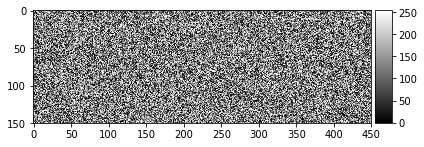

OUTPUT


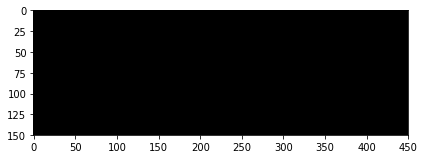

TARGET


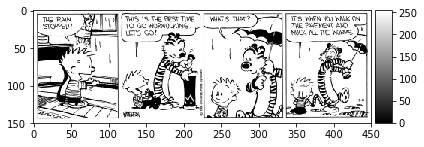

step  0 / 7367 d_loss:  3.220874786376953 g_loss:  [61.083664, 0.60913014, 0.1706486]
step  1 / 7367 d_loss:  0.18950483202934265 g_loss:  [60.74869, 0.60595286, 0.1534039]
step  2 / 7367 d_loss:  0.15310080349445343 g_loss:  [63.071785, 0.6289307, 0.17871372]
step  3 / 7367 d_loss:  0.137681782245636 g_loss:  [63.21029, 0.629838, 0.22648904]
step  4 / 7367 d_loss:  0.12347825616598129 g_loss:  [60.70601, 0.6045618, 0.24982956]
step  5 / 7367 d_loss:  0.08701487630605698 g_loss:  [64.372345, 0.64062047, 0.3102954]
step  6 / 7367 d_loss:  0.09752172976732254 g_loss:  [56.86793, 0.56533813, 0.33411667]
step  7 / 7367 d_loss:  0.08375988155603409 g_loss:  [54.019325, 0.5366538, 0.3539424]
step  8 / 7367 d_loss:  0.04910940304398537 g_loss:  [59.14499, 0.58705777, 0.43921387]
step  9 / 7367 d_loss:  0.050772834569215775 g_loss:  [58.56813, 0.58107466, 0.4606673]
step  10 / 7367 d_loss:  0.019404690712690353 g_loss:  [61.803665, 0.61220866, 0.5827975]
step  11 / 7367 d_loss:  0.030302705243

step  94 / 7367 d_loss:  0.011505987495183945 g_loss:  [58.943993, 0.5794005, 1.0039431]
step  95 / 7367 d_loss:  0.0048545789904892445 g_loss:  [55.701912, 0.54767907, 0.934007]
step  96 / 7367 d_loss:  0.034736987203359604 g_loss:  [59.319706, 0.5853711, 0.78259665]
step  97 / 7367 d_loss:  0.006871598772704601 g_loss:  [58.619747, 0.57712084, 0.9076606]
step  98 / 7367 d_loss:  0.002519328612834215 g_loss:  [57.279083, 0.5638968, 0.8894037]
step  99 / 7367 d_loss:  0.018092261627316475 g_loss:  [59.517773, 0.5874838, 0.76938844]
step  100 / 7367 d_loss:  0.012291623279452324 g_loss:  [56.734222, 0.5549898, 1.2352418]
step  101 / 7367 d_loss:  0.014097105711698532 g_loss:  [59.983765, 0.5912524, 0.8585259]
step  102 / 7367 d_loss:  0.0037964556831866503 g_loss:  [61.284733, 0.6037695, 0.907782]
step  103 / 7367 d_loss:  0.0011285430518910289 g_loss:  [64.93216, 0.64095163, 0.8370009]
step  104 / 7367 d_loss:  0.004936498124152422 g_loss:  [58.063465, 0.56968415, 1.0950509]
step  105 

step  186 / 7367 d_loss:  0.03245912492275238 g_loss:  [55.18769, 0.5448464, 0.7030495]
step  187 / 7367 d_loss:  0.05563563480973244 g_loss:  [51.79129, 0.51107466, 0.68382186]
step  188 / 7367 d_loss:  0.023667458444833755 g_loss:  [52.680225, 0.518659, 0.8143286]
step  189 / 7367 d_loss:  0.0026908940635621548 g_loss:  [53.746155, 0.5273042, 1.0157388]
step  190 / 7367 d_loss:  0.009570477530360222 g_loss:  [52.241623, 0.51279956, 0.96166617]
step  191 / 7367 d_loss:  0.06394963711500168 g_loss:  [57.228344, 0.56546414, 0.68193126]
step  192 / 7367 d_loss:  0.012991168536245823 g_loss:  [55.515408, 0.5473433, 0.78107595]
step  193 / 7367 d_loss:  0.005125453695654869 g_loss:  [56.700977, 0.55432445, 1.2685304]
step  194 / 7367 d_loss:  0.047306258231401443 g_loss:  [57.23258, 0.5647448, 0.758103]
step  195 / 7367 d_loss:  0.0052195326425135136 g_loss:  [66.215416, 0.65099823, 1.115592]
step  196 / 7367 d_loss:  0.03386346250772476 g_loss:  [58.76116, 0.57728404, 1.0327587]
step  197

step  279 / 7367 d_loss:  0.04280681908130646 g_loss:  [50.43112, 0.4897653, 1.4545944]
step  280 / 7367 d_loss:  0.038301028311252594 g_loss:  [49.332546, 0.4863503, 0.69751894]
step  281 / 7367 d_loss:  0.0065111503936350346 g_loss:  [58.408215, 0.5749406, 0.91415316]
step  282 / 7367 d_loss:  0.03400985151529312 g_loss:  [46.766838, 0.46000633, 0.76620317]
step  283 / 7367 d_loss:  0.0008177301497198641 g_loss:  [54.739346, 0.5398953, 0.7498182]
step  284 / 7367 d_loss:  0.16673071682453156 g_loss:  [43.259163, 0.4252169, 0.7374707]
step  285 / 7367 d_loss:  0.0009415391250513494 g_loss:  [63.28576, 0.62338114, 0.9476462]
step  286 / 7367 d_loss:  0.001096788328140974 g_loss:  [59.85793, 0.5901586, 0.84207]
step  287 / 7367 d_loss:  0.005227035842835903 g_loss:  [61.18727, 0.60190326, 0.99694484]
step  288 / 7367 d_loss:  0.05847267061471939 g_loss:  [42.88951, 0.42042392, 0.8471195]
step  289 / 7367 d_loss:  0.04966367781162262 g_loss:  [44.123077, 0.43231246, 0.89183]
step  290 / 

step  371 / 7367 d_loss:  0.01134043000638485 g_loss:  [70.28081, 0.69196016, 1.0847893]
step  372 / 7367 d_loss:  0.04218532517552376 g_loss:  [45.172043, 0.44448993, 0.7230485]
step  373 / 7367 d_loss:  0.030245738103985786 g_loss:  [68.70888, 0.6780723, 0.90164626]
step  374 / 7367 d_loss:  0.010948669165372849 g_loss:  [54.328575, 0.5342132, 0.90725726]
step  375 / 7367 d_loss:  0.009739866480231285 g_loss:  [56.77973, 0.55572695, 1.2070391]
step  376 / 7367 d_loss:  0.03059738501906395 g_loss:  [56.658295, 0.5493132, 1.7269764]
step  377 / 7367 d_loss:  0.034799184650182724 g_loss:  [53.63601, 0.52471375, 1.1646328]
step  378 / 7367 d_loss:  0.0057032108306884766 g_loss:  [68.59191, 0.67567015, 1.0248935]
step  379 / 7367 d_loss:  0.0035992686171084642 g_loss:  [53.402824, 0.5224197, 1.1608541]
step  380 / 7367 d_loss:  0.033334217965602875 g_loss:  [47.698227, 0.4664901, 1.049218]
step  381 / 7367 d_loss:  0.012343844398856163 g_loss:  [54.65878, 0.53420097, 1.2386807]
step  382 

step  463 / 7367 d_loss:  0.011448807083070278 g_loss:  [50.917984, 0.49982187, 0.93579876]
step  464 / 7367 d_loss:  0.019192667677998543 g_loss:  [50.978912, 0.49875244, 1.1036675]
step  465 / 7367 d_loss:  0.0019611527677625418 g_loss:  [70.61678, 0.6993972, 0.67705965]
step  466 / 7367 d_loss:  0.016431201249361038 g_loss:  [44.724903, 0.4375041, 0.9744895]
step  467 / 7367 d_loss:  0.0013646604493260384 g_loss:  [51.17306, 0.50193983, 0.9790758]
step  468 / 7367 d_loss:  0.014357001520693302 g_loss:  [66.60685, 0.65630275, 0.9765806]
step  469 / 7367 d_loss:  0.002324311062693596 g_loss:  [57.848343, 0.56944793, 0.9035478]
step  470 / 7367 d_loss:  0.004188998136669397 g_loss:  [54.458344, 0.53257406, 1.2009394]
step  471 / 7367 d_loss:  0.008877590298652649 g_loss:  [46.37013, 0.4541731, 0.95281976]
step  472 / 7367 d_loss:  0.020702963694930077 g_loss:  [45.918957, 0.44542626, 1.3763311]
step  473 / 7367 d_loss:  0.043753482401371 g_loss:  [51.009865, 0.50220084, 0.78977984]
ste

step  556 / 7367 d_loss:  0.03348815068602562 g_loss:  [59.648064, 0.5880228, 0.8457806]
step  557 / 7367 d_loss:  0.019082697108387947 g_loss:  [50.303894, 0.4951176, 0.7921318]
step  558 / 7367 d_loss:  0.016832515597343445 g_loss:  [51.36883, 0.5059432, 0.77451247]
step  559 / 7367 d_loss:  0.03539200872182846 g_loss:  [48.299374, 0.4744647, 0.85290235]
step  560 / 7367 d_loss:  0.03907029703259468 g_loss:  [51.292336, 0.50627804, 0.6645312]
step  561 / 7367 d_loss:  0.07473547756671906 g_loss:  [52.35817, 0.5189834, 0.45982718]
step  562 / 7367 d_loss:  0.026692533865571022 g_loss:  [57.978054, 0.57211494, 0.76655936]
step  563 / 7367 d_loss:  0.045915935188531876 g_loss:  [43.033405, 0.42154336, 0.87907]
step  564 / 7367 d_loss:  0.0072909751906991005 g_loss:  [44.164032, 0.43411997, 0.752035]
step  565 / 7367 d_loss:  0.008565131574869156 g_loss:  [53.019802, 0.520102, 1.0096016]
step  566 / 7367 d_loss:  0.0180408526211977 g_loss:  [58.31538, 0.57399803, 0.9155765]
step  567 / 7

step  649 / 7367 d_loss:  0.06744875758886337 g_loss:  [43.82727, 0.42730594, 1.0966749]
step  650 / 7367 d_loss:  0.01797647960484028 g_loss:  [57.71492, 0.565855, 1.1294155]
step  651 / 7367 d_loss:  0.18892204761505127 g_loss:  [41.230743, 0.4021863, 1.0121114]
step  652 / 7367 d_loss:  0.1514422744512558 g_loss:  [44.625282, 0.43573314, 1.0519668]
step  653 / 7367 d_loss:  0.6072788834571838 g_loss:  [38.626274, 0.37654004, 0.9722701]
step  654 / 7367 d_loss:  0.06922493129968643 g_loss:  [50.167248, 0.49176064, 0.99118304]
step  655 / 7367 d_loss:  0.10840757191181183 g_loss:  [54.851162, 0.5405435, 0.7968154]
step  656 / 7367 d_loss:  0.02891923114657402 g_loss:  [49.738285, 0.48831147, 0.9071405]
step  657 / 7367 d_loss:  0.03406652808189392 g_loss:  [52.934464, 0.5200516, 0.92930275]
step  658 / 7367 d_loss:  0.009651262313127518 g_loss:  [53.20628, 0.520342, 1.1720793]
step  659 / 7367 d_loss:  0.028022246435284615 g_loss:  [45.731808, 0.44360125, 1.3716803]
step  660 / 7367 d

step  742 / 7367 d_loss:  0.021002857014536858 g_loss:  [56.62908, 0.557416, 0.88747895]
step  743 / 7367 d_loss:  0.03557270020246506 g_loss:  [47.746124, 0.46820393, 0.92573106]
step  744 / 7367 d_loss:  0.012032713741064072 g_loss:  [48.724068, 0.4741615, 1.3079194]
step  745 / 7367 d_loss:  0.013501755893230438 g_loss:  [47.27657, 0.46337086, 0.939485]
step  746 / 7367 d_loss:  0.007417695596814156 g_loss:  [51.11395, 0.50009364, 1.1045854]
step  747 / 7367 d_loss:  0.01258129347115755 g_loss:  [48.94703, 0.48049438, 0.8975902]
step  748 / 7367 d_loss:  0.00630762055516243 g_loss:  [45.163746, 0.44156808, 1.0069386]
step  749 / 7367 d_loss:  0.03664169833064079 g_loss:  [68.40247, 0.6745523, 0.94724023]
step  750 / 7367 d_loss:  0.038217443972826004 g_loss:  [53.4087, 0.52437985, 0.9707144]
step  751 / 7367 d_loss:  0.016646161675453186 g_loss:  [52.799805, 0.5190485, 0.89495444]
step  752 / 7367 d_loss:  0.004475859459489584 g_loss:  [50.634216, 0.49510694, 1.1235228]
step  753 / 

step  835 / 7367 d_loss:  0.12621039152145386 g_loss:  [42.881195, 0.42111295, 0.7699007]
step  836 / 7367 d_loss:  0.1884138584136963 g_loss:  [39.15891, 0.3825355, 0.9053629]
step  837 / 7367 d_loss:  0.05575234442949295 g_loss:  [51.26318, 0.5039479, 0.8683891]
step  838 / 7367 d_loss:  0.009862111881375313 g_loss:  [95.19031, 0.94240904, 0.9494011]
step  839 / 7367 d_loss:  0.15602409839630127 g_loss:  [40.211296, 0.3938, 0.8313005]
step  840 / 7367 d_loss:  0.0779111385345459 g_loss:  [42.81922, 0.41942158, 0.87706476]
step  841 / 7367 d_loss:  0.032002951949834824 g_loss:  [48.45705, 0.47551116, 0.9059331]
step  842 / 7367 d_loss:  0.016190871596336365 g_loss:  [43.515636, 0.42527848, 0.9877904]
step  843 / 7367 d_loss:  0.015647660940885544 g_loss:  [52.43152, 0.50920373, 1.5111469]
step  844 / 7367 d_loss:  0.026555117219686508 g_loss:  [54.341103, 0.5333111, 1.0099897]
step  845 / 7367 d_loss:  0.0051834555342793465 g_loss:  [60.305946, 0.59005076, 1.3008698]
step  846 / 7367 

step  927 / 7367 d_loss:  0.07018398493528366 g_loss:  [58.702217, 0.5783162, 0.8705986]
step  928 / 7367 d_loss:  0.06925231218338013 g_loss:  [53.802917, 0.5247963, 1.3232898]
step  929 / 7367 d_loss:  0.08229894936084747 g_loss:  [46.475594, 0.44973394, 1.5022014]
step  930 / 7367 d_loss:  0.09236329793930054 g_loss:  [48.13349, 0.46399707, 1.7337832]
step  931 / 7367 d_loss:  0.009327123872935772 g_loss:  [55.541504, 0.53896713, 1.644792]
step  932 / 7367 d_loss:  0.008266855031251907 g_loss:  [58.13084, 0.56512046, 1.6187953]
step  933 / 7367 d_loss:  0.028434038162231445 g_loss:  [55.165314, 0.5368856, 1.4767529]
step  934 / 7367 d_loss:  1.0094598531723022 g_loss:  [38.91801, 0.37442258, 1.4757541]
step  935 / 7367 d_loss:  0.044470831751823425 g_loss:  [49.280777, 0.48072782, 1.207997]
step  936 / 7367 d_loss:  0.005804006941616535 g_loss:  [60.928135, 0.5970779, 1.2203441]
step  937 / 7367 d_loss:  0.045429527759552 g_loss:  [48.6656, 0.47015917, 1.6496803]
step  938 / 7367 d_

step  1019 / 7367 d_loss:  0.06078917533159256 g_loss:  [52.977497, 0.5191917, 1.0583311]
step  1020 / 7367 d_loss:  0.020572299137711525 g_loss:  [62.420094, 0.6111594, 1.3041517]
step  1021 / 7367 d_loss:  0.025289222598075867 g_loss:  [49.289127, 0.4794174, 1.3473866]
step  1022 / 7367 d_loss:  0.00046780495904386044 g_loss:  [53.854916, 0.523249, 1.530018]
step  1023 / 7367 d_loss:  0.06983340531587601 g_loss:  [62.70251, 0.6166368, 1.0388312]
step  1024 / 7367 d_loss:  0.02329684980213642 g_loss:  [56.543507, 0.552755, 1.2680053]
step  1025 / 7367 d_loss:  0.056916020810604095 g_loss:  [50.979794, 0.4951309, 1.4667042]
step  1026 / 7367 d_loss:  0.0397520512342453 g_loss:  [48.220284, 0.468826, 1.3376863]
step  1027 / 7367 d_loss:  0.9371228814125061 g_loss:  [38.716843, 0.370978, 1.6190412]
step  1028 / 7367 d_loss:  0.019430559128522873 g_loss:  [50.635178, 0.49254677, 1.3805022]
step  1029 / 7367 d_loss:  0.03983422741293907 g_loss:  [52.64398, 0.5144573, 1.1982509]
step  1030 

step  1110 / 7367 d_loss:  0.003363905008882284 g_loss:  [48.127598, 0.47003675, 1.1239252]
step  1111 / 7367 d_loss:  0.0775272324681282 g_loss:  [52.837406, 0.5204321, 0.7941937]
step  1112 / 7367 d_loss:  0.04052558168768883 g_loss:  [64.24568, 0.63313293, 0.93238866]
step  1113 / 7367 d_loss:  0.07742173224687576 g_loss:  [52.464355, 0.5170954, 0.7548163]
step  1114 / 7367 d_loss:  0.02320132590830326 g_loss:  [52.23529, 0.50978196, 1.2570939]
step  1115 / 7367 d_loss:  0.024276738986372948 g_loss:  [52.409683, 0.51341766, 1.0679164]
step  1116 / 7367 d_loss:  0.028057347983121872 g_loss:  [46.838722, 0.457607, 1.0780202]
step  1117 / 7367 d_loss:  0.06069602817296982 g_loss:  [46.966583, 0.45874637, 1.0919456]
step  1118 / 7367 d_loss:  0.03912743553519249 g_loss:  [43.797062, 0.42541263, 1.2557988]
step  1119 / 7367 d_loss:  0.03806848078966141 g_loss:  [53.056107, 0.52094454, 0.9616561]
step  1120 / 7367 d_loss:  0.010203810408711433 g_loss:  [54.33222, 0.5290774, 1.4244779]
ste

step  1202 / 7367 d_loss:  0.020014191046357155 g_loss:  [59.700798, 0.5817748, 1.5233194]
step  1203 / 7367 d_loss:  0.051289159804582596 g_loss:  [47.95709, 0.46378076, 1.5790155]
step  1204 / 7367 d_loss:  0.011017076671123505 g_loss:  [51.109196, 0.49392742, 1.7164546]
step  1205 / 7367 d_loss:  0.011229300871491432 g_loss:  [60.792244, 0.59335625, 1.4566183]
step  1206 / 7367 d_loss:  0.01464597787708044 g_loss:  [52.874798, 0.51187205, 1.6875925]
step  1207 / 7367 d_loss:  0.08195865154266357 g_loss:  [44.996273, 0.4353132, 1.4649547]
step  1208 / 7367 d_loss:  0.025732994079589844 g_loss:  [50.403976, 0.48763466, 1.6405115]
step  1209 / 7367 d_loss:  0.13466626405715942 g_loss:  [44.122196, 0.4269959, 1.4226084]
step  1210 / 7367 d_loss:  0.007982753217220306 g_loss:  [51.6911, 0.49990705, 1.7003993]
step  1211 / 7367 d_loss:  0.035096026957035065 g_loss:  [50.537785, 0.4903419, 1.5035945]
step  1212 / 7367 d_loss:  0.046620480716228485 g_loss:  [42.2499, 0.4092191, 1.3279909]
s

step  1294 / 7367 d_loss:  0.015680355951189995 g_loss:  [49.43159, 0.48014474, 1.4171194]
step  1295 / 7367 d_loss:  0.008465567603707314 g_loss:  [56.522293, 0.5497944, 1.5428548]
step  1296 / 7367 d_loss:  0.009243417531251907 g_loss:  [86.95863, 0.855469, 1.4117334]
step  1297 / 7367 d_loss:  0.25084981322288513 g_loss:  [40.48565, 0.39185986, 1.2996633]
step  1298 / 7367 d_loss:  0.018219230696558952 g_loss:  [58.358383, 0.5666513, 1.693255]
step  1299 / 7367 d_loss:  0.012837221845984459 g_loss:  [45.955868, 0.44392565, 1.5633024]
step  1300 / 7367 d_loss:  0.20299917459487915 g_loss:  [42.95171, 0.41630435, 1.3212744]
step  1301 / 7367 d_loss:  0.09959687292575836 g_loss:  [45.76078, 0.44087073, 1.6737071]
step  1302 / 7367 d_loss:  0.002691165776923299 g_loss:  [55.301056, 0.5356466, 1.7363946]
step  1303 / 7367 d_loss:  0.03876807168126106 g_loss:  [46.884426, 0.45442095, 1.4423305]
step  1304 / 7367 d_loss:  0.0013271558564156294 g_loss:  [56.346687, 0.5516073, 1.1859553]
ste

step  1386 / 7367 d_loss:  0.03811553120613098 g_loss:  [49.067635, 0.48073626, 0.99401206]
step  1387 / 7367 d_loss:  0.039845746010541916 g_loss:  [70.46472, 0.6963946, 0.82525957]
step  1388 / 7367 d_loss:  0.055595945566892624 g_loss:  [45.837784, 0.4502772, 0.8100624]
step  1389 / 7367 d_loss:  0.060664013028144836 g_loss:  [48.409836, 0.4762036, 0.7894771]
step  1390 / 7367 d_loss:  0.029488256201148033 g_loss:  [52.936737, 0.5203872, 0.89801663]
step  1391 / 7367 d_loss:  0.03405216336250305 g_loss:  [54.112885, 0.53128576, 0.98430806]
step  1392 / 7367 d_loss:  0.018696274608373642 g_loss:  [50.698322, 0.4970239, 0.99592924]
step  1393 / 7367 d_loss:  0.022162262350320816 g_loss:  [44.00767, 0.42934543, 1.0731276]
step  1394 / 7367 d_loss:  0.006031485740095377 g_loss:  [47.317184, 0.4618071, 1.1364759]
step  1395 / 7367 d_loss:  0.017322145402431488 g_loss:  [50.833344, 0.4976275, 1.070596]
step  1396 / 7367 d_loss:  0.013501841574907303 g_loss:  [53.84063, 0.52811044, 1.02958

step  1477 / 7367 d_loss:  0.002383307320997119 g_loss:  [53.11384, 0.5162832, 1.4855137]
step  1478 / 7367 d_loss:  0.004317357670515776 g_loss:  [87.44263, 0.86140186, 1.3024437]
step  1479 / 7367 d_loss:  0.006134709808975458 g_loss:  [50.68476, 0.49267152, 1.4176116]
step  1480 / 7367 d_loss:  0.03940756618976593 g_loss:  [40.886593, 0.39671534, 1.2150583]
step  1481 / 7367 d_loss:  0.024654248729348183 g_loss:  [47.88287, 0.46709055, 1.173817]
step  1482 / 7367 d_loss:  0.021554790437221527 g_loss:  [47.485153, 0.46564654, 0.92049605]
step  1483 / 7367 d_loss:  0.003009714651852846 g_loss:  [51.552135, 0.50374144, 1.1779894]
step  1484 / 7367 d_loss:  0.009400494396686554 g_loss:  [52.790504, 0.51744664, 1.045842]
step  1485 / 7367 d_loss:  0.038187138736248016 g_loss:  [47.46395, 0.46403554, 1.0603986]
step  1486 / 7367 d_loss:  0.008007409051060677 g_loss:  [56.54939, 0.55157757, 1.3916336]
step  1487 / 7367 d_loss:  0.004978458397090435 g_loss:  [50.789757, 0.4940787, 1.3818841

step  1569 / 7367 d_loss:  0.012917309999465942 g_loss:  [78.44348, 0.7714757, 1.2959162]
step  1570 / 7367 d_loss:  0.01262785866856575 g_loss:  [50.059456, 0.4864093, 1.418527]
step  1571 / 7367 d_loss:  0.005998400039970875 g_loss:  [43.17192, 0.41963091, 1.2088281]
step  1572 / 7367 d_loss:  0.0011599615681916475 g_loss:  [50.38031, 0.49325556, 1.0547551]
step  1573 / 7367 d_loss:  0.030200790613889694 g_loss:  [41.586254, 0.40462297, 1.1239591]
step  1574 / 7367 d_loss:  0.005272272974252701 g_loss:  [53.192818, 0.52162844, 1.0299716]
step  1575 / 7367 d_loss:  0.0132145956158638 g_loss:  [43.65447, 0.42405346, 1.2491208]
step  1576 / 7367 d_loss:  0.005042626056820154 g_loss:  [44.436474, 0.43501753, 0.93472224]
step  1577 / 7367 d_loss:  0.0069449362345039845 g_loss:  [50.85264, 0.4976256, 1.0900792]
step  1578 / 7367 d_loss:  0.022776756435632706 g_loss:  [41.97023, 0.40983444, 0.98678666]
step  1579 / 7367 d_loss:  0.0027350815944373608 g_loss:  [65.10877, 0.6426607, 0.8427074

step  1660 / 7367 d_loss:  0.03973061963915825 g_loss:  [46.93975, 0.45681107, 1.2586442]
step  1661 / 7367 d_loss:  0.00411418080329895 g_loss:  [59.884193, 0.58649164, 1.2350261]
step  1662 / 7367 d_loss:  0.302076518535614 g_loss:  [34.772865, 0.33601415, 1.1714522]
step  1663 / 7367 d_loss:  0.006137596908956766 g_loss:  [51.28274, 0.49940926, 1.3418177]
step  1664 / 7367 d_loss:  0.0074844155460596085 g_loss:  [47.131393, 0.45958948, 1.1724461]
step  1665 / 7367 d_loss:  0.03607408329844475 g_loss:  [42.90803, 0.41754773, 1.1532599]
step  1666 / 7367 d_loss:  0.026931121945381165 g_loss:  [44.595425, 0.43477637, 1.1177862]
step  1667 / 7367 d_loss:  0.007366940379142761 g_loss:  [50.574356, 0.49405417, 1.1689365]
step  1668 / 7367 d_loss:  0.0032744002528488636 g_loss:  [51.665054, 0.50612605, 1.0524473]
step  1669 / 7367 d_loss:  0.00800890102982521 g_loss:  [50.74511, 0.49794248, 0.9508623]
step  1670 / 7367 d_loss:  0.005041210912168026 g_loss:  [58.88248, 0.57732207, 1.1502724

step  1750 / 7367 d_loss:  0.0071634454652667046 g_loss:  [53.6871, 0.53052396, 0.6347038]
step  1751 / 7367 d_loss:  0.019722184166312218 g_loss:  [61.629757, 0.60928243, 0.70151407]
step  1752 / 7367 d_loss:  0.0011003694962710142 g_loss:  [44.767796, 0.4400773, 0.7600673]
step  1753 / 7367 d_loss:  0.017934711650013924 g_loss:  [43.116287, 0.42353573, 0.7627157]
step  1754 / 7367 d_loss:  0.0040461355820298195 g_loss:  [50.241398, 0.49298877, 0.942519]
step  1755 / 7367 d_loss:  0.0055035254918038845 g_loss:  [53.641582, 0.52715045, 0.92653745]
step  1756 / 7367 d_loss:  0.02714945748448372 g_loss:  [50.169952, 0.49325508, 0.84444594]
step  1757 / 7367 d_loss:  0.02703765407204628 g_loss:  [46.064053, 0.45194837, 0.8692159]
step  1758 / 7367 d_loss:  0.020832497626543045 g_loss:  [52.57846, 0.5161294, 0.9655238]
step  1759 / 7367 d_loss:  0.009901455603539944 g_loss:  [45.764584, 0.44410643, 1.3539402]
step  1760 / 7367 d_loss:  0.020060395821928978 g_loss:  [46.639877, 0.45681158, 

step  1841 / 7367 d_loss:  0.02308160439133644 g_loss:  [55.68054, 0.54712325, 0.9682134]
step  1842 / 7367 d_loss:  0.006226454861462116 g_loss:  [54.007713, 0.52979743, 1.0279698]
step  1843 / 7367 d_loss:  0.004037718754261732 g_loss:  [46.34077, 0.45272675, 1.0680977]
step  1844 / 7367 d_loss:  0.00031728949397802353 g_loss:  [51.963783, 0.50825834, 1.137947]
step  1845 / 7367 d_loss:  0.0013882005587220192 g_loss:  [52.17169, 0.5112388, 1.0478098]
step  1846 / 7367 d_loss:  0.008532513864338398 g_loss:  [47.45987, 0.46362078, 1.0977895]
step  1847 / 7367 d_loss:  0.002030611503869295 g_loss:  [40.134342, 0.39085665, 1.0486763]
step  1848 / 7367 d_loss:  0.0005854342598468065 g_loss:  [60.205063, 0.591021, 1.102964]
step  1849 / 7367 d_loss:  0.013476178981363773 g_loss:  [53.948242, 0.5283199, 1.1162516]
step  1850 / 7367 d_loss:  0.007831068709492683 g_loss:  [38.649982, 0.37650213, 0.9997724]
step  1851 / 7367 d_loss:  0.0029610823839902878 g_loss:  [52.76092, 0.5174989, 1.01103

step  1932 / 7367 d_loss:  0.002869468182325363 g_loss:  [47.987354, 0.46937236, 1.0501187]
step  1933 / 7367 d_loss:  0.0018796958029270172 g_loss:  [45.73416, 0.44625175, 1.1089845]
step  1934 / 7367 d_loss:  0.0018741339445114136 g_loss:  [54.748333, 0.5371809, 1.0302422]
step  1935 / 7367 d_loss:  0.08280869573354721 g_loss:  [37.77033, 0.36757842, 1.0124856]
step  1936 / 7367 d_loss:  0.021709240972995758 g_loss:  [44.189034, 0.43056312, 1.1327225]
step  1937 / 7367 d_loss:  0.007930876687169075 g_loss:  [61.62175, 0.60619605, 1.0021431]
step  1938 / 7367 d_loss:  0.002422052901238203 g_loss:  [50.928963, 0.49914068, 1.0148983]
step  1939 / 7367 d_loss:  0.0015956815332174301 g_loss:  [51.357918, 0.50322145, 1.0357751]
step  1940 / 7367 d_loss:  0.0032753851264715195 g_loss:  [49.501923, 0.48408213, 1.0937098]
step  1941 / 7367 d_loss:  0.006239422131329775 g_loss:  [57.522144, 0.5652534, 0.9968069]
step  1942 / 7367 d_loss:  0.002300962107256055 g_loss:  [46.309273, 0.45388559, 0

step  2022 / 7367 d_loss:  0.05022178590297699 g_loss:  [35.54003, 0.34644756, 0.8952764]
step  2023 / 7367 d_loss:  0.011255631223320961 g_loss:  [46.7185, 0.4591589, 0.80261016]
step  2024 / 7367 d_loss:  0.0007461667410098016 g_loss:  [55.772606, 0.550296, 0.74300474]
step  2025 / 7367 d_loss:  0.024975860491394997 g_loss:  [37.68725, 0.36938906, 0.7483444]
step  2026 / 7367 d_loss:  0.016273267567157745 g_loss:  [48.344166, 0.47603276, 0.7408891]
step  2027 / 7367 d_loss:  0.0027014112565666437 g_loss:  [43.38595, 0.4271662, 0.66932875]
step  2028 / 7367 d_loss:  0.0017722947522997856 g_loss:  [44.139526, 0.4346438, 0.6751449]
step  2029 / 7367 d_loss:  0.006349480710923672 g_loss:  [45.921623, 0.45335126, 0.5865001]
step  2030 / 7367 d_loss:  0.019717993214726448 g_loss:  [53.096684, 0.5247173, 0.62495863]
step  2031 / 7367 d_loss:  0.01520454604178667 g_loss:  [47.284504, 0.46595466, 0.6890373]
step  2032 / 7367 d_loss:  0.004567934665828943 g_loss:  [51.92048, 0.51291287, 0.6291

step  2113 / 7367 d_loss:  0.0006512110121548176 g_loss:  [41.949936, 0.4127185, 0.6780841]
step  2114 / 7367 d_loss:  0.0046304501593112946 g_loss:  [48.001633, 0.4723773, 0.76390195]
step  2115 / 7367 d_loss:  0.004823912400752306 g_loss:  [46.23743, 0.45554107, 0.6833221]
step  2116 / 7367 d_loss:  0.00041362945921719074 g_loss:  [49.2265, 0.48400348, 0.8261531]
step  2117 / 7367 d_loss:  0.010996267199516296 g_loss:  [50.330254, 0.49636748, 0.69350445]
step  2118 / 7367 d_loss:  0.012945612892508507 g_loss:  [50.134274, 0.49469393, 0.6648787]
step  2119 / 7367 d_loss:  0.00047603860730305314 g_loss:  [52.24761, 0.514914, 0.756209]
step  2120 / 7367 d_loss:  0.003490559523925185 g_loss:  [51.951817, 0.5120434, 0.74747473]
step  2121 / 7367 d_loss:  0.019412852823734283 g_loss:  [46.330006, 0.45559323, 0.77068144]
step  2122 / 7367 d_loss:  0.027849528938531876 g_loss:  [53.05584, 0.52119607, 0.9362343]
step  2123 / 7367 d_loss:  0.001060289447195828 g_loss:  [48.70275, 0.47882187, 0

step  2204 / 7367 d_loss:  0.00657422561198473 g_loss:  [41.056393, 0.39941517, 1.114877]
step  2205 / 7367 d_loss:  0.01269809901714325 g_loss:  [46.13313, 0.45187962, 0.9451675]
step  2206 / 7367 d_loss:  0.006617601495236158 g_loss:  [50.50324, 0.49595666, 0.9075751]
step  2207 / 7367 d_loss:  0.011742135509848595 g_loss:  [39.397617, 0.3856367, 0.83394974]
step  2208 / 7367 d_loss:  0.002737706759944558 g_loss:  [45.51087, 0.44741884, 0.7689899]
step  2209 / 7367 d_loss:  0.004800592549145222 g_loss:  [53.880768, 0.53133947, 0.7468205]
step  2210 / 7367 d_loss:  0.0005425761919468641 g_loss:  [40.62457, 0.3982761, 0.7969583]
step  2211 / 7367 d_loss:  0.005997924134135246 g_loss:  [48.553093, 0.47815272, 0.73782134]
step  2212 / 7367 d_loss:  0.001120379427447915 g_loss:  [53.923214, 0.53137606, 0.78560495]
step  2213 / 7367 d_loss:  0.009133913554251194 g_loss:  [41.390644, 0.4073698, 0.65366346]
step  2214 / 7367 d_loss:  0.004026815760880709 g_loss:  [48.77503, 0.47984886, 0.790

step  2294 / 7367 d_loss:  0.0029216064140200615 g_loss:  [37.57532, 0.3688672, 0.68860376]
step  2295 / 7367 d_loss:  0.004639021120965481 g_loss:  [67.363495, 0.66631144, 0.73235565]
step  2296 / 7367 d_loss:  0.0003112030099146068 g_loss:  [43.08229, 0.42434525, 0.64776456]
step  2297 / 7367 d_loss:  0.002253204118460417 g_loss:  [45.937748, 0.45327088, 0.6106588]
step  2298 / 7367 d_loss:  0.000433409761171788 g_loss:  [55.737648, 0.54933876, 0.8037706]
step  2299 / 7367 d_loss:  0.0038135447539389133 g_loss:  [40.367653, 0.39766562, 0.60109025]
step  2300 / 7367 d_loss:  0.007290287874639034 g_loss:  [55.26061, 0.54585487, 0.6751231]
step  2301 / 7367 d_loss:  0.010217548348009586 g_loss:  [47.766193, 0.47077554, 0.6886414]
step  2302 / 7367 d_loss:  0.003362254472449422 g_loss:  [45.35348, 0.4470371, 0.6497711]
step  2303 / 7367 d_loss:  0.004159863106906414 g_loss:  [49.310055, 0.4853401, 0.77604586]
step  2304 / 7367 d_loss:  0.00029226337210275233 g_loss:  [53.32865, 0.5258037

step  2384 / 7367 d_loss:  0.002126144478097558 g_loss:  [45.170715, 0.4440006, 0.7706556]
step  2385 / 7367 d_loss:  0.0020003439858555794 g_loss:  [60.064926, 0.5924734, 0.8175874]
step  2386 / 7367 d_loss:  0.0054746405221521854 g_loss:  [49.440216, 0.48700666, 0.73954827]
step  2387 / 7367 d_loss:  0.00015156128210946918 g_loss:  [46.60037, 0.45734626, 0.8657429]
step  2388 / 7367 d_loss:  0.0013381724711507559 g_loss:  [51.567833, 0.5072699, 0.84084123]
step  2389 / 7367 d_loss:  0.002235530409961939 g_loss:  [45.935852, 0.4517196, 0.76388854]
step  2390 / 7367 d_loss:  8.775156311457977e-05 g_loss:  [49.373528, 0.48565868, 0.8076585]
step  2391 / 7367 d_loss:  0.02922801859676838 g_loss:  [49.260754, 0.48421273, 0.83948064]
step  2392 / 7367 d_loss:  0.001252098474651575 g_loss:  [48.41706, 0.47597528, 0.81953543]
step  2393 / 7367 d_loss:  0.00017156515968963504 g_loss:  [43.017094, 0.42263815, 0.753279]
step  2394 / 7367 d_loss:  1.9707107639987953e-05 g_loss:  [48.219883, 0.47

step  2475 / 7367 d_loss:  0.004632759373635054 g_loss:  [52.21602, 0.5109176, 1.1242596]
step  2476 / 7367 d_loss:  0.0034822893794625998 g_loss:  [44.206028, 0.43146834, 1.059191]
step  2477 / 7367 d_loss:  0.00032621496939100325 g_loss:  [50.516304, 0.49464896, 1.0514073]
step  2478 / 7367 d_loss:  0.004331137984991074 g_loss:  [45.048447, 0.43888614, 1.1598315]
step  2479 / 7367 d_loss:  0.0045196134597063065 g_loss:  [59.879486, 0.5884589, 1.0335953]
step  2480 / 7367 d_loss:  0.3666590452194214 g_loss:  [30.34712, 0.2946259, 0.88452995]
step  2481 / 7367 d_loss:  0.002688306849449873 g_loss:  [44.39471, 0.43516168, 0.8785455]
step  2482 / 7367 d_loss:  0.006328701972961426 g_loss:  [49.328884, 0.48460993, 0.8678903]
step  2483 / 7367 d_loss:  0.0030453249346464872 g_loss:  [50.218758, 0.49385637, 0.8331213]
step  2484 / 7367 d_loss:  0.008404746651649475 g_loss:  [41.720184, 0.40784746, 0.93543464]
step  2485 / 7367 d_loss:  0.009225908666849136 g_loss:  [40.229004, 0.39395446, 0

step  2566 / 7367 d_loss:  0.010308021679520607 g_loss:  [48.517708, 0.4774332, 0.77438843]
step  2567 / 7367 d_loss:  0.0062448675744235516 g_loss:  [70.34432, 0.69667035, 0.67728156]
step  2568 / 7367 d_loss:  0.0022756033577024937 g_loss:  [50.224617, 0.49471483, 0.7531361]
step  2569 / 7367 d_loss:  0.0013842604821547866 g_loss:  [37.944576, 0.37327418, 0.6171557]
step  2570 / 7367 d_loss:  0.013669057749211788 g_loss:  [60.13884, 0.5952585, 0.6129898]
step  2571 / 7367 d_loss:  0.010046015493571758 g_loss:  [45.181683, 0.44522774, 0.6589079]
step  2572 / 7367 d_loss:  0.0032075841445475817 g_loss:  [36.274002, 0.35554907, 0.71909547]
step  2573 / 7367 d_loss:  0.004060198552906513 g_loss:  [48.222305, 0.47504833, 0.7174738]
step  2574 / 7367 d_loss:  0.013097379356622696 g_loss:  [45.778862, 0.45119575, 0.6592881]
step  2575 / 7367 d_loss:  0.00865146704018116 g_loss:  [60.506332, 0.59758925, 0.74740565]
step  2576 / 7367 d_loss:  0.00704888254404068 g_loss:  [49.155598, 0.4840760

step  2657 / 7367 d_loss:  0.0010095913894474506 g_loss:  [49.02611, 0.4807269, 0.9534239]
step  2658 / 7367 d_loss:  0.0012259166687726974 g_loss:  [44.75756, 0.43835577, 0.9219805]
step  2659 / 7367 d_loss:  0.0012774349888786674 g_loss:  [50.313, 0.49407113, 0.90588737]
step  2660 / 7367 d_loss:  0.0020756216254085302 g_loss:  [47.080654, 0.46097246, 0.9834101]
step  2661 / 7367 d_loss:  0.0013711570063605905 g_loss:  [45.41068, 0.44404283, 1.0063975]
step  2662 / 7367 d_loss:  0.001026345882564783 g_loss:  [48.598724, 0.47654787, 0.9439388]
step  2663 / 7367 d_loss:  0.004868974909186363 g_loss:  [58.069603, 0.57169574, 0.9000284]
step  2664 / 7367 d_loss:  0.0385563001036644 g_loss:  [33.593887, 0.3270946, 0.8844256]
step  2665 / 7367 d_loss:  0.0024238568730652332 g_loss:  [54.57362, 0.53621864, 0.9517572]
step  2666 / 7367 d_loss:  0.005338594317436218 g_loss:  [48.040165, 0.47182465, 0.8576999]
step  2667 / 7367 d_loss:  0.008241328410804272 g_loss:  [36.714855, 0.3577746, 0.93

step  2747 / 7367 d_loss:  0.2340671718120575 g_loss:  [30.646727, 0.29760435, 0.88629216]
step  2748 / 7367 d_loss:  0.005320302210748196 g_loss:  [62.24481, 0.61424404, 0.8204057]
step  2749 / 7367 d_loss:  0.003975247964262962 g_loss:  [40.61313, 0.3978349, 0.82964075]
step  2750 / 7367 d_loss:  0.004312220029532909 g_loss:  [40.337833, 0.3945508, 0.88275415]
step  2751 / 7367 d_loss:  0.007928967475891113 g_loss:  [48.877586, 0.48142207, 0.73537916]
step  2752 / 7367 d_loss:  0.004540219437330961 g_loss:  [39.009254, 0.3819332, 0.81593513]
step  2753 / 7367 d_loss:  0.002571171848103404 g_loss:  [39.363514, 0.38532686, 0.8308311]
step  2754 / 7367 d_loss:  0.005705079063773155 g_loss:  [44.362656, 0.43603987, 0.758669]
step  2755 / 7367 d_loss:  0.0010027093812823296 g_loss:  [44.5274, 0.43566018, 0.96138525]
step  2756 / 7367 d_loss:  0.011213787831366062 g_loss:  [53.066914, 0.5218368, 0.8832304]
step  2757 / 7367 d_loss:  0.018722034990787506 g_loss:  [60.8168, 0.60014975, 0.801

step  2837 / 7367 d_loss:  0.0004469565465115011 g_loss:  [50.627792, 0.49572945, 1.0548466]
step  2838 / 7367 d_loss:  0.0060343025252223015 g_loss:  [57.88093, 0.56970674, 0.9102586]
step  2839 / 7367 d_loss:  0.034066200256347656 g_loss:  [36.713207, 0.35701698, 1.0115082]
step  2840 / 7367 d_loss:  0.0010692666983231902 g_loss:  [42.148937, 0.41187108, 0.96182877]
step  2841 / 7367 d_loss:  0.002969594206660986 g_loss:  [49.550125, 0.4874805, 0.80207366]
step  2842 / 7367 d_loss:  0.0007697423570789397 g_loss:  [57.078403, 0.5618788, 0.8905202]
step  2843 / 7367 d_loss:  0.0019534279126673937 g_loss:  [57.043167, 0.56087524, 0.95564425]
step  2844 / 7367 d_loss:  0.00602151220664382 g_loss:  [38.130135, 0.37264955, 0.865182]
step  2845 / 7367 d_loss:  0.0022970749996602535 g_loss:  [49.70246, 0.48795834, 0.90662956]
step  2846 / 7367 d_loss:  0.0070318495854735374 g_loss:  [49.891, 0.49022517, 0.8684821]
step  2847 / 7367 d_loss:  0.0029020600486546755 g_loss:  [42.875927, 0.419978

step  2927 / 7367 d_loss:  0.012412860058248043 g_loss:  [39.41491, 0.38271928, 1.1429815]
step  2928 / 7367 d_loss:  0.0014379245694726706 g_loss:  [70.97817, 0.698648, 1.1133721]
step  2929 / 7367 d_loss:  0.0056808702647686005 g_loss:  [45.657707, 0.44537783, 1.1199255]
step  2930 / 7367 d_loss:  0.0016875573201104999 g_loss:  [45.456863, 0.44253522, 1.2033423]
step  2931 / 7367 d_loss:  0.0016404201742261648 g_loss:  [64.80798, 0.63724405, 1.0835835]
step  2932 / 7367 d_loss:  0.001124734990298748 g_loss:  [46.604786, 0.4548181, 1.1229748]
step  2933 / 7367 d_loss:  0.0018615326844155788 g_loss:  [46.898674, 0.4581345, 1.0852249]
step  2934 / 7367 d_loss:  0.0028076819144189358 g_loss:  [45.2924, 0.44257194, 1.035206]
step  2935 / 7367 d_loss:  0.00020918576046824455 g_loss:  [48.341118, 0.47090128, 1.2509875]
step  2936 / 7367 d_loss:  0.009906884282827377 g_loss:  [87.61427, 0.86605126, 1.0091454]
step  2937 / 7367 d_loss:  0.00014236909919418395 g_loss:  [47.781322, 0.46563175, 

step  3018 / 7367 d_loss:  0.004303121007978916 g_loss:  [47.414577, 0.46471038, 0.9435401]
step  3019 / 7367 d_loss:  0.001469347276724875 g_loss:  [48.40933, 0.47477335, 0.93199676]
step  3020 / 7367 d_loss:  0.0018695981707423925 g_loss:  [50.388287, 0.4939641, 0.99187326]
step  3021 / 7367 d_loss:  0.0017346164677292109 g_loss:  [42.8638, 0.41959468, 0.90433156]
step  3022 / 7367 d_loss:  0.001555882627144456 g_loss:  [63.104626, 0.62219, 0.8856251]
step  3023 / 7367 d_loss:  0.01267323736101389 g_loss:  [40.976086, 0.40030274, 0.94581336]
step  3024 / 7367 d_loss:  0.000353376439306885 g_loss:  [46.758404, 0.45790753, 0.96765214]
step  3025 / 7367 d_loss:  0.001061715534888208 g_loss:  [46.952938, 0.45993114, 0.95982337]
step  3026 / 7367 d_loss:  0.0024437722750008106 g_loss:  [47.851143, 0.46930116, 0.92102855]
step  3027 / 7367 d_loss:  0.0009123554918915033 g_loss:  [40.07972, 0.39160216, 0.9195027]
step  3028 / 7367 d_loss:  0.0012788322055712342 g_loss:  [53.352943, 0.523409

step  3109 / 7367 d_loss:  0.006618652027100325 g_loss:  [45.384674, 0.44268057, 1.1166182]
step  3110 / 7367 d_loss:  0.0033940784633159637 g_loss:  [54.09985, 0.52865916, 1.2339333]
step  3111 / 7367 d_loss:  0.0006620074855163693 g_loss:  [60.376274, 0.5910113, 1.2751454]
step  3112 / 7367 d_loss:  0.005036832764744759 g_loss:  [61.247944, 0.60188454, 1.0594889]
step  3113 / 7367 d_loss:  0.08375993371009827 g_loss:  [34.249844, 0.33026823, 1.2230204]
step  3114 / 7367 d_loss:  0.002052335999906063 g_loss:  [54.09574, 0.52917093, 1.1786488]
step  3115 / 7367 d_loss:  3.412814112380147e-05 g_loss:  [46.84139, 0.45646328, 1.1950612]
step  3116 / 7367 d_loss:  0.0014909011078998446 g_loss:  [46.294167, 0.4516417, 1.1299965]
step  3117 / 7367 d_loss:  0.0030092732049524784 g_loss:  [57.77755, 0.56554157, 1.2233927]
step  3118 / 7367 d_loss:  0.00046352975186891854 g_loss:  [53.14993, 0.5192351, 1.2264228]
step  3119 / 7367 d_loss:  0.0024526186753064394 g_loss:  [44.257866, 0.43069473, 

step  3199 / 7367 d_loss:  0.004610584117472172 g_loss:  [44.246414, 0.43578994, 0.66742]
step  3200 / 7367 d_loss:  0.0031751939095556736 g_loss:  [48.249878, 0.47519138, 0.7307409]
step  3201 / 7367 d_loss:  0.0005726151866838336 g_loss:  [50.55325, 0.49796098, 0.7571508]
step  3202 / 7367 d_loss:  0.008811639621853828 g_loss:  [36.53298, 0.35760123, 0.77285594]
step  3203 / 7367 d_loss:  0.004433509428054094 g_loss:  [49.328762, 0.48488197, 0.840565]
step  3204 / 7367 d_loss:  0.003234709147363901 g_loss:  [49.873943, 0.49004015, 0.86992705]
step  3205 / 7367 d_loss:  0.0017008240101858974 g_loss:  [45.852898, 0.44960466, 0.89243174]
step  3206 / 7367 d_loss:  7.446476956829429e-05 g_loss:  [48.8377, 0.47911343, 0.9263578]
step  3207 / 7367 d_loss:  0.0007954709581099451 g_loss:  [53.77375, 0.5274778, 1.0259695]
step  3208 / 7367 d_loss:  0.003990781493484974 g_loss:  [45.262505, 0.44299266, 0.963237]
step  3209 / 7367 d_loss:  0.003387750592082739 g_loss:  [50.09827, 0.48929715, 1.

step  3289 / 7367 d_loss:  0.0004690717614721507 g_loss:  [56.262615, 0.5510223, 1.1603867]
step  3290 / 7367 d_loss:  0.0030498607084155083 g_loss:  [53.009247, 0.51982397, 1.02685]
step  3291 / 7367 d_loss:  0.0032133832573890686 g_loss:  [40.767353, 0.39557022, 1.2103313]
step  3292 / 7367 d_loss:  0.0022299648262560368 g_loss:  [52.454105, 0.5132392, 1.1301833]
step  3293 / 7367 d_loss:  0.0015287752030417323 g_loss:  [60.86126, 0.59577405, 1.2838565]
step  3294 / 7367 d_loss:  0.00013678042159881443 g_loss:  [57.430973, 0.5617879, 1.2521831]
step  3295 / 7367 d_loss:  1.6716432583052665e-05 g_loss:  [52.16975, 0.5091718, 1.2525718]
step  3296 / 7367 d_loss:  0.00023425088147632778 g_loss:  [48.739826, 0.47464463, 1.2753637]
step  3297 / 7367 d_loss:  0.002528843702748418 g_loss:  [43.786766, 0.42574978, 1.211787]
step  3298 / 7367 d_loss:  0.041656557470560074 g_loss:  [36.690506, 0.35536614, 1.1538935]
step  3299 / 7367 d_loss:  0.0007183722336776555 g_loss:  [48.305523, 0.471100

step  3380 / 7367 d_loss:  0.004794546402990818 g_loss:  [41.20145, 0.40050718, 1.1507347]
step  3381 / 7367 d_loss:  0.00014932059275452048 g_loss:  [61.531303, 0.6028884, 1.2424628]
step  3382 / 7367 d_loss:  0.0078034247271716595 g_loss:  [48.638336, 0.47517186, 1.1211523]
step  3383 / 7367 d_loss:  0.0026299310848116875 g_loss:  [57.76215, 0.565037, 1.2584487]
step  3384 / 7367 d_loss:  0.011554110795259476 g_loss:  [42.264343, 0.41016173, 1.2481707]
step  3385 / 7367 d_loss:  0.00590098462998867 g_loss:  [46.690395, 0.45540708, 1.1496904]
step  3386 / 7367 d_loss:  0.0024754321202635765 g_loss:  [48.68216, 0.4740985, 1.2723091]
step  3387 / 7367 d_loss:  0.002198482397943735 g_loss:  [55.865646, 0.5457394, 1.2917076]
step  3388 / 7367 d_loss:  0.00016680691624060273 g_loss:  [60.50292, 0.59139353, 1.3635652]
step  3389 / 7367 d_loss:  0.001403499161824584 g_loss:  [68.22166, 0.6678367, 1.4379821]
step  3390 / 7367 d_loss:  0.005167338997125626 g_loss:  [53.7168, 0.52267617, 1.4491

step  3471 / 7367 d_loss:  0.00263605616055429 g_loss:  [52.710945, 0.51741785, 0.96916115]
step  3472 / 7367 d_loss:  0.0893891453742981 g_loss:  [35.751686, 0.34840184, 0.91150206]
step  3473 / 7367 d_loss:  0.000242383117438294 g_loss:  [50.706337, 0.4983643, 0.8699091]
step  3474 / 7367 d_loss:  0.0003575504233594984 g_loss:  [42.06983, 0.4119911, 0.87072295]
step  3475 / 7367 d_loss:  0.0017295354045927525 g_loss:  [55.928654, 0.5513787, 0.7907816]
step  3476 / 7367 d_loss:  0.008361877873539925 g_loss:  [76.04533, 0.75301903, 0.7434259]
step  3477 / 7367 d_loss:  0.006769831292331219 g_loss:  [56.95712, 0.56142545, 0.8145756]
step  3478 / 7367 d_loss:  0.005187045782804489 g_loss:  [37.473858, 0.36655608, 0.8182492]
step  3479 / 7367 d_loss:  0.014326796866953373 g_loss:  [55.905766, 0.55090123, 0.81564325]
step  3480 / 7367 d_loss:  0.005935067776590586 g_loss:  [59.27531, 0.5845588, 0.8194317]
step  3481 / 7367 d_loss:  0.0007679159753024578 g_loss:  [57.503437, 0.5667766, 0.82

step  3561 / 7367 d_loss:  0.002147228457033634 g_loss:  [43.321404, 0.42541662, 0.77974343]
step  3562 / 7367 d_loss:  0.0002166560443583876 g_loss:  [51.8393, 0.5092684, 0.91245705]
step  3563 / 7367 d_loss:  0.002448311308398843 g_loss:  [42.722466, 0.4194143, 0.7810312]
step  3564 / 7367 d_loss:  0.0003726923023350537 g_loss:  [55.216995, 0.5438328, 0.8337156]
step  3565 / 7367 d_loss:  0.0024017090909183025 g_loss:  [66.04237, 0.6518354, 0.85883665]
step  3566 / 7367 d_loss:  0.001442841487005353 g_loss:  [45.869102, 0.45046523, 0.82257926]
step  3567 / 7367 d_loss:  0.0017050886526703835 g_loss:  [43.647793, 0.42756262, 0.8915308]
step  3568 / 7367 d_loss:  0.0044742668978869915 g_loss:  [40.070255, 0.39178595, 0.89166003]
step  3569 / 7367 d_loss:  0.0025763348676264286 g_loss:  [47.19418, 0.46319675, 0.8745047]
step  3570 / 7367 d_loss:  0.005580554716289043 g_loss:  [45.553955, 0.44701567, 0.85238487]
step  3571 / 7367 d_loss:  0.006318503990769386 g_loss:  [59.88322, 0.590351

step  3651 / 7367 d_loss:  0.0018698577769100666 g_loss:  [56.73738, 0.5579905, 0.93833244]
step  3652 / 7367 d_loss:  0.015176044777035713 g_loss:  [49.33284, 0.48351505, 0.9813344]
step  3653 / 7367 d_loss:  0.0030219792388379574 g_loss:  [45.46395, 0.44516465, 0.94748676]
step  3654 / 7367 d_loss:  0.0007865350926294923 g_loss:  [46.81642, 0.45953876, 0.86254495]
step  3655 / 7367 d_loss:  0.001317336456850171 g_loss:  [53.12273, 0.5223406, 0.8886731]
step  3656 / 7367 d_loss:  0.0017067603766918182 g_loss:  [50.8751, 0.4991593, 0.95916677]
step  3657 / 7367 d_loss:  0.00022761904983781278 g_loss:  [45.86195, 0.44927824, 0.93412673]
step  3658 / 7367 d_loss:  0.010621588677167892 g_loss:  [50.667957, 0.49868795, 0.79916275]
step  3659 / 7367 d_loss:  0.0004162029072176665 g_loss:  [45.060474, 0.44057563, 1.0029092]
step  3660 / 7367 d_loss:  0.0003770915209315717 g_loss:  [75.79933, 0.7486335, 0.9359785]
step  3661 / 7367 d_loss:  0.00021207543613854796 g_loss:  [60.10661, 0.5913429

step  3741 / 7367 d_loss:  0.006330372299998999 g_loss:  [43.381813, 0.42431152, 0.9506604]
step  3742 / 7367 d_loss:  0.003246073378250003 g_loss:  [42.189724, 0.4119773, 0.9919938]
step  3743 / 7367 d_loss:  0.0011759457411244512 g_loss:  [52.335865, 0.5125764, 1.0782232]
step  3744 / 7367 d_loss:  0.00039616035064682364 g_loss:  [42.931343, 0.41823775, 1.1075673]
step  3745 / 7367 d_loss:  0.003453644923865795 g_loss:  [65.317024, 0.6428926, 1.0277671]
step  3746 / 7367 d_loss:  0.001164548099040985 g_loss:  [55.158997, 0.5400131, 1.1576877]
step  3747 / 7367 d_loss:  0.033940259367227554 g_loss:  [37.209625, 0.36012036, 1.1975904]
step  3748 / 7367 d_loss:  0.004002528265118599 g_loss:  [45.003273, 0.43912545, 1.0907283]
step  3749 / 7367 d_loss:  7.560835911135655e-06 g_loss:  [53.715736, 0.5259999, 1.1157439]
step  3750 / 7367 d_loss:  0.0007805716595612466 g_loss:  [50.30386, 0.49189606, 1.1142538]
step  3751 / 7367 d_loss:  0.003595346352085471 g_loss:  [42.20667, 0.40957427, 1

step  3831 / 7367 d_loss:  0.011718533001840115 g_loss:  [51.659485, 0.5061341, 1.046072]
step  3832 / 7367 d_loss:  0.0010538736823946238 g_loss:  [44.006615, 0.4318006, 0.8265522]
step  3833 / 7367 d_loss:  0.0021003722213208675 g_loss:  [42.16058, 0.4129618, 0.86439776]
step  3834 / 7367 d_loss:  0.00034647490247152746 g_loss:  [41.57219, 0.40709513, 0.86267316]
step  3835 / 7367 d_loss:  0.005847285967320204 g_loss:  [60.01429, 0.59238166, 0.7761241]
step  3836 / 7367 d_loss:  0.005208003334701061 g_loss:  [49.13571, 0.48446253, 0.68945783]
step  3837 / 7367 d_loss:  0.0026753712445497513 g_loss:  [42.529034, 0.41821194, 0.70783883]
step  3838 / 7367 d_loss:  0.0020197469275444746 g_loss:  [79.48002, 0.7863671, 0.84331065]
step  3839 / 7367 d_loss:  0.002579513005912304 g_loss:  [50.439728, 0.49653518, 0.7862102]
step  3840 / 7367 d_loss:  0.004136058036237955 g_loss:  [51.00399, 0.50253266, 0.7507234]
step  3841 / 7367 d_loss:  0.0013819520827382803 g_loss:  [49.622932, 0.4884853,

step  3921 / 7367 d_loss:  0.004912998527288437 g_loss:  [46.439194, 0.45435688, 1.003504]
step  3922 / 7367 d_loss:  0.0014246106147766113 g_loss:  [53.270546, 0.5234633, 0.92421174]
step  3923 / 7367 d_loss:  0.0004167169099673629 g_loss:  [51.47074, 0.50656235, 0.8145048]
step  3924 / 7367 d_loss:  0.0023237986024469137 g_loss:  [51.521744, 0.5064913, 0.87261146]
step  3925 / 7367 d_loss:  0.002208581194281578 g_loss:  [50.74036, 0.49890754, 0.8496046]
step  3926 / 7367 d_loss:  0.005352218635380268 g_loss:  [51.794567, 0.50912887, 0.88167804]
step  3927 / 7367 d_loss:  0.22804206609725952 g_loss:  [35.169407, 0.34371626, 0.7977806]
step  3928 / 7367 d_loss:  0.013136300258338451 g_loss:  [54.523945, 0.53751296, 0.772649]
step  3929 / 7367 d_loss:  0.009194834157824516 g_loss:  [46.515205, 0.45729727, 0.7854805]
step  3930 / 7367 d_loss:  0.020240027457475662 g_loss:  [53.780743, 0.53086656, 0.6940869]
step  3931 / 7367 d_loss:  0.012935328297317028 g_loss:  [47.97379, 0.47193742, 0

step  4012 / 7367 d_loss:  0.0033976896665990353 g_loss:  [51.16263, 0.50255716, 0.9069137]
step  4013 / 7367 d_loss:  0.0019874530844390392 g_loss:  [44.525166, 0.4354335, 0.98181665]
step  4014 / 7367 d_loss:  0.0038150472100824118 g_loss:  [52.927624, 0.5193037, 0.9972559]
step  4015 / 7367 d_loss:  0.0015229745768010616 g_loss:  [50.477245, 0.49488994, 0.9882512]
step  4016 / 7367 d_loss:  0.004352728836238384 g_loss:  [40.894627, 0.39865142, 1.0294827]
step  4017 / 7367 d_loss:  0.0001466879912186414 g_loss:  [54.028687, 0.5290408, 1.1246047]
step  4018 / 7367 d_loss:  0.002970003290101886 g_loss:  [64.95616, 0.6392571, 1.0304554]
step  4019 / 7367 d_loss:  0.0021146205253899097 g_loss:  [45.407936, 0.44217557, 1.1903795]
step  4020 / 7367 d_loss:  0.00250658905133605 g_loss:  [45.630196, 0.44605556, 1.024641]
step  4021 / 7367 d_loss:  0.0025789481587707996 g_loss:  [48.444527, 0.47425973, 1.0185539]
step  4022 / 7367 d_loss:  0.0016341825248673558 g_loss:  [55.062702, 0.5405187,

step  4103 / 7367 d_loss:  0.03279382362961769 g_loss:  [37.5124, 0.36539668, 0.9727309]
step  4104 / 7367 d_loss:  0.0010215851943939924 g_loss:  [52.47465, 0.5153112, 0.94353396]
step  4105 / 7367 d_loss:  0.0004105442203581333 g_loss:  [54.15245, 0.5319329, 0.95915884]
step  4106 / 7367 d_loss:  0.002249912591651082 g_loss:  [48.319393, 0.47358438, 0.9609556]
step  4107 / 7367 d_loss:  0.007926656864583492 g_loss:  [52.32134, 0.5150419, 0.8171498]
step  4108 / 7367 d_loss:  0.0002566147886682302 g_loss:  [49.129215, 0.4822916, 0.900055]
step  4109 / 7367 d_loss:  0.00048494746442884207 g_loss:  [50.70522, 0.49775016, 0.93020093]
step  4110 / 7367 d_loss:  0.0016420627944171429 g_loss:  [51.0587, 0.5020449, 0.8542102]
step  4111 / 7367 d_loss:  0.00096555904019624 g_loss:  [43.072567, 0.42138433, 0.9341333]
step  4112 / 7367 d_loss:  0.0012403418077155948 g_loss:  [57.428402, 0.5656036, 0.8680434]
step  4113 / 7367 d_loss:  0.00837043859064579 g_loss:  [42.99633, 0.42147952, 0.848378

step  4193 / 7367 d_loss:  0.00816274993121624 g_loss:  [58.11617, 0.57128346, 0.9878231]
step  4194 / 7367 d_loss:  0.012271751649677753 g_loss:  [38.515614, 0.37759486, 0.7561265]
step  4195 / 7367 d_loss:  0.001221548649482429 g_loss:  [50.686165, 0.4977953, 0.90663683]
step  4196 / 7367 d_loss:  0.00470616715028882 g_loss:  [45.486534, 0.44518507, 0.96802884]
step  4197 / 7367 d_loss:  0.0024398411624133587 g_loss:  [44.07119, 0.43247017, 0.8241726]
step  4198 / 7367 d_loss:  0.001869870931841433 g_loss:  [54.18319, 0.5328748, 0.89570487]
step  4199 / 7367 d_loss:  0.0026985120493918657 g_loss:  [50.401726, 0.49566805, 0.83491963]
step  4200 / 7367 d_loss:  0.0008520434494130313 g_loss:  [51.725403, 0.50768346, 0.9570591]
step  4201 / 7367 d_loss:  0.01273347344249487 g_loss:  [104.65887, 1.0369774, 0.96112835]
step  4202 / 7367 d_loss:  0.006868461146950722 g_loss:  [50.789574, 0.49886528, 0.9030447]
step  4203 / 7367 d_loss:  0.012126633897423744 g_loss:  [46.784657, 0.45921493, 

step  4284 / 7367 d_loss:  0.0030961951706558466 g_loss:  [48.838978, 0.479178, 0.9211784]
step  4285 / 7367 d_loss:  0.0020489224698394537 g_loss:  [42.180767, 0.41272703, 0.90806395]
step  4286 / 7367 d_loss:  0.01309229712933302 g_loss:  [38.440384, 0.3754845, 0.8919319]
step  4287 / 7367 d_loss:  0.010277737863361835 g_loss:  [39.39711, 0.38452628, 0.9444808]
step  4288 / 7367 d_loss:  0.0037711686454713345 g_loss:  [49.73851, 0.48830277, 0.90823424]
step  4289 / 7367 d_loss:  0.0037572814617305994 g_loss:  [60.192883, 0.59274966, 0.9179144]
step  4290 / 7367 d_loss:  0.0008114957017824054 g_loss:  [42.236313, 0.4121096, 1.0253528]
step  4291 / 7367 d_loss:  0.0010500431526452303 g_loss:  [46.80591, 0.45765132, 1.0407763]
step  4292 / 7367 d_loss:  0.004574483726173639 g_loss:  [54.572933, 0.5363389, 0.9390426]
step  4293 / 7367 d_loss:  0.0014532939530909061 g_loss:  [57.54291, 0.56492424, 1.0504867]
step  4294 / 7367 d_loss:  3.068661317229271e-05 g_loss:  [55.006596, 0.53888273,

step  4374 / 7367 d_loss:  0.0014988341135904193 g_loss:  [49.971725, 0.4890794, 1.0637852]
step  4375 / 7367 d_loss:  0.003252350026741624 g_loss:  [56.237988, 0.5501104, 1.2269472]
step  4376 / 7367 d_loss:  0.003959850408136845 g_loss:  [55.42417, 0.5430372, 1.120454]
step  4377 / 7367 d_loss:  0.0025323661975562572 g_loss:  [51.495155, 0.5041463, 1.0805292]
step  4378 / 7367 d_loss:  0.005202605854719877 g_loss:  [60.5743, 0.5940234, 1.17196]
step  4379 / 7367 d_loss:  0.008900731801986694 g_loss:  [44.697456, 0.43526846, 1.1706097]
step  4380 / 7367 d_loss:  0.006243064068257809 g_loss:  [59.535397, 0.5840943, 1.1259687]
step  4381 / 7367 d_loss:  0.023390034213662148 g_loss:  [39.778294, 0.38737118, 1.0411744]
step  4382 / 7367 d_loss:  0.0013566917041316628 g_loss:  [54.672184, 0.5375625, 0.91593504]
step  4383 / 7367 d_loss:  0.0002849241136573255 g_loss:  [54.107975, 0.53242797, 0.86517566]
step  4384 / 7367 d_loss:  0.0018438311526551843 g_loss:  [44.091022, 0.43227857, 0.863

step  4465 / 7367 d_loss:  0.006473025307059288 g_loss:  [46.314873, 0.45238802, 1.0760709]
step  4466 / 7367 d_loss:  0.0063547296449542046 g_loss:  [48.441723, 0.47150972, 1.2907488]
step  4467 / 7367 d_loss:  0.000987225561402738 g_loss:  [62.711113, 0.6168291, 1.0282022]
step  4468 / 7367 d_loss:  0.0018838457763195038 g_loss:  [52.21029, 0.51119906, 1.0903814]
step  4469 / 7367 d_loss:  0.001261917408555746 g_loss:  [49.4066, 0.4838669, 1.019914]
step  4470 / 7367 d_loss:  0.001017431146465242 g_loss:  [52.011116, 0.5078326, 1.227857]
step  4471 / 7367 d_loss:  0.0004573542100843042 g_loss:  [56.082756, 0.5501749, 1.0652643]
step  4472 / 7367 d_loss:  0.003270121058449149 g_loss:  [56.890484, 0.55945, 0.9454862]
step  4473 / 7367 d_loss:  0.005539669189602137 g_loss:  [40.194847, 0.39132947, 1.0618992]
step  4474 / 7367 d_loss:  0.01145104132592678 g_loss:  [44.05, 0.43114525, 0.9354757]
step  4475 / 7367 d_loss:  0.28139808773994446 g_loss:  [34.778328, 0.33897766, 0.8805608]
ste

step  4555 / 7367 d_loss:  0.011790445074439049 g_loss:  [49.550117, 0.48818848, 0.73126894]
step  4556 / 7367 d_loss:  0.016111891716718674 g_loss:  [45.36493, 0.44619346, 0.74558395]
step  4557 / 7367 d_loss:  0.002882814034819603 g_loss:  [50.86255, 0.49998114, 0.864436]
step  4558 / 7367 d_loss:  0.020222894847393036 g_loss:  [37.065243, 0.36284873, 0.7803696]
step  4559 / 7367 d_loss:  0.005896632093936205 g_loss:  [49.763042, 0.48903465, 0.8595755]
step  4560 / 7367 d_loss:  0.003381052054464817 g_loss:  [44.079166, 0.43102112, 0.9770547]
step  4561 / 7367 d_loss:  0.004192612133920193 g_loss:  [42.552616, 0.41674617, 0.87799835]
step  4562 / 7367 d_loss:  0.006009947508573532 g_loss:  [52.66398, 0.5176662, 0.8973589]
step  4563 / 7367 d_loss:  0.00019255123334005475 g_loss:  [49.908237, 0.4894872, 0.95951927]
step  4564 / 7367 d_loss:  0.0021653822623193264 g_loss:  [70.28019, 0.69237965, 1.0422193]
step  4565 / 7367 d_loss:  0.007776843383908272 g_loss:  [59.6501, 0.5879912, 0.

step  4646 / 7367 d_loss:  0.0005383926327340305 g_loss:  [49.699448, 0.48837802, 0.8616429]
step  4647 / 7367 d_loss:  0.0034772539511322975 g_loss:  [46.403595, 0.45470616, 0.93297976]
step  4648 / 7367 d_loss:  0.0050118910148739815 g_loss:  [57.43793, 0.56575567, 0.8623654]
step  4649 / 7367 d_loss:  0.0019403408514335752 g_loss:  [58.02499, 0.5718361, 0.8413765]
step  4650 / 7367 d_loss:  0.0019173463806509972 g_loss:  [47.118492, 0.46414208, 0.7042855]
step  4651 / 7367 d_loss:  0.0019981872756034136 g_loss:  [49.973038, 0.4911133, 0.86170596]
step  4652 / 7367 d_loss:  0.00422030221670866 g_loss:  [52.65662, 0.5184444, 0.81217873]
step  4653 / 7367 d_loss:  0.00048535276437178254 g_loss:  [44.27244, 0.43456918, 0.8155247]
step  4654 / 7367 d_loss:  0.003128821961581707 g_loss:  [51.406433, 0.5066836, 0.73807657]
step  4655 / 7367 d_loss:  0.001269204425625503 g_loss:  [50.97908, 0.5007232, 0.90676147]
step  4656 / 7367 d_loss:  0.004493189509958029 g_loss:  [52.30958, 0.5151107,

step  4736 / 7367 d_loss:  0.0033281994983553886 g_loss:  [52.727562, 0.5194578, 0.7817806]
step  4737 / 7367 d_loss:  0.006975067779421806 g_loss:  [48.376503, 0.4738704, 0.9894619]
step  4738 / 7367 d_loss:  0.002429091138765216 g_loss:  [53.90033, 0.530755, 0.82483315]
step  4739 / 7367 d_loss:  0.004075172822922468 g_loss:  [45.433567, 0.44636527, 0.7970407]
step  4740 / 7367 d_loss:  0.0159438643604517 g_loss:  [55.46013, 0.54695415, 0.7647148]
step  4741 / 7367 d_loss:  0.011034240014851093 g_loss:  [53.714108, 0.52949065, 0.7650395]
step  4742 / 7367 d_loss:  0.0030060727149248123 g_loss:  [72.00303, 0.71077156, 0.9258701]
step  4743 / 7367 d_loss:  0.007493620738387108 g_loss:  [46.70062, 0.4582937, 0.8712473]
step  4744 / 7367 d_loss:  0.00900859385728836 g_loss:  [43.641712, 0.42696247, 0.9454641]
step  4745 / 7367 d_loss:  0.0024834710638970137 g_loss:  [51.64775, 0.5067759, 0.97015774]
step  4746 / 7367 d_loss:  0.000916924444027245 g_loss:  [65.45876, 0.64353234, 1.1055268

step  4827 / 7367 d_loss:  0.0006398762343451381 g_loss:  [58.724472, 0.5779672, 0.9277478]
step  4828 / 7367 d_loss:  0.008631603792309761 g_loss:  [55.566307, 0.5456081, 1.0054985]
step  4829 / 7367 d_loss:  0.032526858150959015 g_loss:  [40.182175, 0.3909477, 1.0874069]
step  4830 / 7367 d_loss:  0.00039601337630301714 g_loss:  [57.40126, 0.5654228, 0.8589838]
step  4831 / 7367 d_loss:  0.001815376803278923 g_loss:  [54.211105, 0.5340051, 0.8105969]
step  4832 / 7367 d_loss:  0.08062504976987839 g_loss:  [42.215763, 0.41485012, 0.7307515]
step  4833 / 7367 d_loss:  0.009963865391910076 g_loss:  [58.57319, 0.57814634, 0.75855595]
step  4834 / 7367 d_loss:  0.0014884721022099257 g_loss:  [47.627987, 0.46825475, 0.80251455]
step  4835 / 7367 d_loss:  0.0021847556345164776 g_loss:  [45.35391, 0.4461532, 0.7385887]
step  4836 / 7367 d_loss:  0.009004849940538406 g_loss:  [48.59248, 0.4783158, 0.7608982]
step  4837 / 7367 d_loss:  0.0028941130731254816 g_loss:  [87.8602, 0.86907524, 0.952

step  4918 / 7367 d_loss:  0.009884238243103027 g_loss:  [50.994877, 0.50221586, 0.77328956]
step  4919 / 7367 d_loss:  0.004463967867195606 g_loss:  [59.934063, 0.59154147, 0.77991664]
step  4920 / 7367 d_loss:  0.010462123900651932 g_loss:  [44.67363, 0.43994915, 0.678714]
step  4921 / 7367 d_loss:  0.020963266491889954 g_loss:  [52.786766, 0.5218775, 0.5990149]
step  4922 / 7367 d_loss:  0.005553543567657471 g_loss:  [105.16694, 1.0444697, 0.7199717]
step  4923 / 7367 d_loss:  0.0016219087410718203 g_loss:  [48.11054, 0.47199848, 0.91068894]
step  4924 / 7367 d_loss:  0.02455862984061241 g_loss:  [43.139027, 0.4228809, 0.85093665]
step  4925 / 7367 d_loss:  0.020062344148755074 g_loss:  [43.73556, 0.42814112, 0.9214522]
step  4926 / 7367 d_loss:  0.0022260367404669523 g_loss:  [53.36703, 0.52599216, 0.7678141]
step  4927 / 7367 d_loss:  0.0007383106858469546 g_loss:  [48.65576, 0.47813997, 0.8417649]
step  4928 / 7367 d_loss:  0.0064452397637069225 g_loss:  [52.49859, 0.5173594, 0.7

step  5009 / 7367 d_loss:  0.011559596285223961 g_loss:  [55.161034, 0.54411924, 0.74911064]
step  5010 / 7367 d_loss:  0.020816603675484657 g_loss:  [47.952785, 0.4726139, 0.6913961]
step  5011 / 7367 d_loss:  0.028739333152770996 g_loss:  [73.28582, 0.7265819, 0.62763125]
step  5012 / 7367 d_loss:  0.034626755863428116 g_loss:  [58.495438, 0.5787259, 0.622849]
step  5013 / 7367 d_loss:  0.026888879016041756 g_loss:  [77.9714, 0.7719129, 0.7801115]
step  5014 / 7367 d_loss:  0.10813064873218536 g_loss:  [39.046177, 0.38340014, 0.70616156]
step  5015 / 7367 d_loss:  0.060156576335430145 g_loss:  [43.68586, 0.42972904, 0.71295667]
step  5016 / 7367 d_loss:  0.01786227524280548 g_loss:  [51.307938, 0.50536436, 0.7715021]
step  5017 / 7367 d_loss:  0.0002159345749532804 g_loss:  [51.52521, 0.50551796, 0.973416]
step  5018 / 7367 d_loss:  0.004328693728893995 g_loss:  [52.55948, 0.51634467, 0.9250122]
step  5019 / 7367 d_loss:  0.0015732119791209698 g_loss:  [51.998238, 0.5104451, 0.953728

step  5099 / 7367 d_loss:  0.012507281266152859 g_loss:  [59.67119, 0.58775, 0.89618737]
step  5100 / 7367 d_loss:  0.001608242397196591 g_loss:  [43.378956, 0.4248904, 0.88991386]
step  5101 / 7367 d_loss:  0.006194182205945253 g_loss:  [59.16274, 0.581616, 1.0011412]
step  5102 / 7367 d_loss:  0.012314041145145893 g_loss:  [52.05548, 0.5107381, 0.9816725]
step  5103 / 7367 d_loss:  0.01286105252802372 g_loss:  [44.18458, 0.43231368, 0.9532121]
step  5104 / 7367 d_loss:  0.01516007725149393 g_loss:  [52.575314, 0.515788, 0.996512]
step  5105 / 7367 d_loss:  0.005457262508571148 g_loss:  [59.73143, 0.58838654, 0.89277685]
step  5106 / 7367 d_loss:  0.00027269608108326793 g_loss:  [44.148792, 0.4339102, 0.7577733]
step  5107 / 7367 d_loss:  0.0006536199362017214 g_loss:  [47.748775, 0.46948957, 0.79981786]
step  5108 / 7367 d_loss:  0.07528963685035706 g_loss:  [38.491596, 0.37574652, 0.91694385]
step  5109 / 7367 d_loss:  0.5702950954437256 g_loss:  [35.968468, 0.35356355, 0.6121158]
s

step  5189 / 7367 d_loss:  0.010506859049201012 g_loss:  [47.230774, 0.46200985, 1.0297873]
step  5190 / 7367 d_loss:  0.0018579817842692137 g_loss:  [66.80967, 0.6569505, 1.1146264]
step  5191 / 7367 d_loss:  0.0005562020814977586 g_loss:  [55.177574, 0.5424978, 0.9277916]
step  5192 / 7367 d_loss:  0.009202930144965649 g_loss:  [61.03296, 0.5998152, 1.0514396]
step  5193 / 7367 d_loss:  0.00016500393394380808 g_loss:  [54.536892, 0.53657854, 0.8790406]
step  5194 / 7367 d_loss:  0.09592121094465256 g_loss:  [41.591232, 0.40725717, 0.8655149]
step  5195 / 7367 d_loss:  0.004954792559146881 g_loss:  [48.006134, 0.47086737, 0.9193984]
step  5196 / 7367 d_loss:  0.0004488470731303096 g_loss:  [50.2439, 0.49375418, 0.8684821]
step  5197 / 7367 d_loss:  0.009649244137108326 g_loss:  [45.055725, 0.44291064, 0.7646601]
step  5198 / 7367 d_loss:  0.006651484873145819 g_loss:  [57.400494, 0.56583196, 0.81729776]
step  5199 / 7367 d_loss:  0.002364696469157934 g_loss:  [54.31863, 0.5353926, 0.7

step  5279 / 7367 d_loss:  0.12295906245708466 g_loss:  [41.114807, 0.40359774, 0.7550315]
step  5280 / 7367 d_loss:  0.0054934038780629635 g_loss:  [78.0472, 0.7708617, 0.96103615]
step  5281 / 7367 d_loss:  0.014308293350040913 g_loss:  [42.644184, 0.4198184, 0.6623419]
step  5282 / 7367 d_loss:  0.01550348661839962 g_loss:  [50.36025, 0.4965742, 0.702826]
step  5283 / 7367 d_loss:  0.0013678920222446322 g_loss:  [48.980476, 0.4813264, 0.84783626]
step  5284 / 7367 d_loss:  0.005026932340115309 g_loss:  [51.34849, 0.5043943, 0.9090607]
step  5285 / 7367 d_loss:  0.006737858057022095 g_loss:  [49.2591, 0.48528388, 0.730714]
step  5286 / 7367 d_loss:  0.005244403146207333 g_loss:  [60.167946, 0.59386957, 0.7809918]
step  5287 / 7367 d_loss:  0.0019477298483252525 g_loss:  [56.92173, 0.56060725, 0.8610025]
step  5288 / 7367 d_loss:  0.003308395855128765 g_loss:  [54.999393, 0.54242927, 0.75646675]
step  5289 / 7367 d_loss:  0.019164983183145523 g_loss:  [60.13705, 0.592818, 0.85524905]


step  5370 / 7367 d_loss:  0.010105054825544357 g_loss:  [51.962315, 0.511836, 0.77871805]
step  5371 / 7367 d_loss:  0.15058496594429016 g_loss:  [40.284645, 0.39432436, 0.8522071]
step  5372 / 7367 d_loss:  0.004248871002346277 g_loss:  [47.26569, 0.463896, 0.8760895]
step  5373 / 7367 d_loss:  0.0029619077686220407 g_loss:  [50.372456, 0.49537158, 0.83529747]
step  5374 / 7367 d_loss:  0.033142827451229095 g_loss:  [51.53492, 0.50794375, 0.7405429]
step  5375 / 7367 d_loss:  0.010248714126646519 g_loss:  [48.01975, 0.47180325, 0.83942425]
step  5376 / 7367 d_loss:  0.015760023146867752 g_loss:  [40.75391, 0.39941037, 0.8128738]
step  5377 / 7367 d_loss:  0.017287839204072952 g_loss:  [56.24522, 0.5531383, 0.93138707]
step  5378 / 7367 d_loss:  0.013216228224337101 g_loss:  [45.122265, 0.439125, 1.2097669]
step  5379 / 7367 d_loss:  0.00015276842168532312 g_loss:  [49.098286, 0.48074943, 1.0233426]
step  5380 / 7367 d_loss:  0.0004270655626896769 g_loss:  [56.6447, 0.5563096, 1.01374

step  5461 / 7367 d_loss:  0.028935998678207397 g_loss:  [44.355534, 0.43651152, 0.70437974]
step  5462 / 7367 d_loss:  0.01272250059992075 g_loss:  [54.130238, 0.5332876, 0.8014807]
step  5463 / 7367 d_loss:  0.008356401696801186 g_loss:  [50.412567, 0.495813, 0.831265]
step  5464 / 7367 d_loss:  0.002237549051642418 g_loss:  [48.020855, 0.47108108, 0.9127464]
step  5465 / 7367 d_loss:  0.0002918372629210353 g_loss:  [56.115505, 0.55235744, 0.8797602]
step  5466 / 7367 d_loss:  0.004126586019992828 g_loss:  [48.103577, 0.47093654, 1.0099202]
step  5467 / 7367 d_loss:  0.0065364595502614975 g_loss:  [60.774765, 0.5980619, 0.96857476]
step  5468 / 7367 d_loss:  0.005802708677947521 g_loss:  [46.875477, 0.45811373, 1.0641026]
step  5469 / 7367 d_loss:  0.0013168881414458156 g_loss:  [57.05494, 0.56173646, 0.88129294]
step  5470 / 7367 d_loss:  0.006000320892781019 g_loss:  [50.941048, 0.49930277, 1.0107691]
step  5471 / 7367 d_loss:  0.013920508325099945 g_loss:  [44.428886, 0.43394804, 

step  5551 / 7367 d_loss:  0.024594947695732117 g_loss:  [50.528152, 0.4977354, 0.75461304]
step  5552 / 7367 d_loss:  0.010784686543047428 g_loss:  [56.358173, 0.5555656, 0.8016125]
step  5553 / 7367 d_loss:  0.0047844587825238705 g_loss:  [61.64704, 0.6078296, 0.8640808]
step  5554 / 7367 d_loss:  0.006367792375385761 g_loss:  [58.509174, 0.57580566, 0.9286098]
step  5555 / 7367 d_loss:  0.013001862913370132 g_loss:  [49.290768, 0.48403466, 0.887302]
step  5556 / 7367 d_loss:  0.005913908593356609 g_loss:  [49.5796, 0.48578107, 1.0014955]
step  5557 / 7367 d_loss:  0.00973495002835989 g_loss:  [51.472343, 0.5042816, 1.044187]
step  5558 / 7367 d_loss:  0.0010396508732810616 g_loss:  [57.03421, 0.56082, 0.9522118]
step  5559 / 7367 d_loss:  0.003441475098952651 g_loss:  [99.480385, 0.98415124, 1.0652609]
step  5560 / 7367 d_loss:  0.028607163578271866 g_loss:  [43.28435, 0.42341182, 0.94316804]
step  5561 / 7367 d_loss:  0.015003950335085392 g_loss:  [45.186405, 0.44161162, 1.0252405]

step  5642 / 7367 d_loss:  0.0156356580555439 g_loss:  [54.9715, 0.54188466, 0.78303564]
step  5643 / 7367 d_loss:  0.015347205102443695 g_loss:  [48.310513, 0.47528467, 0.7820457]
step  5644 / 7367 d_loss:  0.03657820075750351 g_loss:  [52.892246, 0.5214942, 0.74282575]
step  5645 / 7367 d_loss:  0.0004901115316897631 g_loss:  [47.99621, 0.473149, 0.681307]
step  5646 / 7367 d_loss:  0.0029550394974648952 g_loss:  [53.07336, 0.522585, 0.81485987]
step  5647 / 7367 d_loss:  0.0049582719802856445 g_loss:  [59.864037, 0.5903514, 0.8288941]
step  5648 / 7367 d_loss:  0.007719680201262236 g_loss:  [60.49808, 0.5971895, 0.7791323]
step  5649 / 7367 d_loss:  0.001298474962823093 g_loss:  [49.81286, 0.49085903, 0.7269569]
step  5650 / 7367 d_loss:  0.013103660196065903 g_loss:  [50.02733, 0.49023506, 1.0038208]
step  5651 / 7367 d_loss:  0.0021849290933459997 g_loss:  [52.13194, 0.513345, 0.79743814]
step  5652 / 7367 d_loss:  0.004163856618106365 g_loss:  [44.656155, 0.43981382, 0.67477363]


step  5733 / 7367 d_loss:  0.023105759173631668 g_loss:  [56.661392, 0.5598669, 0.6747]
step  5734 / 7367 d_loss:  0.018345138058066368 g_loss:  [49.56888, 0.4896883, 0.6000464]
step  5735 / 7367 d_loss:  0.06452208757400513 g_loss:  [51.225296, 0.50529456, 0.69584054]
step  5736 / 7367 d_loss:  0.00128376844804734 g_loss:  [44.770653, 0.43905386, 0.8652631]
step  5737 / 7367 d_loss:  0.0087312962859869 g_loss:  [51.82576, 0.50990796, 0.8349663]
step  5738 / 7367 d_loss:  0.02088037319481373 g_loss:  [52.295128, 0.5137425, 0.9208754]
step  5739 / 7367 d_loss:  0.00857765506953001 g_loss:  [52.010353, 0.5115504, 0.8553103]
step  5740 / 7367 d_loss:  0.019254306331276894 g_loss:  [43.732246, 0.42772877, 0.95937073]
step  5741 / 7367 d_loss:  0.0637875497341156 g_loss:  [42.09509, 0.4112752, 0.967568]
step  5742 / 7367 d_loss:  0.0009129998506978154 g_loss:  [54.20449, 0.532599, 0.9445949]
step  5743 / 7367 d_loss:  0.0028823665343225002 g_loss:  [51.236885, 0.5031466, 0.9222246]
step  57

step  5824 / 7367 d_loss:  0.00871791411191225 g_loss:  [44.300312, 0.4355982, 0.7404919]
step  5825 / 7367 d_loss:  0.0042815846391022205 g_loss:  [50.025833, 0.49242383, 0.78345174]
step  5826 / 7367 d_loss:  0.019647890701889992 g_loss:  [50.366894, 0.4962516, 0.741735]
step  5827 / 7367 d_loss:  0.006278732791543007 g_loss:  [51.71006, 0.5089539, 0.81466746]
step  5828 / 7367 d_loss:  0.00016715565288905054 g_loss:  [42.65546, 0.41802025, 0.8534366]
step  5829 / 7367 d_loss:  0.003525588195770979 g_loss:  [71.20498, 0.70378363, 0.826611]
step  5830 / 7367 d_loss:  0.005566535051912069 g_loss:  [46.924076, 0.4611254, 0.81153643]
step  5831 / 7367 d_loss:  0.003640041220933199 g_loss:  [65.516045, 0.6472845, 0.7875937]
step  5832 / 7367 d_loss:  0.014182619750499725 g_loss:  [48.04453, 0.47254312, 0.79021674]
step  5833 / 7367 d_loss:  0.014356561005115509 g_loss:  [53.027126, 0.5224538, 0.78175]
step  5834 / 7367 d_loss:  0.011460765264928341 g_loss:  [53.936348, 0.5318497, 0.751380

step  5914 / 7367 d_loss:  0.030901988968253136 g_loss:  [47.05994, 0.4622216, 0.8377788]
step  5915 / 7367 d_loss:  0.018339326605200768 g_loss:  [49.779755, 0.48724133, 1.055623]
step  5916 / 7367 d_loss:  0.01896645314991474 g_loss:  [47.192707, 0.46176216, 1.0164907]
step  5917 / 7367 d_loss:  0.009046921506524086 g_loss:  [47.478977, 0.46440423, 1.0385569]
step  5918 / 7367 d_loss:  0.005800273735076189 g_loss:  [47.028477, 0.45939705, 1.0887719]
step  5919 / 7367 d_loss:  0.009219981729984283 g_loss:  [57.76728, 0.5679054, 0.9767399]
step  5920 / 7367 d_loss:  0.005156000144779682 g_loss:  [52.14711, 0.5103399, 1.1131167]
step  5921 / 7367 d_loss:  0.003112480044364929 g_loss:  [53.944836, 0.5270602, 1.2388147]
step  5922 / 7367 d_loss:  2.221426257165149e-05 g_loss:  [48.927883, 0.47907373, 1.020513]
step  5923 / 7367 d_loss:  0.005400791764259338 g_loss:  [50.850143, 0.49756384, 1.093756]
step  5924 / 7367 d_loss:  0.18023140728473663 g_loss:  [39.492607, 0.38590735, 0.9018694]

step  6005 / 7367 d_loss:  0.0020195902325212955 g_loss:  [46.916008, 0.461034, 0.81260747]
step  6006 / 7367 d_loss:  0.012485845945775509 g_loss:  [46.158764, 0.45344752, 0.8140089]
step  6007 / 7367 d_loss:  0.0009952830150723457 g_loss:  [48.042557, 0.47129112, 0.9134448]
step  6008 / 7367 d_loss:  0.003411377314478159 g_loss:  [98.23537, 0.97288185, 0.94718254]
step  6009 / 7367 d_loss:  0.003939569927752018 g_loss:  [64.74347, 0.6396813, 0.77533877]
step  6010 / 7367 d_loss:  0.0014203039463609457 g_loss:  [59.436005, 0.5870345, 0.7325528]
step  6011 / 7367 d_loss:  0.013934117741882801 g_loss:  [51.981125, 0.5114883, 0.83229434]
step  6012 / 7367 d_loss:  3.5281627788208425e-05 g_loss:  [53.561916, 0.5274171, 0.82020575]
step  6013 / 7367 d_loss:  0.007392253261059523 g_loss:  [41.404526, 0.4069779, 0.70673627]
step  6014 / 7367 d_loss:  0.01618594117462635 g_loss:  [43.95662, 0.4329753, 0.6590895]
step  6015 / 7367 d_loss:  0.0014411378651857376 g_loss:  [51.72583, 0.5092995, 0

step  6095 / 7367 d_loss:  0.0029525638092309237 g_loss:  [47.47292, 0.46373275, 1.0996431]
step  6096 / 7367 d_loss:  0.00303153065033257 g_loss:  [51.727077, 0.50647676, 1.0794022]
step  6097 / 7367 d_loss:  0.018580738455057144 g_loss:  [39.914955, 0.3889382, 1.0211366]
step  6098 / 7367 d_loss:  0.003017401322722435 g_loss:  [58.148273, 0.57247347, 0.90092766]
step  6099 / 7367 d_loss:  0.0022320335265249014 g_loss:  [44.326923, 0.4347957, 0.8473505]
step  6100 / 7367 d_loss:  0.04396619275212288 g_loss:  [53.0307, 0.52200526, 0.8301743]
step  6101 / 7367 d_loss:  0.011249159462749958 g_loss:  [45.844658, 0.44922537, 0.92212266]
step  6102 / 7367 d_loss:  0.01745324768126011 g_loss:  [54.814342, 0.5397008, 0.8442611]
step  6103 / 7367 d_loss:  0.026202626526355743 g_loss:  [49.874287, 0.4903014, 0.84414643]
step  6104 / 7367 d_loss:  0.003497104626148939 g_loss:  [56.157005, 0.5523432, 0.9226876]
step  6105 / 7367 d_loss:  0.005908813793212175 g_loss:  [53.16017, 0.5223396, 0.92621

step  6186 / 7367 d_loss:  0.0033973287791013718 g_loss:  [53.531498, 0.5263928, 0.8922158]
step  6187 / 7367 d_loss:  0.014445597305893898 g_loss:  [51.909298, 0.5089749, 1.0118052]
step  6188 / 7367 d_loss:  0.007569320499897003 g_loss:  [54.75446, 0.5373667, 1.0177913]
step  6189 / 7367 d_loss:  0.01828046888113022 g_loss:  [58.777332, 0.5770653, 1.070805]
step  6190 / 7367 d_loss:  0.008321315050125122 g_loss:  [45.269005, 0.44348744, 0.92026174]
step  6191 / 7367 d_loss:  0.0005185130867175758 g_loss:  [49.166973, 0.482129, 0.9540716]
step  6192 / 7367 d_loss:  0.019651880487799644 g_loss:  [47.08816, 0.46240908, 0.8472524]
step  6193 / 7367 d_loss:  0.00154868105892092 g_loss:  [50.287758, 0.49289498, 0.9982591]
step  6194 / 7367 d_loss:  0.0028979009948670864 g_loss:  [51.972397, 0.51154757, 0.81764376]
step  6195 / 7367 d_loss:  0.0033155980054289103 g_loss:  [53.701046, 0.52805626, 0.8954184]
step  6196 / 7367 d_loss:  0.003517917823046446 g_loss:  [53.31117, 0.52454966, 0.856

step  6276 / 7367 d_loss:  0.0014336492167785764 g_loss:  [51.37775, 0.5050997, 0.86777854]
step  6277 / 7367 d_loss:  0.0044359550811350346 g_loss:  [50.176796, 0.4917999, 0.99680763]
step  6278 / 7367 d_loss:  0.0016893658321350813 g_loss:  [49.576324, 0.4858342, 0.9929031]
step  6279 / 7367 d_loss:  0.00043337620445527136 g_loss:  [56.68643, 0.55633795, 1.0526338]
step  6280 / 7367 d_loss:  0.4638553559780121 g_loss:  [38.18005, 0.37221995, 0.95805454]
step  6281 / 7367 d_loss:  0.002869990188628435 g_loss:  [50.56263, 0.49613583, 0.94904673]
step  6282 / 7367 d_loss:  0.011071638204157352 g_loss:  [62.02718, 0.61179805, 0.8473739]
step  6283 / 7367 d_loss:  0.14489467442035675 g_loss:  [39.746357, 0.38933071, 0.813286]
step  6284 / 7367 d_loss:  0.022650735452771187 g_loss:  [51.55682, 0.5078211, 0.77471304]
step  6285 / 7367 d_loss:  0.01922750473022461 g_loss:  [43.87819, 0.43102917, 0.7752705]
step  6286 / 7367 d_loss:  0.019154243171215057 g_loss:  [52.057972, 0.5129718, 0.7607

step  6366 / 7367 d_loss:  0.006535426247864962 g_loss:  [40.0876, 0.39132863, 0.9547387]
step  6367 / 7367 d_loss:  0.0033323075622320175 g_loss:  [49.48232, 0.48532417, 0.9499034]
step  6368 / 7367 d_loss:  0.0028894718270748854 g_loss:  [65.12255, 0.6411264, 1.0099119]
step  6369 / 7367 d_loss:  0.005796685349196196 g_loss:  [47.588913, 0.4669154, 0.89737225]
step  6370 / 7367 d_loss:  0.0028296266682446003 g_loss:  [51.555977, 0.50647175, 0.90880215]
step  6371 / 7367 d_loss:  0.04856626316905022 g_loss:  [40.625374, 0.39643607, 0.98176533]
step  6372 / 7367 d_loss:  0.1845550239086151 g_loss:  [35.61088, 0.34780854, 0.830028]
step  6373 / 7367 d_loss:  0.030120888724923134 g_loss:  [47.835846, 0.4698488, 0.8509637]
step  6374 / 7367 d_loss:  0.005945195443928242 g_loss:  [44.473923, 0.43672338, 0.80158454]
step  6375 / 7367 d_loss:  0.010678446851670742 g_loss:  [48.136715, 0.47385648, 0.7510698]
step  6376 / 7367 d_loss:  0.00625932402908802 g_loss:  [52.74096, 0.5191842, 0.82254

step  6457 / 7367 d_loss:  0.0019519608467817307 g_loss:  [43.855213, 0.43271816, 0.58339655]
step  6458 / 7367 d_loss:  0.19057123363018036 g_loss:  [35.12194, 0.3457703, 0.54490924]
step  6459 / 7367 d_loss:  0.04991801083087921 g_loss:  [44.41583, 0.4376825, 0.64757884]
step  6460 / 7367 d_loss:  0.0013660043478012085 g_loss:  [53.41467, 0.52845407, 0.569262]
step  6461 / 7367 d_loss:  0.011043278500437737 g_loss:  [44.973553, 0.44373775, 0.59977734]
step  6462 / 7367 d_loss:  0.014721294865012169 g_loss:  [35.533356, 0.34851053, 0.68230045]
step  6463 / 7367 d_loss:  0.010532750748097897 g_loss:  [45.897984, 0.45080003, 0.8179812]
step  6464 / 7367 d_loss:  0.022863546386361122 g_loss:  [44.786865, 0.44041058, 0.7458095]
step  6465 / 7367 d_loss:  0.0012469848152250051 g_loss:  [56.72468, 0.55944407, 0.7802729]
step  6466 / 7367 d_loss:  0.007109313737601042 g_loss:  [42.283157, 0.4145851, 0.82464457]
step  6467 / 7367 d_loss:  0.013139988295733929 g_loss:  [43.43052, 0.4264971, 0.

step  6547 / 7367 d_loss:  0.0023582219146192074 g_loss:  [51.792618, 0.5106662, 0.72599745]
step  6548 / 7367 d_loss:  0.00021330357412807643 g_loss:  [54.2351, 0.5360686, 0.6282378]
step  6549 / 7367 d_loss:  0.007469720672816038 g_loss:  [52.771545, 0.5212315, 0.64840007]
step  6550 / 7367 d_loss:  0.003817523131147027 g_loss:  [50.328423, 0.49808416, 0.52000827]
step  6551 / 7367 d_loss:  0.008403581567108631 g_loss:  [53.449028, 0.5295117, 0.49785894]
step  6552 / 7367 d_loss:  0.006915080826729536 g_loss:  [43.104694, 0.42627835, 0.47686133]
step  6553 / 7367 d_loss:  0.130711629986763 g_loss:  [36.44461, 0.3598984, 0.45477328]
step  6554 / 7367 d_loss:  0.006842245813459158 g_loss:  [47.848763, 0.47355804, 0.49295837]
step  6555 / 7367 d_loss:  0.014741417951881886 g_loss:  [55.13874, 0.54587096, 0.5516445]
step  6556 / 7367 d_loss:  0.006296949926763773 g_loss:  [44.51672, 0.439892, 0.527521]
step  6557 / 7367 d_loss:  0.015058483928442001 g_loss:  [43.231308, 0.4271073, 0.5205

step  6637 / 7367 d_loss:  0.0028253518976271152 g_loss:  [53.223038, 0.5257386, 0.6491791]
step  6638 / 7367 d_loss:  0.0004310024087317288 g_loss:  [50.183712, 0.4949466, 0.68905246]
step  6639 / 7367 d_loss:  0.008133222348988056 g_loss:  [43.145702, 0.42450652, 0.69504964]
step  6640 / 7367 d_loss:  0.003449288196861744 g_loss:  [41.891792, 0.41168514, 0.72327954]
step  6641 / 7367 d_loss:  0.0018254911992698908 g_loss:  [55.26876, 0.54507905, 0.760855]
step  6642 / 7367 d_loss:  0.003981186076998711 g_loss:  [65.217804, 0.64444584, 0.7732249]
step  6643 / 7367 d_loss:  0.0052695367485284805 g_loss:  [48.88517, 0.4805567, 0.8295033]
step  6644 / 7367 d_loss:  0.009770122356712818 g_loss:  [45.037937, 0.44174713, 0.86322254]
step  6645 / 7367 d_loss:  0.0007066461257636547 g_loss:  [53.400017, 0.5256775, 0.8322664]
step  6646 / 7367 d_loss:  0.0009319011005572975 g_loss:  [56.531303, 0.55603, 0.9283068]
step  6647 / 7367 d_loss:  0.0008692903793416917 g_loss:  [45.554, 0.44714695, 0

step  6728 / 7367 d_loss:  0.011355436407029629 g_loss:  [51.10639, 0.50373656, 0.7327344]
step  6729 / 7367 d_loss:  0.00541860843077302 g_loss:  [49.417294, 0.48787355, 0.6299385]
step  6730 / 7367 d_loss:  0.006246545352041721 g_loss:  [63.48143, 0.6286388, 0.6175509]
step  6731 / 7367 d_loss:  0.008981548249721527 g_loss:  [40.416145, 0.3979616, 0.61998564]
step  6732 / 7367 d_loss:  0.01032180804759264 g_loss:  [42.19518, 0.41630933, 0.56424844]
step  6733 / 7367 d_loss:  0.019324155524373055 g_loss:  [47.752197, 0.4718984, 0.5623555]
step  6734 / 7367 d_loss:  0.016130613163113594 g_loss:  [37.11132, 0.36538085, 0.5732348]
step  6735 / 7367 d_loss:  0.00958310253918171 g_loss:  [55.977074, 0.55382895, 0.5941773]
step  6736 / 7367 d_loss:  0.001051739207468927 g_loss:  [45.01911, 0.44505215, 0.51389843]
step  6737 / 7367 d_loss:  0.016283925622701645 g_loss:  [38.95999, 0.3843241, 0.527582]
step  6738 / 7367 d_loss:  0.0076103368774056435 g_loss:  [52.060276, 0.5156162, 0.49865732

step  6818 / 7367 d_loss:  0.0009892154484987259 g_loss:  [48.847248, 0.48183164, 0.6640871]
step  6819 / 7367 d_loss:  0.011610042303800583 g_loss:  [63.270855, 0.62612987, 0.6578661]
step  6820 / 7367 d_loss:  0.0010931333526968956 g_loss:  [44.560207, 0.43859947, 0.70025843]
step  6821 / 7367 d_loss:  0.034911010414361954 g_loss:  [42.879322, 0.42194062, 0.6852589]
step  6822 / 7367 d_loss:  0.004832284990698099 g_loss:  [47.93031, 0.47177225, 0.75308055]
step  6823 / 7367 d_loss:  0.009521334432065487 g_loss:  [42.87789, 0.42119297, 0.7585944]
step  6824 / 7367 d_loss:  0.002934719668701291 g_loss:  [49.870205, 0.491275, 0.7427041]
step  6825 / 7367 d_loss:  0.010240360163152218 g_loss:  [51.88078, 0.51082027, 0.798752]
step  6826 / 7367 d_loss:  0.005623031407594681 g_loss:  [53.34478, 0.5261191, 0.7328667]
step  6827 / 7367 d_loss:  0.010025832802057266 g_loss:  [46.1231, 0.4542868, 0.6944198]
step  6828 / 7367 d_loss:  0.008508057333528996 g_loss:  [42.8352, 0.42172033, 0.663170

step  6909 / 7367 d_loss:  4.843659917241894e-05 g_loss:  [50.22427, 0.49231604, 0.9926626]
step  6910 / 7367 d_loss:  0.00029192082001827657 g_loss:  [49.458534, 0.48451164, 1.0073707]
step  6911 / 7367 d_loss:  0.007303666789084673 g_loss:  [57.987453, 0.56963426, 1.0240273]
step  6912 / 7367 d_loss:  0.0035817029420286417 g_loss:  [58.50666, 0.5750823, 0.99842846]
step  6913 / 7367 d_loss:  0.001674704602919519 g_loss:  [46.061928, 0.45154738, 0.9071889]
step  6914 / 7367 d_loss:  0.003119140397757292 g_loss:  [57.85927, 0.56928366, 0.9309006]
step  6915 / 7367 d_loss:  4.772832653543446e-06 g_loss:  [45.75975, 0.44884896, 0.8748537]
step  6916 / 7367 d_loss:  0.00022785228793509305 g_loss:  [46.05988, 0.45170042, 0.88983953]
step  6917 / 7367 d_loss:  0.008173859678208828 g_loss:  [45.76185, 0.4487346, 0.88838756]
step  6918 / 7367 d_loss:  0.008054479025304317 g_loss:  [49.97992, 0.4915784, 0.8220779]
step  6919 / 7367 d_loss:  0.0006036446429789066 g_loss:  [56.458584, 0.556042, 

step  6999 / 7367 d_loss:  0.0023273807018995285 g_loss:  [53.973076, 0.53105545, 0.86753273]
step  7000 / 7367 d_loss:  0.01741679385304451 g_loss:  [41.285225, 0.40303224, 0.98200315]
step  7001 / 7367 d_loss:  0.00027725627296604216 g_loss:  [57.166893, 0.56232226, 0.9346647]
step  7002 / 7367 d_loss:  0.002241464564576745 g_loss:  [53.2318, 0.5219693, 1.0348715]
step  7003 / 7367 d_loss:  0.0023288128431886435 g_loss:  [52.77777, 0.5173144, 1.0463334]
step  7004 / 7367 d_loss:  0.08941461890935898 g_loss:  [40.78847, 0.39754727, 1.0337431]
step  7005 / 7367 d_loss:  0.00012832164065912366 g_loss:  [44.53931, 0.43529508, 1.0098027]
step  7006 / 7367 d_loss:  0.0026169228367507458 g_loss:  [46.832695, 0.45854664, 0.97803074]
step  7007 / 7367 d_loss:  0.00022172450553625822 g_loss:  [45.99346, 0.4506029, 0.93317306]
step  7008 / 7367 d_loss:  0.00019357656128704548 g_loss:  [53.254158, 0.52338296, 0.9158644]
step  7009 / 7367 d_loss:  0.010612724348902702 g_loss:  [39.487953, 0.38521

step  7090 / 7367 d_loss:  0.0007069445564411581 g_loss:  [48.084396, 0.47199762, 0.8846359]
step  7091 / 7367 d_loss:  0.007367874961346388 g_loss:  [50.841457, 0.4992794, 0.9135159]
step  7092 / 7367 d_loss:  0.0005984837771393359 g_loss:  [50.11294, 0.4919052, 0.9224203]
step  7093 / 7367 d_loss:  0.008222189731895924 g_loss:  [49.10319, 0.48247826, 0.855366]
step  7094 / 7367 d_loss:  0.024189475923776627 g_loss:  [40.760426, 0.39892662, 0.8677648]
step  7095 / 7367 d_loss:  0.006920075975358486 g_loss:  [50.86673, 0.49906307, 0.9604216]
step  7096 / 7367 d_loss:  0.003190753050148487 g_loss:  [42.36936, 0.4148927, 0.8800923]
step  7097 / 7367 d_loss:  0.02387375384569168 g_loss:  [55.468994, 0.5453509, 0.9339031]
step  7098 / 7367 d_loss:  0.010734908282756805 g_loss:  [47.023296, 0.46115375, 0.90792173]
step  7099 / 7367 d_loss:  1.1047708988189697 g_loss:  [35.02832, 0.34209096, 0.8192248]
step  7100 / 7367 d_loss:  0.007281025871634483 g_loss:  [44.473118, 0.43684936, 0.7881824

step  7180 / 7367 d_loss:  0.01275927945971489 g_loss:  [42.759396, 0.41672465, 1.0869286]
step  7181 / 7367 d_loss:  0.025970831513404846 g_loss:  [40.62626, 0.39518166, 1.1080939]
step  7182 / 7367 d_loss:  0.010453766211867332 g_loss:  [55.863617, 0.547528, 1.1108125]
step  7183 / 7367 d_loss:  0.015940003097057343 g_loss:  [52.39161, 0.51291853, 1.0997529]
step  7184 / 7367 d_loss:  0.003818078897893429 g_loss:  [51.47431, 0.5031012, 1.1641872]
step  7185 / 7367 d_loss:  0.0012144806096330285 g_loss:  [45.46199, 0.44288677, 1.173314]
step  7186 / 7367 d_loss:  0.006243151146918535 g_loss:  [48.080414, 0.46876377, 1.2040373]
step  7187 / 7367 d_loss:  0.016198698431253433 g_loss:  [41.68563, 0.40530875, 1.1547533]
step  7188 / 7367 d_loss:  0.0002412367903161794 g_loss:  [53.900196, 0.52764666, 1.1355296]
step  7189 / 7367 d_loss:  0.013817790895700455 g_loss:  [62.116104, 0.6094492, 1.1711854]
step  7190 / 7367 d_loss:  0.004405627027153969 g_loss:  [54.697575, 0.5358698, 1.1105942

step  7270 / 7367 d_loss:  0.007714584935456514 g_loss:  [42.382305, 0.41495684, 0.8866203]
step  7271 / 7367 d_loss:  0.003499449696391821 g_loss:  [47.094532, 0.46265045, 0.8294852]
step  7272 / 7367 d_loss:  0.0037847962230443954 g_loss:  [50.538517, 0.4971647, 0.82204753]
step  7273 / 7367 d_loss:  0.02129211835563183 g_loss:  [50.214375, 0.49343565, 0.8708094]
step  7274 / 7367 d_loss:  0.00020235318515915424 g_loss:  [45.98089, 0.45129704, 0.8511838]
step  7275 / 7367 d_loss:  0.003922846633940935 g_loss:  [48.14414, 0.47231385, 0.9127558]
step  7276 / 7367 d_loss:  0.00030674197478219867 g_loss:  [41.18291, 0.40337813, 0.84509784]
step  7277 / 7367 d_loss:  0.007771189324557781 g_loss:  [55.095108, 0.5422341, 0.87169534]
step  7278 / 7367 d_loss:  0.001346028409898281 g_loss:  [48.108517, 0.47289377, 0.81913716]
step  7279 / 7367 d_loss:  0.0018410423072054982 g_loss:  [59.17722, 0.5830483, 0.8723898]
step  7280 / 7367 d_loss:  0.0007093622116371989 g_loss:  [44.812866, 0.440307

step  7361 / 7367 d_loss:  0.0017369575798511505 g_loss:  [53.16752, 0.52275366, 0.89215285]
step  7362 / 7367 d_loss:  0.13897210359573364 g_loss:  [36.766037, 0.3588747, 0.87856674]
step  7363 / 7367 d_loss:  0.005308962427079678 g_loss:  [43.872208, 0.42958912, 0.91329753]
step  7364 / 7367 d_loss:  0.005469105206429958 g_loss:  [47.862255, 0.46983755, 0.8785008]
step  7365 / 7367 d_loss:  0.002278267638757825 g_loss:  [58.296585, 0.5744133, 0.85525566]
step  7366 / 7367 d_loss:  0.010156691074371338 g_loss:  [50.99573, 0.50188875, 0.8068594]
epoch 0 progress report:
INPUT


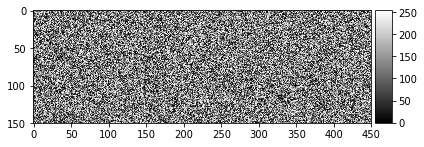

OUTPUT


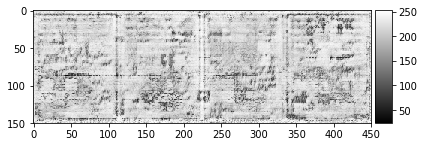

TARGET


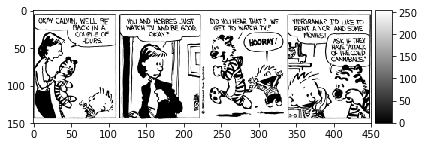

step  0 / 7367 d_loss:  0.0001298457500524819 g_loss:  [50.164467, 0.4939897, 0.7654951]
step  1 / 7367 d_loss:  0.004937106277793646 g_loss:  [52.742077, 0.5198285, 0.75922954]
step  2 / 7367 d_loss:  0.005168421659618616 g_loss:  [52.612972, 0.5187054, 0.7424296]
step  3 / 7367 d_loss:  0.0022538143675774336 g_loss:  [46.751816, 0.460333, 0.7185183]
step  4 / 7367 d_loss:  0.000792132515925914 g_loss:  [45.15323, 0.44394875, 0.7583529]
step  5 / 7367 d_loss:  0.005673693958669901 g_loss:  [52.692707, 0.5198619, 0.7065209]
step  6 / 7367 d_loss:  0.005287976935505867 g_loss:  [53.284153, 0.52590185, 0.6939657]
step  7 / 7367 d_loss:  0.0013780241133645177 g_loss:  [51.87015, 0.51109296, 0.76085556]
step  8 / 7367 d_loss:  0.012743771076202393 g_loss:  [48.948967, 0.4825735, 0.691615]
step  9 / 7367 d_loss:  0.007565106265246868 g_loss:  [52.833324, 0.5213066, 0.7026671]
step  10 / 7367 d_loss:  0.009162125177681446 g_loss:  [48.753845, 0.48017, 0.7368413]
step  11 / 7367 d_loss:  0.01

step  94 / 7367 d_loss:  0.016051005572080612 g_loss:  [44.788036, 0.43896678, 0.89135915]
step  95 / 7367 d_loss:  0.011530241928994656 g_loss:  [53.994095, 0.53077364, 0.9167336]
step  96 / 7367 d_loss:  0.013267343863844872 g_loss:  [50.727016, 0.49720207, 1.0068074]
step  97 / 7367 d_loss:  0.005921292584389448 g_loss:  [58.961884, 0.5797047, 0.9914126]
step  98 / 7367 d_loss:  0.00682894978672266 g_loss:  [55.28253, 0.541844, 1.0981306]
step  99 / 7367 d_loss:  0.003448871895670891 g_loss:  [49.067642, 0.47943524, 1.124117]
step  100 / 7367 d_loss:  0.0017886054702103138 g_loss:  [47.24985, 0.46102974, 1.146876]
step  101 / 7367 d_loss:  0.006817610003054142 g_loss:  [46.875412, 0.4571132, 1.1640923]
step  102 / 7367 d_loss:  0.009738516062498093 g_loss:  [39.84951, 0.38697916, 1.1515921]
step  103 / 7367 d_loss:  0.002057417295873165 g_loss:  [47.329815, 0.46175897, 1.15392]
step  104 / 7367 d_loss:  0.0003044232144020498 g_loss:  [50.54853, 0.49353656, 1.1948748]
step  105 / 736

step  185 / 7367 d_loss:  0.0025251954793930054 g_loss:  [48.84847, 0.47916847, 0.9316197]
step  186 / 7367 d_loss:  0.008338794112205505 g_loss:  [41.52082, 0.4058338, 0.9374383]
step  187 / 7367 d_loss:  0.002589296782389283 g_loss:  [51.585415, 0.5074229, 0.84312147]
step  188 / 7367 d_loss:  0.0023787266109138727 g_loss:  [40.272377, 0.39377695, 0.8946785]
step  189 / 7367 d_loss:  0.0015097563154995441 g_loss:  [43.118958, 0.42259932, 0.8590227]
step  190 / 7367 d_loss:  0.0009891139343380928 g_loss:  [47.03253, 0.4619868, 0.8338522]
step  191 / 7367 d_loss:  0.005602074787020683 g_loss:  [49.457413, 0.48588136, 0.8692785]
step  192 / 7367 d_loss:  0.001044497243128717 g_loss:  [54.08734, 0.53260595, 0.82674646]
step  193 / 7367 d_loss:  0.0004315453697927296 g_loss:  [39.983215, 0.391671, 0.81611466]
step  194 / 7367 d_loss:  0.0025321284774690866 g_loss:  [44.70502, 0.43882564, 0.82245743]
step  195 / 7367 d_loss:  0.0014141619903966784 g_loss:  [51.15628, 0.50313693, 0.8425848]

step  276 / 7367 d_loss:  0.004509334452450275 g_loss:  [65.37601, 0.64422065, 0.9539435]
step  277 / 7367 d_loss:  0.016823725774884224 g_loss:  [40.9199, 0.3993917, 0.9807287]
step  278 / 7367 d_loss:  0.011251932010054588 g_loss:  [49.734005, 0.4876889, 0.96511316]
step  279 / 7367 d_loss:  0.007224604953080416 g_loss:  [49.496597, 0.4848575, 1.0108474]
step  280 / 7367 d_loss:  0.007400777656584978 g_loss:  [48.76953, 0.47685903, 1.0836309]
step  281 / 7367 d_loss:  0.005915678571909666 g_loss:  [47.89543, 0.46841168, 1.0542625]
step  282 / 7367 d_loss:  0.001346840988844633 g_loss:  [59.326546, 0.5822691, 1.0996413]
step  283 / 7367 d_loss:  0.002787309465929866 g_loss:  [49.26539, 0.48141208, 1.1241797]
step  284 / 7367 d_loss:  0.0024701980873942375 g_loss:  [48.08581, 0.46914932, 1.1708812]
step  285 / 7367 d_loss:  0.0038428017869591713 g_loss:  [48.225967, 0.4712567, 1.1002967]
step  286 / 7367 d_loss:  0.011404506862163544 g_loss:  [52.37484, 0.5128, 1.0948428]
step  287 / 7

step  369 / 7367 d_loss:  0.012938114814460278 g_loss:  [47.60477, 0.46318045, 1.2867228]
step  370 / 7367 d_loss:  0.002307300688698888 g_loss:  [48.95541, 0.47624972, 1.3304371]
step  371 / 7367 d_loss:  0.04743363708257675 g_loss:  [46.276974, 0.44946268, 1.3307027]
step  372 / 7367 d_loss:  0.0038926280103623867 g_loss:  [54.190563, 0.52853376, 1.3371878]
step  373 / 7367 d_loss:  0.008416661992669106 g_loss:  [51.553513, 0.50199354, 1.3541619]
step  374 / 7367 d_loss:  0.006851652171462774 g_loss:  [62.572216, 0.6127156, 1.3006567]
step  375 / 7367 d_loss:  0.005794999189674854 g_loss:  [52.42202, 0.5115245, 1.2695693]
step  376 / 7367 d_loss:  0.013375780545175076 g_loss:  [46.63458, 0.45420647, 1.2139308]
step  377 / 7367 d_loss:  0.003074407111853361 g_loss:  [51.181664, 0.49999756, 1.1819067]
step  378 / 7367 d_loss:  0.014088891446590424 g_loss:  [107.5866, 1.0644032, 1.1462868]
step  379 / 7367 d_loss:  0.023587897419929504 g_loss:  [41.60747, 0.40594515, 1.0129533]
step  38

step  460 / 7367 d_loss:  0.018673351034522057 g_loss:  [44.09771, 0.4306936, 1.0283501]
step  461 / 7367 d_loss:  0.0005080422852188349 g_loss:  [65.17899, 0.64160323, 1.0186727]
step  462 / 7367 d_loss:  0.01680375263094902 g_loss:  [43.600857, 0.42545158, 1.0556995]
step  463 / 7367 d_loss:  0.013937847688794136 g_loss:  [41.198826, 0.40237153, 0.961673]
step  464 / 7367 d_loss:  0.0028520466294139624 g_loss:  [51.753834, 0.50762254, 0.99158007]
step  465 / 7367 d_loss:  0.0023349616676568985 g_loss:  [54.4301, 0.53424126, 1.005973]
step  466 / 7367 d_loss:  0.005221552215516567 g_loss:  [61.950047, 0.60968965, 0.981083]
step  467 / 7367 d_loss:  0.007362237200140953 g_loss:  [51.736477, 0.50772476, 0.9639994]
step  468 / 7367 d_loss:  0.008539692498743534 g_loss:  [59.86558, 0.5893925, 0.92633253]
step  469 / 7367 d_loss:  0.013895460404455662 g_loss:  [47.627724, 0.4672398, 0.903744]
step  470 / 7367 d_loss:  0.014855001121759415 g_loss:  [48.10713, 0.47252065, 0.85506505]
step  4

step  551 / 7367 d_loss:  0.0014024528209120035 g_loss:  [47.126854, 0.46118796, 1.0080583]
step  552 / 7367 d_loss:  0.0008763299556449056 g_loss:  [50.990616, 0.49894252, 1.0963646]
step  553 / 7367 d_loss:  0.00020404196402523667 g_loss:  [42.914864, 0.41818, 1.096861]
step  554 / 7367 d_loss:  0.0006707865977659822 g_loss:  [55.846203, 0.5474485, 1.1013523]
step  555 / 7367 d_loss:  0.002317283768206835 g_loss:  [45.292076, 0.44205695, 1.0863808]
step  556 / 7367 d_loss:  0.0017127342289313674 g_loss:  [49.2107, 0.481336, 1.0771012]
step  557 / 7367 d_loss:  0.010714526288211346 g_loss:  [57.116318, 0.560007, 1.1156187]
step  558 / 7367 d_loss:  0.012435452081263065 g_loss:  [42.713577, 0.41637206, 1.0763721]
step  559 / 7367 d_loss:  0.009004107676446438 g_loss:  [46.031464, 0.45003474, 1.0279882]
step  560 / 7367 d_loss:  0.01078479178249836 g_loss:  [61.08238, 0.6012658, 0.955798]
step  561 / 7367 d_loss:  0.015229369513690472 g_loss:  [48.067017, 0.47138387, 0.9286307]
step  56

step  642 / 7367 d_loss:  0.008680038154125214 g_loss:  [49.38674, 0.48705417, 0.68132275]
step  643 / 7367 d_loss:  0.007181668188422918 g_loss:  [44.34387, 0.43634018, 0.7098495]
step  644 / 7367 d_loss:  0.03222917392849922 g_loss:  [36.05944, 0.3531377, 0.74567217]
step  645 / 7367 d_loss:  0.009734905324876308 g_loss:  [50.60603, 0.49858078, 0.74795145]
step  646 / 7367 d_loss:  0.008073006756603718 g_loss:  [48.261272, 0.4752418, 0.73709023]
step  647 / 7367 d_loss:  0.004504895769059658 g_loss:  [54.074997, 0.53298163, 0.7768314]
step  648 / 7367 d_loss:  0.00654088519513607 g_loss:  [52.375546, 0.515605, 0.8150498]
step  649 / 7367 d_loss:  0.0030898316763341427 g_loss:  [46.810974, 0.46024173, 0.78680116]
step  650 / 7367 d_loss:  0.0053278980776667595 g_loss:  [50.482365, 0.4969107, 0.791295]
step  651 / 7367 d_loss:  0.007465863600373268 g_loss:  [38.24418, 0.37484127, 0.76005065]
step  652 / 7367 d_loss:  0.006164849735796452 g_loss:  [49.13399, 0.48360428, 0.7735624]
step 

step  734 / 7367 d_loss:  0.0062909796833992004 g_loss:  [59.96904, 0.59350264, 0.61877525]
step  735 / 7367 d_loss:  0.005108088254928589 g_loss:  [47.894947, 0.47297773, 0.5971765]
step  736 / 7367 d_loss:  0.023431194946169853 g_loss:  [42.013596, 0.41385788, 0.6278061]
step  737 / 7367 d_loss:  0.009706266224384308 g_loss:  [36.383537, 0.35747123, 0.6364148]
step  738 / 7367 d_loss:  0.0060929302126169205 g_loss:  [59.09367, 0.58401495, 0.6921722]
step  739 / 7367 d_loss:  0.004876123275607824 g_loss:  [51.95214, 0.51244104, 0.7080387]
step  740 / 7367 d_loss:  0.0049889166839420795 g_loss:  [53.332527, 0.5261786, 0.71466744]
step  741 / 7367 d_loss:  0.01937529817223549 g_loss:  [47.241856, 0.46516487, 0.72536963]
step  742 / 7367 d_loss:  0.008414266631007195 g_loss:  [42.421936, 0.41670558, 0.7513787]
step  743 / 7367 d_loss:  0.010744643397629261 g_loss:  [45.487225, 0.44686916, 0.8003075]
step  744 / 7367 d_loss:  0.0023105228319764137 g_loss:  [49.438904, 0.4855797, 0.8809366

step  825 / 7367 d_loss:  0.010263267904520035 g_loss:  [48.02994, 0.46996453, 1.0334886]
step  826 / 7367 d_loss:  0.00787504855543375 g_loss:  [50.385006, 0.49330348, 1.0546579]
step  827 / 7367 d_loss:  0.002607688307762146 g_loss:  [53.058617, 0.519638, 1.0948172]
step  828 / 7367 d_loss:  0.02482919953763485 g_loss:  [114.481224, 1.1331701, 1.1642052]
step  829 / 7367 d_loss:  0.016019053757190704 g_loss:  [44.034504, 0.42923495, 1.1110083]
step  830 / 7367 d_loss:  0.008126744069159031 g_loss:  [51.165176, 0.5004107, 1.1241066]
step  831 / 7367 d_loss:  0.0005338111077435315 g_loss:  [48.215256, 0.47113463, 1.1017923]
step  832 / 7367 d_loss:  0.8347938656806946 g_loss:  [36.20062, 0.352328, 0.9678182]
step  833 / 7367 d_loss:  0.0050213634967803955 g_loss:  [54.633793, 0.53732395, 0.9013992]
step  834 / 7367 d_loss:  0.00888660829514265 g_loss:  [48.383617, 0.47598287, 0.78533345]
step  835 / 7367 d_loss:  0.00971248559653759 g_loss:  [56.587837, 0.55834365, 0.75347]
step  836 /

step  917 / 7367 d_loss:  0.000443011726019904 g_loss:  [48.15028, 0.47249553, 0.9007264]
step  918 / 7367 d_loss:  0.0026560358237475157 g_loss:  [41.187428, 0.40295812, 0.8916181]
step  919 / 7367 d_loss:  0.0016246454324573278 g_loss:  [48.068314, 0.4718725, 0.8810611]
step  920 / 7367 d_loss:  0.0010828154627233744 g_loss:  [51.798508, 0.5095269, 0.8458167]
step  921 / 7367 d_loss:  0.0006321542896330357 g_loss:  [50.96262, 0.50128603, 0.8340193]
step  922 / 7367 d_loss:  0.00038625922752544284 g_loss:  [58.323223, 0.5747166, 0.8515571]
step  923 / 7367 d_loss:  0.13057392835617065 g_loss:  [34.780804, 0.33968687, 0.8121147]
step  924 / 7367 d_loss:  0.00035116460639983416 g_loss:  [46.467216, 0.45744884, 0.72233325]
step  925 / 7367 d_loss:  0.0022337024565786123 g_loss:  [49.34062, 0.48611087, 0.7295321]
step  926 / 7367 d_loss:  0.0003410919161979109 g_loss:  [54.202843, 0.5351044, 0.69240165]
step  927 / 7367 d_loss:  0.00048605920164845884 g_loss:  [55.71887, 0.55020386, 0.698

step  1008 / 7367 d_loss:  0.0026575434021651745 g_loss:  [57.287357, 0.5629789, 0.9894651]
step  1009 / 7367 d_loss:  0.0009130104444921017 g_loss:  [55.05855, 0.5411582, 0.94272864]
step  1010 / 7367 d_loss:  0.00227309949696064 g_loss:  [41.812428, 0.40881243, 0.93118435]
step  1011 / 7367 d_loss:  0.0014865017728880048 g_loss:  [52.163296, 0.51212883, 0.9504145]
step  1012 / 7367 d_loss:  0.0005781090585514903 g_loss:  [53.40983, 0.52556586, 0.8532419]
step  1013 / 7367 d_loss:  0.33363035321235657 g_loss:  [35.919716, 0.35132518, 0.7871989]
step  1014 / 7367 d_loss:  0.004306411370635033 g_loss:  [53.502064, 0.52779305, 0.7227595]
step  1015 / 7367 d_loss:  0.005265491083264351 g_loss:  [44.933456, 0.44245273, 0.6881833]
step  1016 / 7367 d_loss:  0.01198527216911316 g_loss:  [49.86646, 0.49196753, 0.6697028]
step  1017 / 7367 d_loss:  0.007558188866823912 g_loss:  [44.277145, 0.4361272, 0.6644299]
step  1018 / 7367 d_loss:  0.005905581172555685 g_loss:  [65.06595, 0.64364994, 0.7

step  1098 / 7367 d_loss:  0.020765796303749084 g_loss:  [46.592033, 0.4506495, 1.5270857]
step  1099 / 7367 d_loss:  0.029988909140229225 g_loss:  [48.45398, 0.47041157, 1.4128212]
step  1100 / 7367 d_loss:  0.012964077293872833 g_loss:  [48.71477, 0.47386447, 1.3283225]
step  1101 / 7367 d_loss:  0.011326827108860016 g_loss:  [57.980835, 0.56703955, 1.2768774]
step  1102 / 7367 d_loss:  0.04247705265879631 g_loss:  [44.08391, 0.428657, 1.2182125]
step  1103 / 7367 d_loss:  0.015088372863829136 g_loss:  [69.40769, 0.6823849, 1.1692051]
step  1104 / 7367 d_loss:  0.012094657868146896 g_loss:  [54.97214, 0.53906065, 1.0660743]
step  1105 / 7367 d_loss:  0.004459074232727289 g_loss:  [51.63893, 0.5066257, 0.97635937]
step  1106 / 7367 d_loss:  0.0014162140432745218 g_loss:  [48.143192, 0.47228453, 0.9147399]
step  1107 / 7367 d_loss:  0.0016331812366843224 g_loss:  [54.8201, 0.53930646, 0.88945365]
step  1108 / 7367 d_loss:  0.05820867046713829 g_loss:  [41.9772, 0.41187403, 0.7897985]
s

step  1189 / 7367 d_loss:  0.04467378184199333 g_loss:  [40.008137, 0.39423114, 0.58502316]
step  1190 / 7367 d_loss:  0.008707525208592415 g_loss:  [113.09106, 1.1254075, 0.5503108]
step  1191 / 7367 d_loss:  0.02603207342326641 g_loss:  [48.99879, 0.48480874, 0.517919]
step  1192 / 7367 d_loss:  0.03625810146331787 g_loss:  [48.696327, 0.4822445, 0.4718788]
step  1193 / 7367 d_loss:  0.03471891209483147 g_loss:  [56.207058, 0.5568266, 0.5243987]
step  1194 / 7367 d_loss:  0.047017134726047516 g_loss:  [50.1678, 0.49615568, 0.5522341]
step  1195 / 7367 d_loss:  0.025645418092608452 g_loss:  [44.610943, 0.4400974, 0.6012036]
step  1196 / 7367 d_loss:  0.014458115212619305 g_loss:  [52.255726, 0.51600295, 0.65543056]
step  1197 / 7367 d_loss:  0.012277220375835896 g_loss:  [51.07818, 0.5035848, 0.71969944]
step  1198 / 7367 d_loss:  0.0008270822581835091 g_loss:  [42.476692, 0.4163293, 0.8437615]
step  1199 / 7367 d_loss:  0.004812234081327915 g_loss:  [53.037067, 0.5208765, 0.9494133]


step  1281 / 7367 d_loss:  0.007097248453646898 g_loss:  [52.694176, 0.5207845, 0.6157263]
step  1282 / 7367 d_loss:  0.1944466084241867 g_loss:  [35.248257, 0.34660062, 0.58819413]
step  1283 / 7367 d_loss:  0.0006238915375433862 g_loss:  [75.04593, 0.7445045, 0.59547275]
step  1284 / 7367 d_loss:  0.00033377078943885863 g_loss:  [56.08275, 0.55508494, 0.5742547]
step  1285 / 7367 d_loss:  0.01816759817302227 g_loss:  [48.597073, 0.47999886, 0.5971863]
step  1286 / 7367 d_loss:  0.010587717406451702 g_loss:  [45.236607, 0.4463783, 0.5987792]
step  1287 / 7367 d_loss:  0.007620419841259718 g_loss:  [49.39178, 0.48795557, 0.5962259]
step  1288 / 7367 d_loss:  0.008995631709694862 g_loss:  [48.25884, 0.4762694, 0.6319024]
step  1289 / 7367 d_loss:  0.0143311507999897 g_loss:  [42.520397, 0.41851035, 0.66936266]
step  1290 / 7367 d_loss:  0.005607500206679106 g_loss:  [48.012684, 0.4735191, 0.6607748]
step  1291 / 7367 d_loss:  0.004773097578436136 g_loss:  [43.28912, 0.42623523, 0.665595

step  1372 / 7367 d_loss:  0.006773227825760841 g_loss:  [51.355164, 0.50417256, 0.93790674]
step  1373 / 7367 d_loss:  0.017115183174610138 g_loss:  [49.366726, 0.48393843, 0.9728839]
step  1374 / 7367 d_loss:  0.011288287118077278 g_loss:  [48.599293, 0.47587276, 1.0120155]
step  1375 / 7367 d_loss:  0.014831717126071453 g_loss:  [44.047848, 0.43035996, 1.0118517]
step  1376 / 7367 d_loss:  0.012272430583834648 g_loss:  [50.795418, 0.49721888, 1.073529]
step  1377 / 7367 d_loss:  0.014078207314014435 g_loss:  [50.279243, 0.49160162, 1.1190845]
step  1378 / 7367 d_loss:  0.015096403658390045 g_loss:  [50.941944, 0.4980025, 1.1416918]
step  1379 / 7367 d_loss:  0.033834777772426605 g_loss:  [60.181, 0.5901477, 1.166232]
step  1380 / 7367 d_loss:  0.2826240658760071 g_loss:  [36.780827, 0.35610554, 1.1702726]
step  1381 / 7367 d_loss:  0.03290199488401413 g_loss:  [40.51391, 0.39420357, 1.0935527]
step  1382 / 7367 d_loss:  0.014519334770739079 g_loss:  [53.325058, 0.5220973, 1.1153301]

step  1464 / 7367 d_loss:  0.026269767433404922 g_loss:  [47.111076, 0.4603498, 1.0760953]
step  1465 / 7367 d_loss:  0.01368100754916668 g_loss:  [49.20876, 0.48075622, 1.1331384]
step  1466 / 7367 d_loss:  0.012589414604008198 g_loss:  [47.448917, 0.46332476, 1.1164443]
step  1467 / 7367 d_loss:  0.025948960334062576 g_loss:  [85.576836, 0.84428126, 1.1487131]
step  1468 / 7367 d_loss:  0.010509765706956387 g_loss:  [49.65271, 0.48499623, 1.1530858]
step  1469 / 7367 d_loss:  0.014219865202903748 g_loss:  [50.222496, 0.49069437, 1.1530579]
step  1470 / 7367 d_loss:  0.03702031821012497 g_loss:  [49.665226, 0.48542237, 1.1229901]
step  1471 / 7367 d_loss:  0.012772238813340664 g_loss:  [42.932476, 0.417684, 1.164079]
step  1472 / 7367 d_loss:  0.017094232141971588 g_loss:  [62.096848, 0.6094239, 1.1544605]
step  1473 / 7367 d_loss:  0.0033426021691411734 g_loss:  [53.046688, 0.5182206, 1.2246267]
step  1474 / 7367 d_loss:  0.03507304564118385 g_loss:  [45.520645, 0.44293466, 1.2271805

step  1555 / 7367 d_loss:  0.0005691334372386336 g_loss:  [47.0002, 0.46245134, 0.75506544]
step  1556 / 7367 d_loss:  0.3419329822063446 g_loss:  [36.6581, 0.35964423, 0.69367653]
step  1557 / 7367 d_loss:  0.02212592028081417 g_loss:  [53.003506, 0.52362233, 0.64127296]
step  1558 / 7367 d_loss:  0.0043152435682713985 g_loss:  [48.628864, 0.480337, 0.5951646]
step  1559 / 7367 d_loss:  0.00025485994410701096 g_loss:  [48.900433, 0.48321792, 0.57863826]
step  1560 / 7367 d_loss:  0.002946861321106553 g_loss:  [50.1684, 0.49603143, 0.5652591]
step  1561 / 7367 d_loss:  0.0034656724892556667 g_loss:  [47.07132, 0.46472597, 0.59872264]
step  1562 / 7367 d_loss:  0.0033855631481856108 g_loss:  [48.0122, 0.47451112, 0.56108826]
step  1563 / 7367 d_loss:  0.012461026199162006 g_loss:  [43.025436, 0.4245165, 0.57378757]
step  1564 / 7367 d_loss:  0.006398757919669151 g_loss:  [44.206333, 0.4364591, 0.5604249]
step  1565 / 7367 d_loss:  0.015329541638493538 g_loss:  [42.79814, 0.4218934, 0.60

step  1647 / 7367 d_loss:  0.4762273132801056 g_loss:  [37.782223, 0.36936447, 0.84577423]
step  1648 / 7367 d_loss:  0.00426541268825531 g_loss:  [53.545425, 0.52728057, 0.8173689]
step  1649 / 7367 d_loss:  0.003981289453804493 g_loss:  [55.989727, 0.55243564, 0.7461608]
step  1650 / 7367 d_loss:  0.006821422837674618 g_loss:  [50.660202, 0.4991617, 0.7440322]
step  1651 / 7367 d_loss:  0.007561879698187113 g_loss:  [46.427357, 0.4570782, 0.7195415]
step  1652 / 7367 d_loss:  0.001532151480205357 g_loss:  [55.111393, 0.543484, 0.7629973]
step  1653 / 7367 d_loss:  0.007661579642444849 g_loss:  [50.73818, 0.49963495, 0.7746832]
step  1654 / 7367 d_loss:  0.0024530859664082527 g_loss:  [54.76835, 0.5394948, 0.818867]
step  1655 / 7367 d_loss:  0.0006518411100842059 g_loss:  [51.25464, 0.5043172, 0.822917]
step  1656 / 7367 d_loss:  0.0003363720315974206 g_loss:  [56.08854, 0.55243677, 0.8448629]
step  1657 / 7367 d_loss:  0.009878494776785374 g_loss:  [50.365902, 0.49547055, 0.8188476]

step  1738 / 7367 d_loss:  0.009124538861215115 g_loss:  [52.124523, 0.51148486, 0.9760376]
step  1739 / 7367 d_loss:  0.011295907199382782 g_loss:  [51.610283, 0.5059332, 1.0169601]
step  1740 / 7367 d_loss:  0.001747193280607462 g_loss:  [47.150314, 0.46056804, 1.0935116]
step  1741 / 7367 d_loss:  0.0011961428681388497 g_loss:  [46.64024, 0.45565975, 1.0742643]
step  1742 / 7367 d_loss:  0.09944398701190948 g_loss:  [39.37815, 0.3831048, 1.0676711]
step  1743 / 7367 d_loss:  0.0012914406834170222 g_loss:  [56.89935, 0.5580132, 1.0980287]
step  1744 / 7367 d_loss:  0.0023070096503943205 g_loss:  [48.668865, 0.4759379, 1.0750737]
step  1745 / 7367 d_loss:  0.003139955922961235 g_loss:  [45.761288, 0.4472541, 1.035877]
step  1746 / 7367 d_loss:  0.004366302862763405 g_loss:  [49.369446, 0.48302674, 1.0667715]
step  1747 / 7367 d_loss:  0.017106371000409126 g_loss:  [52.037174, 0.51052225, 0.9849518]
step  1748 / 7367 d_loss:  0.0030470245983451605 g_loss:  [42.778915, 0.41794345, 0.984

step  1828 / 7367 d_loss:  0.017360981553792953 g_loss:  [47.775253, 0.4708452, 0.6907349]
step  1829 / 7367 d_loss:  0.01999291032552719 g_loss:  [45.260193, 0.44550937, 0.7092567]
step  1830 / 7367 d_loss:  0.009656460955739021 g_loss:  [55.936123, 0.5517514, 0.7609846]
step  1831 / 7367 d_loss:  0.0034578589256852865 g_loss:  [49.0255, 0.4815542, 0.87008023]
step  1832 / 7367 d_loss:  0.008309504948556423 g_loss:  [47.464336, 0.46549717, 0.9146177]
step  1833 / 7367 d_loss:  0.0016215892974287271 g_loss:  [65.11321, 0.64145964, 0.96725047]
step  1834 / 7367 d_loss:  0.0020748202223330736 g_loss:  [47.666332, 0.4671349, 0.95284307]
step  1835 / 7367 d_loss:  0.016996078193187714 g_loss:  [40.084488, 0.3903973, 1.0447576]
step  1836 / 7367 d_loss:  0.0073411972261965275 g_loss:  [47.78241, 0.46760666, 1.0217453]
step  1837 / 7367 d_loss:  0.0007686258177272975 g_loss:  [47.99338, 0.46965185, 1.0281996]
step  1838 / 7367 d_loss:  0.001188024296425283 g_loss:  [46.723217, 0.457209, 1.00

step  1919 / 7367 d_loss:  0.0049974448047578335 g_loss:  [44.84813, 0.4441397, 0.43416393]
step  1920 / 7367 d_loss:  0.0044516162015497684 g_loss:  [48.422523, 0.48032892, 0.38963217]
step  1921 / 7367 d_loss:  0.007974382489919662 g_loss:  [55.878376, 0.5546332, 0.41505304]
step  1922 / 7367 d_loss:  0.023020992055535316 g_loss:  [55.57873, 0.55203, 0.37572703]
step  1923 / 7367 d_loss:  0.005551799200475216 g_loss:  [53.54233, 0.5317122, 0.37111148]
step  1924 / 7367 d_loss:  0.02085188217461109 g_loss:  [55.897774, 0.55529845, 0.36792803]
step  1925 / 7367 d_loss:  0.05542819947004318 g_loss:  [50.3036, 0.49906093, 0.3975064]
step  1926 / 7367 d_loss:  0.0352061502635479 g_loss:  [61.310726, 0.6090384, 0.4068846]
step  1927 / 7367 d_loss:  0.04107511788606644 g_loss:  [74.330086, 0.73872346, 0.4577417]
step  1928 / 7367 d_loss:  0.03981275483965874 g_loss:  [43.319748, 0.42759663, 0.5600863]
step  1929 / 7367 d_loss:  0.049133799970149994 g_loss:  [48.758095, 0.48149732, 0.6083628

step  2010 / 7367 d_loss:  0.028095096349716187 g_loss:  [46.472694, 0.45494473, 0.97822034]
step  2011 / 7367 d_loss:  0.023561669513583183 g_loss:  [49.96489, 0.48899016, 1.0658712]
step  2012 / 7367 d_loss:  0.009390683844685555 g_loss:  [53.535362, 0.52373636, 1.1617292]
step  2013 / 7367 d_loss:  0.009661241434514523 g_loss:  [54.27189, 0.53038585, 1.2333013]
step  2014 / 7367 d_loss:  0.015569654293358326 g_loss:  [49.360855, 0.48114353, 1.2465036]
step  2015 / 7367 d_loss:  0.005798240192234516 g_loss:  [56.128082, 0.54805917, 1.3221657]
step  2016 / 7367 d_loss:  0.007904812693595886 g_loss:  [49.544968, 0.4816332, 1.3816507]
step  2017 / 7367 d_loss:  0.003938084468245506 g_loss:  [52.84535, 0.5151504, 1.3303056]
step  2018 / 7367 d_loss:  0.01894298754632473 g_loss:  [50.80262, 0.49459964, 1.3426551]
step  2019 / 7367 d_loss:  0.013458408415317535 g_loss:  [67.16159, 0.6582406, 1.3375347]
step  2020 / 7367 d_loss:  0.00725245475769043 g_loss:  [47.79179, 0.46464625, 1.3271643

step  2100 / 7367 d_loss:  0.0019373411778360605 g_loss:  [52.133236, 0.51199645, 0.93359023]
step  2101 / 7367 d_loss:  0.0051941294223070145 g_loss:  [51.281532, 0.50335306, 0.9462266]
step  2102 / 7367 d_loss:  0.014495193026959896 g_loss:  [96.485825, 0.9554357, 0.9422551]
step  2103 / 7367 d_loss:  0.1885143518447876 g_loss:  [40.002083, 0.39166263, 0.83581984]
step  2104 / 7367 d_loss:  0.022703520953655243 g_loss:  [45.88585, 0.4509903, 0.78682137]
step  2105 / 7367 d_loss:  0.02594396099448204 g_loss:  [52.37046, 0.5162984, 0.740619]
step  2106 / 7367 d_loss:  0.02256341092288494 g_loss:  [46.682415, 0.45930988, 0.75142825]
step  2107 / 7367 d_loss:  0.027411645278334618 g_loss:  [45.947327, 0.45201558, 0.74576855]
step  2108 / 7367 d_loss:  0.013658823445439339 g_loss:  [51.163605, 0.5038119, 0.78241444]
step  2109 / 7367 d_loss:  0.007015870418399572 g_loss:  [66.37709, 0.6552354, 0.85354245]
step  2110 / 7367 d_loss:  0.01011508796364069 g_loss:  [48.665466, 0.4779455, 0.870

step  2191 / 7367 d_loss:  0.02220858447253704 g_loss:  [49.215717, 0.48477066, 0.7386501]
step  2192 / 7367 d_loss:  0.0053194076754152775 g_loss:  [52.548695, 0.5178044, 0.76825637]
step  2193 / 7367 d_loss:  0.004077630117535591 g_loss:  [57.898735, 0.57136846, 0.7618891]
step  2194 / 7367 d_loss:  0.006287814117968082 g_loss:  [83.98194, 0.83192164, 0.7897817]
step  2195 / 7367 d_loss:  0.008724265731871128 g_loss:  [47.421383, 0.46625692, 0.7956906]
step  2196 / 7367 d_loss:  0.01491182204335928 g_loss:  [58.09176, 0.5731096, 0.78079563]
step  2197 / 7367 d_loss:  0.013194561935961246 g_loss:  [51.663876, 0.50843173, 0.8207006]
step  2198 / 7367 d_loss:  0.003985308110713959 g_loss:  [72.05698, 0.711641, 0.89287347]
step  2199 / 7367 d_loss:  0.13747155666351318 g_loss:  [39.49654, 0.38612634, 0.8839062]
step  2200 / 7367 d_loss:  0.010717622935771942 g_loss:  [53.204235, 0.52308774, 0.89546186]
step  2201 / 7367 d_loss:  0.006467481143772602 g_loss:  [51.27471, 0.50411445, 0.8632

step  2283 / 7367 d_loss:  0.012638178654015064 g_loss:  [57.735992, 0.5730581, 0.43017972]
step  2284 / 7367 d_loss:  0.010430184192955494 g_loss:  [43.438663, 0.4296779, 0.4708736]
step  2285 / 7367 d_loss:  0.029305266216397285 g_loss:  [49.056435, 0.48559046, 0.49739113]
step  2286 / 7367 d_loss:  0.01688798889517784 g_loss:  [61.480663, 0.6095801, 0.522651]
step  2287 / 7367 d_loss:  0.005830035544931889 g_loss:  [42.52933, 0.41961864, 0.56746674]
step  2288 / 7367 d_loss:  0.01636580564081669 g_loss:  [52.274254, 0.5167891, 0.59534466]
step  2289 / 7367 d_loss:  0.005145584233105183 g_loss:  [48.38426, 0.47739092, 0.6451677]
step  2290 / 7367 d_loss:  0.00011398342030588537 g_loss:  [47.80107, 0.47114518, 0.6865558]
step  2291 / 7367 d_loss:  0.0178084559738636 g_loss:  [49.22229, 0.4848354, 0.7387517]
step  2292 / 7367 d_loss:  0.003910453990101814 g_loss:  [45.57504, 0.4477122, 0.8038187]
step  2293 / 7367 d_loss:  0.014097349718213081 g_loss:  [51.98275, 0.51172835, 0.8099126]

step  2374 / 7367 d_loss:  0.09258294105529785 g_loss:  [45.448776, 0.44271797, 1.1769775]
step  2375 / 7367 d_loss:  0.012373602949082851 g_loss:  [54.566757, 0.53372663, 1.1940975]
step  2376 / 7367 d_loss:  0.052983466535806656 g_loss:  [44.955868, 0.4377061, 1.185257]
step  2377 / 7367 d_loss:  0.167707622051239 g_loss:  [42.3216, 0.41179046, 1.1425563]
step  2378 / 7367 d_loss:  0.020367952063679695 g_loss:  [51.511818, 0.5039671, 1.1151098]
step  2379 / 7367 d_loss:  0.007347550243139267 g_loss:  [58.379395, 0.57326585, 1.0528103]
step  2380 / 7367 d_loss:  0.03129628300666809 g_loss:  [48.206623, 0.4711382, 1.0928051]
step  2381 / 7367 d_loss:  0.05187345668673515 g_loss:  [49.82194, 0.4880238, 1.0195621]
step  2382 / 7367 d_loss:  0.00021329469745978713 g_loss:  [52.518475, 0.51527303, 0.9911717]
step  2383 / 7367 d_loss:  0.04343011602759361 g_loss:  [48.127605, 0.47219926, 0.9076799]
step  2384 / 7367 d_loss:  0.010980716906487942 g_loss:  [57.426792, 0.5653243, 0.8943613]
st

step  2466 / 7367 d_loss:  0.0032296599820256233 g_loss:  [51.06102, 0.50664073, 0.3969449]
step  2467 / 7367 d_loss:  0.0006437746924348176 g_loss:  [47.044083, 0.46688336, 0.3557463]
step  2468 / 7367 d_loss:  0.007748058531433344 g_loss:  [51.02761, 0.50640655, 0.38695368]
step  2469 / 7367 d_loss:  0.03279382735490799 g_loss:  [48.781933, 0.483981, 0.38383272]
step  2470 / 7367 d_loss:  0.011537409387528896 g_loss:  [58.12775, 0.5771461, 0.41313985]
step  2471 / 7367 d_loss:  0.012789249420166016 g_loss:  [63.924316, 0.6349368, 0.43063512]
step  2472 / 7367 d_loss:  0.004979841876775026 g_loss:  [48.11038, 0.47679108, 0.4312701]
step  2473 / 7367 d_loss:  0.013684351928532124 g_loss:  [42.79592, 0.42311406, 0.48451653]
step  2474 / 7367 d_loss:  0.015356218442320824 g_loss:  [53.647392, 0.5310143, 0.54595834]
step  2475 / 7367 d_loss:  0.022929102182388306 g_loss:  [92.03671, 0.91502637, 0.5340734]
step  2476 / 7367 d_loss:  0.015425130724906921 g_loss:  [48.73403, 0.48127708, 0.60

step  2557 / 7367 d_loss:  0.020081007853150368 g_loss:  [54.341564, 0.53828275, 0.51329136]
step  2558 / 7367 d_loss:  0.021923912689089775 g_loss:  [43.413013, 0.4282295, 0.5900628]
step  2559 / 7367 d_loss:  0.01764870434999466 g_loss:  [43.35111, 0.4272731, 0.62379795]
step  2560 / 7367 d_loss:  0.01234095823019743 g_loss:  [43.894783, 0.43169767, 0.7250166]
step  2561 / 7367 d_loss:  0.007367064710706472 g_loss:  [50.108833, 0.49304223, 0.8046102]
step  2562 / 7367 d_loss:  0.0019238993991166353 g_loss:  [48.685783, 0.47845986, 0.8397971]
step  2563 / 7367 d_loss:  0.000952853006310761 g_loss:  [42.12122, 0.4122918, 0.8920398]
step  2564 / 7367 d_loss:  0.01759040541946888 g_loss:  [42.80835, 0.41842762, 0.96558636]
step  2565 / 7367 d_loss:  0.005366109777241945 g_loss:  [52.104206, 0.5110235, 1.0018538]
step  2566 / 7367 d_loss:  0.0017120379488915205 g_loss:  [49.179707, 0.48192233, 0.9874715]
step  2567 / 7367 d_loss:  0.0038727261126041412 g_loss:  [52.046688, 0.5103091, 1.01

step  2648 / 7367 d_loss:  0.18509483337402344 g_loss:  [42.977844, 0.42020154, 0.9576927]
step  2649 / 7367 d_loss:  0.03621966391801834 g_loss:  [57.07718, 0.56072915, 1.0042636]
step  2650 / 7367 d_loss:  0.034576792269945145 g_loss:  [51.35774, 0.50345993, 1.0117447]
step  2651 / 7367 d_loss:  0.04126565158367157 g_loss:  [57.630028, 0.5655521, 1.0748173]
step  2652 / 7367 d_loss:  0.02512523904442787 g_loss:  [72.96606, 0.7183372, 1.1323376]
step  2653 / 7367 d_loss:  0.6624900102615356 g_loss:  [40.399742, 0.393489, 1.050844]
step  2654 / 7367 d_loss:  0.041461288928985596 g_loss:  [55.644333, 0.5463376, 1.0105737]
step  2655 / 7367 d_loss:  0.03793342411518097 g_loss:  [54.648903, 0.53634894, 1.0140079]
step  2656 / 7367 d_loss:  0.04252191632986069 g_loss:  [55.836994, 0.5481247, 1.0245289]
step  2657 / 7367 d_loss:  0.08767547458410263 g_loss:  [49.1947, 0.48199174, 0.9955236]
step  2658 / 7367 d_loss:  0.055481746792793274 g_loss:  [47.710888, 0.46668807, 1.0420811]
step  265

step  2740 / 7367 d_loss:  0.035044822841882706 g_loss:  [48.956165, 0.47972864, 0.9833035]
step  2741 / 7367 d_loss:  0.059384509921073914 g_loss:  [49.275852, 0.483166, 0.95925033]
step  2742 / 7367 d_loss:  0.044113703072071075 g_loss:  [50.55774, 0.4966201, 0.8957275]
step  2743 / 7367 d_loss:  0.04861769080162048 g_loss:  [53.321625, 0.5248924, 0.83238524]
step  2744 / 7367 d_loss:  0.04904787987470627 g_loss:  [51.360214, 0.5059107, 0.7691455]
step  2745 / 7367 d_loss:  0.042591534554958344 g_loss:  [46.50897, 0.4583991, 0.6690586]
step  2746 / 7367 d_loss:  0.04142070561647415 g_loss:  [43.952103, 0.43322077, 0.630025]
step  2747 / 7367 d_loss:  0.06849461793899536 g_loss:  [42.839462, 0.42308804, 0.5306604]
step  2748 / 7367 d_loss:  0.014460744336247444 g_loss:  [55.349003, 0.5485112, 0.49788266]
step  2749 / 7367 d_loss:  0.010542909614741802 g_loss:  [49.40083, 0.4892783, 0.4730003]
step  2750 / 7367 d_loss:  0.007986899465322495 g_loss:  [51.893265, 0.514426, 0.45066297]
st

step  2832 / 7367 d_loss:  0.00634165620431304 g_loss:  [62.872387, 0.61844677, 1.0277097]
step  2833 / 7367 d_loss:  0.0063924104906618595 g_loss:  [47.194355, 0.46115968, 1.07839]
step  2834 / 7367 d_loss:  0.004420047160238028 g_loss:  [56.930725, 0.5579764, 1.1330836]
step  2835 / 7367 d_loss:  0.02404984086751938 g_loss:  [46.893593, 0.45792562, 1.1010339]
step  2836 / 7367 d_loss:  0.15194319188594818 g_loss:  [43.574955, 0.42475367, 1.0995889]
step  2837 / 7367 d_loss:  0.02004028484225273 g_loss:  [44.87407, 0.4380099, 1.0730829]
step  2838 / 7367 d_loss:  0.08214525878429413 g_loss:  [42.97591, 0.4188618, 1.0897303]
step  2839 / 7367 d_loss:  0.01731390319764614 g_loss:  [48.66905, 0.47593325, 1.0757229]
step  2840 / 7367 d_loss:  0.023869503289461136 g_loss:  [47.20668, 0.4614069, 1.0659903]
step  2841 / 7367 d_loss:  0.019550442695617676 g_loss:  [60.96264, 0.5986889, 1.0937496]
step  2842 / 7367 d_loss:  0.00040415002149529755 g_loss:  [48.111053, 0.4700133, 1.1097243]
step

step  2924 / 7367 d_loss:  0.024991776794195175 g_loss:  [53.20932, 0.5199589, 1.2134297]
step  2925 / 7367 d_loss:  0.013149876147508621 g_loss:  [53.1755, 0.51979476, 1.1960233]
step  2926 / 7367 d_loss:  0.07986374944448471 g_loss:  [43.392616, 0.42185584, 1.2070304]
step  2927 / 7367 d_loss:  0.015212886035442352 g_loss:  [56.784454, 0.5563392, 1.1505363]
step  2928 / 7367 d_loss:  0.006170306820422411 g_loss:  [53.78606, 0.52626437, 1.1596206]
step  2929 / 7367 d_loss:  0.0024204528890550137 g_loss:  [47.992725, 0.46873283, 1.1194432]
step  2930 / 7367 d_loss:  0.0025104687083512545 g_loss:  [45.96219, 0.4489496, 1.067225]
step  2931 / 7367 d_loss:  0.005625763442367315 g_loss:  [59.435516, 0.5833971, 1.095806]
step  2932 / 7367 d_loss:  0.004001655615866184 g_loss:  [55.807644, 0.54734874, 1.0727702]
step  2933 / 7367 d_loss:  0.0055063143372535706 g_loss:  [51.22558, 0.501111, 1.1144848]
step  2934 / 7367 d_loss:  0.005324543919414282 g_loss:  [57.014633, 0.5598696, 1.0276749]
s

step  3014 / 7367 d_loss:  0.00489181000739336 g_loss:  [56.393127, 0.55580264, 0.81286216]
step  3015 / 7367 d_loss:  0.004099065437912941 g_loss:  [54.99995, 0.5413878, 0.8611727]
step  3016 / 7367 d_loss:  0.006064779125154018 g_loss:  [49.337784, 0.48441526, 0.89625865]
step  3017 / 7367 d_loss:  0.01645699329674244 g_loss:  [53.42357, 0.5245385, 0.96971774]
step  3018 / 7367 d_loss:  0.004689221270382404 g_loss:  [53.31455, 0.5229265, 1.0218967]
step  3019 / 7367 d_loss:  0.6739261746406555 g_loss:  [37.58529, 0.36586437, 0.99885046]
step  3020 / 7367 d_loss:  0.004857106599956751 g_loss:  [58.29687, 0.5735085, 0.9460218]
step  3021 / 7367 d_loss:  0.017108280211687088 g_loss:  [50.150642, 0.4920455, 0.9460938]
step  3022 / 7367 d_loss:  0.008378931321203709 g_loss:  [53.302586, 0.52372414, 0.9301717]
step  3023 / 7367 d_loss:  0.014917408116161823 g_loss:  [46.70423, 0.45799398, 0.90483075]
step  3024 / 7367 d_loss:  0.0928678885102272 g_loss:  [39.319923, 0.38426295, 0.89362544]

step  3106 / 7367 d_loss:  0.01516285352408886 g_loss:  [62.260223, 0.61380386, 0.8798352]
step  3107 / 7367 d_loss:  0.01082739420235157 g_loss:  [48.52527, 0.47619015, 0.9062531]
step  3108 / 7367 d_loss:  0.008051808923482895 g_loss:  [58.380917, 0.57410973, 0.96994287]
step  3109 / 7367 d_loss:  0.011145958676934242 g_loss:  [50.7815, 0.49804884, 0.9766171]
step  3110 / 7367 d_loss:  0.0027710662689059973 g_loss:  [55.97156, 0.5495464, 1.0169169]
step  3111 / 7367 d_loss:  0.006070099771022797 g_loss:  [56.0852, 0.55029696, 1.0555037]
step  3112 / 7367 d_loss:  0.022632040083408356 g_loss:  [43.9213, 0.42879665, 1.041633]
step  3113 / 7367 d_loss:  0.002425678074359894 g_loss:  [51.07589, 0.5007844, 0.9974522]
step  3114 / 7367 d_loss:  0.004273333121091127 g_loss:  [49.14079, 0.48129275, 1.0115135]
step  3115 / 7367 d_loss:  0.0038927693385630846 g_loss:  [53.52058, 0.5251826, 1.0023187]
step  3116 / 7367 d_loss:  0.0033094778191298246 g_loss:  [61.748146, 0.6080721, 0.9409388]
st

step  3196 / 7367 d_loss:  0.0005567235057242215 g_loss:  [54.18465, 0.53267455, 0.91719437]
step  3197 / 7367 d_loss:  0.5683004260063171 g_loss:  [37.426178, 0.36652148, 0.7740296]
step  3198 / 7367 d_loss:  0.008348246105015278 g_loss:  [51.91139, 0.51200604, 0.71078455]
step  3199 / 7367 d_loss:  0.016742438077926636 g_loss:  [51.322453, 0.5064557, 0.67688006]
step  3200 / 7367 d_loss:  0.021635647863149643 g_loss:  [58.01384, 0.573852, 0.62863773]
step  3201 / 7367 d_loss:  0.015586726367473602 g_loss:  [51.663383, 0.5105471, 0.6086733]
step  3202 / 7367 d_loss:  0.023092741146683693 g_loss:  [49.004208, 0.48361024, 0.6431834]
step  3203 / 7367 d_loss:  0.015750834718346596 g_loss:  [52.230755, 0.51588815, 0.6419417]
step  3204 / 7367 d_loss:  0.6431215405464172 g_loss:  [35.75333, 0.35114568, 0.6387634]
step  3205 / 7367 d_loss:  0.0634765774011612 g_loss:  [40.39078, 0.3979832, 0.5924606]
step  3206 / 7367 d_loss:  0.01885736919939518 g_loss:  [46.589756, 0.459923, 0.5974564]
st

step  3286 / 7367 d_loss:  0.006721930578351021 g_loss:  [54.400127, 0.5360795, 0.7921742]
step  3287 / 7367 d_loss:  0.004257751163095236 g_loss:  [52.40186, 0.5160158, 0.80027926]
step  3288 / 7367 d_loss:  0.0024367324076592922 g_loss:  [43.85406, 0.4300896, 0.84510005]
step  3289 / 7367 d_loss:  0.011583661660552025 g_loss:  [53.967278, 0.53084725, 0.8825547]
step  3290 / 7367 d_loss:  0.004909250885248184 g_loss:  [44.720467, 0.4378829, 0.9321755]
step  3291 / 7367 d_loss:  0.0005731067503802478 g_loss:  [46.412563, 0.4543186, 0.9807006]
step  3292 / 7367 d_loss:  0.001182105392217636 g_loss:  [58.110256, 0.571238, 0.9864562]
step  3293 / 7367 d_loss:  0.08140396326780319 g_loss:  [42.3106, 0.4136517, 0.9454317]
step  3294 / 7367 d_loss:  0.00484574306756258 g_loss:  [45.296104, 0.44380987, 0.9151173]
step  3295 / 7367 d_loss:  0.013299827463924885 g_loss:  [110.38455, 1.0951672, 0.8678392]
step  3296 / 7367 d_loss:  0.0166639294475317 g_loss:  [46.513752, 0.4569108, 0.82267386]
s

step  3377 / 7367 d_loss:  0.013034720905125141 g_loss:  [62.872837, 0.61701345, 1.1714883]
step  3378 / 7367 d_loss:  0.3041485846042633 g_loss:  [39.671535, 0.38536918, 1.1346177]
step  3379 / 7367 d_loss:  0.010249903425574303 g_loss:  [48.8707, 0.4774778, 1.1229194]
step  3380 / 7367 d_loss:  0.011208421550691128 g_loss:  [58.358223, 0.5726386, 1.0943644]
step  3381 / 7367 d_loss:  0.012811023741960526 g_loss:  [51.21003, 0.5012662, 1.083411]
step  3382 / 7367 d_loss:  0.38578104972839355 g_loss:  [38.625885, 0.3758309, 1.0427977]
step  3383 / 7367 d_loss:  0.044888511300086975 g_loss:  [42.464462, 0.41435307, 1.0291563]
step  3384 / 7367 d_loss:  0.01168608944863081 g_loss:  [44.687767, 0.43704462, 0.98330843]
step  3385 / 7367 d_loss:  0.01021611038595438 g_loss:  [49.111195, 0.48151565, 0.959628]
step  3386 / 7367 d_loss:  0.009815733879804611 g_loss:  [57.577316, 0.56624436, 0.9528811]
step  3387 / 7367 d_loss:  0.004952971823513508 g_loss:  [52.272346, 0.51292443, 0.97990435]


step  3467 / 7367 d_loss:  0.014696392230689526 g_loss:  [45.992447, 0.45371893, 0.62055093]
step  3468 / 7367 d_loss:  0.010758169926702976 g_loss:  [59.10784, 0.5845075, 0.6570905]
step  3469 / 7367 d_loss:  0.007416847627609968 g_loss:  [53.735413, 0.53022295, 0.713114]
step  3470 / 7367 d_loss:  0.005326548591256142 g_loss:  [45.364643, 0.4461859, 0.7460565]
step  3471 / 7367 d_loss:  0.004132689442485571 g_loss:  [54.802814, 0.5404286, 0.75995564]
step  3472 / 7367 d_loss:  0.0005492264172062278 g_loss:  [45.007008, 0.44143102, 0.8639084]
step  3473 / 7367 d_loss:  0.0019687735475599766 g_loss:  [52.99124, 0.52086824, 0.90441954]
step  3474 / 7367 d_loss:  0.0018964759074151516 g_loss:  [56.6153, 0.55673045, 0.9422516]
step  3475 / 7367 d_loss:  0.01000154111534357 g_loss:  [52.149693, 0.5118392, 0.96577024]
step  3476 / 7367 d_loss:  0.0036399110686033964 g_loss:  [43.470066, 0.42492378, 0.9776877]
step  3477 / 7367 d_loss:  0.0006088517839089036 g_loss:  [53.90765, 0.5288023, 1.

step  3557 / 7367 d_loss:  0.00019801453163381666 g_loss:  [47.517273, 0.46602064, 0.9152082]
step  3558 / 7367 d_loss:  0.1589396446943283 g_loss:  [38.847603, 0.38026267, 0.8213332]
step  3559 / 7367 d_loss:  0.0016821742756292224 g_loss:  [51.68724, 0.50907594, 0.7796468]
step  3560 / 7367 d_loss:  0.03463131561875343 g_loss:  [37.99325, 0.37274867, 0.7183838]
step  3561 / 7367 d_loss:  0.018312301486730576 g_loss:  [57.203598, 0.5650218, 0.7014146]
step  3562 / 7367 d_loss:  0.016906090080738068 g_loss:  [54.62816, 0.539188, 0.7093532]
step  3563 / 7367 d_loss:  0.005946100223809481 g_loss:  [47.998096, 0.47276032, 0.7220636]
step  3564 / 7367 d_loss:  0.005714054219424725 g_loss:  [40.96359, 0.402628, 0.7007881]
step  3565 / 7367 d_loss:  0.001370058162137866 g_loss:  [58.525616, 0.5779985, 0.72576565]
step  3566 / 7367 d_loss:  0.003556501353159547 g_loss:  [61.889557, 0.61147857, 0.74169946]
step  3567 / 7367 d_loss:  0.009116909466683865 g_loss:  [52.59276, 0.5185989, 0.7328668

step  3648 / 7367 d_loss:  0.0049385614693164825 g_loss:  [72.639084, 0.7153916, 1.0999264]
step  3649 / 7367 d_loss:  0.0006763555575162172 g_loss:  [58.947025, 0.5794228, 1.0047499]
step  3650 / 7367 d_loss:  0.005903696641325951 g_loss:  [95.059814, 0.94082487, 0.97732306]
step  3651 / 7367 d_loss:  0.0059507498517632484 g_loss:  [57.26534, 0.5633809, 0.9272485]
step  3652 / 7367 d_loss:  0.016789060086011887 g_loss:  [50.30519, 0.49404955, 0.9002371]
step  3653 / 7367 d_loss:  0.012332519516348839 g_loss:  [51.307735, 0.50378716, 0.92902124]
step  3654 / 7367 d_loss:  0.015854930505156517 g_loss:  [45.706257, 0.4480909, 0.8971656]
step  3655 / 7367 d_loss:  0.027739830315113068 g_loss:  [44.217743, 0.43252933, 0.9648075]
step  3656 / 7367 d_loss:  0.008920183405280113 g_loss:  [64.88783, 0.6393791, 0.9499266]
step  3657 / 7367 d_loss:  0.008311990648508072 g_loss:  [60.58762, 0.59609, 0.9786178]
step  3658 / 7367 d_loss:  0.005646129604429007 g_loss:  [57.165493, 0.56136537, 1.0289

step  3738 / 7367 d_loss:  0.004743494559079409 g_loss:  [58.069736, 0.5708695, 0.9827833]
step  3739 / 7367 d_loss:  0.0011595555115491152 g_loss:  [54.000477, 0.53034014, 0.9664656]
step  3740 / 7367 d_loss:  5.479691390064545e-05 g_loss:  [49.828182, 0.48858657, 0.9695227]
step  3741 / 7367 d_loss:  0.0014565843157470226 g_loss:  [46.484783, 0.4556481, 0.91997355]
step  3742 / 7367 d_loss:  0.0016267213504761457 g_loss:  [48.919098, 0.48021612, 0.89748573]
step  3743 / 7367 d_loss:  0.0017748037353157997 g_loss:  [48.843395, 0.4798529, 0.85810596]
step  3744 / 7367 d_loss:  0.00021485367324203253 g_loss:  [55.88219, 0.5498791, 0.894283]
step  3745 / 7367 d_loss:  0.006439580116420984 g_loss:  [47.64846, 0.46758717, 0.8897453]
step  3746 / 7367 d_loss:  0.006338531617075205 g_loss:  [56.463528, 0.5557831, 0.8852212]
step  3747 / 7367 d_loss:  0.00021189963445067406 g_loss:  [58.781616, 0.5789464, 0.88697386]
step  3748 / 7367 d_loss:  0.0020346352830529213 g_loss:  [53.29136, 0.52405

step  3829 / 7367 d_loss:  0.013478345237672329 g_loss:  [39.9985, 0.38935348, 1.0631533]
step  3830 / 7367 d_loss:  0.0018301267409697175 g_loss:  [49.924816, 0.48841956, 1.0828589]
step  3831 / 7367 d_loss:  0.006922280415892601 g_loss:  [58.437416, 0.57315856, 1.1215572]
step  3832 / 7367 d_loss:  0.0002763264055829495 g_loss:  [78.25603, 0.7712225, 1.1337824]
step  3833 / 7367 d_loss:  0.00018292138702236116 g_loss:  [51.556126, 0.503983, 1.1578239]
step  3834 / 7367 d_loss:  0.02780102752149105 g_loss:  [40.609, 0.39452448, 1.1565512]
step  3835 / 7367 d_loss:  0.0019190114689990878 g_loss:  [48.540825, 0.47369793, 1.1710316]
step  3836 / 7367 d_loss:  0.0010610120370984077 g_loss:  [56.777252, 0.5564596, 1.1312895]
step  3837 / 7367 d_loss:  0.0007262881263159215 g_loss:  [50.46344, 0.4934813, 1.1153125]
step  3838 / 7367 d_loss:  0.005168404895812273 g_loss:  [46.15862, 0.45055187, 1.1034324]
step  3839 / 7367 d_loss:  0.0014955585356801748 g_loss:  [62.219543, 0.61154896, 1.064

step  3920 / 7367 d_loss:  0.002498212968930602 g_loss:  [55.844715, 0.54959863, 0.8848544]
step  3921 / 7367 d_loss:  7.557919161627069e-05 g_loss:  [54.007668, 0.5313257, 0.8751001]
step  3922 / 7367 d_loss:  0.004303939174860716 g_loss:  [47.307938, 0.46435386, 0.8725502]
step  3923 / 7367 d_loss:  5.191657328396104e-05 g_loss:  [47.08605, 0.46223587, 0.86246103]
step  3924 / 7367 d_loss:  0.0010196585208177567 g_loss:  [44.340923, 0.43484905, 0.8560169]
step  3925 / 7367 d_loss:  0.008111739531159401 g_loss:  [53.843792, 0.5298552, 0.85827327]
step  3926 / 7367 d_loss:  0.0005723148351535201 g_loss:  [52.85445, 0.5200336, 0.85108995]
step  3927 / 7367 d_loss:  0.00021345072309486568 g_loss:  [62.69076, 0.61805356, 0.8854079]
step  3928 / 7367 d_loss:  0.005719951819628477 g_loss:  [51.379673, 0.50476545, 0.90312886]
step  3929 / 7367 d_loss:  1.838904427131638e-05 g_loss:  [64.241844, 0.63320935, 0.9209124]
step  3930 / 7367 d_loss:  0.003708794480189681 g_loss:  [64.80195, 0.63858

step  4010 / 7367 d_loss:  0.015675347298383713 g_loss:  [44.32195, 0.43494955, 0.8269966]
step  4011 / 7367 d_loss:  0.00045270725968293846 g_loss:  [47.386894, 0.46518102, 0.8687922]
step  4012 / 7367 d_loss:  0.04510931298136711 g_loss:  [41.779972, 0.4088102, 0.898951]
step  4013 / 7367 d_loss:  0.0005816159537062049 g_loss:  [55.321854, 0.5435859, 0.96326417]
step  4014 / 7367 d_loss:  0.005843187216669321 g_loss:  [53.694523, 0.5274167, 0.9528547]
step  4015 / 7367 d_loss:  0.0054270257242023945 g_loss:  [71.5148, 0.70496166, 1.018636]
step  4016 / 7367 d_loss:  0.00387278338894248 g_loss:  [62.59155, 0.61595535, 0.9960155]
step  4017 / 7367 d_loss:  0.0030359867960214615 g_loss:  [45.749508, 0.44754168, 0.9953378]
step  4018 / 7367 d_loss:  0.0018449811032041907 g_loss:  [56.161064, 0.55174017, 0.98704576]
step  4019 / 7367 d_loss:  0.006251209881156683 g_loss:  [55.4534, 0.54474956, 0.97844315]
step  4020 / 7367 d_loss:  0.007769220042973757 g_loss:  [55.670086, 0.5472346, 0.94

step  4100 / 7367 d_loss:  0.00666307657957077 g_loss:  [51.76929, 0.50832236, 0.93705493]
step  4101 / 7367 d_loss:  0.005622359924018383 g_loss:  [68.72738, 0.6776385, 0.96353257]
step  4102 / 7367 d_loss:  0.007371691521257162 g_loss:  [53.863823, 0.52845925, 1.0178976]
step  4103 / 7367 d_loss:  0.0021774019114673138 g_loss:  [59.629623, 0.58564025, 1.0655973]
step  4104 / 7367 d_loss:  0.0011605146573856473 g_loss:  [46.846565, 0.4577198, 1.074583]
step  4105 / 7367 d_loss:  0.002387397922575474 g_loss:  [46.99504, 0.45861214, 1.133829]
step  4106 / 7367 d_loss:  0.0006578648462891579 g_loss:  [46.9693, 0.45809817, 1.1594815]
step  4107 / 7367 d_loss:  0.0018709412543103099 g_loss:  [90.52102, 0.8937039, 1.1506335]
step  4108 / 7367 d_loss:  0.0023129077162593603 g_loss:  [53.04225, 0.51842314, 1.1999353]
step  4109 / 7367 d_loss:  0.0022359401918947697 g_loss:  [43.20607, 0.42058307, 1.1477635]
step  4110 / 7367 d_loss:  0.001216093311086297 g_loss:  [53.40219, 0.52304155, 1.0980

step  4191 / 7367 d_loss:  0.004250635858625174 g_loss:  [65.74966, 0.64725673, 1.0239886]
step  4192 / 7367 d_loss:  0.005222016014158726 g_loss:  [42.47242, 0.41451183, 1.0212362]
step  4193 / 7367 d_loss:  0.00994046963751316 g_loss:  [41.877144, 0.40873677, 1.0034674]
step  4194 / 7367 d_loss:  0.008797877468168736 g_loss:  [57.7923, 0.5677128, 1.0210236]
step  4195 / 7367 d_loss:  0.004518619738519192 g_loss:  [43.760128, 0.42718622, 1.0415084]
step  4196 / 7367 d_loss:  0.005208068992942572 g_loss:  [57.08294, 0.56021714, 1.0612268]
step  4197 / 7367 d_loss:  0.028919333592057228 g_loss:  [41.741276, 0.40688643, 1.0526328]
step  4198 / 7367 d_loss:  0.00473026605322957 g_loss:  [53.728348, 0.52646345, 1.0820038]
step  4199 / 7367 d_loss:  0.007066543214023113 g_loss:  [59.10487, 0.5799761, 1.107262]
step  4200 / 7367 d_loss:  0.004470508545637131 g_loss:  [49.408146, 0.48280567, 1.1275772]
step  4201 / 7367 d_loss:  0.00931589026004076 g_loss:  [51.159794, 0.5000518, 1.1546137]
s

step  4282 / 7367 d_loss:  0.005399950314313173 g_loss:  [45.091167, 0.4422559, 0.86557955]
step  4283 / 7367 d_loss:  0.011802749708294868 g_loss:  [56.33878, 0.5547436, 0.8644207]
step  4284 / 7367 d_loss:  0.004163481295108795 g_loss:  [51.94187, 0.50984216, 0.9576587]
step  4285 / 7367 d_loss:  0.006419085431843996 g_loss:  [54.30833, 0.53310037, 0.99829376]
step  4286 / 7367 d_loss:  0.0012678122147917747 g_loss:  [51.67211, 0.50634366, 1.0377465]
step  4287 / 7367 d_loss:  0.0011924538994207978 g_loss:  [42.708504, 0.41644937, 1.063568]
step  4288 / 7367 d_loss:  0.0016900707269087434 g_loss:  [49.94924, 0.48839805, 1.1094357]
step  4289 / 7367 d_loss:  0.006816624663770199 g_loss:  [65.68291, 0.64601135, 1.0817703]
step  4290 / 7367 d_loss:  0.0048491028137505054 g_loss:  [43.430344, 0.42309004, 1.1213384]
step  4291 / 7367 d_loss:  0.0036681387573480606 g_loss:  [41.19618, 0.4012037, 1.0758102]
step  4292 / 7367 d_loss:  0.004348372109234333 g_loss:  [57.70643, 0.56661445, 1.04

step  4373 / 7367 d_loss:  0.0030984750483185053 g_loss:  [78.971695, 0.78431994, 0.53970015]
step  4374 / 7367 d_loss:  0.004208000842481852 g_loss:  [52.64157, 0.5209016, 0.5514109]
step  4375 / 7367 d_loss:  0.0010569801088422537 g_loss:  [65.90437, 0.65392685, 0.51169056]
step  4376 / 7367 d_loss:  0.0008127057808451355 g_loss:  [44.395386, 0.43831256, 0.56413037]
step  4377 / 7367 d_loss:  0.004454973619431257 g_loss:  [46.692013, 0.46146435, 0.5455795]
step  4378 / 7367 d_loss:  0.006461598444730043 g_loss:  [44.44756, 0.43900076, 0.5474852]
step  4379 / 7367 d_loss:  0.0051242997869849205 g_loss:  [46.14961, 0.45548156, 0.60145366]
step  4380 / 7367 d_loss:  0.0030256365425884724 g_loss:  [54.29067, 0.5361347, 0.677195]
step  4381 / 7367 d_loss:  0.0030265157110989094 g_loss:  [45.183506, 0.44469172, 0.7143321]
step  4382 / 7367 d_loss:  0.0007118670037016273 g_loss:  [45.334393, 0.44557196, 0.7771941]
step  4383 / 7367 d_loss:  0.009355803951621056 g_loss:  [55.26661, 0.5444498

step  4464 / 7367 d_loss:  0.008583334274590015 g_loss:  [49.229706, 0.48353317, 0.87638944]
step  4465 / 7367 d_loss:  0.0029230276122689247 g_loss:  [45.535107, 0.44689423, 0.84568346]
step  4466 / 7367 d_loss:  0.0026685036718845367 g_loss:  [55.475685, 0.54646176, 0.82951015]
step  4467 / 7367 d_loss:  0.0058941529132425785 g_loss:  [52.746185, 0.51960915, 0.7852725]
step  4468 / 7367 d_loss:  0.006966790650039911 g_loss:  [53.909523, 0.5310418, 0.8053451]
step  4469 / 7367 d_loss:  0.01350189559161663 g_loss:  [50.768684, 0.4997603, 0.79265547]
step  4470 / 7367 d_loss:  0.006752782966941595 g_loss:  [47.10887, 0.46281573, 0.8272974]
step  4471 / 7367 d_loss:  0.0035059854853898287 g_loss:  [49.079212, 0.48211864, 0.86734664]
step  4472 / 7367 d_loss:  0.003603314748033881 g_loss:  [65.835144, 0.64970034, 0.8651115]
step  4473 / 7367 d_loss:  0.00843924842774868 g_loss:  [47.799053, 0.4691268, 0.8863768]
step  4474 / 7367 d_loss:  0.022724824026226997 g_loss:  [43.68355, 0.4280226

step  4554 / 7367 d_loss:  0.0039021391421556473 g_loss:  [47.565075, 0.46432298, 1.1327772]
step  4555 / 7367 d_loss:  0.007787611335515976 g_loss:  [45.209297, 0.44097698, 1.1115979]
step  4556 / 7367 d_loss:  0.0008543042349629104 g_loss:  [53.937824, 0.52855986, 1.0818383]
step  4557 / 7367 d_loss:  0.004136788658797741 g_loss:  [52.35962, 0.51341414, 1.0182022]
step  4558 / 7367 d_loss:  0.013457613065838814 g_loss:  [44.720093, 0.43720058, 1.0000339]
step  4559 / 7367 d_loss:  0.003094939049333334 g_loss:  [47.162193, 0.46205726, 0.95646775]
step  4560 / 7367 d_loss:  0.0006746483850292861 g_loss:  [44.02442, 0.430873, 0.9371236]
step  4561 / 7367 d_loss:  0.0002763030061032623 g_loss:  [49.99115, 0.49125603, 0.8655459]
step  4562 / 7367 d_loss:  0.0033972624223679304 g_loss:  [43.970917, 0.43131298, 0.8396188]
step  4563 / 7367 d_loss:  0.011015786789357662 g_loss:  [42.387623, 0.4161063, 0.7769938]
step  4564 / 7367 d_loss:  0.003379096742719412 g_loss:  [56.454285, 0.5569837, 

step  4644 / 7367 d_loss:  0.023977503180503845 g_loss:  [41.541325, 0.40707827, 0.8335015]
step  4645 / 7367 d_loss:  0.14442960917949677 g_loss:  [38.480743, 0.37652177, 0.8285668]
step  4646 / 7367 d_loss:  0.9042233228683472 g_loss:  [34.98416, 0.34265465, 0.71869844]
step  4647 / 7367 d_loss:  0.018378688022494316 g_loss:  [46.898457, 0.4621009, 0.68836766]
step  4648 / 7367 d_loss:  0.02584432251751423 g_loss:  [48.9209, 0.48276296, 0.6446018]
step  4649 / 7367 d_loss:  0.01664707250893116 g_loss:  [47.636242, 0.4701308, 0.62316144]
step  4650 / 7367 d_loss:  0.014566341415047646 g_loss:  [50.58619, 0.49929288, 0.6569024]
step  4651 / 7367 d_loss:  0.011308983899652958 g_loss:  [51.13594, 0.5047737, 0.6585735]
step  4652 / 7367 d_loss:  0.010442149825394154 g_loss:  [52.843906, 0.5214668, 0.69722664]
step  4653 / 7367 d_loss:  0.0065995268523693085 g_loss:  [43.212654, 0.42495534, 0.7171212]
step  4654 / 7367 d_loss:  0.012223465368151665 g_loss:  [47.844078, 0.470965, 0.7475776]

step  4734 / 7367 d_loss:  0.017690889537334442 g_loss:  [48.599052, 0.4797319, 0.62586224]
step  4735 / 7367 d_loss:  0.013716408982872963 g_loss:  [47.049847, 0.46382257, 0.66759276]
step  4736 / 7367 d_loss:  0.009017711505293846 g_loss:  [40.912956, 0.4025838, 0.65457547]
step  4737 / 7367 d_loss:  0.006417948752641678 g_loss:  [41.213127, 0.40509936, 0.70318997]
step  4738 / 7367 d_loss:  0.011909326538443565 g_loss:  [51.36326, 0.5063812, 0.7251349]
step  4739 / 7367 d_loss:  0.011358603835105896 g_loss:  [49.21729, 0.4846385, 0.7534388]
step  4740 / 7367 d_loss:  0.2186451405286789 g_loss:  [37.385693, 0.3662332, 0.7623701]
step  4741 / 7367 d_loss:  0.012225084006786346 g_loss:  [54.335896, 0.5356752, 0.7683724]
step  4742 / 7367 d_loss:  0.0003767244052141905 g_loss:  [61.27292, 0.6044338, 0.8295391]
step  4743 / 7367 d_loss:  0.001103874295949936 g_loss:  [48.470787, 0.4764372, 0.8270628]
step  4744 / 7367 d_loss:  0.003230694681406021 g_loss:  [54.473484, 0.5361532, 0.858167

step  4824 / 7367 d_loss:  0.003842756152153015 g_loss:  [47.122246, 0.46252704, 0.8695416]
step  4825 / 7367 d_loss:  0.02050570398569107 g_loss:  [41.4066, 0.4052609, 0.8805117]
step  4826 / 7367 d_loss:  0.0005009925807826221 g_loss:  [43.875633, 0.43005463, 0.8701713]
step  4827 / 7367 d_loss:  0.3238077163696289 g_loss:  [36.524963, 0.35718313, 0.806654]
step  4828 / 7367 d_loss:  0.001913673710078001 g_loss:  [64.53618, 0.6375274, 0.78343695]
step  4829 / 7367 d_loss:  0.002033023629337549 g_loss:  [74.68738, 0.7393258, 0.7548007]
step  4830 / 7367 d_loss:  0.003357396926730871 g_loss:  [54.89152, 0.5414617, 0.74535114]
step  4831 / 7367 d_loss:  0.0033517887350171804 g_loss:  [52.460995, 0.51720756, 0.740237]
step  4832 / 7367 d_loss:  0.005647843237966299 g_loss:  [52.029682, 0.5128367, 0.7460142]
step  4833 / 7367 d_loss:  0.00744070066139102 g_loss:  [43.725388, 0.42968744, 0.7566466]
step  4834 / 7367 d_loss:  0.0020622287411242723 g_loss:  [57.36237, 0.5656603, 0.79634196]


step  4915 / 7367 d_loss:  0.010954011231660843 g_loss:  [60.795532, 0.5974552, 1.0500097]
step  4916 / 7367 d_loss:  0.002108787652105093 g_loss:  [43.981625, 0.4292092, 1.0607038]
step  4917 / 7367 d_loss:  0.0029975585639476776 g_loss:  [50.338787, 0.4925985, 1.078937]
step  4918 / 7367 d_loss:  0.01633301004767418 g_loss:  [44.760048, 0.43663067, 1.0969806]
step  4919 / 7367 d_loss:  0.0066079022362828255 g_loss:  [56.64611, 0.5555066, 1.0954499]
step  4920 / 7367 d_loss:  0.006521685980260372 g_loss:  [50.226303, 0.4910978, 1.1165249]
step  4921 / 7367 d_loss:  0.01667674072086811 g_loss:  [55.49461, 0.5437421, 1.1203984]
step  4922 / 7367 d_loss:  0.012846825644373894 g_loss:  [49.937344, 0.488357, 1.1016419]
step  4923 / 7367 d_loss:  0.010816169902682304 g_loss:  [62.487015, 0.6136046, 1.1265544]
step  4924 / 7367 d_loss:  0.022045180201530457 g_loss:  [49.644833, 0.48528257, 1.1165766]
step  4925 / 7367 d_loss:  0.015420212410390377 g_loss:  [54.03746, 0.52913535, 1.1239244]
s

step  5006 / 7367 d_loss:  0.0018465962493792176 g_loss:  [56.617126, 0.55768657, 0.84847057]
step  5007 / 7367 d_loss:  0.0008796239853836596 g_loss:  [53.464622, 0.5259859, 0.8660311]
step  5008 / 7367 d_loss:  0.002154950052499771 g_loss:  [51.97981, 0.5111713, 0.8626828]
step  5009 / 7367 d_loss:  0.0011137770488858223 g_loss:  [50.659508, 0.49805412, 0.8540944]
step  5010 / 7367 d_loss:  0.0010178275406360626 g_loss:  [60.715733, 0.5985309, 0.8626428]
step  5011 / 7367 d_loss:  0.002058178186416626 g_loss:  [50.78394, 0.49921355, 0.8625826]
step  5012 / 7367 d_loss:  0.001633552834391594 g_loss:  [46.49664, 0.4564702, 0.8496223]
step  5013 / 7367 d_loss:  0.002176513196900487 g_loss:  [51.43917, 0.506099, 0.82927346]
step  5014 / 7367 d_loss:  0.00150846887845546 g_loss:  [52.56008, 0.5172176, 0.83832705]
step  5015 / 7367 d_loss:  0.019045040011405945 g_loss:  [40.56427, 0.39699295, 0.8649753]
step  5016 / 7367 d_loss:  0.00021234661107882857 g_loss:  [42.678272, 0.4183033, 0.847

step  5097 / 7367 d_loss:  0.032679080963134766 g_loss:  [37.796406, 0.3705805, 0.7383585]
step  5098 / 7367 d_loss:  0.013356724753975868 g_loss:  [48.483765, 0.47756556, 0.7272083]
step  5099 / 7367 d_loss:  0.006474528461694717 g_loss:  [54.42317, 0.5365968, 0.76349205]
step  5100 / 7367 d_loss:  0.09126351028680801 g_loss:  [38.699615, 0.37923536, 0.776081]
step  5101 / 7367 d_loss:  0.010387486778199673 g_loss:  [47.09075, 0.46317893, 0.77285624]
step  5102 / 7367 d_loss:  0.011715845204889774 g_loss:  [43.626747, 0.427966, 0.8301465]
step  5103 / 7367 d_loss:  0.0138823501765728 g_loss:  [57.841545, 0.56993794, 0.84775174]
step  5104 / 7367 d_loss:  0.011345448903739452 g_loss:  [40.295803, 0.39382088, 0.91371405]
step  5105 / 7367 d_loss:  0.002422069199383259 g_loss:  [59.147587, 0.58197635, 0.9499512]
step  5106 / 7367 d_loss:  0.0017730066319927573 g_loss:  [52.172935, 0.5120257, 0.97036314]
step  5107 / 7367 d_loss:  0.0006178556941449642 g_loss:  [52.279167, 0.512565, 1.022

step  5188 / 7367 d_loss:  0.0037417192943394184 g_loss:  [64.16543, 0.63164675, 1.0007516]
step  5189 / 7367 d_loss:  0.01408726442605257 g_loss:  [44.656837, 0.43709272, 0.94756556]
step  5190 / 7367 d_loss:  0.00493729580193758 g_loss:  [53.89988, 0.5294978, 0.95010126]
step  5191 / 7367 d_loss:  0.002888138173148036 g_loss:  [49.72466, 0.48794734, 0.92992586]
step  5192 / 7367 d_loss:  0.0003275490889791399 g_loss:  [48.73591, 0.4781682, 0.91908926]
step  5193 / 7367 d_loss:  0.0009054076508618891 g_loss:  [52.62493, 0.5167528, 0.94965315]
step  5194 / 7367 d_loss:  0.06372441351413727 g_loss:  [41.31293, 0.4038731, 0.9256227]
step  5195 / 7367 d_loss:  0.00598467793315649 g_loss:  [104.59967, 1.0369483, 0.904835]
step  5196 / 7367 d_loss:  0.005530972965061665 g_loss:  [48.31308, 0.4740606, 0.907022]
step  5197 / 7367 d_loss:  0.004177512601017952 g_loss:  [48.965027, 0.4805897, 0.90606064]
step  5198 / 7367 d_loss:  0.0034684943966567516 g_loss:  [53.061684, 0.5220486, 0.85682285

step  5278 / 7367 d_loss:  0.48063334822654724 g_loss:  [35.073902, 0.344536, 0.6203005]
step  5279 / 7367 d_loss:  0.0073388684540987015 g_loss:  [53.261787, 0.52689385, 0.57240474]
step  5280 / 7367 d_loss:  0.007191030774265528 g_loss:  [66.01339, 0.6545341, 0.5599851]
step  5281 / 7367 d_loss:  0.013991745188832283 g_loss:  [49.411186, 0.4885724, 0.55394775]
step  5282 / 7367 d_loss:  0.02080640383064747 g_loss:  [51.19682, 0.5061259, 0.5842248]
step  5283 / 7367 d_loss:  0.01756702922284603 g_loss:  [48.281494, 0.47680858, 0.6006356]
step  5284 / 7367 d_loss:  0.02206376940011978 g_loss:  [55.830425, 0.55179965, 0.65045893]
step  5285 / 7367 d_loss:  0.0108586885035038 g_loss:  [48.00381, 0.47325823, 0.67798847]
step  5286 / 7367 d_loss:  0.0109940180554986 g_loss:  [66.57887, 0.65817076, 0.7617927]
step  5287 / 7367 d_loss:  0.05657827854156494 g_loss:  [59.02064, 0.58227444, 0.7931966]
step  5288 / 7367 d_loss:  0.004549291916191578 g_loss:  [40.28187, 0.39414388, 0.8674853]
ste

step  5368 / 7367 d_loss:  0.007886973209679127 g_loss:  [41.41463, 0.40488118, 0.92651427]
step  5369 / 7367 d_loss:  0.009549463167786598 g_loss:  [46.290222, 0.4535354, 0.9366785]
step  5370 / 7367 d_loss:  0.007674077991396189 g_loss:  [45.074615, 0.4412912, 0.9454966]
step  5371 / 7367 d_loss:  0.008508620783686638 g_loss:  [52.625313, 0.51666653, 0.958662]
step  5372 / 7367 d_loss:  0.006228968966752291 g_loss:  [50.16232, 0.49136192, 1.0261275]
step  5373 / 7367 d_loss:  0.12278418987989426 g_loss:  [38.3013, 0.37296876, 1.0044259]
step  5374 / 7367 d_loss:  0.01276628952473402 g_loss:  [43.3407, 0.4229702, 1.0436776]
step  5375 / 7367 d_loss:  0.0027664173394441605 g_loss:  [57.157494, 0.5612463, 1.032868]
step  5376 / 7367 d_loss:  0.0004987165448255837 g_loss:  [50.539238, 0.49484456, 1.0547825]
step  5377 / 7367 d_loss:  0.0014035968342795968 g_loss:  [69.82345, 0.68742937, 1.0805112]
step  5378 / 7367 d_loss:  0.012252561748027802 g_loss:  [41.288883, 0.40193355, 1.0955278]

step  5459 / 7367 d_loss:  0.011931695975363255 g_loss:  [42.71104, 0.41615465, 1.0955719]
step  5460 / 7367 d_loss:  0.00027509330539032817 g_loss:  [51.715343, 0.5060041, 1.1149334]
step  5461 / 7367 d_loss:  0.002534502185881138 g_loss:  [50.17547, 0.49082187, 1.0932804]
step  5462 / 7367 d_loss:  0.000987769104540348 g_loss:  [46.98229, 0.45896295, 1.0859959]
step  5463 / 7367 d_loss:  0.02522113546729088 g_loss:  [48.58055, 0.47493416, 1.0871371]
step  5464 / 7367 d_loss:  0.0076051559299230576 g_loss:  [49.349567, 0.4826785, 1.0817199]
step  5465 / 7367 d_loss:  0.0025459311436861753 g_loss:  [48.88885, 0.47858012, 1.0308373]
step  5466 / 7367 d_loss:  0.007897738367319107 g_loss:  [47.08897, 0.4608154, 1.0074326]
step  5467 / 7367 d_loss:  0.005463336128741503 g_loss:  [53.91823, 0.5293811, 0.9801191]
step  5468 / 7367 d_loss:  0.0017316782614216208 g_loss:  [48.16839, 0.4722515, 0.94323546]
step  5469 / 7367 d_loss:  0.001448155613616109 g_loss:  [52.991184, 0.5205693, 0.934252

step  5549 / 7367 d_loss:  0.0033085085451602936 g_loss:  [47.889355, 0.47180885, 0.70846933]
step  5550 / 7367 d_loss:  0.00047664405428804457 g_loss:  [84.22972, 0.83513147, 0.71657735]
step  5551 / 7367 d_loss:  0.00013717537513002753 g_loss:  [56.160442, 0.55412346, 0.74809694]
step  5552 / 7367 d_loss:  0.005161707289516926 g_loss:  [57.214455, 0.56457186, 0.75726897]
step  5553 / 7367 d_loss:  0.0014143915614113212 g_loss:  [44.052246, 0.43243682, 0.8085628]
step  5554 / 7367 d_loss:  0.004312471486628056 g_loss:  [45.129585, 0.44326293, 0.803292]
step  5555 / 7367 d_loss:  0.0019491704879328609 g_loss:  [52.443737, 0.5157092, 0.87281424]
step  5556 / 7367 d_loss:  0.003881707787513733 g_loss:  [55.62711, 0.54732203, 0.89490324]
step  5557 / 7367 d_loss:  0.003884420730173588 g_loss:  [51.13343, 0.5023673, 0.89669675]
step  5558 / 7367 d_loss:  0.002258734544739127 g_loss:  [51.104446, 0.50169736, 0.93471104]
step  5559 / 7367 d_loss:  0.35979393124580383 g_loss:  [37.112614, 0.3

step  5640 / 7367 d_loss:  0.0008570603677071631 g_loss:  [49.592453, 0.48411152, 1.1812992]
step  5641 / 7367 d_loss:  0.0008955285302363336 g_loss:  [47.428833, 0.46263304, 1.1655256]
step  5642 / 7367 d_loss:  0.0015795141225680709 g_loss:  [57.14158, 0.5597751, 1.1640676]
step  5643 / 7367 d_loss:  0.0003527043154463172 g_loss:  [63.078056, 0.6189886, 1.1791984]
step  5644 / 7367 d_loss:  0.0036519465502351522 g_loss:  [50.208794, 0.49015626, 1.1931684]
step  5645 / 7367 d_loss:  0.0003751005860976875 g_loss:  [53.74314, 0.5256714, 1.1759987]
step  5646 / 7367 d_loss:  0.006899190600961447 g_loss:  [59.477837, 0.5832847, 1.1493673]
step  5647 / 7367 d_loss:  0.005446283146739006 g_loss:  [55.82217, 0.54635286, 1.1868857]
step  5648 / 7367 d_loss:  0.021884026005864143 g_loss:  [43.041103, 0.4195001, 1.0910923]
step  5649 / 7367 d_loss:  0.0013491706922650337 g_loss:  [59.815968, 0.5874863, 1.067335]
step  5650 / 7367 d_loss:  0.005054759327322245 g_loss:  [49.006927, 0.47949746, 1.

step  5731 / 7367 d_loss:  0.007748967502266169 g_loss:  [44.779755, 0.442168, 0.5629547]
step  5732 / 7367 d_loss:  0.024946611374616623 g_loss:  [46.93634, 0.463557, 0.58064014]
step  5733 / 7367 d_loss:  0.01647798717021942 g_loss:  [46.154606, 0.45563293, 0.59131104]
step  5734 / 7367 d_loss:  0.01923716627061367 g_loss:  [50.760296, 0.5014417, 0.61612415]
step  5735 / 7367 d_loss:  0.17259682714939117 g_loss:  [37.270035, 0.36687714, 0.5823209]
step  5736 / 7367 d_loss:  0.02854233607649803 g_loss:  [46.88877, 0.46314773, 0.573998]
step  5737 / 7367 d_loss:  0.01323333103209734 g_loss:  [42.95025, 0.4234775, 0.6024958]
step  5738 / 7367 d_loss:  0.02194354310631752 g_loss:  [47.856384, 0.47231913, 0.6244724]
step  5739 / 7367 d_loss:  0.027852874249219894 g_loss:  [45.84948, 0.45180643, 0.668837]
step  5740 / 7367 d_loss:  0.022364797070622444 g_loss:  [57.59551, 0.5686495, 0.730559]
step  5741 / 7367 d_loss:  0.018715359270572662 g_loss:  [49.68038, 0.48904705, 0.77567554]
step  

step  5821 / 7367 d_loss:  0.0013088181149214506 g_loss:  [52.525154, 0.51538086, 0.98706686]
step  5822 / 7367 d_loss:  0.001064010662958026 g_loss:  [51.945854, 0.5095682, 0.9890328]
step  5823 / 7367 d_loss:  0.015600789338350296 g_loss:  [49.35471, 0.4839248, 0.9622305]
step  5824 / 7367 d_loss:  0.007894118316471577 g_loss:  [57.076324, 0.56132287, 0.9440376]
step  5825 / 7367 d_loss:  0.0022221063263714314 g_loss:  [55.6781, 0.54737014, 0.94108427]
step  5826 / 7367 d_loss:  0.0012736237840726972 g_loss:  [56.369663, 0.55425376, 0.9442847]
step  5827 / 7367 d_loss:  0.015548724681138992 g_loss:  [48.797577, 0.47880435, 0.91714066]
step  5828 / 7367 d_loss:  0.006951259449124336 g_loss:  [50.67089, 0.49749362, 0.92152613]
step  5829 / 7367 d_loss:  0.0014582800213247538 g_loss:  [53.51744, 0.5261261, 0.9048306]
step  5830 / 7367 d_loss:  0.0004468852421268821 g_loss:  [45.638523, 0.44724092, 0.91443074]
step  5831 / 7367 d_loss:  0.003217229386791587 g_loss:  [91.65122, 0.9071662,

step  5912 / 7367 d_loss:  0.002750360406935215 g_loss:  [48.234283, 0.47488436, 0.74584454]
step  5913 / 7367 d_loss:  0.013573426753282547 g_loss:  [45.210476, 0.4446365, 0.746828]
step  5914 / 7367 d_loss:  0.005306634120643139 g_loss:  [47.730267, 0.46957198, 0.7730664]
step  5915 / 7367 d_loss:  0.008182678371667862 g_loss:  [51.207996, 0.5042794, 0.7800601]
step  5916 / 7367 d_loss:  0.005796939600259066 g_loss:  [44.260727, 0.43462747, 0.79798007]
step  5917 / 7367 d_loss:  0.0046807024627923965 g_loss:  [49.71578, 0.48882535, 0.8332435]
step  5918 / 7367 d_loss:  0.0009731226018629968 g_loss:  [53.058624, 0.5219826, 0.86036384]
step  5919 / 7367 d_loss:  0.038692642003297806 g_loss:  [43.681683, 0.42814985, 0.86669797]
step  5920 / 7367 d_loss:  0.0033125390764325857 g_loss:  [49.542606, 0.4866765, 0.8749528]
step  5921 / 7367 d_loss:  0.002805746393278241 g_loss:  [52.446705, 0.5158162, 0.8650847]
step  5922 / 7367 d_loss:  0.00022776472906116396 g_loss:  [50.331833, 0.4945879

step  6002 / 7367 d_loss:  0.004319851286709309 g_loss:  [50.778816, 0.4946295, 1.3158641]
step  6003 / 7367 d_loss:  0.053255051374435425 g_loss:  [40.584854, 0.39248908, 1.3359458]
step  6004 / 7367 d_loss:  0.0033618086017668247 g_loss:  [52.017097, 0.5069589, 1.3212103]
step  6005 / 7367 d_loss:  0.04151719808578491 g_loss:  [40.882317, 0.3956887, 1.3134456]
step  6006 / 7367 d_loss:  0.021795425564050674 g_loss:  [43.794895, 0.4252911, 1.2657835]
step  6007 / 7367 d_loss:  0.02176905982196331 g_loss:  [43.00684, 0.41740936, 1.2659045]
step  6008 / 7367 d_loss:  0.01571078784763813 g_loss:  [52.68965, 0.51492244, 1.1974057]
step  6009 / 7367 d_loss:  0.7039946913719177 g_loss:  [36.668262, 0.35545555, 1.1227057]
step  6010 / 7367 d_loss:  0.02954120934009552 g_loss:  [48.562565, 0.47510684, 1.0518798]
step  6011 / 7367 d_loss:  0.025096898898482323 g_loss:  [47.57418, 0.46588662, 0.9855192]
step  6012 / 7367 d_loss:  0.02849777787923813 g_loss:  [56.130756, 0.5515714, 0.97361463]
s

step  6093 / 7367 d_loss:  0.011361552402377129 g_loss:  [58.95986, 0.5811743, 0.842429]
step  6094 / 7367 d_loss:  0.03330264985561371 g_loss:  [42.68129, 0.41879317, 0.8019697]
step  6095 / 7367 d_loss:  0.004585444461554289 g_loss:  [59.658924, 0.5884686, 0.8120612]
step  6096 / 7367 d_loss:  0.1657375693321228 g_loss:  [40.824005, 0.40057987, 0.7660187]
step  6097 / 7367 d_loss:  0.003534926800057292 g_loss:  [52.333126, 0.5160377, 0.729354]
step  6098 / 7367 d_loss:  0.006170784588903189 g_loss:  [49.03817, 0.4831848, 0.7196879]
step  6099 / 7367 d_loss:  1.2984033823013306 g_loss:  [35.01169, 0.3435159, 0.6600997]
step  6100 / 7367 d_loss:  0.014726839028298855 g_loss:  [58.52734, 0.5795783, 0.56951135]
step  6101 / 7367 d_loss:  0.006545899901539087 g_loss:  [66.69652, 0.6615759, 0.5389278]
step  6102 / 7367 d_loss:  0.07225354015827179 g_loss:  [52.380047, 0.5185956, 0.5204883]
step  6103 / 7367 d_loss:  0.03437500074505806 g_loss:  [46.65527, 0.46113792, 0.54147846]
step  6104

step  6183 / 7367 d_loss:  0.04165833443403244 g_loss:  [39.21289, 0.3829639, 0.9164987]
step  6184 / 7367 d_loss:  0.0009337521623820066 g_loss:  [54.311802, 0.5341987, 0.8919327]
step  6185 / 7367 d_loss:  0.007308249827474356 g_loss:  [57.673855, 0.567966, 0.87725556]
step  6186 / 7367 d_loss:  0.10418972373008728 g_loss:  [40.4307, 0.3958226, 0.8484378]
step  6187 / 7367 d_loss:  0.0013986413832753897 g_loss:  [51.52537, 0.5070838, 0.8169924]
step  6188 / 7367 d_loss:  0.0004748398205265403 g_loss:  [59.88945, 0.5909605, 0.7934]
step  6189 / 7367 d_loss:  0.01044282503426075 g_loss:  [64.21682, 0.6346228, 0.75453657]
step  6190 / 7367 d_loss:  0.0015420247800648212 g_loss:  [51.141376, 0.50385845, 0.7555305]
step  6191 / 7367 d_loss:  0.024098005145788193 g_loss:  [48.13317, 0.47352502, 0.78066826]
step  6192 / 7367 d_loss:  0.019849706441164017 g_loss:  [40.86391, 0.40072286, 0.79162747]
step  6193 / 7367 d_loss:  0.0012640922795981169 g_loss:  [60.741154, 0.59953403, 0.78774965]


step  6273 / 7367 d_loss:  0.006283457390964031 g_loss:  [44.27105, 0.43465087, 0.80596185]
step  6274 / 7367 d_loss:  0.006020526867359877 g_loss:  [55.959206, 0.55176306, 0.7828986]
step  6275 / 7367 d_loss:  0.015640966594219208 g_loss:  [51.21074, 0.50426865, 0.7838744]
step  6276 / 7367 d_loss:  0.026489276438951492 g_loss:  [38.098625, 0.3731217, 0.78645515]
step  6277 / 7367 d_loss:  0.013607639819383621 g_loss:  [41.197975, 0.40401164, 0.7968102]
step  6278 / 7367 d_loss:  0.010722964070737362 g_loss:  [46.42188, 0.4558967, 0.8322072]
step  6279 / 7367 d_loss:  0.007180394604802132 g_loss:  [46.251347, 0.45376226, 0.8751217]
step  6280 / 7367 d_loss:  0.014565606601536274 g_loss:  [46.476208, 0.45561007, 0.9151991]
step  6281 / 7367 d_loss:  0.0042526558972895145 g_loss:  [51.419132, 0.5047214, 0.94698983]
step  6282 / 7367 d_loss:  0.00564719270914793 g_loss:  [52.24189, 0.5125523, 0.9866545]
step  6283 / 7367 d_loss:  0.005525543354451656 g_loss:  [51.43348, 0.50402534, 1.030

step  6363 / 7367 d_loss:  0.0036368235014379025 g_loss:  [48.80164, 0.4784043, 0.9612096]
step  6364 / 7367 d_loss:  0.0004872406425420195 g_loss:  [49.372684, 0.48416448, 0.956236]
step  6365 / 7367 d_loss:  0.003954342100769281 g_loss:  [50.83074, 0.49889687, 0.9410572]
step  6366 / 7367 d_loss:  0.002411024644970894 g_loss:  [51.406033, 0.50493777, 0.91225255]
step  6367 / 7367 d_loss:  0.00039869867032393813 g_loss:  [47.63732, 0.46714208, 0.92311466]
step  6368 / 7367 d_loss:  0.004940556362271309 g_loss:  [55.672535, 0.54758626, 0.91391146]
step  6369 / 7367 d_loss:  0.0038131708279252052 g_loss:  [45.513725, 0.44584906, 0.92881715]
step  6370 / 7367 d_loss:  0.0020944615826010704 g_loss:  [45.992695, 0.45067015, 0.92567843]
step  6371 / 7367 d_loss:  0.004066565074026585 g_loss:  [60.790543, 0.59859747, 0.930799]
step  6372 / 7367 d_loss:  0.28534236550331116 g_loss:  [36.735634, 0.35868785, 0.86684614]
step  6373 / 7367 d_loss:  0.004304185509681702 g_loss:  [42.16369, 0.41336

step  6453 / 7367 d_loss:  0.0018238169141113758 g_loss:  [60.437046, 0.5944142, 0.99562883]
step  6454 / 7367 d_loss:  0.0026866993866860867 g_loss:  [47.442947, 0.46419922, 1.0230261]
step  6455 / 7367 d_loss:  0.0015232526930049062 g_loss:  [57.48811, 0.5644674, 1.0413756]
step  6456 / 7367 d_loss:  0.0013302138540893793 g_loss:  [54.976063, 0.53888786, 1.0872777]
step  6457 / 7367 d_loss:  0.003654149128124118 g_loss:  [41.78589, 0.40670207, 1.1156791]
step  6458 / 7367 d_loss:  0.0006929130759090185 g_loss:  [45.08032, 0.4394393, 1.1363868]
step  6459 / 7367 d_loss:  0.0021455264650285244 g_loss:  [48.55896, 0.47430897, 1.1280628]
step  6460 / 7367 d_loss:  0.0005132683436386287 g_loss:  [44.621574, 0.43475237, 1.1463343]
step  6461 / 7367 d_loss:  0.02283007837831974 g_loss:  [76.92913, 0.75826305, 1.1028286]
step  6462 / 7367 d_loss:  0.00041705372859723866 g_loss:  [49.250183, 0.48114675, 1.135509]
step  6463 / 7367 d_loss:  0.006760474294424057 g_loss:  [44.06501, 0.42923868, 

step  6543 / 7367 d_loss:  0.0013005544897168875 g_loss:  [47.82148, 0.46715578, 1.1058986]
step  6544 / 7367 d_loss:  0.008830955252051353 g_loss:  [45.432053, 0.4429032, 1.1417346]
step  6545 / 7367 d_loss:  0.006955383345484734 g_loss:  [41.261646, 0.40096793, 1.1648529]
step  6546 / 7367 d_loss:  0.015139913186430931 g_loss:  [58.959503, 0.57812446, 1.1470578]
step  6547 / 7367 d_loss:  0.012976190075278282 g_loss:  [58.113403, 0.5699329, 1.1201153]
step  6548 / 7367 d_loss:  0.01184854656457901 g_loss:  [49.67411, 0.48595393, 1.0787166]
step  6549 / 7367 d_loss:  0.008896218612790108 g_loss:  [56.479736, 0.55479395, 1.0003402]
step  6550 / 7367 d_loss:  0.004436243325471878 g_loss:  [46.471478, 0.45508224, 0.9632528]
step  6551 / 7367 d_loss:  0.004678921774029732 g_loss:  [53.482117, 0.52576077, 0.906041]
step  6552 / 7367 d_loss:  0.0009141635382547975 g_loss:  [49.40497, 0.48551342, 0.85362804]
step  6553 / 7367 d_loss:  0.23458215594291687 g_loss:  [34.709755, 0.339442, 0.7655

step  6634 / 7367 d_loss:  0.0017333338037133217 g_loss:  [42.666943, 0.4153251, 1.1344323]
step  6635 / 7367 d_loss:  0.0021445921156555414 g_loss:  [43.1009, 0.4196257, 1.1383299]
step  6636 / 7367 d_loss:  0.01335114985704422 g_loss:  [47.628906, 0.46513462, 1.1154424]
step  6637 / 7367 d_loss:  0.002146968152374029 g_loss:  [56.44532, 0.5539488, 1.0504378]
step  6638 / 7367 d_loss:  0.00015067959611769766 g_loss:  [45.055077, 0.44014817, 1.0402611]
step  6639 / 7367 d_loss:  0.009997815825045109 g_loss:  [44.424416, 0.43401667, 1.022746]
step  6640 / 7367 d_loss:  0.0002687889209482819 g_loss:  [50.424683, 0.4942217, 1.0025157]
step  6641 / 7367 d_loss:  0.0017480531241744757 g_loss:  [48.108852, 0.47109646, 0.9992071]
step  6642 / 7367 d_loss:  0.006701753940433264 g_loss:  [53.399258, 0.52416426, 0.9828308]
step  6643 / 7367 d_loss:  0.002143522258847952 g_loss:  [46.126556, 0.45140368, 0.98618555]
step  6644 / 7367 d_loss:  0.0454128123819828 g_loss:  [37.5954, 0.366233, 0.97210

step  6725 / 7367 d_loss:  0.0009031382505781949 g_loss:  [47.63609, 0.4659405, 1.0420384]
step  6726 / 7367 d_loss:  0.00025857804575935006 g_loss:  [45.582016, 0.44501546, 1.0804727]
step  6727 / 7367 d_loss:  0.005118068307638168 g_loss:  [52.514797, 0.51419014, 1.0957823]
step  6728 / 7367 d_loss:  0.0014619887806475163 g_loss:  [43.128403, 0.42006788, 1.1216156]
step  6729 / 7367 d_loss:  0.00702898483723402 g_loss:  [56.11794, 0.54986227, 1.131715]
step  6730 / 7367 d_loss:  0.002042151754721999 g_loss:  [46.215195, 0.45098478, 1.1167189]
step  6731 / 7367 d_loss:  0.010837498120963573 g_loss:  [48.825516, 0.47740382, 1.0851322]
step  6732 / 7367 d_loss:  0.0022163342218846083 g_loss:  [45.165916, 0.44094443, 1.0714722]
step  6733 / 7367 d_loss:  0.0016423937631770968 g_loss:  [47.16962, 0.46100956, 1.0686634]
step  6734 / 7367 d_loss:  0.002480453345924616 g_loss:  [56.09534, 0.55078894, 1.0164442]
step  6735 / 7367 d_loss:  0.0004546332929749042 g_loss:  [59.15038, 0.58133847, 

step  6816 / 7367 d_loss:  0.008518933318555355 g_loss:  [46.550953, 0.4560503, 0.9459236]
step  6817 / 7367 d_loss:  0.004727531224489212 g_loss:  [42.92765, 0.4199695, 0.93070275]
step  6818 / 7367 d_loss:  0.002442758297547698 g_loss:  [60.060658, 0.59153587, 0.90707093]
step  6819 / 7367 d_loss:  0.0013804947957396507 g_loss:  [45.143272, 0.4424744, 0.89583236]
step  6820 / 7367 d_loss:  0.0009009142522700131 g_loss:  [45.23904, 0.44390172, 0.8488711]
step  6821 / 7367 d_loss:  0.0004240733978804201 g_loss:  [46.141926, 0.4527997, 0.8619555]
step  6822 / 7367 d_loss:  7.765488408040255e-05 g_loss:  [60.611034, 0.59759116, 0.8519175]
step  6823 / 7367 d_loss:  0.00014048723096493632 g_loss:  [51.268475, 0.50440836, 0.82764006]
step  6824 / 7367 d_loss:  0.0029558653477579355 g_loss:  [47.21208, 0.46354833, 0.85724676]
step  6825 / 7367 d_loss:  6.216156907612458e-05 g_loss:  [56.48791, 0.5560671, 0.88119847]
step  6826 / 7367 d_loss:  0.00018620325135998428 g_loss:  [44.762363, 0.43

step  6907 / 7367 d_loss:  0.007143897004425526 g_loss:  [53.35352, 0.5227954, 1.0739831]
step  6908 / 7367 d_loss:  0.000602282932959497 g_loss:  [54.84335, 0.5374612, 1.0972301]
step  6909 / 7367 d_loss:  0.0007163028931245208 g_loss:  [43.072308, 0.41959307, 1.113003]
step  6910 / 7367 d_loss:  0.0007827887311577797 g_loss:  [53.407944, 0.523052, 1.1027447]
step  6911 / 7367 d_loss:  0.003196381265297532 g_loss:  [52.672592, 0.51547486, 1.1251054]
step  6912 / 7367 d_loss:  0.001460528583265841 g_loss:  [59.886772, 0.58777493, 1.1092814]
step  6913 / 7367 d_loss:  0.0027767496649175882 g_loss:  [56.426693, 0.5528492, 1.1417787]
step  6914 / 7367 d_loss:  1.491218199589639e-06 g_loss:  [44.12338, 0.4300728, 1.1160959]
step  6915 / 7367 d_loss:  0.0006460283184424043 g_loss:  [45.966682, 0.44850373, 1.1163088]
step  6916 / 7367 d_loss:  0.02905186079442501 g_loss:  [37.953342, 0.3687293, 1.0804155]
step  6917 / 7367 d_loss:  0.0020373514853417873 g_loss:  [44.42338, 0.43373674, 1.0497

step  6997 / 7367 d_loss:  0.0033886320888996124 g_loss:  [46.941116, 0.45911968, 1.0291488]
step  6998 / 7367 d_loss:  0.001598179223947227 g_loss:  [48.749702, 0.47741702, 1.0080009]
step  6999 / 7367 d_loss:  0.0027473382651805878 g_loss:  [40.30937, 0.393258, 0.9835646]
step  7000 / 7367 d_loss:  0.004770609550178051 g_loss:  [106.24357, 1.0529904, 0.9445296]
step  7001 / 7367 d_loss:  0.0023594677913933992 g_loss:  [47.403103, 0.46442586, 0.9605164]
step  7002 / 7367 d_loss:  0.002683543134480715 g_loss:  [58.92825, 0.57977206, 0.9510432]
step  7003 / 7367 d_loss:  0.0046975137665867805 g_loss:  [47.51463, 0.46539932, 0.97469896]
step  7004 / 7367 d_loss:  0.007821048609912395 g_loss:  [43.468422, 0.42488474, 0.9799486]
step  7005 / 7367 d_loss:  0.000691658933646977 g_loss:  [45.623104, 0.44705904, 0.917201]
step  7006 / 7367 d_loss:  0.0007791162934154272 g_loss:  [47.25105, 0.46352464, 0.8985846]
step  7007 / 7367 d_loss:  0.0008242916665039957 g_loss:  [44.124935, 0.43286464, 

step  7087 / 7367 d_loss:  0.00034837875864468515 g_loss:  [47.400066, 0.4640184, 0.9982266]
step  7088 / 7367 d_loss:  0.0005801257793791592 g_loss:  [47.913906, 0.46949044, 0.96486247]
step  7089 / 7367 d_loss:  0.005154784303158522 g_loss:  [50.97782, 0.50013226, 0.96459514]
step  7090 / 7367 d_loss:  0.0028298168908804655 g_loss:  [47.191803, 0.46220663, 0.97113633]
step  7091 / 7367 d_loss:  0.0012092922115698457 g_loss:  [47.664722, 0.466966, 0.96812165]
step  7092 / 7367 d_loss:  0.0013137331698089838 g_loss:  [44.67733, 0.43702078, 0.9752499]
step  7093 / 7367 d_loss:  0.005077783949673176 g_loss:  [47.68739, 0.46708265, 0.9791272]
step  7094 / 7367 d_loss:  3.559023389243521e-05 g_loss:  [49.849606, 0.48861372, 0.9882302]
step  7095 / 7367 d_loss:  0.006706710439175367 g_loss:  [61.58912, 0.6056143, 1.0276856]
step  7096 / 7367 d_loss:  0.0004995102644897997 g_loss:  [58.60838, 0.57542706, 1.065672]
step  7097 / 7367 d_loss:  0.00010199892858508974 g_loss:  [46.970196, 0.45918

step  7177 / 7367 d_loss:  0.014697441831231117 g_loss:  [39.98908, 0.39141768, 0.84731025]
step  7178 / 7367 d_loss:  0.006271472200751305 g_loss:  [47.843727, 0.46957502, 0.8862268]
step  7179 / 7367 d_loss:  0.002265666611492634 g_loss:  [45.321507, 0.44372118, 0.949392]
step  7180 / 7367 d_loss:  0.002256784588098526 g_loss:  [46.690533, 0.45688212, 1.0023202]
step  7181 / 7367 d_loss:  0.005712885409593582 g_loss:  [57.54112, 0.5651427, 1.0268471]
step  7182 / 7367 d_loss:  0.005812128074467182 g_loss:  [39.60899, 0.3853055, 1.0784403]
step  7183 / 7367 d_loss:  0.005168882664293051 g_loss:  [48.01156, 0.46943218, 1.0683395]
step  7184 / 7367 d_loss:  0.005940222181379795 g_loss:  [45.180862, 0.44135728, 1.0451336]
step  7185 / 7367 d_loss:  0.012483937665820122 g_loss:  [53.20645, 0.52176285, 1.030165]
step  7186 / 7367 d_loss:  0.008235995657742023 g_loss:  [56.6764, 0.5565246, 1.0239408]
step  7187 / 7367 d_loss:  0.00420693214982748 g_loss:  [49.75516, 0.48790202, 0.96495634]


step  7268 / 7367 d_loss:  0.027883926406502724 g_loss:  [46.231903, 0.45188195, 1.0437073]
step  7269 / 7367 d_loss:  0.029507765546441078 g_loss:  [41.551224, 0.40515873, 1.0353507]
step  7270 / 7367 d_loss:  0.024435466155409813 g_loss:  [39.621693, 0.38575852, 1.0458418]
step  7271 / 7367 d_loss:  0.016198208555579185 g_loss:  [43.50299, 0.42400822, 1.1021684]
step  7272 / 7367 d_loss:  0.012338758446276188 g_loss:  [45.43904, 0.44274667, 1.1643763]
step  7273 / 7367 d_loss:  0.005491913761943579 g_loss:  [53.34777, 0.5210796, 1.2398124]
step  7274 / 7367 d_loss:  0.000623362953774631 g_loss:  [47.777462, 0.46475473, 1.3019904]
step  7275 / 7367 d_loss:  0.008407198823988438 g_loss:  [50.036835, 0.48712316, 1.3245201]
step  7276 / 7367 d_loss:  0.017189960926771164 g_loss:  [69.06189, 0.67705446, 1.3564442]
step  7277 / 7367 d_loss:  0.0023333022836595774 g_loss:  [60.01985, 0.5865205, 1.3678019]
step  7278 / 7367 d_loss:  0.0009926855564117432 g_loss:  [48.437492, 0.4709722, 1.340

step  7359 / 7367 d_loss:  0.005998017266392708 g_loss:  [45.839916, 0.4524632, 0.5935923]
step  7360 / 7367 d_loss:  0.009594515897333622 g_loss:  [50.75003, 0.5016371, 0.58631766]
step  7361 / 7367 d_loss:  0.009870071895420551 g_loss:  [59.511272, 0.58933586, 0.5776846]
step  7362 / 7367 d_loss:  0.011905314400792122 g_loss:  [55.218224, 0.54667884, 0.55033714]
step  7363 / 7367 d_loss:  0.011025375686585903 g_loss:  [50.509262, 0.4995501, 0.5542537]
step  7364 / 7367 d_loss:  0.011002253741025925 g_loss:  [51.611904, 0.5105998, 0.5519275]
step  7365 / 7367 d_loss:  0.012103741988539696 g_loss:  [41.607327, 0.41058886, 0.5484382]
step  7366 / 7367 d_loss:  0.005680619738996029 g_loss:  [83.13724, 0.82590175, 0.5470655]
epoch 1 progress report:
INPUT


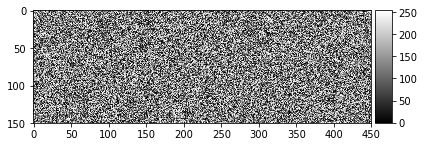

OUTPUT


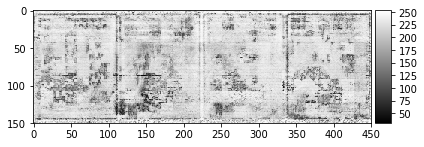

TARGET


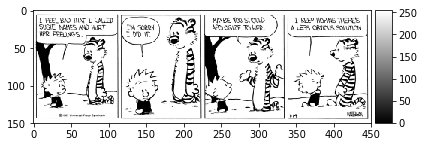

step  0 / 7367 d_loss:  0.005403166636824608 g_loss:  [59.215836, 0.58664006, 0.5518299]
step  1 / 7367 d_loss:  0.0025854730047285557 g_loss:  [58.70499, 0.58131444, 0.5735458]
step  2 / 7367 d_loss:  0.0027727417182177305 g_loss:  [50.879673, 0.50261253, 0.6184195]
step  3 / 7367 d_loss:  0.004041871055960655 g_loss:  [48.737606, 0.4806703, 0.67057306]
step  4 / 7367 d_loss:  0.000833693309687078 g_loss:  [108.131584, 1.073487, 0.7828791]
step  5 / 7367 d_loss:  0.026826933026313782 g_loss:  [47.14057, 0.46227658, 0.91291386]
step  6 / 7367 d_loss:  0.01311210822314024 g_loss:  [48.123108, 0.47087136, 1.0359743]
step  7 / 7367 d_loss:  0.014971093274652958 g_loss:  [61.331413, 0.6038252, 0.9488901]
step  8 / 7367 d_loss:  0.021608468145132065 g_loss:  [55.651306, 0.5481779, 0.8335152]
step  9 / 7367 d_loss:  0.035047996789216995 g_loss:  [44.161186, 0.43440565, 0.7206177]
step  10 / 7367 d_loss:  0.04309454560279846 g_loss:  [43.54694, 0.428672, 0.6797392]
step  11 / 7367 d_loss:  0.

step  93 / 7367 d_loss:  0.00030184120987541974 g_loss:  [48.117596, 0.4710773, 1.0098635]
step  94 / 7367 d_loss:  0.031706519424915314 g_loss:  [38.960526, 0.38064352, 0.89617676]
step  95 / 7367 d_loss:  0.001677967607975006 g_loss:  [56.617413, 0.55790114, 0.82729805]
step  96 / 7367 d_loss:  0.004984707571566105 g_loss:  [55.077324, 0.54279464, 0.7978605]
step  97 / 7367 d_loss:  0.010835584253072739 g_loss:  [43.146255, 0.4238227, 0.76398504]
step  98 / 7367 d_loss:  0.006965497974306345 g_loss:  [71.60243, 0.70810825, 0.7916137]
step  99 / 7367 d_loss:  0.005837177857756615 g_loss:  [49.138855, 0.48358828, 0.78002656]
step  100 / 7367 d_loss:  0.00794170517474413 g_loss:  [65.35555, 0.6455879, 0.796762]
step  101 / 7367 d_loss:  0.0058277444913983345 g_loss:  [55.637794, 0.54855096, 0.78269947]
step  102 / 7367 d_loss:  0.004224751610308886 g_loss:  [46.869083, 0.46027905, 0.8411774]
step  103 / 7367 d_loss:  0.0039207832887768745 g_loss:  [49.712868, 0.4881779, 0.8950766]
step 

step  185 / 7367 d_loss:  0.0043897200375795364 g_loss:  [49.477566, 0.48272318, 1.2052505]
step  186 / 7367 d_loss:  0.014091473072767258 g_loss:  [42.339676, 0.4123315, 1.1065251]
step  187 / 7367 d_loss:  0.006728425621986389 g_loss:  [57.378124, 0.5636402, 1.014108]
step  188 / 7367 d_loss:  0.01001531258225441 g_loss:  [51.155025, 0.5016536, 0.9896666]
step  189 / 7367 d_loss:  0.27238115668296814 g_loss:  [39.92255, 0.39001876, 0.92067266]
step  190 / 7367 d_loss:  0.01274370588362217 g_loss:  [51.648468, 0.5074496, 0.9035053]
step  191 / 7367 d_loss:  0.017769530415534973 g_loss:  [49.922237, 0.49061596, 0.86064196]
step  192 / 7367 d_loss:  0.019655566662549973 g_loss:  [54.2854, 0.5342015, 0.8652493]
step  193 / 7367 d_loss:  0.01400289498269558 g_loss:  [44.756725, 0.43862373, 0.8943526]
step  194 / 7367 d_loss:  0.0035350865218788385 g_loss:  [48.442047, 0.47483096, 0.9589488]
step  195 / 7367 d_loss:  0.4516960680484772 g_loss:  [39.842407, 0.38941476, 0.90093106]
step  196

step  277 / 7367 d_loss:  0.0064979796297848225 g_loss:  [131.29474, 1.3076309, 0.53165424]
step  278 / 7367 d_loss:  0.00782380998134613 g_loss:  [49.767014, 0.49170417, 0.5965971]
step  279 / 7367 d_loss:  0.008061667904257774 g_loss:  [45.069218, 0.44417483, 0.6517321]
step  280 / 7367 d_loss:  0.012205890379846096 g_loss:  [45.7496, 0.45034567, 0.71503365]
step  281 / 7367 d_loss:  0.012937122955918312 g_loss:  [49.11078, 0.4833073, 0.7800498]
step  282 / 7367 d_loss:  0.013915334828197956 g_loss:  [44.382713, 0.4356062, 0.8220929]
step  283 / 7367 d_loss:  0.010182240046560764 g_loss:  [48.788, 0.47950077, 0.83792]
step  284 / 7367 d_loss:  0.0073990891687572 g_loss:  [57.17822, 0.56360936, 0.8172844]
step  285 / 7367 d_loss:  0.22445416450500488 g_loss:  [40.28992, 0.39484027, 0.80589336]
step  286 / 7367 d_loss:  0.009942935779690742 g_loss:  [55.258316, 0.5447399, 0.78432626]
step  287 / 7367 d_loss:  0.028890376910567284 g_loss:  [43.550835, 0.4271622, 0.83461493]
step  288 / 

step  368 / 7367 d_loss:  0.02466757968068123 g_loss:  [75.435585, 0.7439752, 1.0380645]
step  369 / 7367 d_loss:  0.02609148621559143 g_loss:  [63.50729, 0.6241955, 1.0877383]
step  370 / 7367 d_loss:  0.012291083112359047 g_loss:  [59.769, 0.5855629, 1.2127118]
step  371 / 7367 d_loss:  0.06065668910741806 g_loss:  [45.51988, 0.4422536, 1.2945231]
step  372 / 7367 d_loss:  0.029278449714183807 g_loss:  [49.393486, 0.48064718, 1.3287697]
step  373 / 7367 d_loss:  0.346601277589798 g_loss:  [42.496666, 0.41205972, 1.2906944]
step  374 / 7367 d_loss:  0.0436338372528553 g_loss:  [47.6944, 0.46619293, 1.0751083]
step  375 / 7367 d_loss:  0.03694324195384979 g_loss:  [69.0271, 0.6798282, 1.0442729]
step  376 / 7367 d_loss:  0.1925148069858551 g_loss:  [43.600586, 0.42677388, 0.9231986]
step  377 / 7367 d_loss:  0.020294304937124252 g_loss:  [48.451878, 0.47514588, 0.93729025]
step  378 / 7367 d_loss:  0.01917516067624092 g_loss:  [55.308563, 0.54430264, 0.8782983]
step  379 / 7367 d_loss:

step  460 / 7367 d_loss:  0.042520180344581604 g_loss:  [50.111835, 0.48807558, 1.3042772]
step  461 / 7367 d_loss:  0.39531341195106506 g_loss:  [40.053963, 0.38799623, 1.2543397]
step  462 / 7367 d_loss:  0.0371297188103199 g_loss:  [49.67967, 0.48502442, 1.1772264]
step  463 / 7367 d_loss:  0.02136840671300888 g_loss:  [55.268764, 0.54083365, 1.1853989]
step  464 / 7367 d_loss:  0.027085265144705772 g_loss:  [54.521854, 0.5339734, 1.1245147]
step  465 / 7367 d_loss:  0.009371716529130936 g_loss:  [54.18724, 0.53052086, 1.1351564]
step  466 / 7367 d_loss:  0.046471863985061646 g_loss:  [41.883698, 0.40727565, 1.1561308]
step  467 / 7367 d_loss:  0.033515725284814835 g_loss:  [44.83618, 0.4370646, 1.1297226]
step  468 / 7367 d_loss:  0.00742082204669714 g_loss:  [50.05375, 0.48968393, 1.0853574]
step  469 / 7367 d_loss:  0.010473966598510742 g_loss:  [53.65489, 0.5260781, 1.0470761]
step  470 / 7367 d_loss:  0.018819181248545647 g_loss:  [47.22013, 0.46156892, 1.0632408]
step  471 / 7

step  552 / 7367 d_loss:  0.12580400705337524 g_loss:  [41.170765, 0.40403795, 0.76697177]
step  553 / 7367 d_loss:  0.02154296636581421 g_loss:  [47.021347, 0.46344578, 0.676771]
step  554 / 7367 d_loss:  0.013017161749303341 g_loss:  [49.710896, 0.4900257, 0.7083254]
step  555 / 7367 d_loss:  0.004368836060166359 g_loss:  [51.80551, 0.5104945, 0.75606346]
step  556 / 7367 d_loss:  0.019379910081624985 g_loss:  [45.813175, 0.45051095, 0.76208156]
step  557 / 7367 d_loss:  1.2437764406204224 g_loss:  [37.845284, 0.37171802, 0.67348236]
step  558 / 7367 d_loss:  0.004979368764907122 g_loss:  [50.42998, 0.4981853, 0.61145186]
step  559 / 7367 d_loss:  0.009632231667637825 g_loss:  [41.608406, 0.40989718, 0.61868787]
step  560 / 7367 d_loss:  0.04197562113404274 g_loss:  [41.781452, 0.4120647, 0.57497996]
step  561 / 7367 d_loss:  0.0021203539799898863 g_loss:  [47.649113, 0.47063047, 0.5860679]
step  562 / 7367 d_loss:  0.005071016028523445 g_loss:  [44.893364, 0.4431941, 0.57395595]
ste

step  644 / 7367 d_loss:  0.009736200794577599 g_loss:  [49.674812, 0.4887438, 0.80042994]
step  645 / 7367 d_loss:  0.009200043976306915 g_loss:  [43.897827, 0.43069613, 0.82821256]
step  646 / 7367 d_loss:  0.005024367943406105 g_loss:  [56.586506, 0.55712926, 0.8735821]
step  647 / 7367 d_loss:  0.002641207305714488 g_loss:  [51.904293, 0.50954604, 0.9496889]
step  648 / 7367 d_loss:  0.01083825621753931 g_loss:  [44.73927, 0.43778932, 0.96033907]
step  649 / 7367 d_loss:  0.0012715229531750083 g_loss:  [73.5894, 0.72650206, 0.93919176]
step  650 / 7367 d_loss:  0.0040169814601540565 g_loss:  [51.058556, 0.50072247, 0.9863099]
step  651 / 7367 d_loss:  0.009583967737853527 g_loss:  [47.04208, 0.4604635, 0.99573225]
step  652 / 7367 d_loss:  0.0034649779554456472 g_loss:  [51.081696, 0.5003733, 1.0443642]
step  653 / 7367 d_loss:  0.00245377654209733 g_loss:  [52.057076, 0.5104514, 1.0119358]
step  654 / 7367 d_loss:  0.0030713507439941168 g_loss:  [53.561348, 0.52524275, 1.0370759]


step  735 / 7367 d_loss:  0.021062219515442848 g_loss:  [40.01848, 0.38939336, 1.0791433]
step  736 / 7367 d_loss:  0.0003364125732332468 g_loss:  [47.354618, 0.4630357, 1.0510492]
step  737 / 7367 d_loss:  0.004697589203715324 g_loss:  [51.032234, 0.5002364, 1.008594]
step  738 / 7367 d_loss:  0.004531116224825382 g_loss:  [44.582832, 0.4359934, 0.98349404]
step  739 / 7367 d_loss:  0.005138806067407131 g_loss:  [49.791637, 0.4884058, 0.95105815]
step  740 / 7367 d_loss:  0.0036960055585950613 g_loss:  [47.666733, 0.46754998, 0.9117366]
step  741 / 7367 d_loss:  0.007887331768870354 g_loss:  [47.812313, 0.4696309, 0.8492231]
step  742 / 7367 d_loss:  0.046629130840301514 g_loss:  [44.481247, 0.43730482, 0.75076216]
step  743 / 7367 d_loss:  0.004298499319702387 g_loss:  [55.757877, 0.5504904, 0.70883757]
step  744 / 7367 d_loss:  3.5113407648168504e-06 g_loss:  [50.70587, 0.49993542, 0.71233094]
step  745 / 7367 d_loss:  0.013298850506544113 g_loss:  [55.28166, 0.5460526, 0.6763987]
s

step  827 / 7367 d_loss:  0.01690496876835823 g_loss:  [62.865734, 0.6221189, 0.65384716]
step  828 / 7367 d_loss:  0.3145574629306793 g_loss:  [37.41653, 0.36810237, 0.6062934]
step  829 / 7367 d_loss:  0.012042787857353687 g_loss:  [51.822033, 0.51208246, 0.61379]
step  830 / 7367 d_loss:  0.01810082234442234 g_loss:  [88.02384, 0.87402135, 0.6217038]
step  831 / 7367 d_loss:  0.426567018032074 g_loss:  [37.193275, 0.36606583, 0.58669114]
step  832 / 7367 d_loss:  0.06459758430719376 g_loss:  [55.79508, 0.55219537, 0.575542]
step  833 / 7367 d_loss:  0.07075253129005432 g_loss:  [48.8801, 0.48258778, 0.62132204]
step  834 / 7367 d_loss:  0.07793805003166199 g_loss:  [49.134, 0.48479947, 0.6540537]
step  835 / 7367 d_loss:  0.08035021275281906 g_loss:  [47.953087, 0.47183543, 0.76954085]
step  836 / 7367 d_loss:  0.06002483144402504 g_loss:  [54.172295, 0.533008, 0.87149733]
step  837 / 7367 d_loss:  0.06704870611429214 g_loss:  [50.34567, 0.49345487, 1.0001817]
step  838 / 7367 d_los

step  919 / 7367 d_loss:  0.002117019146680832 g_loss:  [49.44214, 0.48179567, 1.2625737]
step  920 / 7367 d_loss:  0.0043887184001505375 g_loss:  [76.21402, 0.74897224, 1.3167944]
step  921 / 7367 d_loss:  0.010085906833410263 g_loss:  [58.28158, 0.56964594, 1.316985]
step  922 / 7367 d_loss:  0.027313513681292534 g_loss:  [73.370766, 0.7200448, 1.3662902]
step  923 / 7367 d_loss:  1.3550238609313965 g_loss:  [35.18133, 0.33893234, 1.288096]
step  924 / 7367 d_loss:  0.01672413945198059 g_loss:  [51.321915, 0.50153464, 1.1684493]
step  925 / 7367 d_loss:  0.034353915601968765 g_loss:  [44.80986, 0.43771377, 1.038483]
step  926 / 7367 d_loss:  0.03791091963648796 g_loss:  [56.33804, 0.5534308, 0.9949598]
step  927 / 7367 d_loss:  0.045185286551713943 g_loss:  [47.490685, 0.46573153, 0.9175311]
step  928 / 7367 d_loss:  0.05260640010237694 g_loss:  [44.825993, 0.43969604, 0.85638624]
step  929 / 7367 d_loss:  0.04792530834674835 g_loss:  [47.24808, 0.46389213, 0.8588669]
step  930 / 736

step  1012 / 7367 d_loss:  0.006390600465238094 g_loss:  [58.638634, 0.58018607, 0.62002486]
step  1013 / 7367 d_loss:  0.014922485686838627 g_loss:  [39.76322, 0.3913996, 0.6232635]
step  1014 / 7367 d_loss:  0.008153644390404224 g_loss:  [86.39325, 0.8574138, 0.65186185]
step  1015 / 7367 d_loss:  0.029102860018610954 g_loss:  [43.618484, 0.42958, 0.6604826]
step  1016 / 7367 d_loss:  0.02030196040868759 g_loss:  [49.77181, 0.4911997, 0.65184045]
step  1017 / 7367 d_loss:  0.021062586456537247 g_loss:  [51.93857, 0.51286966, 0.65160525]
step  1018 / 7367 d_loss:  0.008748430758714676 g_loss:  [59.89772, 0.59242386, 0.65533423]
step  1019 / 7367 d_loss:  0.04045097529888153 g_loss:  [82.50112, 0.81870407, 0.63071245]
step  1020 / 7367 d_loss:  0.005095209460705519 g_loss:  [46.424583, 0.45754445, 0.67013896]
step  1021 / 7367 d_loss:  0.007590534631162882 g_loss:  [46.71306, 0.46017823, 0.695235]
step  1022 / 7367 d_loss:  0.0018170787952840328 g_loss:  [47.896484, 0.4718795, 0.708535

step  1102 / 7367 d_loss:  0.001177082653157413 g_loss:  [46.040417, 0.45358628, 0.68178844]
step  1103 / 7367 d_loss:  0.002531860489398241 g_loss:  [61.259575, 0.6056547, 0.6941028]
step  1104 / 7367 d_loss:  0.006960070692002773 g_loss:  [57.428886, 0.56732416, 0.69647276]
step  1105 / 7367 d_loss:  0.0167723149061203 g_loss:  [53.359364, 0.52655417, 0.7039454]
step  1106 / 7367 d_loss:  0.0054365163668990135 g_loss:  [55.64495, 0.5491432, 0.7306329]
step  1107 / 7367 d_loss:  0.0058144573122262955 g_loss:  [52.240395, 0.51492023, 0.7483698]
step  1108 / 7367 d_loss:  0.004069427493959665 g_loss:  [47.94043, 0.47135127, 0.80529994]
step  1109 / 7367 d_loss:  0.0082806795835495 g_loss:  [49.686016, 0.48829398, 0.8566185]
step  1110 / 7367 d_loss:  0.0019147340208292007 g_loss:  [53.841957, 0.52944905, 0.89705086]
step  1111 / 7367 d_loss:  0.048686861991882324 g_loss:  [39.858047, 0.38896513, 0.96153337]
step  1112 / 7367 d_loss:  0.02648927830159664 g_loss:  [40.628456, 0.39637968, 

step  1192 / 7367 d_loss:  0.01636987179517746 g_loss:  [41.305378, 0.40268934, 1.036444]
step  1193 / 7367 d_loss:  0.00405935849994421 g_loss:  [56.52718, 0.5545845, 1.0687294]
step  1194 / 7367 d_loss:  0.005682855844497681 g_loss:  [46.038345, 0.4493779, 1.1005539]
step  1195 / 7367 d_loss:  0.005668423138558865 g_loss:  [56.024475, 0.5493973, 1.0847462]
step  1196 / 7367 d_loss:  0.0033901017159223557 g_loss:  [44.13716, 0.42972004, 1.1651567]
step  1197 / 7367 d_loss:  0.004949837923049927 g_loss:  [49.616657, 0.48461774, 1.154885]
step  1198 / 7367 d_loss:  0.004195080138742924 g_loss:  [51.269028, 0.50066346, 1.2026833]
step  1199 / 7367 d_loss:  0.006714303977787495 g_loss:  [51.333164, 0.50109625, 1.2235384]
step  1200 / 7367 d_loss:  0.012010079808533192 g_loss:  [52.024414, 0.50779945, 1.2444687]
step  1201 / 7367 d_loss:  0.009512386284768581 g_loss:  [66.26491, 0.6502203, 1.2428789]
step  1202 / 7367 d_loss:  0.014563575387001038 g_loss:  [53.609486, 0.52317417, 1.2920674

step  1284 / 7367 d_loss:  0.002824031747877598 g_loss:  [40.893883, 0.40070578, 0.82330155]
step  1285 / 7367 d_loss:  0.001921720802783966 g_loss:  [46.28063, 0.45455202, 0.82542425]
step  1286 / 7367 d_loss:  0.00539803970605135 g_loss:  [57.20048, 0.56361675, 0.83880574]
step  1287 / 7367 d_loss:  0.027711065486073494 g_loss:  [52.129486, 0.51319444, 0.81004417]
step  1288 / 7367 d_loss:  0.0046681687235832214 g_loss:  [55.070896, 0.5424307, 0.82782614]
step  1289 / 7367 d_loss:  0.0030958042480051517 g_loss:  [53.13963, 0.52269465, 0.8701624]
step  1290 / 7367 d_loss:  0.01967950165271759 g_loss:  [50.974586, 0.50083965, 0.89062274]
step  1291 / 7367 d_loss:  0.002922304207459092 g_loss:  [50.012924, 0.49080792, 0.9321309]
step  1292 / 7367 d_loss:  0.002393751172348857 g_loss:  [46.301655, 0.45356655, 0.94500047]
step  1293 / 7367 d_loss:  0.011406337842345238 g_loss:  [41.5602, 0.4061328, 0.94692314]
step  1294 / 7367 d_loss:  0.014018076471984386 g_loss:  [51.41573, 0.50448847,

step  1374 / 7367 d_loss:  0.0033954251557588577 g_loss:  [53.896317, 0.53022003, 0.8743118]
step  1375 / 7367 d_loss:  2.9639755666721612e-05 g_loss:  [52.55365, 0.5164013, 0.9135214]
step  1376 / 7367 d_loss:  0.0007976324413903058 g_loss:  [75.98459, 0.7506727, 0.91731834]
step  1377 / 7367 d_loss:  0.00760132260620594 g_loss:  [51.15593, 0.50210583, 0.9453474]
step  1378 / 7367 d_loss:  0.015100546181201935 g_loss:  [43.710056, 0.4279255, 0.91750604]
step  1379 / 7367 d_loss:  0.004634568467736244 g_loss:  [50.212124, 0.49255985, 0.9561383]
step  1380 / 7367 d_loss:  0.005170936696231365 g_loss:  [48.183586, 0.4718543, 0.9981576]
step  1381 / 7367 d_loss:  0.004948861431330442 g_loss:  [52.22505, 0.5123001, 0.9950445]
step  1382 / 7367 d_loss:  0.0038480651564896107 g_loss:  [46.227802, 0.45160186, 1.0676152]
step  1383 / 7367 d_loss:  0.0040522352792322636 g_loss:  [49.48132, 0.48423824, 1.0574937]
step  1384 / 7367 d_loss:  0.07069359719753265 g_loss:  [39.65452, 0.3862711, 1.027

step  1465 / 7367 d_loss:  0.006283650174736977 g_loss:  [49.01791, 0.4808849, 0.92942]
step  1466 / 7367 d_loss:  0.005187380593270063 g_loss:  [44.04003, 0.43177244, 0.8627889]
step  1467 / 7367 d_loss:  0.0017669487278908491 g_loss:  [52.794353, 0.5198234, 0.81201565]
step  1468 / 7367 d_loss:  0.008447248488664627 g_loss:  [42.003025, 0.41234145, 0.7688797]
step  1469 / 7367 d_loss:  0.0005457282532006502 g_loss:  [44.98943, 0.4422652, 0.76290905]
step  1470 / 7367 d_loss:  0.01858707331120968 g_loss:  [48.914143, 0.4817139, 0.7427502]
step  1471 / 7367 d_loss:  0.005870584398508072 g_loss:  [50.954388, 0.5019835, 0.7560357]
step  1472 / 7367 d_loss:  0.0011478899978101254 g_loss:  [44.379498, 0.43625933, 0.7535611]
step  1473 / 7367 d_loss:  9.744687849888578e-05 g_loss:  [44.868183, 0.44084984, 0.7832004]
step  1474 / 7367 d_loss:  0.0018120517488569021 g_loss:  [47.45651, 0.46663344, 0.7931633]
step  1475 / 7367 d_loss:  0.0004585932765621692 g_loss:  [52.46753, 0.5166822, 0.799

step  1556 / 7367 d_loss:  0.0011302456259727478 g_loss:  [47.777874, 0.46705386, 1.0724872]
step  1557 / 7367 d_loss:  0.021142369136214256 g_loss:  [42.54365, 0.41506585, 1.0370675]
step  1558 / 7367 d_loss:  0.00981284212321043 g_loss:  [41.346577, 0.40374595, 0.97197926]
step  1559 / 7367 d_loss:  0.0037385872565209866 g_loss:  [53.464798, 0.5253126, 0.9335365]
step  1560 / 7367 d_loss:  0.009691337123513222 g_loss:  [47.868107, 0.46926114, 0.94199413]
step  1561 / 7367 d_loss:  0.003733600489795208 g_loss:  [56.719337, 0.5582412, 0.895218]
step  1562 / 7367 d_loss:  0.004679496865719557 g_loss:  [48.748985, 0.47802, 0.9469842]
step  1563 / 7367 d_loss:  0.004308886360377073 g_loss:  [48.500675, 0.47551233, 0.9494436]
step  1564 / 7367 d_loss:  0.0049661993980407715 g_loss:  [49.328773, 0.48361668, 0.9671045]
step  1565 / 7367 d_loss:  0.00044741135207004845 g_loss:  [52.41407, 0.5144658, 0.9674915]
step  1566 / 7367 d_loss:  0.037363938987255096 g_loss:  [109.73747, 1.0870509, 1.0

step  1646 / 7367 d_loss:  0.005967207718640566 g_loss:  [61.62836, 0.6078972, 0.8386383]
step  1647 / 7367 d_loss:  0.008301498368382454 g_loss:  [48.2352, 0.47386903, 0.84829736]
step  1648 / 7367 d_loss:  0.002707629231736064 g_loss:  [65.55804, 0.6466603, 0.8920061]
step  1649 / 7367 d_loss:  0.004595743492245674 g_loss:  [57.372906, 0.5645838, 0.9145293]
step  1650 / 7367 d_loss:  0.07757922261953354 g_loss:  [39.402107, 0.3848015, 0.92195326]
step  1651 / 7367 d_loss:  0.008542423136532307 g_loss:  [51.100227, 0.50176543, 0.9236835]
step  1652 / 7367 d_loss:  0.0037220362573862076 g_loss:  [54.46005, 0.5350558, 0.9544668]
step  1653 / 7367 d_loss:  0.006421680096536875 g_loss:  [58.834667, 0.57855237, 0.97943157]
step  1654 / 7367 d_loss:  0.0009828096954151988 g_loss:  [49.442158, 0.4841126, 1.0309005]
step  1655 / 7367 d_loss:  0.003097214037552476 g_loss:  [52.61664, 0.5156606, 1.050581]
step  1656 / 7367 d_loss:  0.004941282793879509 g_loss:  [63.98069, 0.6286645, 1.1142427]


step  1736 / 7367 d_loss:  0.014893431216478348 g_loss:  [56.12418, 0.5566088, 0.4632987]
step  1737 / 7367 d_loss:  0.024097006767988205 g_loss:  [50.51714, 0.500422, 0.474942]
step  1738 / 7367 d_loss:  0.0238175205886364 g_loss:  [52.225853, 0.5175303, 0.47282]
step  1739 / 7367 d_loss:  0.033595047891139984 g_loss:  [55.21141, 0.5468684, 0.5245705]
step  1740 / 7367 d_loss:  0.04694420099258423 g_loss:  [38.1082, 0.3754732, 0.5608797]
step  1741 / 7367 d_loss:  0.051464296877384186 g_loss:  [44.881657, 0.44238147, 0.6435083]
step  1742 / 7367 d_loss:  0.022401519119739532 g_loss:  [46.09764, 0.45382634, 0.7150071]
step  1743 / 7367 d_loss:  0.016252586618065834 g_loss:  [48.318413, 0.4755161, 0.76679933]
step  1744 / 7367 d_loss:  0.06125202775001526 g_loss:  [38.88296, 0.38036537, 0.84642285]
step  1745 / 7367 d_loss:  0.005676051136106253 g_loss:  [46.730225, 0.45859328, 0.87089616]
step  1746 / 7367 d_loss:  0.0044702389277517796 g_loss:  [56.360344, 0.55430466, 0.9298766]
step 

step  1828 / 7367 d_loss:  0.018246812745928764 g_loss:  [45.994934, 0.45519844, 0.47509053]
step  1829 / 7367 d_loss:  0.01187716145068407 g_loss:  [48.226402, 0.47759423, 0.46697843]
step  1830 / 7367 d_loss:  0.02659948170185089 g_loss:  [52.63283, 0.52092904, 0.5399268]
step  1831 / 7367 d_loss:  0.03346064314246178 g_loss:  [48.004814, 0.47447935, 0.55688184]
step  1832 / 7367 d_loss:  0.026845542713999748 g_loss:  [50.03706, 0.4944411, 0.5929474]
step  1833 / 7367 d_loss:  0.01325390674173832 g_loss:  [48.235855, 0.47599283, 0.6365722]
step  1834 / 7367 d_loss:  0.01306668296456337 g_loss:  [46.743366, 0.46037343, 0.7060259]
step  1835 / 7367 d_loss:  0.01391092874109745 g_loss:  [54.950794, 0.54154086, 0.79670644]
step  1836 / 7367 d_loss:  0.0090764369815588 g_loss:  [40.332687, 0.39522958, 0.8097294]
step  1837 / 7367 d_loss:  0.020868269726634026 g_loss:  [52.666687, 0.5177352, 0.8931699]
step  1838 / 7367 d_loss:  0.004212784115225077 g_loss:  [54.09923, 0.53179044, 0.920187

step  1918 / 7367 d_loss:  0.007105660159140825 g_loss:  [57.675396, 0.56818044, 0.85735345]
step  1919 / 7367 d_loss:  0.0004548104479908943 g_loss:  [48.061302, 0.47196698, 0.8646046]
step  1920 / 7367 d_loss:  0.002991198794916272 g_loss:  [44.75501, 0.43863446, 0.8915639]
step  1921 / 7367 d_loss:  0.003651013597846031 g_loss:  [55.92676, 0.54993445, 0.9333144]
step  1922 / 7367 d_loss:  0.004504409618675709 g_loss:  [53.024994, 0.52115715, 0.90928054]
step  1923 / 7367 d_loss:  0.019639506936073303 g_loss:  [60.543316, 0.5964397, 0.89934605]
step  1924 / 7367 d_loss:  0.011897735297679901 g_loss:  [47.757607, 0.4686607, 0.8915379]
step  1925 / 7367 d_loss:  0.025697413831949234 g_loss:  [57.924686, 0.57035357, 0.8893275]
step  1926 / 7367 d_loss:  0.008417775854468346 g_loss:  [71.91874, 0.7104287, 0.8758724]
step  1927 / 7367 d_loss:  0.1732305884361267 g_loss:  [39.532124, 0.3871541, 0.81671685]
step  1928 / 7367 d_loss:  0.006005106959491968 g_loss:  [48.04102, 0.47267234, 0.77

step  2009 / 7367 d_loss:  0.007740168832242489 g_loss:  [46.003452, 0.4540166, 0.60179037]
step  2010 / 7367 d_loss:  0.010147226974368095 g_loss:  [41.02413, 0.4044277, 0.58136135]
step  2011 / 7367 d_loss:  0.02236063964664936 g_loss:  [52.12777, 0.5152277, 0.60500485]
step  2012 / 7367 d_loss:  0.0181601420044899 g_loss:  [54.00772, 0.53369874, 0.6378493]
step  2013 / 7367 d_loss:  0.025871124118566513 g_loss:  [51.298683, 0.5064256, 0.6561194]
step  2014 / 7367 d_loss:  0.01995275728404522 g_loss:  [47.195766, 0.46471497, 0.7242708]
step  2015 / 7367 d_loss:  0.01749143749475479 g_loss:  [54.16151, 0.5333723, 0.82428455]
step  2016 / 7367 d_loss:  0.0021215807646512985 g_loss:  [49.023216, 0.48183945, 0.8392732]
step  2017 / 7367 d_loss:  0.0012974828714504838 g_loss:  [46.024498, 0.45148164, 0.8763367]
step  2018 / 7367 d_loss:  0.00034171441802755 g_loss:  [49.8226, 0.48887137, 0.9354623]
step  2019 / 7367 d_loss:  0.004147293046116829 g_loss:  [44.463562, 0.43531418, 0.9321445]

step  2101 / 7367 d_loss:  0.0012103531043976545 g_loss:  [55.29417, 0.54389465, 0.9047048]
step  2102 / 7367 d_loss:  0.0001178875972982496 g_loss:  [64.6586, 0.6377411, 0.8844906]
step  2103 / 7367 d_loss:  0.005045892205089331 g_loss:  [52.91272, 0.5204979, 0.8629263]
step  2104 / 7367 d_loss:  0.00913738738745451 g_loss:  [42.745083, 0.41918418, 0.8266653]
step  2105 / 7367 d_loss:  0.0034358117263764143 g_loss:  [48.685562, 0.47876, 0.80956227]
step  2106 / 7367 d_loss:  0.0015948262298479676 g_loss:  [55.346992, 0.5454449, 0.802502]
step  2107 / 7367 d_loss:  0.0012624072842299938 g_loss:  [55.221752, 0.5439384, 0.8279126]
step  2108 / 7367 d_loss:  0.0032544354908168316 g_loss:  [47.18878, 0.46361908, 0.8268726]
step  2109 / 7367 d_loss:  0.0007238800171762705 g_loss:  [56.889256, 0.56021863, 0.86739296]
step  2110 / 7367 d_loss:  0.003536607837304473 g_loss:  [46.614285, 0.45753485, 0.8607988]
step  2111 / 7367 d_loss:  0.007646264974027872 g_loss:  [51.690998, 0.5084168, 0.849

step  2191 / 7367 d_loss:  0.013159685768187046 g_loss:  [54.096058, 0.5309096, 1.0050969]
step  2192 / 7367 d_loss:  0.012457141652703285 g_loss:  [53.644062, 0.5258173, 1.062335]
step  2193 / 7367 d_loss:  0.00868816114962101 g_loss:  [53.238407, 0.5211441, 1.1239961]
step  2194 / 7367 d_loss:  0.015639614313840866 g_loss:  [43.433716, 0.42298877, 1.1348379]
step  2195 / 7367 d_loss:  0.0016010137042030692 g_loss:  [64.80911, 0.6365355, 1.1555585]
step  2196 / 7367 d_loss:  0.00843148771673441 g_loss:  [46.948925, 0.45794973, 1.1539546]
step  2197 / 7367 d_loss:  0.005057229660451412 g_loss:  [53.83265, 0.5271024, 1.1224084]
step  2198 / 7367 d_loss:  0.014376664534211159 g_loss:  [42.9706, 0.41851997, 1.118601]
step  2199 / 7367 d_loss:  0.012132808566093445 g_loss:  [48.7891, 0.476883, 1.1007998]
step  2200 / 7367 d_loss:  0.01112779974937439 g_loss:  [52.074165, 0.5096517, 1.1089942]
step  2201 / 7367 d_loss:  0.006400181446224451 g_loss:  [51.527004, 0.504373, 1.0897028]
step  22

step  2283 / 7367 d_loss:  0.0022878956515341997 g_loss:  [56.713207, 0.5624866, 0.46455008]
step  2284 / 7367 d_loss:  0.01608666218817234 g_loss:  [54.496883, 0.5402579, 0.4710976]
step  2285 / 7367 d_loss:  0.0034987241961061954 g_loss:  [46.65547, 0.4617186, 0.48361102]
step  2286 / 7367 d_loss:  0.01865004003047943 g_loss:  [41.093143, 0.40572673, 0.52047044]
step  2287 / 7367 d_loss:  0.0054479860700666904 g_loss:  [49.161762, 0.48615307, 0.54645514]
step  2288 / 7367 d_loss:  0.0022134119644761086 g_loss:  [43.40843, 0.4278913, 0.619297]
step  2289 / 7367 d_loss:  0.003179996507242322 g_loss:  [54.235992, 0.5363036, 0.6056322]
step  2290 / 7367 d_loss:  0.016891730949282646 g_loss:  [49.314724, 0.48670718, 0.64400303]
step  2291 / 7367 d_loss:  0.05504407361149788 g_loss:  [37.364567, 0.36735174, 0.62939465]
step  2292 / 7367 d_loss:  0.01911487989127636 g_loss:  [51.300606, 0.50690454, 0.6101545]
step  2293 / 7367 d_loss:  0.010275555774569511 g_loss:  [40.614647, 0.40036908, 0

step  2375 / 7367 d_loss:  0.011923059821128845 g_loss:  [51.161755, 0.50085074, 1.0766807]
step  2376 / 7367 d_loss:  0.010583886876702309 g_loss:  [49.435722, 0.4830643, 1.1292913]
step  2377 / 7367 d_loss:  0.00927101168781519 g_loss:  [50.072998, 0.4895675, 1.1162473]
step  2378 / 7367 d_loss:  0.050096962600946426 g_loss:  [54.571552, 0.5344658, 1.1249746]
step  2379 / 7367 d_loss:  0.013338417746126652 g_loss:  [80.98038, 0.79850346, 1.1300315]
step  2380 / 7367 d_loss:  0.031368985772132874 g_loss:  [103.301094, 1.0215747, 1.1436224]
step  2381 / 7367 d_loss:  0.015301867388188839 g_loss:  [55.535175, 0.5438108, 1.1540998]
step  2382 / 7367 d_loss:  0.016070736572146416 g_loss:  [49.051308, 0.47869855, 1.1814548]
step  2383 / 7367 d_loss:  0.02699771337211132 g_loss:  [51.853844, 0.5063571, 1.2181356]
step  2384 / 7367 d_loss:  0.018611447885632515 g_loss:  [54.966, 0.53753805, 1.2121912]
step  2385 / 7367 d_loss:  0.016392013058066368 g_loss:  [48.412056, 0.47198367, 1.2136863]

step  2466 / 7367 d_loss:  0.006384676322340965 g_loss:  [44.545242, 0.4376686, 0.77838224]
step  2467 / 7367 d_loss:  0.00934899877756834 g_loss:  [44.417385, 0.43643796, 0.7735913]
step  2468 / 7367 d_loss:  0.011858331970870495 g_loss:  [47.85703, 0.47070312, 0.7867153]
step  2469 / 7367 d_loss:  0.020095515996217728 g_loss:  [47.92047, 0.47134855, 0.7856123]
step  2470 / 7367 d_loss:  0.015574351884424686 g_loss:  [51.609303, 0.5084109, 0.76821697]
step  2471 / 7367 d_loss:  0.010231664404273033 g_loss:  [53.85701, 0.5312996, 0.7270513]
step  2472 / 7367 d_loss:  0.01476273313164711 g_loss:  [60.766983, 0.60068834, 0.6981499]
step  2473 / 7367 d_loss:  0.0014917649095878005 g_loss:  [47.100464, 0.46410933, 0.6895309]
step  2474 / 7367 d_loss:  0.002257284941151738 g_loss:  [43.593147, 0.42916614, 0.676534]
step  2475 / 7367 d_loss:  0.024106254801154137 g_loss:  [46.97608, 0.462827, 0.69338334]
step  2476 / 7367 d_loss:  0.008274651132524014 g_loss:  [47.174976, 0.46487877, 0.68709

step  2556 / 7367 d_loss:  0.0034791731741279364 g_loss:  [51.26907, 0.5019664, 1.0724305]
step  2557 / 7367 d_loss:  0.00812508910894394 g_loss:  [49.85811, 0.48771197, 1.0869085]
step  2558 / 7367 d_loss:  0.009416449815034866 g_loss:  [54.179073, 0.5308463, 1.0944445]
step  2559 / 7367 d_loss:  0.011927347630262375 g_loss:  [73.57177, 0.7247698, 1.0947937]
step  2560 / 7367 d_loss:  0.009235506877303123 g_loss:  [62.57318, 0.6148783, 1.0853482]
step  2561 / 7367 d_loss:  0.008227023296058178 g_loss:  [49.365726, 0.4827572, 1.0900033]
step  2562 / 7367 d_loss:  0.010082382708787918 g_loss:  [48.9724, 0.47863832, 1.1085718]
step  2563 / 7367 d_loss:  0.007502906024456024 g_loss:  [51.276253, 0.5016878, 1.107471]
step  2564 / 7367 d_loss:  0.007143210619688034 g_loss:  [48.432632, 0.47313315, 1.1193178]
step  2565 / 7367 d_loss:  0.0015191197162494063 g_loss:  [54.065647, 0.52954394, 1.1112512]
step  2566 / 7367 d_loss:  0.01333162747323513 g_loss:  [56.123577, 0.5499978, 1.123798]
ste

step  2646 / 7367 d_loss:  0.008210462518036366 g_loss:  [57.38767, 0.56320554, 1.0671166]
step  2647 / 7367 d_loss:  0.024116672575473785 g_loss:  [48.17318, 0.47151244, 1.0219328]
step  2648 / 7367 d_loss:  0.0534367635846138 g_loss:  [45.5676, 0.44598418, 0.9691792]
step  2649 / 7367 d_loss:  0.00852735061198473 g_loss:  [58.442165, 0.5754218, 0.8999823]
step  2650 / 7367 d_loss:  0.08792942017316818 g_loss:  [41.47445, 0.40639538, 0.8349128]
step  2651 / 7367 d_loss:  0.013381905853748322 g_loss:  [48.717274, 0.47960156, 0.75711846]
step  2652 / 7367 d_loss:  0.14071330428123474 g_loss:  [41.45901, 0.4077719, 0.681822]
step  2653 / 7367 d_loss:  0.020257461816072464 g_loss:  [49.13017, 0.48520294, 0.60987484]
step  2654 / 7367 d_loss:  1.1276417970657349 g_loss:  [36.02781, 0.3552528, 0.5025288]
step  2655 / 7367 d_loss:  0.027977708727121353 g_loss:  [51.050385, 0.5062299, 0.42739716]
step  2656 / 7367 d_loss:  0.018023045733571053 g_loss:  [48.884068, 0.48509368, 0.37469816]
step

step  2737 / 7367 d_loss:  0.11398725211620331 g_loss:  [41.062576, 0.40288797, 0.7737816]
step  2738 / 7367 d_loss:  0.01780991442501545 g_loss:  [43.63871, 0.42828363, 0.8103504]
step  2739 / 7367 d_loss:  0.027304861694574356 g_loss:  [53.032036, 0.52188516, 0.8435204]
step  2740 / 7367 d_loss:  0.02212614379823208 g_loss:  [43.99764, 0.43136153, 0.8614841]
step  2741 / 7367 d_loss:  0.01649142988026142 g_loss:  [56.91445, 0.5597573, 0.9387219]
step  2742 / 7367 d_loss:  0.017947666347026825 g_loss:  [45.467148, 0.4448221, 0.9849375]
step  2743 / 7367 d_loss:  0.011469526216387749 g_loss:  [49.198605, 0.48156342, 1.0422616]
step  2744 / 7367 d_loss:  0.011087116785347462 g_loss:  [47.60452, 0.4652621, 1.0783113]
step  2745 / 7367 d_loss:  0.007754222955554724 g_loss:  [51.543373, 0.5039439, 1.1489799]
step  2746 / 7367 d_loss:  0.00796754565089941 g_loss:  [50.99873, 0.49797, 1.2017303]
step  2747 / 7367 d_loss:  0.007661128882318735 g_loss:  [55.008305, 0.5377487, 1.2334363]
step  

step  2828 / 7367 d_loss:  0.010250699706375599 g_loss:  [57.48972, 0.56199557, 1.2901618]
step  2829 / 7367 d_loss:  0.0023924498818814754 g_loss:  [50.510757, 0.49235868, 1.2748861]
step  2830 / 7367 d_loss:  0.09102511405944824 g_loss:  [44.003124, 0.42760554, 1.242569]
step  2831 / 7367 d_loss:  0.013066919520497322 g_loss:  [51.052147, 0.49838257, 1.2138915]
step  2832 / 7367 d_loss:  0.013336511328816414 g_loss:  [51.931183, 0.5071906, 1.212124]
step  2833 / 7367 d_loss:  0.014629079028964043 g_loss:  [50.297455, 0.4914625, 1.1512041]
step  2834 / 7367 d_loss:  0.15497390925884247 g_loss:  [57.100277, 0.56033486, 1.0667925]
step  2835 / 7367 d_loss:  0.030842643231153488 g_loss:  [53.10578, 0.5212162, 0.9841627]
step  2836 / 7367 d_loss:  0.03678883984684944 g_loss:  [72.61506, 0.71702546, 0.91251516]
step  2837 / 7367 d_loss:  0.030899178236722946 g_loss:  [48.965855, 0.48141962, 0.82389027]
step  2838 / 7367 d_loss:  0.01968378759920597 g_loss:  [54.21412, 0.5344431, 0.76981103

step  2919 / 7367 d_loss:  0.02242196537554264 g_loss:  [43.17277, 0.42095926, 1.0768417]
step  2920 / 7367 d_loss:  0.007505571469664574 g_loss:  [51.385242, 0.5030679, 1.0784539]
step  2921 / 7367 d_loss:  0.0013268658658489585 g_loss:  [48.404705, 0.4733131, 1.0733943]
step  2922 / 7367 d_loss:  0.003114585764706135 g_loss:  [48.380314, 0.47352573, 1.0277395]
step  2923 / 7367 d_loss:  0.009431810118258 g_loss:  [41.017223, 0.4001789, 0.99933076]
step  2924 / 7367 d_loss:  0.007866408675909042 g_loss:  [45.833767, 0.44870746, 0.9630185]
step  2925 / 7367 d_loss:  0.0038050292059779167 g_loss:  [49.840996, 0.48925614, 0.9153829]
step  2926 / 7367 d_loss:  0.005043365992605686 g_loss:  [46.6075, 0.45717347, 0.89015085]
step  2927 / 7367 d_loss:  0.005082355812191963 g_loss:  [66.405205, 0.6552919, 0.8760133]
step  2928 / 7367 d_loss:  0.002098162192851305 g_loss:  [48.88695, 0.4807676, 0.81019086]
step  2929 / 7367 d_loss:  0.0006716187344864011 g_loss:  [45.102253, 0.44316816, 0.7854

step  3009 / 7367 d_loss:  0.006046016700565815 g_loss:  [45.39176, 0.44165105, 1.2266564]
step  3010 / 7367 d_loss:  0.00580337829887867 g_loss:  [64.95468, 0.6366948, 1.2852019]
step  3011 / 7367 d_loss:  0.004914947785437107 g_loss:  [50.361366, 0.49040464, 1.3209028]
step  3012 / 7367 d_loss:  0.0328635573387146 g_loss:  [73.50919, 0.72167474, 1.3417195]
step  3013 / 7367 d_loss:  0.01316035632044077 g_loss:  [43.60709, 0.42250666, 1.3564237]
step  3014 / 7367 d_loss:  0.007978844456374645 g_loss:  [48.15349, 0.46813303, 1.3401847]
step  3015 / 7367 d_loss:  0.0018123611807823181 g_loss:  [52.604332, 0.5123991, 1.3644245]
step  3016 / 7367 d_loss:  0.003333709668368101 g_loss:  [49.124065, 0.47795445, 1.3286207]
step  3017 / 7367 d_loss:  0.00971341785043478 g_loss:  [46.38456, 0.45065624, 1.3189338]
step  3018 / 7367 d_loss:  0.00934082642197609 g_loss:  [51.8808, 0.50625, 1.2557935]
step  3019 / 7367 d_loss:  0.021447934210300446 g_loss:  [48.642487, 0.474415, 1.2009844]
step  30

step  3100 / 7367 d_loss:  0.0004787307989317924 g_loss:  [45.93953, 0.45079914, 0.8596152]
step  3101 / 7367 d_loss:  0.0020803515799343586 g_loss:  [83.18463, 0.82286936, 0.8977001]
step  3102 / 7367 d_loss:  0.01577683538198471 g_loss:  [45.109318, 0.4420518, 0.9041366]
step  3103 / 7367 d_loss:  0.02408713474869728 g_loss:  [47.594383, 0.4666972, 0.92466336]
step  3104 / 7367 d_loss:  0.01126938033849001 g_loss:  [45.49328, 0.4448904, 1.0042388]
step  3105 / 7367 d_loss:  0.024445228278636932 g_loss:  [65.85569, 0.64843225, 1.012464]
step  3106 / 7367 d_loss:  0.029694320634007454 g_loss:  [36.045727, 0.3497129, 1.0744345]
step  3107 / 7367 d_loss:  0.011652768589556217 g_loss:  [47.580578, 0.4648187, 1.098708]
step  3108 / 7367 d_loss:  0.008018884807825089 g_loss:  [45.845356, 0.44672117, 1.1732396]
step  3109 / 7367 d_loss:  0.001929872902110219 g_loss:  [43.173584, 0.41966295, 1.2072892]
step  3110 / 7367 d_loss:  0.0009822489228099585 g_loss:  [57.587173, 0.5634771, 1.2394657]

step  3190 / 7367 d_loss:  0.0029254797846078873 g_loss:  [44.563026, 0.4368657, 0.8764553]
step  3191 / 7367 d_loss:  0.0019659544341266155 g_loss:  [55.03858, 0.54207975, 0.83060884]
step  3192 / 7367 d_loss:  0.0023049626033753157 g_loss:  [55.389812, 0.5461081, 0.7790009]
step  3193 / 7367 d_loss:  0.0013650786131620407 g_loss:  [41.231243, 0.4047992, 0.7513239]
step  3194 / 7367 d_loss:  0.26744747161865234 g_loss:  [34.17376, 0.33478066, 0.69569486]
step  3195 / 7367 d_loss:  0.0021853598300367594 g_loss:  [46.527634, 0.45838374, 0.6892584]
step  3196 / 7367 d_loss:  0.18946780264377594 g_loss:  [35.055447, 0.3442962, 0.6258277]
step  3197 / 7367 d_loss:  0.010486827231943607 g_loss:  [44.69056, 0.440607, 0.62986076]
step  3198 / 7367 d_loss:  0.015679558739066124 g_loss:  [46.733715, 0.46119663, 0.61405116]
step  3199 / 7367 d_loss:  0.014463162049651146 g_loss:  [46.461937, 0.458199, 0.6420357]
step  3200 / 7367 d_loss:  0.024916576221585274 g_loss:  [40.779263, 0.40108594, 0.6

step  3281 / 7367 d_loss:  0.003718816675245762 g_loss:  [51.19247, 0.50117815, 1.0746591]
step  3282 / 7367 d_loss:  0.0018611266277730465 g_loss:  [59.194283, 0.5806642, 1.1278608]
step  3283 / 7367 d_loss:  0.0015473566018044949 g_loss:  [54.84003, 0.53710717, 1.1293159]
step  3284 / 7367 d_loss:  0.01536409743130207 g_loss:  [46.949265, 0.45779186, 1.17008]
step  3285 / 7367 d_loss:  0.029570892453193665 g_loss:  [39.37516, 0.382062, 1.1689615]
step  3286 / 7367 d_loss:  0.0098483357578516 g_loss:  [57.41159, 0.56231123, 1.1804645]
step  3287 / 7367 d_loss:  0.0023350133560597897 g_loss:  [57.113308, 0.55958694, 1.1546147]
step  3288 / 7367 d_loss:  0.003099521854892373 g_loss:  [49.21076, 0.48030782, 1.179976]
step  3289 / 7367 d_loss:  0.0003035843255929649 g_loss:  [41.573597, 0.40403372, 1.1702234]
step  3290 / 7367 d_loss:  0.0011795515893027186 g_loss:  [49.37279, 0.48192912, 1.1798768]
step  3291 / 7367 d_loss:  0.0013874585274606943 g_loss:  [49.33355, 0.48173028, 1.1605241

step  3371 / 7367 d_loss:  0.005174674093723297 g_loss:  [46.159454, 0.4539018, 0.7692771]
step  3372 / 7367 d_loss:  0.04002735763788223 g_loss:  [35.760998, 0.3498401, 0.77698785]
step  3373 / 7367 d_loss:  0.011190362274646759 g_loss:  [46.18748, 0.4541506, 0.77242404]
step  3374 / 7367 d_loss:  0.0061234477907419205 g_loss:  [61.040546, 0.60261136, 0.7794121]
step  3375 / 7367 d_loss:  0.010376585647463799 g_loss:  [40.77553, 0.39989537, 0.78599393]
step  3376 / 7367 d_loss:  0.0015876594698056579 g_loss:  [48.021057, 0.47212723, 0.80833334]
step  3377 / 7367 d_loss:  5.3427560487762094e-05 g_loss:  [76.238205, 0.7540509, 0.8331175]
step  3378 / 7367 d_loss:  0.0005629310617223382 g_loss:  [56.443954, 0.55593103, 0.8508519]
step  3379 / 7367 d_loss:  0.001524902181699872 g_loss:  [45.218037, 0.44327447, 0.89059055]
step  3380 / 7367 d_loss:  0.00044562830589711666 g_loss:  [40.72736, 0.3983063, 0.8967296]
step  3381 / 7367 d_loss:  0.0005138490814715624 g_loss:  [54.182457, 0.53268

step  3461 / 7367 d_loss:  0.009688192047178745 g_loss:  [49.211117, 0.4841175, 0.7993669]
step  3462 / 7367 d_loss:  0.007706979755312204 g_loss:  [47.989265, 0.47129437, 0.8598292]
step  3463 / 7367 d_loss:  0.009322763420641422 g_loss:  [46.881157, 0.459802, 0.90095556]
step  3464 / 7367 d_loss:  0.009958410635590553 g_loss:  [37.659985, 0.36691812, 0.9681756]
step  3465 / 7367 d_loss:  0.004248502664268017 g_loss:  [43.923584, 0.42925358, 0.9982262]
step  3466 / 7367 d_loss:  0.004149014130234718 g_loss:  [57.499737, 0.5644283, 1.0569026]
step  3467 / 7367 d_loss:  0.0012735113268718123 g_loss:  [39.850403, 0.3876741, 1.0829927]
step  3468 / 7367 d_loss:  0.0015415663365274668 g_loss:  [67.10012, 0.65990114, 1.1100106]
step  3469 / 7367 d_loss:  0.00028486945666372776 g_loss:  [52.88484, 0.51741964, 1.1428747]
step  3470 / 7367 d_loss:  0.005190727766603231 g_loss:  [41.503975, 0.40349582, 1.1543919]
step  3471 / 7367 d_loss:  0.0005111340433359146 g_loss:  [49.974773, 0.48783988, 

step  3551 / 7367 d_loss:  0.0029274437110871077 g_loss:  [53.7858, 0.5272493, 1.0608754]
step  3552 / 7367 d_loss:  0.0008870260207913816 g_loss:  [51.256763, 0.502361, 1.0206625]
step  3553 / 7367 d_loss:  0.0006969826063141227 g_loss:  [47.569317, 0.465944, 0.974917]
step  3554 / 7367 d_loss:  3.6240278859622777e-05 g_loss:  [45.11233, 0.4416996, 0.9423722]
step  3555 / 7367 d_loss:  0.002983890241011977 g_loss:  [76.06063, 0.7514581, 0.9148162]
step  3556 / 7367 d_loss:  0.002855887170881033 g_loss:  [48.697968, 0.47790927, 0.9070415]
step  3557 / 7367 d_loss:  0.006337178871035576 g_loss:  [47.168896, 0.46236116, 0.93278044]
step  3558 / 7367 d_loss:  0.0076621477492153645 g_loss:  [46.715797, 0.4577395, 0.9418486]
step  3559 / 7367 d_loss:  0.006907914765179157 g_loss:  [50.6971, 0.49722755, 0.97434664]
step  3560 / 7367 d_loss:  0.010444866493344307 g_loss:  [89.69973, 0.8871216, 0.9875721]
step  3561 / 7367 d_loss:  0.007364111486822367 g_loss:  [59.443954, 0.58424133, 1.019821

step  3641 / 7367 d_loss:  0.003181484527885914 g_loss:  [52.832504, 0.5196841, 0.86409944]
step  3642 / 7367 d_loss:  0.006735551171004772 g_loss:  [40.926243, 0.40056616, 0.86962575]
step  3643 / 7367 d_loss:  0.004272169899195433 g_loss:  [50.378532, 0.49501237, 0.87729555]
step  3644 / 7367 d_loss:  0.003915132489055395 g_loss:  [39.518078, 0.38600826, 0.91725224]
step  3645 / 7367 d_loss:  0.0018901630537584424 g_loss:  [50.60306, 0.49663484, 0.9395793]
step  3646 / 7367 d_loss:  0.0040697623044252396 g_loss:  [56.05987, 0.5510339, 0.9564836]
step  3647 / 7367 d_loss:  0.00012334513303358108 g_loss:  [49.193554, 0.48216486, 0.9770693]
step  3648 / 7367 d_loss:  0.0003493027179501951 g_loss:  [47.918465, 0.46936482, 0.98198414]
step  3649 / 7367 d_loss:  0.001963699236512184 g_loss:  [45.6803, 0.44692641, 0.98765975]
step  3650 / 7367 d_loss:  0.004830837715417147 g_loss:  [54.175587, 0.53194976, 0.98060876]
step  3651 / 7367 d_loss:  0.00772117031738162 g_loss:  [59.03932, 0.58066

step  3731 / 7367 d_loss:  0.0023320079781115055 g_loss:  [51.252567, 0.50256723, 0.99584687]
step  3732 / 7367 d_loss:  0.0005216620629653335 g_loss:  [45.28192, 0.44318783, 0.96314013]
step  3733 / 7367 d_loss:  0.0004154143971391022 g_loss:  [49.174194, 0.4821821, 0.9559874]
step  3734 / 7367 d_loss:  0.00203863438218832 g_loss:  [42.36673, 0.414418, 0.9249256]
step  3735 / 7367 d_loss:  0.0010880192276090384 g_loss:  [48.92562, 0.48010078, 0.9155441]
step  3736 / 7367 d_loss:  0.0036876285448670387 g_loss:  [39.32693, 0.384054, 0.9215307]
step  3737 / 7367 d_loss:  0.003960731904953718 g_loss:  [53.791885, 0.5286215, 0.92973745]
step  3738 / 7367 d_loss:  0.0031629607547074556 g_loss:  [49.295776, 0.4836155, 0.93422824]
step  3739 / 7367 d_loss:  0.00335350981913507 g_loss:  [48.995716, 0.48036078, 0.9596372]
step  3740 / 7367 d_loss:  0.003148083109408617 g_loss:  [57.794365, 0.5683122, 0.9631413]
step  3741 / 7367 d_loss:  0.002128446474671364 g_loss:  [44.28854, 0.43288478, 1.00

step  3822 / 7367 d_loss:  0.002504735253751278 g_loss:  [58.575146, 0.5755421, 1.0209339]
step  3823 / 7367 d_loss:  0.004206470213830471 g_loss:  [65.08116, 0.640656, 1.0155604]
step  3824 / 7367 d_loss:  0.0011443225666880608 g_loss:  [50.46263, 0.4947394, 0.98868954]
step  3825 / 7367 d_loss:  0.001254142029210925 g_loss:  [60.957355, 0.59965414, 0.99194425]
step  3826 / 7367 d_loss:  0.0003797813842538744 g_loss:  [44.22504, 0.43237236, 0.98780626]
step  3827 / 7367 d_loss:  0.003341584000736475 g_loss:  [46.210323, 0.4523643, 0.9738912]
step  3828 / 7367 d_loss:  0.002862409921362996 g_loss:  [50.260944, 0.49286598, 0.9743475]
step  3829 / 7367 d_loss:  0.00539952190592885 g_loss:  [41.690594, 0.40745103, 0.9454933]
step  3830 / 7367 d_loss:  0.008138912729918957 g_loss:  [37.62954, 0.36699924, 0.92961615]
step  3831 / 7367 d_loss:  0.00935474131256342 g_loss:  [46.383015, 0.4549323, 0.8897841]
step  3832 / 7367 d_loss:  0.010334989987313747 g_loss:  [55.32563, 0.54456383, 0.8692

step  3912 / 7367 d_loss:  0.0023143626749515533 g_loss:  [56.771973, 0.5569895, 1.0730263]
step  3913 / 7367 d_loss:  0.00011619784345384687 g_loss:  [56.379353, 0.55294293, 1.0850594]
step  3914 / 7367 d_loss:  0.00017598790873307735 g_loss:  [48.039577, 0.4694413, 1.0954477]
step  3915 / 7367 d_loss:  0.00019134063040837646 g_loss:  [50.530502, 0.49453467, 1.077035]
step  3916 / 7367 d_loss:  0.0023491394240409136 g_loss:  [83.49994, 0.82416135, 1.0838016]
step  3917 / 7367 d_loss:  0.002568650059401989 g_loss:  [52.243553, 0.5115251, 1.091044]
step  3918 / 7367 d_loss:  0.00042117899283766747 g_loss:  [50.70898, 0.49600595, 1.1083872]
step  3919 / 7367 d_loss:  0.01574908383190632 g_loss:  [35.27403, 0.3416916, 1.1048651]
step  3920 / 7367 d_loss:  0.00019199223606847227 g_loss:  [45.759487, 0.44678858, 1.0806286]
step  3921 / 7367 d_loss:  0.001894845743663609 g_loss:  [52.274246, 0.5121125, 1.0629972]
step  3922 / 7367 d_loss:  0.00012638421321753412 g_loss:  [48.920586, 0.478808

step  4003 / 7367 d_loss:  0.002708432963117957 g_loss:  [52.745052, 0.51684517, 1.0605372]
step  4004 / 7367 d_loss:  0.002350160852074623 g_loss:  [47.91191, 0.46832767, 1.079143]
step  4005 / 7367 d_loss:  0.0015447045443579555 g_loss:  [41.827614, 0.40726852, 1.10076]
step  4006 / 7367 d_loss:  0.0007632096530869603 g_loss:  [46.552925, 0.45416996, 1.1359288]
step  4007 / 7367 d_loss:  0.0003086333454120904 g_loss:  [53.965137, 0.52797747, 1.167393]
step  4008 / 7367 d_loss:  0.0006908771465532482 g_loss:  [38.29315, 0.3714139, 1.1517624]
step  4009 / 7367 d_loss:  0.004430989269167185 g_loss:  [45.492813, 0.44317847, 1.1749666]
step  4010 / 7367 d_loss:  0.0012264384422451258 g_loss:  [59.50627, 0.5832887, 1.1773984]
step  4011 / 7367 d_loss:  0.00463380990549922 g_loss:  [56.418873, 0.5525566, 1.1632158]
step  4012 / 7367 d_loss:  0.0017464824486523867 g_loss:  [43.058636, 0.4192813, 1.1305043]
step  4013 / 7367 d_loss:  0.002652528462931514 g_loss:  [40.230244, 0.39105862, 1.124

step  4094 / 7367 d_loss:  0.010666798800230026 g_loss:  [46.37138, 0.45611703, 0.7596762]
step  4095 / 7367 d_loss:  0.0114079425111413 g_loss:  [46.544746, 0.45745254, 0.7994935]
step  4096 / 7367 d_loss:  0.013031527400016785 g_loss:  [48.767216, 0.47926915, 0.84030336]
step  4097 / 7367 d_loss:  0.007088466081768274 g_loss:  [38.85369, 0.3797395, 0.8797416]
step  4098 / 7367 d_loss:  0.0045176297426223755 g_loss:  [47.353058, 0.4640942, 0.9436369]
step  4099 / 7367 d_loss:  0.001911696046590805 g_loss:  [51.47132, 0.5049035, 0.9809739]
step  4100 / 7367 d_loss:  0.001274170819669962 g_loss:  [48.200336, 0.47177505, 1.0228318]
step  4101 / 7367 d_loss:  0.00021177277085371315 g_loss:  [45.82623, 0.4475761, 1.0686193]
step  4102 / 7367 d_loss:  0.0019461147021502256 g_loss:  [56.284473, 0.5517968, 1.1047927]
step  4103 / 7367 d_loss:  0.0010336380219087005 g_loss:  [56.542587, 0.55422944, 1.1196432]
step  4104 / 7367 d_loss:  0.0008116604876704514 g_loss:  [65.59252, 0.6447317, 1.119

step  4184 / 7367 d_loss:  0.0018667198019102216 g_loss:  [50.510315, 0.49425676, 1.0846348]
step  4185 / 7367 d_loss:  0.00429920107126236 g_loss:  [40.215137, 0.39136183, 1.0789522]
step  4186 / 7367 d_loss:  0.001119375228881836 g_loss:  [38.854393, 0.3777088, 1.0835167]
step  4187 / 7367 d_loss:  0.0009479845175519586 g_loss:  [38.689342, 0.37626162, 1.0631773]
step  4188 / 7367 d_loss:  0.00032846606336534023 g_loss:  [47.76222, 0.46702817, 1.0594034]
step  4189 / 7367 d_loss:  0.0010044212685897946 g_loss:  [45.05471, 0.44004565, 1.0501448]
step  4190 / 7367 d_loss:  0.0001180873514385894 g_loss:  [44.162083, 0.43096802, 1.0652817]
step  4191 / 7367 d_loss:  0.00016062542272266 g_loss:  [47.110157, 0.4605168, 1.0584768]
step  4192 / 7367 d_loss:  0.00011365298269083723 g_loss:  [47.303654, 0.46256477, 1.0471756]
step  4193 / 7367 d_loss:  0.0022764867171645164 g_loss:  [45.056255, 0.44007963, 1.0482936]
step  4194 / 7367 d_loss:  0.00029850174905732274 g_loss:  [39.26005, 0.38202

step  4274 / 7367 d_loss:  0.0007367880316451192 g_loss:  [51.96936, 0.5124388, 0.7254829]
step  4275 / 7367 d_loss:  0.0014445511624217033 g_loss:  [52.200985, 0.51524967, 0.67601657]
step  4276 / 7367 d_loss:  0.0032240133732557297 g_loss:  [53.384064, 0.5274814, 0.6359267]
step  4277 / 7367 d_loss:  0.0030876859091222286 g_loss:  [48.266075, 0.47669455, 0.5966189]
step  4278 / 7367 d_loss:  0.0006903231842443347 g_loss:  [45.769302, 0.4519624, 0.57306427]
step  4279 / 7367 d_loss:  0.004117072094231844 g_loss:  [49.91852, 0.49364102, 0.55442137]
step  4280 / 7367 d_loss:  0.009977631270885468 g_loss:  [51.21816, 0.5065813, 0.5600283]
step  4281 / 7367 d_loss:  0.009425750002264977 g_loss:  [45.664627, 0.45095897, 0.56872904]
step  4282 / 7367 d_loss:  0.018281379714608192 g_loss:  [53.006477, 0.5239404, 0.61244005]
step  4283 / 7367 d_loss:  0.018376871943473816 g_loss:  [44.524235, 0.43861493, 0.6627439]
step  4284 / 7367 d_loss:  0.017283638939261436 g_loss:  [48.665985, 0.4794255

step  4365 / 7367 d_loss:  0.0009587392560206354 g_loss:  [54.55819, 0.5365044, 0.907751]
step  4366 / 7367 d_loss:  0.0004830770776607096 g_loss:  [52.614426, 0.5175135, 0.8630756]
step  4367 / 7367 d_loss:  0.00036554367397911847 g_loss:  [44.44835, 0.4359983, 0.84851944]
step  4368 / 7367 d_loss:  0.0015327180735766888 g_loss:  [58.862556, 0.5803221, 0.83034873]
step  4369 / 7367 d_loss:  0.005089847836643457 g_loss:  [55.8884, 0.55067945, 0.82045645]
step  4370 / 7367 d_loss:  0.007565871346741915 g_loss:  [42.474895, 0.41632092, 0.8428029]
step  4371 / 7367 d_loss:  0.007293591275811195 g_loss:  [60.555573, 0.59691167, 0.86440605]
step  4372 / 7367 d_loss:  0.008792203851044178 g_loss:  [42.232834, 0.41330218, 0.90261513]
step  4373 / 7367 d_loss:  0.009493484161794186 g_loss:  [52.5434, 0.5159482, 0.9485806]
step  4374 / 7367 d_loss:  0.006992077920585871 g_loss:  [58.243587, 0.57240933, 1.0026568]
step  4375 / 7367 d_loss:  0.0054098754189908504 g_loss:  [103.949585, 1.028966, 1

step  4456 / 7367 d_loss:  0.002579879015684128 g_loss:  [40.321365, 0.39339182, 0.98218375]
step  4457 / 7367 d_loss:  0.001963329967111349 g_loss:  [50.944542, 0.4994181, 1.0027332]
step  4458 / 7367 d_loss:  0.0005693204002454877 g_loss:  [48.723263, 0.47700942, 1.0223213]
step  4459 / 7367 d_loss:  0.0027105621993541718 g_loss:  [38.7934, 0.37755108, 1.0382926]
step  4460 / 7367 d_loss:  0.00017493883206043392 g_loss:  [44.950916, 0.43889102, 1.0618142]
step  4461 / 7367 d_loss:  0.003933993633836508 g_loss:  [56.579594, 0.5551472, 1.0648777]
step  4462 / 7367 d_loss:  0.0016247095772996545 g_loss:  [51.043446, 0.49969676, 1.0737673]
step  4463 / 7367 d_loss:  0.0006899459986016154 g_loss:  [40.181988, 0.39114174, 1.0678122]
step  4464 / 7367 d_loss:  0.00030684861121699214 g_loss:  [45.16413, 0.441129, 1.0512298]
step  4465 / 7367 d_loss:  0.00020244151528459042 g_loss:  [40.170635, 0.3913448, 1.0361556]
step  4466 / 7367 d_loss:  0.0009216021280735731 g_loss:  [44.753906, 0.43712

step  4546 / 7367 d_loss:  0.0012161011109128594 g_loss:  [46.618935, 0.45720324, 0.89860785]
step  4547 / 7367 d_loss:  1.2594397048815154e-05 g_loss:  [52.096973, 0.51235485, 0.8614871]
step  4548 / 7367 d_loss:  0.0013787841890007257 g_loss:  [36.43746, 0.3561264, 0.8248208]
step  4549 / 7367 d_loss:  0.0028628401923924685 g_loss:  [55.33591, 0.54538614, 0.79729974]
step  4550 / 7367 d_loss:  0.0032790950499475002 g_loss:  [55.844852, 0.5504391, 0.80094045]
step  4551 / 7367 d_loss:  0.0012672857847064734 g_loss:  [32.814873, 0.3200489, 0.80998075]
step  4552 / 7367 d_loss:  0.00012601760681718588 g_loss:  [49.853455, 0.49025208, 0.8282465]
step  4553 / 7367 d_loss:  0.00022942156647332013 g_loss:  [56.56875, 0.557211, 0.84764856]
step  4554 / 7367 d_loss:  0.0007421417394652963 g_loss:  [48.910496, 0.48060277, 0.8502201]
step  4555 / 7367 d_loss:  0.0011082354467362165 g_loss:  [66.27376, 0.65424424, 0.8493353]
step  4556 / 7367 d_loss:  0.0011270841350778937 g_loss:  [53.22222, 0.

step  4636 / 7367 d_loss:  0.0018222625367343426 g_loss:  [49.258053, 0.48153347, 1.1047063]
step  4637 / 7367 d_loss:  0.0030005797743797302 g_loss:  [46.898716, 0.45813954, 1.0847609]
step  4638 / 7367 d_loss:  0.007695574313402176 g_loss:  [45.30412, 0.4421914, 1.0849789]
step  4639 / 7367 d_loss:  0.007496284786611795 g_loss:  [46.033295, 0.4499446, 1.0388373]
step  4640 / 7367 d_loss:  0.010077140294015408 g_loss:  [51.857353, 0.50845635, 1.011719]
step  4641 / 7367 d_loss:  0.00697519863024354 g_loss:  [48.379272, 0.47438508, 0.9407673]
step  4642 / 7367 d_loss:  0.003538355929777026 g_loss:  [46.535385, 0.45642114, 0.89327127]
step  4643 / 7367 d_loss:  0.0019240082474425435 g_loss:  [39.037327, 0.3820025, 0.83707887]
step  4644 / 7367 d_loss:  0.0017748096724972129 g_loss:  [53.546165, 0.52725, 0.82116765]
step  4645 / 7367 d_loss:  0.0029773181304335594 g_loss:  [45.099052, 0.442921, 0.80695003]
step  4646 / 7367 d_loss:  0.0006491835811175406 g_loss:  [41.417343, 0.40610278, 

step  4725 / 7367 d_loss:  0.008884064853191376 g_loss:  [34.942566, 0.33714816, 1.2277502]
step  4726 / 7367 d_loss:  0.004778261762112379 g_loss:  [47.38956, 0.4617302, 1.21654]
step  4727 / 7367 d_loss:  8.509014151059091e-05 g_loss:  [53.304558, 0.52091867, 1.2126931]
step  4728 / 7367 d_loss:  0.0008429161389358342 g_loss:  [55.91702, 0.54749435, 1.1675831]
step  4729 / 7367 d_loss:  0.0030431137420237064 g_loss:  [48.26219, 0.47107714, 1.1544764]
step  4730 / 7367 d_loss:  0.0030371365137398243 g_loss:  [47.855434, 0.4672163, 1.1338052]
step  4731 / 7367 d_loss:  0.0011684710625559092 g_loss:  [44.82585, 0.43714514, 1.1113375]
step  4732 / 7367 d_loss:  0.0007919185445643961 g_loss:  [48.470078, 0.4736078, 1.1092936]
step  4733 / 7367 d_loss:  0.009223978966474533 g_loss:  [34.71035, 0.33614802, 1.0955449]
step  4734 / 7367 d_loss:  0.0003056072164326906 g_loss:  [49.426476, 0.4834519, 1.0812818]
step  4735 / 7367 d_loss:  0.0005366503610275686 g_loss:  [45.335716, 0.44262055, 1.

step  4815 / 7367 d_loss:  0.0002295236918143928 g_loss:  [50.285473, 0.49504524, 0.7809491]
step  4816 / 7367 d_loss:  0.002698572352528572 g_loss:  [55.570362, 0.54834765, 0.73559546]
step  4817 / 7367 d_loss:  0.00643187714740634 g_loss:  [57.28982, 0.56569815, 0.7200053]
step  4818 / 7367 d_loss:  0.00796579197049141 g_loss:  [54.180313, 0.5344064, 0.7396712]
step  4819 / 7367 d_loss:  0.009530710987746716 g_loss:  [50.83892, 0.50082934, 0.755986]
step  4820 / 7367 d_loss:  0.007819507271051407 g_loss:  [49.655716, 0.488503, 0.8054154]
step  4821 / 7367 d_loss:  0.005982452537864447 g_loss:  [52.402973, 0.5155006, 0.85291404]
step  4822 / 7367 d_loss:  0.006570588331669569 g_loss:  [47.557014, 0.46653017, 0.90399504]
step  4823 / 7367 d_loss:  0.0012502046301960945 g_loss:  [52.082653, 0.51123154, 0.95950055]
step  4824 / 7367 d_loss:  0.0004112976021133363 g_loss:  [56.922455, 0.5593425, 0.9882049]
step  4825 / 7367 d_loss:  0.000121330886031501 g_loss:  [53.949787, 0.52938694, 1.

step  4906 / 7367 d_loss:  0.0046661049127578735 g_loss:  [37.251144, 0.36350295, 0.9008473]
step  4907 / 7367 d_loss:  0.0007581852842122316 g_loss:  [48.585876, 0.4771412, 0.871758]
step  4908 / 7367 d_loss:  0.0003482103056740016 g_loss:  [46.98993, 0.4612568, 0.8642508]
step  4909 / 7367 d_loss:  9.564724314259365e-05 g_loss:  [49.588505, 0.48732772, 0.85573334]
step  4910 / 7367 d_loss:  0.0004692357324529439 g_loss:  [47.785736, 0.46932924, 0.85281384]
step  4911 / 7367 d_loss:  0.00018164106586482376 g_loss:  [48.46787, 0.47626135, 0.8417376]
step  4912 / 7367 d_loss:  0.00017073305207304657 g_loss:  [48.232174, 0.4740769, 0.8244866]
step  4913 / 7367 d_loss:  8.681108010932803e-05 g_loss:  [71.97604, 0.7116445, 0.81159765]
step  4914 / 7367 d_loss:  0.0016157013596966863 g_loss:  [45.009308, 0.44201303, 0.8080063]
step  4915 / 7367 d_loss:  0.0005711219273507595 g_loss:  [58.22013, 0.5740948, 0.8106539]
step  4916 / 7367 d_loss:  0.0005351291038095951 g_loss:  [48.245125, 0.474

step  4996 / 7367 d_loss:  0.0019518263870850205 g_loss:  [46.21335, 0.45207673, 1.0056766]
step  4997 / 7367 d_loss:  0.0005607391940429807 g_loss:  [39.291603, 0.3825121, 1.0403938]
step  4998 / 7367 d_loss:  0.007554507814347744 g_loss:  [32.11756, 0.31037238, 1.0803233]
step  4999 / 7367 d_loss:  6.219792703632265e-05 g_loss:  [46.822372, 0.45709142, 1.1132312]
step  5000 / 7367 d_loss:  0.0005542702274397016 g_loss:  [41.794342, 0.40674582, 1.1197587]
step  5001 / 7367 d_loss:  0.0011930102482438087 g_loss:  [50.19167, 0.49046388, 1.1452823]
step  5002 / 7367 d_loss:  0.0023117922246456146 g_loss:  [41.112392, 0.399783, 1.134093]
step  5003 / 7367 d_loss:  0.0015086079947650433 g_loss:  [46.679543, 0.4554427, 1.135272]
step  5004 / 7367 d_loss:  0.002010011114180088 g_loss:  [55.081383, 0.5396522, 1.1161599]
step  5005 / 7367 d_loss:  0.0038614722434431314 g_loss:  [45.175255, 0.44077283, 1.097974]
step  5006 / 7367 d_loss:  0.0039055526722222567 g_loss:  [48.73274, 0.47683686, 1.

step  5086 / 7367 d_loss:  0.0006289933808147907 g_loss:  [52.652, 0.51757014, 0.89498633]
step  5087 / 7367 d_loss:  0.00045622012112289667 g_loss:  [53.477654, 0.52593505, 0.8841466]
step  5088 / 7367 d_loss:  8.012356556719169e-05 g_loss:  [51.104828, 0.5023149, 0.873336]
step  5089 / 7367 d_loss:  0.0006344920257106423 g_loss:  [46.983845, 0.4610486, 0.8789865]
step  5090 / 7367 d_loss:  0.0007439882028847933 g_loss:  [48.97231, 0.4809782, 0.87448704]
step  5091 / 7367 d_loss:  0.00117215677164495 g_loss:  [40.072456, 0.392056, 0.8668593]
step  5092 / 7367 d_loss:  0.0017968544270843267 g_loss:  [71.08507, 0.70213354, 0.87171483]
step  5093 / 7367 d_loss:  0.0004727536579594016 g_loss:  [58.32677, 0.57465774, 0.860995]
step  5094 / 7367 d_loss:  0.00015697520575486124 g_loss:  [50.37049, 0.49539635, 0.8308561]
step  5095 / 7367 d_loss:  0.00020079816749785095 g_loss:  [46.951645, 0.46116596, 0.8350491]
step  5096 / 7367 d_loss:  0.0019062490900978446 g_loss:  [51.486084, 0.50640136

step  5176 / 7367 d_loss:  0.001736670034006238 g_loss:  [54.80647, 0.53960794, 0.84567547]
step  5177 / 7367 d_loss:  0.0007983904797583818 g_loss:  [44.59307, 0.4378291, 0.8101598]
step  5178 / 7367 d_loss:  0.0008316803723573685 g_loss:  [47.7459, 0.46966338, 0.7795612]
step  5179 / 7367 d_loss:  0.0003406127798371017 g_loss:  [51.364346, 0.5060292, 0.7614251]
step  5180 / 7367 d_loss:  0.0006108185043558478 g_loss:  [43.541443, 0.42804936, 0.73650616]
step  5181 / 7367 d_loss:  0.001361835515126586 g_loss:  [41.699684, 0.40953153, 0.7465322]
step  5182 / 7367 d_loss:  0.0038393824361264706 g_loss:  [36.94857, 0.3620199, 0.7465802]
step  5183 / 7367 d_loss:  0.00515660410746932 g_loss:  [55.472843, 0.5471688, 0.7559642]
step  5184 / 7367 d_loss:  0.004023644141852856 g_loss:  [41.230442, 0.40448362, 0.7820826]
step  5185 / 7367 d_loss:  0.003770203795284033 g_loss:  [69.38597, 0.68568015, 0.8179588]
step  5186 / 7367 d_loss:  0.0033031986095011234 g_loss:  [55.006115, 0.5415928, 0.8

step  5266 / 7367 d_loss:  0.003958955407142639 g_loss:  [33.20126, 0.32238212, 0.96304876]
step  5267 / 7367 d_loss:  1.3966498954687268e-05 g_loss:  [60.568214, 0.59622324, 0.9458916]
step  5268 / 7367 d_loss:  0.0024687950499355793 g_loss:  [40.943764, 0.4001501, 0.92875224]
step  5269 / 7367 d_loss:  0.0013817143626511097 g_loss:  [39.43891, 0.38524765, 0.9141454]
step  5270 / 7367 d_loss:  0.0016603092662990093 g_loss:  [44.476578, 0.43560198, 0.9163794]
step  5271 / 7367 d_loss:  0.001992800273001194 g_loss:  [54.50834, 0.5358632, 0.9220159]
step  5272 / 7367 d_loss:  0.0028714106883853674 g_loss:  [42.993916, 0.42054656, 0.93925786]
step  5273 / 7367 d_loss:  0.0017204094910994172 g_loss:  [41.103012, 0.40131274, 0.9717373]
step  5274 / 7367 d_loss:  0.0017933145863935351 g_loss:  [62.272484, 0.6127323, 0.99925673]
step  5275 / 7367 d_loss:  0.0005093899671919644 g_loss:  [46.6865, 0.45659614, 1.0268855]
step  5276 / 7367 d_loss:  0.0005347880069166422 g_loss:  [46.377743, 0.453

step  5356 / 7367 d_loss:  0.0018283773679286242 g_loss:  [35.523422, 0.34447142, 1.0762806]
step  5357 / 7367 d_loss:  0.0006577790481969714 g_loss:  [50.25242, 0.4919215, 1.0602689]
step  5358 / 7367 d_loss:  0.0016880185576155782 g_loss:  [64.571686, 0.635233, 1.0483825]
step  5359 / 7367 d_loss:  7.001416815910488e-05 g_loss:  [38.0485, 0.37019628, 1.0288739]
step  5360 / 7367 d_loss:  0.0015597748570144176 g_loss:  [40.034973, 0.3900665, 1.0283254]
step  5361 / 7367 d_loss:  0.0011382412631064653 g_loss:  [52.269142, 0.5123336, 1.035784]
step  5362 / 7367 d_loss:  0.0018117866711691022 g_loss:  [54.688496, 0.53645504, 1.0429915]
step  5363 / 7367 d_loss:  0.0022337455302476883 g_loss:  [47.80594, 0.46730468, 1.0754683]
step  5364 / 7367 d_loss:  0.0031741003040224314 g_loss:  [46.57695, 0.45468017, 1.108933]
step  5365 / 7367 d_loss:  0.002047592308372259 g_loss:  [44.27823, 0.43133038, 1.1451899]
step  5366 / 7367 d_loss:  0.0014042668044567108 g_loss:  [61.321335, 0.6014066, 1.1

step  5446 / 7367 d_loss:  0.0024767678696662188 g_loss:  [39.305305, 0.3837025, 0.93505913]
step  5447 / 7367 d_loss:  0.0012738722143694758 g_loss:  [47.339966, 0.46432742, 0.907224]
step  5448 / 7367 d_loss:  0.0010163577971979976 g_loss:  [57.309143, 0.5643142, 0.877724]
step  5449 / 7367 d_loss:  0.0007848084787838161 g_loss:  [52.17015, 0.5131144, 0.85871226]
step  5450 / 7367 d_loss:  0.0003316314541734755 g_loss:  [40.557438, 0.39722997, 0.83444166]
step  5451 / 7367 d_loss:  6.396273420250509e-06 g_loss:  [45.20365, 0.4438859, 0.8150648]
step  5452 / 7367 d_loss:  0.0006580119370482862 g_loss:  [45.42886, 0.446191, 0.8097589]
step  5453 / 7367 d_loss:  0.001042805495671928 g_loss:  [47.36879, 0.46556482, 0.81230915]
step  5454 / 7367 d_loss:  0.0016187685541808605 g_loss:  [46.357475, 0.45534217, 0.823256]
step  5455 / 7367 d_loss:  0.001722813816741109 g_loss:  [42.095413, 0.41248676, 0.8467383]
step  5456 / 7367 d_loss:  0.0007683190633542836 g_loss:  [48.052258, 0.47174022,

step  5537 / 7367 d_loss:  0.0024019626434892416 g_loss:  [57.080685, 0.5614508, 0.93560827]
step  5538 / 7367 d_loss:  0.0023855487816035748 g_loss:  [49.725773, 0.4877923, 0.9465425]
step  5539 / 7367 d_loss:  0.00205102632753551 g_loss:  [46.78824, 0.4581829, 0.9699464]
step  5540 / 7367 d_loss:  0.0036199146416038275 g_loss:  [55.14212, 0.5414203, 1.0000918]
step  5541 / 7367 d_loss:  0.002646895358338952 g_loss:  [46.603764, 0.45579994, 1.0237683]
step  5542 / 7367 d_loss:  0.0011432633036747575 g_loss:  [42.54785, 0.41486767, 1.0610839]
step  5543 / 7367 d_loss:  0.0005143627640791237 g_loss:  [43.467014, 0.42370376, 1.096636]
step  5544 / 7367 d_loss:  4.239823101670481e-05 g_loss:  [43.976234, 0.4285029, 1.1259462]
step  5545 / 7367 d_loss:  0.0001552848843857646 g_loss:  [50.372063, 0.492157, 1.1563613]
step  5546 / 7367 d_loss:  0.0013252623612061143 g_loss:  [62.490246, 0.6131021, 1.1800402]
step  5547 / 7367 d_loss:  0.0027702648658305407 g_loss:  [58.284447, 0.5708826, 1.1

step  5627 / 7367 d_loss:  0.00016182061517611146 g_loss:  [42.264797, 0.4136949, 0.8953098]
step  5628 / 7367 d_loss:  0.0010991278104484081 g_loss:  [42.778503, 0.4189499, 0.8835162]
step  5629 / 7367 d_loss:  0.003873105626553297 g_loss:  [52.151333, 0.51267684, 0.88364965]
step  5630 / 7367 d_loss:  0.005727577954530716 g_loss:  [46.731426, 0.4582173, 0.90969914]
step  5631 / 7367 d_loss:  0.006686349865049124 g_loss:  [46.474377, 0.4551295, 0.96142536]
step  5632 / 7367 d_loss:  0.006638565566390753 g_loss:  [56.709938, 0.55711573, 0.9983651]
step  5633 / 7367 d_loss:  0.0036288946866989136 g_loss:  [50.732643, 0.49699873, 1.032773]
step  5634 / 7367 d_loss:  0.0021586823277175426 g_loss:  [37.759266, 0.3666227, 1.0969979]
step  5635 / 7367 d_loss:  0.0007933346787467599 g_loss:  [45.440815, 0.442992, 1.1416134]
step  5636 / 7367 d_loss:  0.0003566509985830635 g_loss:  [49.409603, 0.48219165, 1.1904372]
step  5637 / 7367 d_loss:  0.0006169333355501294 g_loss:  [36.66665, 0.3545031

step  5718 / 7367 d_loss:  0.0007520071812905371 g_loss:  [43.97711, 0.42969793, 1.0073197]
step  5719 / 7367 d_loss:  0.0003732120676431805 g_loss:  [47.590794, 0.46595433, 0.99535984]
step  5720 / 7367 d_loss:  0.0011827846756204963 g_loss:  [36.016006, 0.35013428, 1.0025783]
step  5721 / 7367 d_loss:  5.2014853281434625e-05 g_loss:  [51.286648, 0.50279135, 1.0075145]
step  5722 / 7367 d_loss:  0.0007361335447058082 g_loss:  [77.73427, 0.767172, 1.0170696]
step  5723 / 7367 d_loss:  0.0007093230960890651 g_loss:  [50.561737, 0.495442, 1.0175344]
step  5724 / 7367 d_loss:  0.0022889715619385242 g_loss:  [46.311146, 0.4528709, 1.0240544]
step  5725 / 7367 d_loss:  0.0034790094941854477 g_loss:  [46.148506, 0.45112115, 1.0363932]
step  5726 / 7367 d_loss:  0.003414342412725091 g_loss:  [45.067986, 0.4399899, 1.0689949]
step  5727 / 7367 d_loss:  0.002869132673367858 g_loss:  [44.604927, 0.4349552, 1.109405]
step  5728 / 7367 d_loss:  0.0012064198963344097 g_loss:  [51.769924, 0.5061488,

step  5808 / 7367 d_loss:  0.0012942878529429436 g_loss:  [52.364677, 0.5141825, 0.9464263]
step  5809 / 7367 d_loss:  0.001956590684130788 g_loss:  [47.009018, 0.46053723, 0.9552939]
step  5810 / 7367 d_loss:  0.003372667357325554 g_loss:  [48.80624, 0.47843367, 0.9628725]
step  5811 / 7367 d_loss:  0.0033081164583563805 g_loss:  [49.80248, 0.4882971, 0.9727651]
step  5812 / 7367 d_loss:  0.002148944418877363 g_loss:  [38.399033, 0.37390363, 1.0086709]
step  5813 / 7367 d_loss:  0.001034857938066125 g_loss:  [50.96519, 0.49926677, 1.038513]
step  5814 / 7367 d_loss:  0.0005001802928745747 g_loss:  [57.866413, 0.56789434, 1.0769815]
step  5815 / 7367 d_loss:  0.0027994601987302303 g_loss:  [49.89967, 0.48797163, 1.1025048]
step  5816 / 7367 d_loss:  0.00030527482158504426 g_loss:  [44.421757, 0.4329615, 1.1256049]
step  5817 / 7367 d_loss:  0.001390022924169898 g_loss:  [49.51137, 0.48371252, 1.1401162]
step  5818 / 7367 d_loss:  0.0022523028310388327 g_loss:  [50.61461, 0.49484628, 1.

step  5897 / 7367 d_loss:  0.0008221580646932125 g_loss:  [47.26922, 0.4632504, 0.94418055]
step  5898 / 7367 d_loss:  8.879716187948361e-05 g_loss:  [57.22595, 0.56319445, 0.9065022]
step  5899 / 7367 d_loss:  0.0004070840950589627 g_loss:  [51.32324, 0.50449526, 0.873709]
step  5900 / 7367 d_loss:  0.0006339779356494546 g_loss:  [40.855515, 0.40023, 0.83251715]
step  5901 / 7367 d_loss:  0.0008004751871339977 g_loss:  [45.369274, 0.4453595, 0.83332324]
step  5902 / 7367 d_loss:  0.0015666261315345764 g_loss:  [41.79968, 0.40979496, 0.82018274]
step  5903 / 7367 d_loss:  0.0018127162475138903 g_loss:  [41.354908, 0.40527955, 0.8269525]
step  5904 / 7367 d_loss:  0.0014325774973258376 g_loss:  [41.338596, 0.4049356, 0.84503603]
step  5905 / 7367 d_loss:  0.0015487924683839083 g_loss:  [50.466774, 0.4961023, 0.8565461]
step  5906 / 7367 d_loss:  0.0014189027715474367 g_loss:  [41.693672, 0.40803552, 0.89012223]
step  5907 / 7367 d_loss:  0.001557755284011364 g_loss:  [47.512768, 0.46587

step  5987 / 7367 d_loss:  0.0021266641560941935 g_loss:  [50.427002, 0.49279502, 1.1474993]
step  5988 / 7367 d_loss:  0.0021981990430504084 g_loss:  [47.047028, 0.45935747, 1.1112814]
step  5989 / 7367 d_loss:  0.002636699704453349 g_loss:  [52.61018, 0.51531553, 1.0786256]
step  5990 / 7367 d_loss:  0.003303493605926633 g_loss:  [68.399925, 0.67369586, 1.0303442]
step  5991 / 7367 d_loss:  0.002939797705039382 g_loss:  [44.84165, 0.43856156, 0.9854911]
step  5992 / 7367 d_loss:  0.0016859250608831644 g_loss:  [52.358295, 0.5141666, 0.9416346]
step  5993 / 7367 d_loss:  0.00145121687091887 g_loss:  [54.511154, 0.53608394, 0.90275866]
step  5994 / 7367 d_loss:  0.0005171723896637559 g_loss:  [47.781116, 0.46929115, 0.8520007]
step  5995 / 7367 d_loss:  0.0005652477848343551 g_loss:  [34.155174, 0.33332205, 0.822968]
step  5996 / 7367 d_loss:  0.001083711045794189 g_loss:  [48.41936, 0.4762647, 0.7928906]
step  5997 / 7367 d_loss:  0.0010777149582281709 g_loss:  [43.871216, 0.43093646,

step  6078 / 7367 d_loss:  0.0005658778827637434 g_loss:  [38.053738, 0.37178048, 0.87568974]
step  6079 / 7367 d_loss:  0.00015777017688378692 g_loss:  [49.827908, 0.48990268, 0.8376396]
step  6080 / 7367 d_loss:  0.0002650846727192402 g_loss:  [50.20333, 0.4939669, 0.8066401]
step  6081 / 7367 d_loss:  0.0014454410411417484 g_loss:  [38.663143, 0.37880886, 0.7822589]
step  6082 / 7367 d_loss:  0.002720183925703168 g_loss:  [46.924393, 0.4614781, 0.7765811]
step  6083 / 7367 d_loss:  0.0035762840416282415 g_loss:  [47.497314, 0.46716082, 0.7812297]
step  6084 / 7367 d_loss:  0.00315535138361156 g_loss:  [54.3519, 0.5353583, 0.81606716]
step  6085 / 7367 d_loss:  0.0022103639785200357 g_loss:  [50.134235, 0.49292424, 0.8418123]
step  6086 / 7367 d_loss:  0.0008666664944030344 g_loss:  [38.572266, 0.3768566, 0.8866029]
step  6087 / 7367 d_loss:  0.0003077189903706312 g_loss:  [55.20693, 0.5428305, 0.92387575]
step  6088 / 7367 d_loss:  0.0002905233413912356 g_loss:  [42.033504, 0.410746

step  6167 / 7367 d_loss:  0.00018283449753653258 g_loss:  [47.95048, 0.470016, 0.9488803]
step  6168 / 7367 d_loss:  0.00010461712372489274 g_loss:  [71.73274, 0.7077531, 0.9574269]
step  6169 / 7367 d_loss:  0.000520415953360498 g_loss:  [49.704865, 0.4874864, 0.9562247]
step  6170 / 7367 d_loss:  0.00021380523685365915 g_loss:  [41.750874, 0.40796852, 0.9540209]
step  6171 / 7367 d_loss:  0.00028928747633472085 g_loss:  [46.47045, 0.45505145, 0.9653041]
step  6172 / 7367 d_loss:  0.0004324374021962285 g_loss:  [57.828262, 0.5685139, 0.9768769]
step  6173 / 7367 d_loss:  0.0012880930444225669 g_loss:  [60.173584, 0.5918947, 0.9841148]
step  6174 / 7367 d_loss:  0.0013184458948671818 g_loss:  [43.51031, 0.42523307, 0.9870048]
step  6175 / 7367 d_loss:  0.00026805276866070926 g_loss:  [57.490208, 0.56507117, 0.9830904]
step  6176 / 7367 d_loss:  0.00014141031715553254 g_loss:  [57.917553, 0.5692771, 0.9898401]
step  6177 / 7367 d_loss:  0.00015912452363409102 g_loss:  [43.25783, 0.4227

step  6256 / 7367 d_loss:  0.0006444251630455256 g_loss:  [48.681705, 0.47664955, 1.0167485]
step  6257 / 7367 d_loss:  0.0001191601695609279 g_loss:  [51.845333, 0.5084396, 1.0013738]
step  6258 / 7367 d_loss:  0.0003737543011084199 g_loss:  [46.621937, 0.45636082, 0.9858561]
step  6259 / 7367 d_loss:  0.0004314403631724417 g_loss:  [49.355278, 0.48373607, 0.9816719]
step  6260 / 7367 d_loss:  0.0005905338330194354 g_loss:  [49.80937, 0.4883714, 0.97222936]
step  6261 / 7367 d_loss:  0.0019646838773041964 g_loss:  [53.047882, 0.520851, 0.96277857]
step  6262 / 7367 d_loss:  0.0023549275938421488 g_loss:  [52.511353, 0.51551133, 0.9602204]
step  6263 / 7367 d_loss:  0.0014259921154007316 g_loss:  [50.722176, 0.49748692, 0.9734848]
step  6264 / 7367 d_loss:  0.0011210248339921236 g_loss:  [51.280434, 0.50289035, 0.9913975]
step  6265 / 7367 d_loss:  0.0009442466543987393 g_loss:  [48.18628, 0.47167513, 1.0187678]
step  6266 / 7367 d_loss:  0.000965703628025949 g_loss:  [41.10287, 0.4006

step  6346 / 7367 d_loss:  8.483279816573486e-05 g_loss:  [46.05524, 0.45048735, 1.0065097]
step  6347 / 7367 d_loss:  9.225685062119737e-05 g_loss:  [42.990368, 0.41951904, 1.0384624]
step  6348 / 7367 d_loss:  0.0003450720105320215 g_loss:  [37.004013, 0.3594457, 1.0594456]
step  6349 / 7367 d_loss:  0.00044077567872591317 g_loss:  [39.51714, 0.38441116, 1.0760219]
step  6350 / 7367 d_loss:  0.00022552997688762844 g_loss:  [45.15464, 0.44067183, 1.0874552]
step  6351 / 7367 d_loss:  0.00040293566416949034 g_loss:  [47.515785, 0.46403894, 1.1118926]
step  6352 / 7367 d_loss:  0.0010457142489030957 g_loss:  [45.07213, 0.4395875, 1.1133778]
step  6353 / 7367 d_loss:  0.0010317122796550393 g_loss:  [51.4155, 0.5032071, 1.0947914]
step  6354 / 7367 d_loss:  0.0008238594746217132 g_loss:  [44.215313, 0.43122587, 1.0927271]
step  6355 / 7367 d_loss:  0.0009752432233653963 g_loss:  [42.337368, 0.41246563, 1.0908052]
step  6356 / 7367 d_loss:  0.0008831742452457547 g_loss:  [38.432827, 0.3736

step  6435 / 7367 d_loss:  0.00033461040584370494 g_loss:  [43.48782, 0.4251008, 0.9777398]
step  6436 / 7367 d_loss:  0.0015758597292006016 g_loss:  [35.36771, 0.34390724, 0.97698647]
step  6437 / 7367 d_loss:  0.000582120381295681 g_loss:  [53.904602, 0.5291629, 0.9883103]
step  6438 / 7367 d_loss:  0.0008454819326288998 g_loss:  [40.838257, 0.3984425, 0.9940074]
step  6439 / 7367 d_loss:  0.0006857489934191108 g_loss:  [96.44046, 0.95427877, 1.0125806]
step  6440 / 7367 d_loss:  0.00037314914516173303 g_loss:  [56.529934, 0.5548853, 1.0414002]
step  6441 / 7367 d_loss:  0.00023233226966112852 g_loss:  [43.38365, 0.42318907, 1.0647441]
step  6442 / 7367 d_loss:  0.0002548413467593491 g_loss:  [45.172318, 0.44080016, 1.0923008]
step  6443 / 7367 d_loss:  0.00018649965932127088 g_loss:  [55.195988, 0.54081935, 1.1140527]
step  6444 / 7367 d_loss:  0.0007152914768084884 g_loss:  [55.355106, 0.542385, 1.1166078]
step  6445 / 7367 d_loss:  0.0005284458165988326 g_loss:  [48.90898, 0.47782

step  6524 / 7367 d_loss:  0.0009369133040308952 g_loss:  [50.000614, 0.4870232, 1.2982954]
step  6525 / 7367 d_loss:  0.0008416558848693967 g_loss:  [42.408207, 0.41063067, 1.3451384]
step  6526 / 7367 d_loss:  0.0027538316790014505 g_loss:  [49.7387, 0.48338866, 1.3998333]
step  6527 / 7367 d_loss:  0.004917094483971596 g_loss:  [44.090137, 0.426783, 1.4118379]
step  6528 / 7367 d_loss:  0.004119774792343378 g_loss:  [44.416313, 0.43038908, 1.3774079]
step  6529 / 7367 d_loss:  0.003629302140325308 g_loss:  [45.51806, 0.44178948, 1.3391124]
step  6530 / 7367 d_loss:  0.0031247828155755997 g_loss:  [44.19608, 0.4292206, 1.2740202]
step  6531 / 7367 d_loss:  0.0024497308768332005 g_loss:  [50.3044, 0.4908769, 1.2167088]
step  6532 / 7367 d_loss:  0.0010081331711262465 g_loss:  [47.672626, 0.46519816, 1.1528085]
step  6533 / 7367 d_loss:  0.0010054002050310373 g_loss:  [47.78772, 0.46686697, 1.1010224]
step  6534 / 7367 d_loss:  0.001055354718118906 g_loss:  [38.736458, 0.3768574, 1.050

step  6614 / 7367 d_loss:  0.0061332955956459045 g_loss:  [85.34746, 0.8456859, 0.77886724]
step  6615 / 7367 d_loss:  0.0026309092063456774 g_loss:  [46.815674, 0.45975098, 0.8405744]
step  6616 / 7367 d_loss:  0.0008260989561676979 g_loss:  [47.148533, 0.4624622, 0.90231234]
step  6617 / 7367 d_loss:  0.00020217882411088794 g_loss:  [45.372456, 0.444233, 0.9491545]
step  6618 / 7367 d_loss:  0.0002071391063509509 g_loss:  [49.863976, 0.48861355, 1.0026219]
step  6619 / 7367 d_loss:  2.1988395019434392e-05 g_loss:  [46.546753, 0.45522967, 1.023783]
step  6620 / 7367 d_loss:  2.4222397769335657e-05 g_loss:  [45.608868, 0.4456871, 1.040156]
step  6621 / 7367 d_loss:  0.0006710560992360115 g_loss:  [37.03239, 0.3597353, 1.058859]
step  6622 / 7367 d_loss:  0.0001977647771127522 g_loss:  [49.678173, 0.4861007, 1.0681041]
step  6623 / 7367 d_loss:  0.00023216742556542158 g_loss:  [40.685017, 0.39603615, 1.0814016]
step  6624 / 7367 d_loss:  0.0008665255736559629 g_loss:  [46.46706, 0.45381

step  6703 / 7367 d_loss:  2.3096701625036076e-05 g_loss:  [46.40474, 0.4540757, 0.9971683]
step  6704 / 7367 d_loss:  0.00019389938097447157 g_loss:  [44.739803, 0.43736973, 1.0028294]
step  6705 / 7367 d_loss:  0.0008605316397733986 g_loss:  [34.803562, 0.3378916, 1.0144]
step  6706 / 7367 d_loss:  0.0002783806703519076 g_loss:  [49.469196, 0.48462835, 1.0063628]
step  6707 / 7367 d_loss:  0.0004900637432001531 g_loss:  [46.147503, 0.4514125, 1.0062532]
step  6708 / 7367 d_loss:  0.000497210945468396 g_loss:  [58.347736, 0.5735937, 0.98836845]
step  6709 / 7367 d_loss:  0.0005170551594346762 g_loss:  [53.38239, 0.5239661, 0.98578084]
step  6710 / 7367 d_loss:  0.00021187688980717212 g_loss:  [43.465736, 0.42498165, 0.967571]
step  6711 / 7367 d_loss:  0.0004973709001205862 g_loss:  [60.387287, 0.5942875, 0.9585334]
step  6712 / 7367 d_loss:  0.00013109101564623415 g_loss:  [42.750294, 0.41809914, 0.9403819]
step  6713 / 7367 d_loss:  0.0005155197577551007 g_loss:  [42.08525, 0.411467

step  6792 / 7367 d_loss:  5.373066960601136e-05 g_loss:  [47.982536, 0.46939468, 1.0430677]
step  6793 / 7367 d_loss:  0.00012049477663822472 g_loss:  [64.648186, 0.63597167, 1.0510162]
step  6794 / 7367 d_loss:  0.00015808502212166786 g_loss:  [46.511753, 0.45450643, 1.0611126]
step  6795 / 7367 d_loss:  4.48188184236642e-05 g_loss:  [46.194897, 0.45131657, 1.0632389]
step  6796 / 7367 d_loss:  0.001121590961702168 g_loss:  [59.669273, 0.5859826, 1.0710095]
step  6797 / 7367 d_loss:  0.0005337427137419581 g_loss:  [42.674187, 0.41610888, 1.0632961]
step  6798 / 7367 d_loss:  0.001442405628040433 g_loss:  [46.435402, 0.4539298, 1.0424204]
step  6799 / 7367 d_loss:  0.0008456252980977297 g_loss:  [55.97806, 0.5495153, 1.0265323]
step  6800 / 7367 d_loss:  0.0005627366481348872 g_loss:  [45.91989, 0.44922218, 0.99767464]
step  6801 / 7367 d_loss:  0.0005482316482812166 g_loss:  [62.906788, 0.61938334, 0.968457]
step  6802 / 7367 d_loss:  0.00020804148516617715 g_loss:  [59.010464, 0.580

step  6881 / 7367 d_loss:  0.0004936523037031293 g_loss:  [49.767742, 0.48902953, 0.8647886]
step  6882 / 7367 d_loss:  0.0013943866360932589 g_loss:  [55.887794, 0.5503835, 0.8494453]
step  6883 / 7367 d_loss:  0.002140400931239128 g_loss:  [48.458908, 0.47606048, 0.85286105]
step  6884 / 7367 d_loss:  0.0022883391939103603 g_loss:  [71.8253, 0.70949006, 0.8763001]
step  6885 / 7367 d_loss:  0.002573069417849183 g_loss:  [54.734825, 0.5383256, 0.90226316]
step  6886 / 7367 d_loss:  0.0024628343526273966 g_loss:  [52.384758, 0.5146033, 0.9244262]
step  6887 / 7367 d_loss:  0.0017255701823160052 g_loss:  [45.891014, 0.4492931, 0.9617061]
step  6888 / 7367 d_loss:  0.0008511975174769759 g_loss:  [48.945095, 0.47953957, 0.99113685]
step  6889 / 7367 d_loss:  0.000165913937962614 g_loss:  [49.76523, 0.48734167, 1.031059]
step  6890 / 7367 d_loss:  0.0002823163231369108 g_loss:  [49.78982, 0.48724872, 1.064949]
step  6891 / 7367 d_loss:  0.0007508652633987367 g_loss:  [44.25357, 0.43163028,

step  6971 / 7367 d_loss:  0.002489509992301464 g_loss:  [39.88564, 0.3883389, 1.0517504]
step  6972 / 7367 d_loss:  0.0024013500660657883 g_loss:  [47.192383, 0.46096182, 1.0961996]
step  6973 / 7367 d_loss:  0.0005869270535185933 g_loss:  [54.1473, 0.5300134, 1.1459624]
step  6974 / 7367 d_loss:  0.0007316922419704497 g_loss:  [37.66343, 0.36475673, 1.1877557]
step  6975 / 7367 d_loss:  0.0007447018288075924 g_loss:  [39.067646, 0.378464, 1.2212435]
step  6976 / 7367 d_loss:  0.0010474794544279575 g_loss:  [96.425606, 0.95188814, 1.2367911]
step  6977 / 7367 d_loss:  0.0019106073305010796 g_loss:  [49.102516, 0.47865617, 1.2369016]
step  6978 / 7367 d_loss:  0.0010972259333357215 g_loss:  [51.409492, 0.5019862, 1.2108746]
step  6979 / 7367 d_loss:  0.0010932446457445621 g_loss:  [37.42618, 0.36238825, 1.1873543]
step  6980 / 7367 d_loss:  0.001304418547078967 g_loss:  [45.40176, 0.44234347, 1.167412]
step  6981 / 7367 d_loss:  0.0016205549472942948 g_loss:  [42.795795, 0.41675884, 1.

step  7060 / 7367 d_loss:  0.001814066432416439 g_loss:  [54.670914, 0.5380308, 0.8678322]
step  7061 / 7367 d_loss:  0.0024153422564268112 g_loss:  [38.378326, 0.3751901, 0.85931206]
step  7062 / 7367 d_loss:  0.0027637567836791277 g_loss:  [46.002697, 0.45129868, 0.87282884]
step  7063 / 7367 d_loss:  0.0031729971524327993 g_loss:  [49.681835, 0.48798624, 0.8832139]
step  7064 / 7367 d_loss:  0.0013126907870173454 g_loss:  [51.6999, 0.50789887, 0.91001534]
step  7065 / 7367 d_loss:  0.0005373939056880772 g_loss:  [45.982075, 0.450385, 0.9435723]
step  7066 / 7367 d_loss:  0.0001629390026209876 g_loss:  [44.272896, 0.4327912, 0.9937728]
step  7067 / 7367 d_loss:  0.0001592302432982251 g_loss:  [55.667885, 0.54648495, 1.0193893]
step  7068 / 7367 d_loss:  0.00028497318271547556 g_loss:  [48.601456, 0.47552776, 1.0486794]
step  7069 / 7367 d_loss:  0.0005108906188979745 g_loss:  [48.34955, 0.47289526, 1.0600222]
step  7070 / 7367 d_loss:  0.0006845472962595522 g_loss:  [49.9568, 0.48898

step  7150 / 7367 d_loss:  0.001964471535757184 g_loss:  [44.71767, 0.43952593, 0.7650758]
step  7151 / 7367 d_loss:  0.00195434782654047 g_loss:  [49.592106, 0.4879747, 0.79463506]
step  7152 / 7367 d_loss:  0.0017674494301900268 g_loss:  [41.917698, 0.41087902, 0.82979524]
step  7153 / 7367 d_loss:  0.0020369277335703373 g_loss:  [38.926376, 0.380424, 0.88397586]
step  7154 / 7367 d_loss:  0.0006647577974945307 g_loss:  [42.522064, 0.41590923, 0.93113995]
step  7155 / 7367 d_loss:  6.120160833233967e-05 g_loss:  [43.45296, 0.42471078, 0.98188573]
step  7156 / 7367 d_loss:  0.00015835252997931093 g_loss:  [41.429073, 0.40407208, 1.0218673]
step  7157 / 7367 d_loss:  0.00010514484893064946 g_loss:  [35.933605, 0.3486916, 1.064445]
step  7158 / 7367 d_loss:  0.00031349557684734464 g_loss:  [40.195194, 0.3909793, 1.0972645]
step  7159 / 7367 d_loss:  0.0006171035929583013 g_loss:  [43.146008, 0.420307, 1.1153075]
step  7160 / 7367 d_loss:  0.0008479362004436553 g_loss:  [40.711952, 0.395

step  7240 / 7367 d_loss:  0.0001224848092533648 g_loss:  [39.40933, 0.38426954, 0.98237634]
step  7241 / 7367 d_loss:  0.0003158033941872418 g_loss:  [46.520203, 0.4552895, 0.991254]
step  7242 / 7367 d_loss:  0.0005393518367782235 g_loss:  [46.58389, 0.45586482, 0.99740434]
step  7243 / 7367 d_loss:  0.00014877281500957906 g_loss:  [45.631607, 0.4462617, 1.0054371]
step  7244 / 7367 d_loss:  4.879847256233916e-05 g_loss:  [48.78615, 0.47774696, 1.0114565]
step  7245 / 7367 d_loss:  8.819508252599917e-07 g_loss:  [46.241917, 0.452264, 1.0155154]
step  7246 / 7367 d_loss:  0.0009818078251555562 g_loss:  [54.017197, 0.52990913, 1.0262845]
step  7247 / 7367 d_loss:  0.00037472383701242507 g_loss:  [46.903877, 0.4589048, 1.013396]
step  7248 / 7367 d_loss:  7.070283027132973e-05 g_loss:  [53.22134, 0.5220744, 1.0139023]
step  7249 / 7367 d_loss:  0.0007729209028184414 g_loss:  [54.529114, 0.53504163, 1.0249522]
step  7250 / 7367 d_loss:  0.0005293026915751398 g_loss:  [52.830048, 0.518103

step  7330 / 7367 d_loss:  0.0008506039739586413 g_loss:  [40.39393, 0.39352822, 1.0411068]
step  7331 / 7367 d_loss:  5.210058589000255e-05 g_loss:  [46.138275, 0.45110464, 1.0278089]
step  7332 / 7367 d_loss:  4.4111060560680926e-05 g_loss:  [43.57655, 0.42557046, 1.0195029]
step  7333 / 7367 d_loss:  7.575310883112252e-05 g_loss:  [52.531498, 0.51526195, 1.0053033]
step  7334 / 7367 d_loss:  0.00012399820843711495 g_loss:  [51.262978, 0.50255895, 1.0070828]
step  7335 / 7367 d_loss:  0.00016145109839271754 g_loss:  [47.559063, 0.4655064, 1.0084214]
step  7336 / 7367 d_loss:  0.0005513740470632911 g_loss:  [64.57825, 0.63564175, 1.0140754]
step  7337 / 7367 d_loss:  0.0003589172847568989 g_loss:  [51.985756, 0.50987846, 0.9979094]
step  7338 / 7367 d_loss:  0.0005244132480584085 g_loss:  [60.62228, 0.59634656, 0.9876249]
step  7339 / 7367 d_loss:  0.001265002298168838 g_loss:  [43.35869, 0.42397973, 0.96071666]
step  7340 / 7367 d_loss:  0.0006252603488974273 g_loss:  [53.297943, 0.5

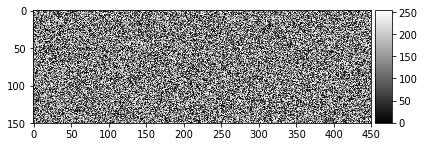

OUTPUT


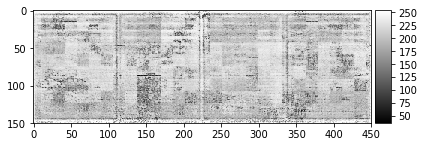

TARGET


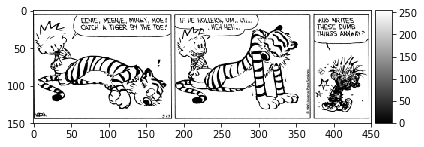

step  0 / 7367 d_loss:  0.00013650997425429523 g_loss:  [50.422585, 0.49314925, 1.1076581]
step  1 / 7367 d_loss:  4.5914322981843725e-05 g_loss:  [46.38265, 0.45277312, 1.1053343]
step  2 / 7367 d_loss:  0.0005182418972253799 g_loss:  [41.940243, 0.4085098, 1.0892631]
step  3 / 7367 d_loss:  0.0006439994904212654 g_loss:  [52.00624, 0.5092519, 1.0810523]
step  4 / 7367 d_loss:  0.0012901757145300508 g_loss:  [52.12199, 0.5106059, 1.0613997]
step  5 / 7367 d_loss:  0.0021830550394952297 g_loss:  [54.447853, 0.53411716, 1.0361366]
step  6 / 7367 d_loss:  0.0023003313690423965 g_loss:  [44.41643, 0.43420497, 0.9959333]
step  7 / 7367 d_loss:  0.0010171378962695599 g_loss:  [49.652813, 0.48700452, 0.9523636]
step  8 / 7367 d_loss:  0.0005606422782875597 g_loss:  [44.511898, 0.4362036, 0.8915352]
step  9 / 7367 d_loss:  0.00013920670608058572 g_loss:  [42.202908, 0.41350788, 0.85212034]
step  10 / 7367 d_loss:  3.5025200304517057e-06 g_loss:  [40.80769, 0.3999372, 0.81396717]
step  11 / 73

step  92 / 7367 d_loss:  0.00142606848385185 g_loss:  [45.49281, 0.44396555, 1.0962526]
step  93 / 7367 d_loss:  0.0009495335398241878 g_loss:  [53.16774, 0.52091557, 1.0761832]
step  94 / 7367 d_loss:  0.0007278328412212431 g_loss:  [43.269653, 0.4223257, 1.0370811]
step  95 / 7367 d_loss:  0.0009370121988467872 g_loss:  [43.51525, 0.4250265, 1.0125984]
step  96 / 7367 d_loss:  0.0011862580431625247 g_loss:  [49.521725, 0.48546746, 0.9749778]
step  97 / 7367 d_loss:  0.00021100585581734776 g_loss:  [42.92345, 0.4197134, 0.95211035]
step  98 / 7367 d_loss:  0.00038528384175151587 g_loss:  [53.020477, 0.5208513, 0.9353433]
step  99 / 7367 d_loss:  0.0004174277710262686 g_loss:  [49.061443, 0.48136544, 0.92490107]
step  100 / 7367 d_loss:  0.000644118816126138 g_loss:  [63.043343, 0.621256, 0.91774505]
step  101 / 7367 d_loss:  0.0002948091132566333 g_loss:  [51.957825, 0.5102618, 0.9316468]
step  102 / 7367 d_loss:  7.254089723573998e-05 g_loss:  [57.2733, 0.5632259, 0.9507046]
step  10

step  182 / 7367 d_loss:  0.0006978967576287687 g_loss:  [70.06371, 0.69174665, 0.8890468]
step  183 / 7367 d_loss:  0.0012278960784897208 g_loss:  [43.24737, 0.4233268, 0.9146912]
step  184 / 7367 d_loss:  0.0006007018382661045 g_loss:  [44.393234, 0.43472993, 0.92024136]
step  185 / 7367 d_loss:  0.0006400260026566684 g_loss:  [48.479134, 0.47542444, 0.93669]
step  186 / 7367 d_loss:  0.000880058913026005 g_loss:  [46.306965, 0.45353767, 0.9531958]
step  187 / 7367 d_loss:  0.0014886688441038132 g_loss:  [60.14055, 0.5916704, 0.97351104]
step  188 / 7367 d_loss:  0.0012380187399685383 g_loss:  [49.40776, 0.48411152, 0.99661064]
step  189 / 7367 d_loss:  0.0007078376365825534 g_loss:  [48.3354, 0.4730764, 1.0277596]
step  190 / 7367 d_loss:  6.651344301644713e-05 g_loss:  [45.67962, 0.44604778, 1.0748398]
step  191 / 7367 d_loss:  0.00023318723833654076 g_loss:  [40.668907, 0.3955401, 1.1148981]
step  192 / 7367 d_loss:  0.0011304720537737012 g_loss:  [51.897655, 0.5077223, 1.125425]


step  273 / 7367 d_loss:  0.00016760951257310808 g_loss:  [39.740078, 0.38645074, 1.0950032]
step  274 / 7367 d_loss:  0.0002449546882417053 g_loss:  [50.82994, 0.4973234, 1.0976042]
step  275 / 7367 d_loss:  0.00028441997710615396 g_loss:  [40.071712, 0.389528, 1.1189127]
step  276 / 7367 d_loss:  0.00027293708990328014 g_loss:  [45.414394, 0.44298533, 1.1158617]
step  277 / 7367 d_loss:  2.7852329367306083e-05 g_loss:  [47.85614, 0.46735686, 1.1204544]
step  278 / 7367 d_loss:  1.531118141429033e-05 g_loss:  [48.060413, 0.4693135, 1.1290643]
step  279 / 7367 d_loss:  4.148832886130549e-05 g_loss:  [42.32368, 0.41198954, 1.124726]
step  280 / 7367 d_loss:  0.0002071905037155375 g_loss:  [40.812794, 0.39696458, 1.1163357]
step  281 / 7367 d_loss:  4.481383803067729e-05 g_loss:  [77.176704, 0.76065224, 1.1114795]
step  282 / 7367 d_loss:  6.832604412920773e-05 g_loss:  [45.942368, 0.4483746, 1.1049064]
step  283 / 7367 d_loss:  0.00010352689423598349 g_loss:  [48.82012, 0.47720608, 1.09

step  363 / 7367 d_loss:  0.0007417799788527191 g_loss:  [58.196415, 0.5737068, 0.82573164]
step  364 / 7367 d_loss:  0.00014418076898436993 g_loss:  [47.293972, 0.4645042, 0.84355193]
step  365 / 7367 d_loss:  0.0001876170572359115 g_loss:  [48.96187, 0.48104966, 0.8569045]
step  366 / 7367 d_loss:  0.00037448114017024636 g_loss:  [54.76503, 0.53891444, 0.8735838]
step  367 / 7367 d_loss:  0.000533370184712112 g_loss:  [49.41417, 0.48518062, 0.89610815]
step  368 / 7367 d_loss:  0.0003864708705805242 g_loss:  [51.92592, 0.50990695, 0.935224]
step  369 / 7367 d_loss:  0.0003764416615013033 g_loss:  [48.22636, 0.4725746, 0.9689018]
step  370 / 7367 d_loss:  0.0002608511131256819 g_loss:  [43.82814, 0.42822227, 1.005912]
step  371 / 7367 d_loss:  0.00023843059898354113 g_loss:  [50.10869, 0.4907365, 1.0350388]
step  372 / 7367 d_loss:  8.372562297154218e-05 g_loss:  [45.16673, 0.44100204, 1.0665243]
step  373 / 7367 d_loss:  2.4773753466433845e-05 g_loss:  [39.27223, 0.38173637, 1.098592

step  453 / 7367 d_loss:  0.00016023480566218495 g_loss:  [56.96124, 0.5587491, 1.0863291]
step  454 / 7367 d_loss:  0.00010502577060833573 g_loss:  [46.06638, 0.45004722, 1.0616581]
step  455 / 7367 d_loss:  0.00012661471555475146 g_loss:  [44.62915, 0.43588933, 1.0402198]
step  456 / 7367 d_loss:  0.00030736858025193214 g_loss:  [47.185467, 0.46160075, 1.0253915]
step  457 / 7367 d_loss:  0.00017290980031248182 g_loss:  [40.00767, 0.39011544, 0.9961286]
step  458 / 7367 d_loss:  3.834968083538115e-05 g_loss:  [54.420223, 0.5344067, 0.97954756]
step  459 / 7367 d_loss:  2.1057370759081095e-05 g_loss:  [43.338737, 0.42388004, 0.9507347]
step  460 / 7367 d_loss:  1.5336323485826142e-05 g_loss:  [46.41109, 0.45475057, 0.93603694]
step  461 / 7367 d_loss:  0.0005860453238710761 g_loss:  [55.274654, 0.54343647, 0.93100697]
step  462 / 7367 d_loss:  0.00015724798140581697 g_loss:  [45.34786, 0.444138, 0.9340606]
step  463 / 7367 d_loss:  0.0002493467181921005 g_loss:  [49.52442, 0.48582733,

step  544 / 7367 d_loss:  0.00039823795668780804 g_loss:  [39.340485, 0.3832216, 1.0183256]
step  545 / 7367 d_loss:  0.0005824626423418522 g_loss:  [43.577274, 0.42555898, 1.0213761]
step  546 / 7367 d_loss:  0.0002520445850677788 g_loss:  [51.10222, 0.5010061, 1.0016075]
step  547 / 7367 d_loss:  1.8320366507396102e-05 g_loss:  [42.32071, 0.41331887, 0.98882204]
step  548 / 7367 d_loss:  9.053673420567065e-05 g_loss:  [50.423687, 0.49446377, 0.977311]
step  549 / 7367 d_loss:  0.00028212962206453085 g_loss:  [47.6015, 0.4663323, 0.9682727]
step  550 / 7367 d_loss:  0.0009208417613990605 g_loss:  [48.518192, 0.47553623, 0.9645681]
step  551 / 7367 d_loss:  0.0010419836034998298 g_loss:  [52.40202, 0.5142456, 0.9774548]
step  552 / 7367 d_loss:  0.000739653711207211 g_loss:  [52.33275, 0.51333416, 0.99933124]
step  553 / 7367 d_loss:  0.0005582524463534355 g_loss:  [49.990314, 0.48972836, 1.0174776]
step  554 / 7367 d_loss:  0.00012687942944467068 g_loss:  [53.173462, 0.5212035, 1.0531

step  635 / 7367 d_loss:  5.6787139328662306e-05 g_loss:  [43.443382, 0.4240754, 1.0358444]
step  636 / 7367 d_loss:  0.00011367529805283993 g_loss:  [53.92607, 0.5292342, 1.0026563]
step  637 / 7367 d_loss:  0.00024163247144315392 g_loss:  [48.34758, 0.4737033, 0.9772477]
step  638 / 7367 d_loss:  0.00017659488366916776 g_loss:  [46.510483, 0.45547745, 0.962738]
step  639 / 7367 d_loss:  0.000404531805543229 g_loss:  [42.343174, 0.4137007, 0.9731028]
step  640 / 7367 d_loss:  0.000176148401806131 g_loss:  [43.404957, 0.42438224, 0.96673197]
step  641 / 7367 d_loss:  7.218456448754296e-05 g_loss:  [51.97511, 0.5099675, 0.9783578]
step  642 / 7367 d_loss:  6.798440881539136e-05 g_loss:  [38.96525, 0.37984896, 0.9803526]
step  643 / 7367 d_loss:  0.0009278643992729485 g_loss:  [51.40006, 0.50411546, 0.98851234]
step  644 / 7367 d_loss:  0.00024111222592182457 g_loss:  [67.41309, 0.6643219, 0.9809007]
step  645 / 7367 d_loss:  0.00023886399867478758 g_loss:  [57.68652, 0.5670546, 0.981055

step  725 / 7367 d_loss:  0.0009194402955472469 g_loss:  [47.059917, 0.4614979, 0.91012454]
step  726 / 7367 d_loss:  0.0009118773741647601 g_loss:  [46.13706, 0.4520171, 0.93535]
step  727 / 7367 d_loss:  0.00048015842912718654 g_loss:  [57.70525, 0.56735, 0.97025144]
step  728 / 7367 d_loss:  8.284052455564961e-05 g_loss:  [40.63359, 0.3962371, 1.0098796]
step  729 / 7367 d_loss:  0.00016640634567011148 g_loss:  [40.74682, 0.39707658, 1.039163]
step  730 / 7367 d_loss:  0.00023764418438076973 g_loss:  [59.847614, 0.587848, 1.0628138]
step  731 / 7367 d_loss:  0.0002934614894911647 g_loss:  [54.356003, 0.53279793, 1.0762113]
step  732 / 7367 d_loss:  0.0005257060984149575 g_loss:  [41.871902, 0.40797564, 1.0743389]
step  733 / 7367 d_loss:  0.0007045845850370824 g_loss:  [45.7469, 0.44690016, 1.0568813]
step  734 / 7367 d_loss:  0.000892645912244916 g_loss:  [36.8777, 0.3584893, 1.0287687]
step  735 / 7367 d_loss:  0.0008661102037876844 g_loss:  [34.497746, 0.33509013, 0.9887316]
step

step  815 / 7367 d_loss:  4.7092558816075325e-05 g_loss:  [54.824837, 0.54000497, 0.8243408]
step  816 / 7367 d_loss:  0.00011764687951654196 g_loss:  [41.444984, 0.40627512, 0.8174703]
step  817 / 7367 d_loss:  0.00027072959346696734 g_loss:  [52.871586, 0.52055824, 0.81576276]
step  818 / 7367 d_loss:  0.00019060300837736577 g_loss:  [38.59276, 0.37768072, 0.8246897]
step  819 / 7367 d_loss:  9.296832286054268e-05 g_loss:  [50.989258, 0.50150836, 0.8384193]
step  820 / 7367 d_loss:  0.0001573888584971428 g_loss:  [51.052605, 0.5020781, 0.8447908]
step  821 / 7367 d_loss:  0.00033922548755072057 g_loss:  [50.34991, 0.4949001, 0.8599004]
step  822 / 7367 d_loss:  0.00010262740397593006 g_loss:  [51.0331, 0.5014156, 0.8915416]
step  823 / 7367 d_loss:  0.0006666918052360415 g_loss:  [43.323273, 0.42414382, 0.90889114]
step  824 / 7367 d_loss:  0.000710022693965584 g_loss:  [39.618595, 0.38689536, 0.9290595]
step  825 / 7367 d_loss:  0.0005055334768258035 g_loss:  [53.37932, 0.5241791, 0

step  905 / 7367 d_loss:  2.2362350136972964e-05 g_loss:  [50.044235, 0.49062142, 0.9820923]
step  906 / 7367 d_loss:  3.31400333379861e-05 g_loss:  [75.65091, 0.74650395, 1.0005122]
step  907 / 7367 d_loss:  0.00023517885711044073 g_loss:  [46.229546, 0.45223054, 1.0064921]
step  908 / 7367 d_loss:  0.00036184125929139555 g_loss:  [44.145382, 0.4313866, 1.0067232]
step  909 / 7367 d_loss:  0.00013117559137754142 g_loss:  [44.965263, 0.43964985, 1.0002792]
step  910 / 7367 d_loss:  7.169548916863278e-05 g_loss:  [39.939747, 0.38941482, 0.99826413]
step  911 / 7367 d_loss:  0.0001080817382899113 g_loss:  [48.91705, 0.47914654, 1.0023942]
step  912 / 7367 d_loss:  0.0005136177642270923 g_loss:  [38.67985, 0.37680125, 0.99972665]
step  913 / 7367 d_loss:  0.0010822665644809604 g_loss:  [46.775112, 0.45759544, 1.0155687]
step  914 / 7367 d_loss:  0.0009667556150816381 g_loss:  [49.07336, 0.4804381, 1.0295484]
step  915 / 7367 d_loss:  0.000935307121835649 g_loss:  [42.756393, 0.4169467, 1.

step  996 / 7367 d_loss:  0.0002911378687713295 g_loss:  [45.23881, 0.44024542, 1.2142669]
step  997 / 7367 d_loss:  0.0004798794398084283 g_loss:  [38.57656, 0.3737395, 1.2026112]
step  998 / 7367 d_loss:  0.0003164642257615924 g_loss:  [48.813034, 0.4763945, 1.1735835]
step  999 / 7367 d_loss:  0.00022417533909901977 g_loss:  [44.068092, 0.4291498, 1.1531122]
step  1000 / 7367 d_loss:  8.822724339552224e-05 g_loss:  [50.06787, 0.4894969, 1.1181842]
step  1001 / 7367 d_loss:  8.385144610656425e-05 g_loss:  [51.600845, 0.5051722, 1.0836252]
step  1002 / 7367 d_loss:  0.0001877204340416938 g_loss:  [60.85716, 0.5979233, 1.0648324]
step  1003 / 7367 d_loss:  0.00018301392265129834 g_loss:  [54.31996, 0.5327957, 1.0403895]
step  1004 / 7367 d_loss:  0.0002610530937090516 g_loss:  [49.34328, 0.48311424, 1.0318564]
step  1005 / 7367 d_loss:  0.0002677915617823601 g_loss:  [46.198235, 0.4516442, 1.0338149]
step  1006 / 7367 d_loss:  0.00018914759857580066 g_loss:  [47.617985, 0.46579206, 1.0

step  1086 / 7367 d_loss:  0.0009082994656637311 g_loss:  [38.289803, 0.37212852, 1.0769501]
step  1087 / 7367 d_loss:  0.000130366490338929 g_loss:  [52.199898, 0.5107243, 1.1274681]
step  1088 / 7367 d_loss:  0.0001368480734527111 g_loss:  [45.232502, 0.44061816, 1.1706846]
step  1089 / 7367 d_loss:  0.0008146436302922666 g_loss:  [50.070965, 0.48863328, 1.207639]
step  1090 / 7367 d_loss:  0.001381504349410534 g_loss:  [49.23302, 0.48027772, 1.2052499]
step  1091 / 7367 d_loss:  0.001638595131225884 g_loss:  [46.354828, 0.45169458, 1.1853716]
step  1092 / 7367 d_loss:  0.0011442155810073018 g_loss:  [63.672123, 0.6253336, 1.1387649]
step  1093 / 7367 d_loss:  0.000378334749257192 g_loss:  [57.36431, 0.5627709, 1.0872195]
step  1094 / 7367 d_loss:  1.4387633200385608e-05 g_loss:  [46.07711, 0.45050377, 1.0267328]
step  1095 / 7367 d_loss:  0.0003908598446287215 g_loss:  [43.577774, 0.4259221, 0.98556554]
step  1096 / 7367 d_loss:  0.0013245180016383529 g_loss:  [51.321964, 0.50357985

step  1175 / 7367 d_loss:  0.0001596973743289709 g_loss:  [49.167965, 0.48137945, 1.0300229]
step  1176 / 7367 d_loss:  4.750486186821945e-05 g_loss:  [43.456795, 0.42438895, 1.0178981]
step  1177 / 7367 d_loss:  2.2100211936049163e-05 g_loss:  [50.180977, 0.49176234, 1.0047401]
step  1178 / 7367 d_loss:  3.247526183258742e-05 g_loss:  [53.88417, 0.52896637, 0.9875337]
step  1179 / 7367 d_loss:  2.7619073080131784e-05 g_loss:  [48.55856, 0.4758078, 0.9777801]
step  1180 / 7367 d_loss:  0.00010766986815724522 g_loss:  [44.364777, 0.43391714, 0.97306556]
step  1181 / 7367 d_loss:  3.9573251342517324e-07 g_loss:  [53.9023, 0.529391, 0.9632032]
step  1182 / 7367 d_loss:  8.944063665694557e-06 g_loss:  [60.442276, 0.5949273, 0.9495486]
step  1183 / 7367 d_loss:  3.395658131921664e-05 g_loss:  [52.207012, 0.5126001, 0.9469969]
step  1184 / 7367 d_loss:  1.896914909593761e-05 g_loss:  [45.733204, 0.4480041, 0.93279207]
step  1185 / 7367 d_loss:  9.601269266568124e-05 g_loss:  [45.928047, 0.44

step  1265 / 7367 d_loss:  0.00012966433132532984 g_loss:  [42.231575, 0.41207907, 1.0236701]
step  1266 / 7367 d_loss:  0.00013902834325563163 g_loss:  [48.62998, 0.47627974, 1.0020034]
step  1267 / 7367 d_loss:  0.0001439244661014527 g_loss:  [45.349983, 0.44377887, 0.972095]
step  1268 / 7367 d_loss:  7.179933891166002e-05 g_loss:  [48.65567, 0.47707686, 0.9479812]
step  1269 / 7367 d_loss:  8.305378287332132e-05 g_loss:  [47.626232, 0.46700856, 0.92537546]
step  1270 / 7367 d_loss:  5.868009338882985e-06 g_loss:  [53.72013, 0.52810717, 0.90941477]
step  1271 / 7367 d_loss:  4.5940141717437655e-05 g_loss:  [38.497, 0.3759855, 0.8984518]
step  1272 / 7367 d_loss:  5.760706335422583e-05 g_loss:  [50.021633, 0.4913044, 0.89119184]
step  1273 / 7367 d_loss:  1.1701647508743918e-06 g_loss:  [49.020878, 0.48134547, 0.88633126]
step  1274 / 7367 d_loss:  1.2944084119226318e-05 g_loss:  [74.26903, 0.7338707, 0.88195664]
step  1275 / 7367 d_loss:  6.179060437716544e-05 g_loss:  [50.887722, 0

step  1355 / 7367 d_loss:  0.0001007281243801117 g_loss:  [48.481327, 0.47549284, 0.93204373]
step  1356 / 7367 d_loss:  0.00022435671417042613 g_loss:  [45.508347, 0.44581926, 0.92642224]
step  1357 / 7367 d_loss:  7.436249870806932e-05 g_loss:  [57.911015, 0.56995374, 0.9156423]
step  1358 / 7367 d_loss:  0.00014678368461318314 g_loss:  [34.34081, 0.33431396, 0.9094117]
step  1359 / 7367 d_loss:  0.0002756021567620337 g_loss:  [44.157875, 0.43262234, 0.8956418]
step  1360 / 7367 d_loss:  0.00017586407193448395 g_loss:  [55.66714, 0.54785186, 0.88195485]
step  1361 / 7367 d_loss:  3.223463863832876e-05 g_loss:  [47.160328, 0.4629468, 0.86564785]
step  1362 / 7367 d_loss:  0.0003847877378575504 g_loss:  [43.512455, 0.42660886, 0.8515702]
step  1363 / 7367 d_loss:  0.00044030576827935874 g_loss:  [48.01398, 0.47155565, 0.85841566]
step  1364 / 7367 d_loss:  0.0011701487237587571 g_loss:  [43.496693, 0.4262735, 0.8693433]
step  1365 / 7367 d_loss:  0.0010283690644428134 g_loss:  [59.7441

step  1445 / 7367 d_loss:  0.00020836439216509461 g_loss:  [52.152893, 0.5114501, 1.0078816]
step  1446 / 7367 d_loss:  0.00037221776437945664 g_loss:  [53.738777, 0.5272571, 1.0130696]
step  1447 / 7367 d_loss:  0.0003978612076025456 g_loss:  [50.4161, 0.4938438, 1.0317184]
step  1448 / 7367 d_loss:  0.0003110937250312418 g_loss:  [45.017944, 0.4396478, 1.0531648]
step  1449 / 7367 d_loss:  9.281634993385524e-05 g_loss:  [47.60791, 0.46532273, 1.0756377]
step  1450 / 7367 d_loss:  6.0124268202343956e-05 g_loss:  [45.124374, 0.44018158, 1.1062163]
step  1451 / 7367 d_loss:  0.00010521526564843953 g_loss:  [52.92703, 0.5181507, 1.1119622]
step  1452 / 7367 d_loss:  0.00039015462971292436 g_loss:  [47.730446, 0.46614695, 1.1157547]
step  1453 / 7367 d_loss:  0.0007488609990105033 g_loss:  [35.007336, 0.3390867, 1.0986625]
step  1454 / 7367 d_loss:  0.00023616374528501183 g_loss:  [43.991074, 0.42908105, 1.0829703]
step  1455 / 7367 d_loss:  6.426664185710251e-05 g_loss:  [45.73578, 0.446

step  1534 / 7367 d_loss:  0.00042280700290575624 g_loss:  [52.87844, 0.5181805, 1.0603919]
step  1535 / 7367 d_loss:  0.0005583039601333439 g_loss:  [38.17868, 0.37142485, 1.0361949]
step  1536 / 7367 d_loss:  0.00023412395967170596 g_loss:  [49.195255, 0.48184368, 1.0108877]
step  1537 / 7367 d_loss:  0.00015027410699985921 g_loss:  [50.825138, 0.49842623, 0.9825144]
step  1538 / 7367 d_loss:  2.647977089509368e-05 g_loss:  [45.257572, 0.4430106, 0.95651335]
step  1539 / 7367 d_loss:  1.9480023183859885e-05 g_loss:  [54.991467, 0.54065555, 0.92591196]
step  1540 / 7367 d_loss:  3.2893291290747584e-07 g_loss:  [49.075233, 0.48168084, 0.90715086]
step  1541 / 7367 d_loss:  8.880205859895796e-05 g_loss:  [56.689327, 0.55790126, 0.8992017]
step  1542 / 7367 d_loss:  0.00013256646343506873 g_loss:  [67.46522, 0.66581553, 0.8836649]
step  1543 / 7367 d_loss:  0.00023337428865488619 g_loss:  [52.352264, 0.51481843, 0.87042046]
step  1544 / 7367 d_loss:  0.00036354357143864036 g_loss:  [52.1

step  1623 / 7367 d_loss:  0.0009899087017402053 g_loss:  [43.932217, 0.42957044, 0.9751757]
step  1624 / 7367 d_loss:  0.0005113857332617044 g_loss:  [44.2087, 0.4319349, 1.0152102]
step  1625 / 7367 d_loss:  0.00017293464043177664 g_loss:  [43.87284, 0.42812067, 1.0607723]
step  1626 / 7367 d_loss:  0.0001948056451510638 g_loss:  [50.67728, 0.4957722, 1.100058]
step  1627 / 7367 d_loss:  0.00023739591415505856 g_loss:  [45.074203, 0.43957108, 1.1170958]
step  1628 / 7367 d_loss:  0.0005620424053631723 g_loss:  [50.550278, 0.49423593, 1.1266865]
step  1629 / 7367 d_loss:  0.0006573888822458684 g_loss:  [48.943607, 0.47837883, 1.1057256]
step  1630 / 7367 d_loss:  0.0007438729517161846 g_loss:  [33.192005, 0.321173, 1.0747037]
step  1631 / 7367 d_loss:  0.0002972101792693138 g_loss:  [46.97428, 0.45943147, 1.0311344]
step  1632 / 7367 d_loss:  7.311457011383027e-05 g_loss:  [46.276936, 0.45275712, 1.0012256]
step  1633 / 7367 d_loss:  7.060129973979201e-06 g_loss:  [54.622322, 0.536528

step  1713 / 7367 d_loss:  0.0001543139514978975 g_loss:  [40.45054, 0.3923469, 1.2158524]
step  1714 / 7367 d_loss:  0.0006590097909793258 g_loss:  [46.879856, 0.45634624, 1.2452334]
step  1715 / 7367 d_loss:  0.0008057754603214562 g_loss:  [51.46274, 0.50225645, 1.2370955]
step  1716 / 7367 d_loss:  0.0010614076163619757 g_loss:  [37.00003, 0.35789305, 1.2107251]
step  1717 / 7367 d_loss:  0.0009125453652814031 g_loss:  [48.85988, 0.47673732, 1.1861469]
step  1718 / 7367 d_loss:  0.0003322192933410406 g_loss:  [37.696964, 0.36557662, 1.139302]
step  1719 / 7367 d_loss:  0.00015096695278771222 g_loss:  [46.19144, 0.4508824, 1.1031972]
step  1720 / 7367 d_loss:  4.974375042365864e-05 g_loss:  [63.23022, 0.62174237, 1.0559859]
step  1721 / 7367 d_loss:  0.00013071970897726715 g_loss:  [61.723152, 0.60709363, 1.013792]
step  1722 / 7367 d_loss:  9.438645793125033e-05 g_loss:  [45.912163, 0.449378, 0.97436076]
step  1723 / 7367 d_loss:  0.00029279905720613897 g_loss:  [45.75292, 0.4479045

step  1802 / 7367 d_loss:  0.0009466494084335864 g_loss:  [51.503895, 0.50544065, 0.95983094]
step  1803 / 7367 d_loss:  9.706112905405462e-05 g_loss:  [48.152477, 0.47129732, 1.022745]
step  1804 / 7367 d_loss:  0.00019790520309470594 g_loss:  [115.54306, 1.144756, 1.0674703]
step  1805 / 7367 d_loss:  0.0011713904095813632 g_loss:  [41.80252, 0.40675864, 1.1266558]
step  1806 / 7367 d_loss:  0.001948972581885755 g_loss:  [47.29421, 0.4615885, 1.1353556]
step  1807 / 7367 d_loss:  0.0017624234315007925 g_loss:  [69.278244, 0.68173957, 1.1042848]
step  1808 / 7367 d_loss:  0.0004910879069939256 g_loss:  [51.36966, 0.5031042, 1.0592369]
step  1809 / 7367 d_loss:  0.00020067751756869256 g_loss:  [42.504997, 0.4150294, 1.0020543]
step  1810 / 7367 d_loss:  0.00069128826726228 g_loss:  [83.88296, 0.8292196, 0.96099854]
step  1811 / 7367 d_loss:  0.0006155789596959949 g_loss:  [49.888107, 0.4892285, 0.9652578]
step  1812 / 7367 d_loss:  0.0003918783913832158 g_loss:  [45.72216, 0.44745383, 

step  1892 / 7367 d_loss:  0.00025571585865691304 g_loss:  [40.500515, 0.39531836, 0.968677]
step  1893 / 7367 d_loss:  0.00017681119788903743 g_loss:  [51.419518, 0.5046743, 0.9520886]
step  1894 / 7367 d_loss:  2.839001899701543e-05 g_loss:  [39.432102, 0.38504636, 0.92746806]
step  1895 / 7367 d_loss:  2.762298936431762e-05 g_loss:  [52.049202, 0.51127744, 0.9214584]
step  1896 / 7367 d_loss:  0.00023106923617888242 g_loss:  [54.819504, 0.5390992, 0.9095849]
step  1897 / 7367 d_loss:  0.00029880672809667885 g_loss:  [49.774857, 0.488607, 0.9141574]
step  1898 / 7367 d_loss:  0.0003093947598244995 g_loss:  [43.19622, 0.42267168, 0.92905456]
step  1899 / 7367 d_loss:  0.0003809216432273388 g_loss:  [53.003532, 0.5205891, 0.9446202]
step  1900 / 7367 d_loss:  0.00023811933351680636 g_loss:  [73.865364, 0.72889096, 0.9762616]
step  1901 / 7367 d_loss:  0.00022652701591141522 g_loss:  [47.88645, 0.4688418, 1.0022722]
step  1902 / 7367 d_loss:  0.0002613561227917671 g_loss:  [37.643105, 0

step  1982 / 7367 d_loss:  0.00010120501974597573 g_loss:  [64.40279, 0.63285476, 1.1173126]
step  1983 / 7367 d_loss:  2.430970562272705e-05 g_loss:  [41.538605, 0.4041794, 1.1206672]
step  1984 / 7367 d_loss:  8.335524398717098e-06 g_loss:  [51.08524, 0.49962175, 1.1230675]
step  1985 / 7367 d_loss:  3.850030407193117e-05 g_loss:  [49.87467, 0.48746076, 1.1285921]
step  1986 / 7367 d_loss:  0.00012226193211972713 g_loss:  [40.548916, 0.3942893, 1.1199853]
step  1987 / 7367 d_loss:  0.0002964487357530743 g_loss:  [39.49649, 0.3838496, 1.1115298]
step  1988 / 7367 d_loss:  0.0006027156487107277 g_loss:  [38.434944, 0.37351227, 1.0837163]
step  1989 / 7367 d_loss:  0.000982246594503522 g_loss:  [51.45377, 0.50403845, 1.0499237]
step  1990 / 7367 d_loss:  0.0012013802770525217 g_loss:  [35.603207, 0.34597936, 1.0052705]
step  1991 / 7367 d_loss:  0.0008506953017786145 g_loss:  [39.60337, 0.3864278, 0.9605907]
step  1992 / 7367 d_loss:  0.00047808754607103765 g_loss:  [41.054226, 0.401452

step  2071 / 7367 d_loss:  9.358635725220665e-05 g_loss:  [54.450897, 0.53377485, 1.0734097]
step  2072 / 7367 d_loss:  2.776883775368333e-05 g_loss:  [50.10022, 0.49011475, 1.0887444]
step  2073 / 7367 d_loss:  1.9460559997241944e-05 g_loss:  [44.798237, 0.4370597, 1.0922676]
step  2074 / 7367 d_loss:  1.0317272653992404e-06 g_loss:  [51.980217, 0.50880206, 1.1000099]
step  2075 / 7367 d_loss:  2.078634497593157e-05 g_loss:  [80.7177, 0.79625875, 1.0918189]
step  2076 / 7367 d_loss:  5.6599907111376524e-05 g_loss:  [35.878513, 0.34800687, 1.0778271]
step  2077 / 7367 d_loss:  4.467307371669449e-05 g_loss:  [56.78296, 0.55712533, 1.0704268]
step  2078 / 7367 d_loss:  0.00018650507263373584 g_loss:  [41.200954, 0.40155077, 1.0458803]
step  2079 / 7367 d_loss:  0.00010883202776312828 g_loss:  [48.227264, 0.47202945, 1.0243199]
step  2080 / 7367 d_loss:  0.0002099295670632273 g_loss:  [53.321842, 0.52325195, 0.9966478]
step  2081 / 7367 d_loss:  5.7979199482360855e-05 g_loss:  [47.072845,

step  2161 / 7367 d_loss:  0.0003826774191111326 g_loss:  [36.981293, 0.35796013, 1.1852788]
step  2162 / 7367 d_loss:  0.00011350335262250155 g_loss:  [50.254726, 0.49069723, 1.1850026]
step  2163 / 7367 d_loss:  0.00013161922106519341 g_loss:  [47.83703, 0.46659073, 1.1779567]
step  2164 / 7367 d_loss:  0.00020846218103542924 g_loss:  [56.855705, 0.55679476, 1.176228]
step  2165 / 7367 d_loss:  9.041270095622167e-05 g_loss:  [47.3074, 0.46142656, 1.164744]
step  2166 / 7367 d_loss:  9.744956514623482e-06 g_loss:  [54.14688, 0.5299036, 1.1565198]
step  2167 / 7367 d_loss:  2.4112969185807742e-05 g_loss:  [62.4579, 0.6130378, 1.1541181]
step  2168 / 7367 d_loss:  6.81919336784631e-05 g_loss:  [49.370533, 0.48234344, 1.1361887]
step  2169 / 7367 d_loss:  4.984054248780012e-05 g_loss:  [55.445663, 0.54328084, 1.1175815]
step  2170 / 7367 d_loss:  0.00014132520300336182 g_loss:  [44.95016, 0.43847707, 1.1024559]
step  2171 / 7367 d_loss:  0.0001785655040293932 g_loss:  [37.937943, 0.36848

step  2251 / 7367 d_loss:  3.867314262606669e-06 g_loss:  [55.953697, 0.55020416, 0.9332795]
step  2252 / 7367 d_loss:  4.823141352972016e-05 g_loss:  [48.623917, 0.47696307, 0.9276085]
step  2253 / 7367 d_loss:  0.00019550800789147615 g_loss:  [44.094967, 0.43167976, 0.9269901]
step  2254 / 7367 d_loss:  0.000555292353965342 g_loss:  [47.465233, 0.46530965, 0.93426937]
step  2255 / 7367 d_loss:  0.0011040419340133667 g_loss:  [49.87989, 0.48928767, 0.9511232]
step  2256 / 7367 d_loss:  0.0008096455130726099 g_loss:  [48.483124, 0.47492215, 0.99090886]
step  2257 / 7367 d_loss:  0.0005423265974968672 g_loss:  [35.34452, 0.34309575, 1.0349481]
step  2258 / 7367 d_loss:  0.00015200857887975872 g_loss:  [47.662437, 0.46584168, 1.0782715]
step  2259 / 7367 d_loss:  3.851540895993821e-05 g_loss:  [54.447414, 0.5332708, 1.1203378]
step  2260 / 7367 d_loss:  0.00020836379553657025 g_loss:  [56.228832, 0.55085385, 1.1434473]
step  2261 / 7367 d_loss:  0.0008149421191774309 g_loss:  [43.744186,

step  2341 / 7367 d_loss:  0.0001333232648903504 g_loss:  [45.801342, 0.44799012, 1.0023307]
step  2342 / 7367 d_loss:  0.00022493790311273187 g_loss:  [53.06396, 0.5204651, 1.0174519]
step  2343 / 7367 d_loss:  6.117679731687531e-05 g_loss:  [33.694344, 0.32658333, 1.0360126]
step  2344 / 7367 d_loss:  0.0001001382916001603 g_loss:  [48.44393, 0.47392043, 1.0518868]
step  2345 / 7367 d_loss:  0.00011118711699964479 g_loss:  [40.540085, 0.39466473, 1.0736115]
step  2346 / 7367 d_loss:  0.0003200150094926357 g_loss:  [46.325478, 0.45245564, 1.0799152]
step  2347 / 7367 d_loss:  0.00041008202242664993 g_loss:  [49.60106, 0.48526856, 1.0742037]
step  2348 / 7367 d_loss:  0.0002714268921408802 g_loss:  [48.656517, 0.47605667, 1.0508491]
step  2349 / 7367 d_loss:  0.00020616166875697672 g_loss:  [46.314297, 0.45285457, 1.0288378]
step  2350 / 7367 d_loss:  6.037337880115956e-05 g_loss:  [51.903328, 0.5090976, 0.99356675]
step  2351 / 7367 d_loss:  4.7866429667919874e-05 g_loss:  [57.195583,

step  2430 / 7367 d_loss:  0.00016573195171076804 g_loss:  [40.16458, 0.3921839, 0.946188]
step  2431 / 7367 d_loss:  0.00013400234456639737 g_loss:  [46.129997, 0.4519239, 0.9376073]
step  2432 / 7367 d_loss:  7.440549961756915e-05 g_loss:  [36.875305, 0.35940197, 0.9351064]
step  2433 / 7367 d_loss:  0.00039970711804926395 g_loss:  [40.8979, 0.39962047, 0.93585044]
step  2434 / 7367 d_loss:  0.00011131728388136253 g_loss:  [41.240032, 0.40313306, 0.9267288]
step  2435 / 7367 d_loss:  8.39290369185619e-05 g_loss:  [51.63845, 0.50715744, 0.9227049]
step  2436 / 7367 d_loss:  0.00018864327284973115 g_loss:  [42.74426, 0.41835997, 0.9082651]
step  2437 / 7367 d_loss:  0.0001193219140986912 g_loss:  [42.18316, 0.41275162, 0.90799624]
step  2438 / 7367 d_loss:  0.00017681824101600796 g_loss:  [48.157516, 0.47241458, 0.91605633]
step  2439 / 7367 d_loss:  0.00033978658029809594 g_loss:  [51.660183, 0.507362, 0.92397946]
step  2440 / 7367 d_loss:  0.00023755135771352798 g_loss:  [48.3327, 0.

step  2519 / 7367 d_loss:  2.2921463823877275e-05 g_loss:  [44.045654, 0.429341, 1.1115575]
step  2520 / 7367 d_loss:  5.659318412654102e-05 g_loss:  [53.215805, 0.52117914, 1.0978947]
step  2521 / 7367 d_loss:  0.00010340438166167587 g_loss:  [42.21597, 0.41118118, 1.0978518]
step  2522 / 7367 d_loss:  0.00017566911992616951 g_loss:  [48.16268, 0.47069284, 1.0933974]
step  2523 / 7367 d_loss:  0.0001775069977156818 g_loss:  [62.05936, 0.60955423, 1.1039398]
step  2524 / 7367 d_loss:  1.561928183946293e-05 g_loss:  [39.51008, 0.38402778, 1.1072991]
step  2525 / 7367 d_loss:  0.00011170880316058174 g_loss:  [38.9814, 0.37882012, 1.0993884]
step  2526 / 7367 d_loss:  0.0001784313644748181 g_loss:  [58.117767, 0.57025, 1.0927713]
step  2527 / 7367 d_loss:  6.804196891607717e-05 g_loss:  [46.33325, 0.45255676, 1.0775716]
step  2528 / 7367 d_loss:  5.360354407457635e-05 g_loss:  [50.7756, 0.49715823, 1.059777]
step  2529 / 7367 d_loss:  6.504152406705543e-05 g_loss:  [43.824924, 0.42785636,

step  2608 / 7367 d_loss:  0.0005622121971100569 g_loss:  [46.258644, 0.45380342, 0.8783052]
step  2609 / 7367 d_loss:  7.394902058877051e-05 g_loss:  [47.38471, 0.4645786, 0.9268511]
step  2610 / 7367 d_loss:  1.6889482139959e-05 g_loss:  [51.668995, 0.50695634, 0.9733629]
step  2611 / 7367 d_loss:  5.077300738776103e-05 g_loss:  [53.124485, 0.5211843, 1.0060538]
step  2612 / 7367 d_loss:  0.0001678439148236066 g_loss:  [49.213825, 0.48183534, 1.0302942]
step  2613 / 7367 d_loss:  0.00015993582201190293 g_loss:  [62.311436, 0.6127114, 1.0402954]
step  2614 / 7367 d_loss:  1.1819679457403254e-05 g_loss:  [58.644554, 0.5760513, 1.0394264]
step  2615 / 7367 d_loss:  3.221741280867718e-05 g_loss:  [51.22187, 0.50190246, 1.0316254]
step  2616 / 7367 d_loss:  6.632904842263088e-05 g_loss:  [49.88299, 0.4885364, 1.0293528]
step  2617 / 7367 d_loss:  3.847695188596845e-05 g_loss:  [51.894634, 0.5086268, 1.0319533]
step  2618 / 7367 d_loss:  0.0002729875559452921 g_loss:  [34.224693, 0.3319417

step  2698 / 7367 d_loss:  1.5201147107291035e-05 g_loss:  [50.799442, 0.49750173, 1.04927]
step  2699 / 7367 d_loss:  7.65712684369646e-05 g_loss:  [39.726364, 0.386922, 1.0341634]
step  2700 / 7367 d_loss:  2.496006891306024e-05 g_loss:  [50.183765, 0.49166214, 1.01755]
step  2701 / 7367 d_loss:  0.00012648338451981544 g_loss:  [46.032246, 0.45040092, 0.99215394]
step  2702 / 7367 d_loss:  9.537800360703841e-05 g_loss:  [61.554657, 0.6058074, 0.97391635]
step  2703 / 7367 d_loss:  0.00012726450222544372 g_loss:  [52.273483, 0.5131701, 0.95647186]
step  2704 / 7367 d_loss:  7.961405935930088e-05 g_loss:  [51.934452, 0.5100202, 0.93243474]
step  2705 / 7367 d_loss:  0.00013391820539254695 g_loss:  [45.42248, 0.44508615, 0.9138676]
step  2706 / 7367 d_loss:  0.0003490806557238102 g_loss:  [49.186752, 0.4829764, 0.88911086]
step  2707 / 7367 d_loss:  0.000207719043828547 g_loss:  [47.83748, 0.4697278, 0.86469835]
step  2708 / 7367 d_loss:  0.00014397625636775047 g_loss:  [51.122276, 0.50

step  2788 / 7367 d_loss:  0.000664006860461086 g_loss:  [48.756554, 0.4760072, 1.1558342]
step  2789 / 7367 d_loss:  0.0006549129611812532 g_loss:  [55.524384, 0.5439546, 1.128922]
step  2790 / 7367 d_loss:  0.00044015998719260097 g_loss:  [49.22873, 0.48137808, 1.0909182]
step  2791 / 7367 d_loss:  2.2928172256797552e-05 g_loss:  [49.79067, 0.4874529, 1.0453811]
step  2792 / 7367 d_loss:  0.00018735064077191055 g_loss:  [48.94065, 0.479274, 1.013253]
step  2793 / 7367 d_loss:  0.00015542386972811073 g_loss:  [46.473526, 0.45482138, 0.99138504]
step  2794 / 7367 d_loss:  0.00011463856208138168 g_loss:  [37.068157, 0.36084634, 0.9835237]
step  2795 / 7367 d_loss:  6.434872921090573e-05 g_loss:  [46.514805, 0.45532033, 0.9827713]
step  2796 / 7367 d_loss:  0.00028764785383827984 g_loss:  [38.264263, 0.37278163, 0.9861007]
step  2797 / 7367 d_loss:  1.15874208859168e-05 g_loss:  [62.86888, 0.61877, 0.991883]
step  2798 / 7367 d_loss:  5.282250640448183e-05 g_loss:  [55.663605, 0.54668283

step  2878 / 7367 d_loss:  5.4112853831611574e-05 g_loss:  [45.25902, 0.44266847, 0.9921775]
step  2879 / 7367 d_loss:  0.0002798352506943047 g_loss:  [48.992336, 0.4798141, 1.0109252]
step  2880 / 7367 d_loss:  0.0005149359931237996 g_loss:  [57.71563, 0.5669868, 1.0169498]
step  2881 / 7367 d_loss:  0.0003448675852268934 g_loss:  [50.856453, 0.4986185, 0.994604]
step  2882 / 7367 d_loss:  0.00018132830155082047 g_loss:  [53.929424, 0.5295323, 0.97619104]
step  2883 / 7367 d_loss:  2.822806209223927e-06 g_loss:  [47.264114, 0.46310794, 0.9533196]
step  2884 / 7367 d_loss:  0.00015770134632475674 g_loss:  [49.210873, 0.48280233, 0.9306425]
step  2885 / 7367 d_loss:  0.0005924941506236792 g_loss:  [76.63601, 0.7570926, 0.926753]
step  2886 / 7367 d_loss:  0.0008955441880971193 g_loss:  [54.13234, 0.53193915, 0.93842125]
step  2887 / 7367 d_loss:  0.0007839350146241486 g_loss:  [50.06067, 0.4909349, 0.9671768]
step  2888 / 7367 d_loss:  0.00031050079269334674 g_loss:  [52.201435, 0.51195

step  2968 / 7367 d_loss:  0.0001341012684861198 g_loss:  [56.82591, 0.55827, 0.9989143]
step  2969 / 7367 d_loss:  3.5602435673354194e-05 g_loss:  [52.297085, 0.5129705, 1.0000336]
step  2970 / 7367 d_loss:  1.641797280171886e-05 g_loss:  [44.937485, 0.43940032, 0.9974534]
step  2971 / 7367 d_loss:  8.554648229619488e-05 g_loss:  [41.525013, 0.4053309, 0.99192435]
step  2972 / 7367 d_loss:  3.055423803743906e-05 g_loss:  [59.698875, 0.58702284, 0.9965884]
step  2973 / 7367 d_loss:  3.476872370811179e-05 g_loss:  [53.134636, 0.5215076, 0.98387665]
step  2974 / 7367 d_loss:  0.00021601683693006635 g_loss:  [50.07647, 0.4909875, 0.9777198]
step  2975 / 7367 d_loss:  3.1805149774299935e-05 g_loss:  [46.312923, 0.45337364, 0.97555995]
step  2976 / 7367 d_loss:  8.063096174737439e-05 g_loss:  [43.689774, 0.4271972, 0.97005314]
step  2977 / 7367 d_loss:  3.5101111279800534e-05 g_loss:  [70.43064, 0.6946618, 0.96446073]
step  2978 / 7367 d_loss:  8.744333172217011e-05 g_loss:  [39.380306, 0.3

step  3057 / 7367 d_loss:  2.915393270086497e-05 g_loss:  [52.892574, 0.5176373, 1.1288412]
step  3058 / 7367 d_loss:  6.17838159087114e-05 g_loss:  [53.27649, 0.52153313, 1.1231776]
step  3059 / 7367 d_loss:  0.00010856721928576007 g_loss:  [48.796368, 0.4766427, 1.1321001]
step  3060 / 7367 d_loss:  0.00011446926509961486 g_loss:  [42.84176, 0.4169304, 1.148719]
step  3061 / 7367 d_loss:  9.220342326443642e-05 g_loss:  [52.440758, 0.512713, 1.1694574]
step  3062 / 7367 d_loss:  0.0001267722254851833 g_loss:  [49.90898, 0.48727846, 1.1811376]
step  3063 / 7367 d_loss:  0.00020256199059076607 g_loss:  [47.527367, 0.46347767, 1.1796007]
step  3064 / 7367 d_loss:  0.0004573011538013816 g_loss:  [41.448696, 0.4026973, 1.1789672]
step  3065 / 7367 d_loss:  0.00018504424951970577 g_loss:  [45.689064, 0.4452794, 1.1611236]
step  3066 / 7367 d_loss:  0.00015484364121221006 g_loss:  [56.363586, 0.5523012, 1.133463]
step  3067 / 7367 d_loss:  8.276270818896592e-05 g_loss:  [53.59377, 0.5248398,

step  3147 / 7367 d_loss:  4.189468745607883e-05 g_loss:  [51.04979, 0.5014963, 0.90015906]
step  3148 / 7367 d_loss:  0.0005741427885368466 g_loss:  [43.76592, 0.42853543, 0.9123769]
step  3149 / 7367 d_loss:  0.0001782968465704471 g_loss:  [40.260757, 0.39328855, 0.93190503]
step  3150 / 7367 d_loss:  0.0003564785874914378 g_loss:  [43.83441, 0.42880616, 0.9537978]
step  3151 / 7367 d_loss:  0.00016700394917279482 g_loss:  [52.369175, 0.51385707, 0.9834688]
step  3152 / 7367 d_loss:  0.00024232396390289068 g_loss:  [52.908195, 0.51898956, 1.0092411]
step  3153 / 7367 d_loss:  0.00016634169151075184 g_loss:  [36.70007, 0.3565659, 1.0434786]
step  3154 / 7367 d_loss:  6.20810897089541e-05 g_loss:  [40.26923, 0.39197928, 1.0713001]
step  3155 / 7367 d_loss:  8.12002872407902e-06 g_loss:  [48.181606, 0.47077775, 1.1038306]
step  3156 / 7367 d_loss:  5.302396311890334e-05 g_loss:  [53.090485, 0.5195865, 1.1318343]
step  3157 / 7367 d_loss:  0.00010031052806880325 g_loss:  [46.562138, 0.45

step  3236 / 7367 d_loss:  4.078263009432703e-05 g_loss:  [52.3992, 0.51337886, 1.061315]
step  3237 / 7367 d_loss:  1.2185333616798744e-05 g_loss:  [41.1304, 0.40073553, 1.0568504]
step  3238 / 7367 d_loss:  4.944677493767813e-05 g_loss:  [52.745464, 0.5169883, 1.0466338]
step  3239 / 7367 d_loss:  2.8763384761987254e-05 g_loss:  [36.119267, 0.35086408, 1.0328586]
step  3240 / 7367 d_loss:  1.8713231838773936e-05 g_loss:  [58.682556, 0.5766295, 1.0196025]
step  3241 / 7367 d_loss:  3.1097941246116534e-05 g_loss:  [51.03357, 0.500189, 1.0146668]
step  3242 / 7367 d_loss:  7.162787369452417e-05 g_loss:  [49.09723, 0.48100173, 0.99705493]
step  3243 / 7367 d_loss:  4.182966222288087e-05 g_loss:  [45.469345, 0.44486147, 0.983195]
step  3244 / 7367 d_loss:  3.827912223641761e-06 g_loss:  [40.471012, 0.39492553, 0.9784599]
step  3245 / 7367 d_loss:  1.9442804841673933e-05 g_loss:  [47.088833, 0.46113232, 0.97560215]
step  3246 / 7367 d_loss:  0.00016040306945797056 g_loss:  [38.253223, 0.37

step  3325 / 7367 d_loss:  0.0002228729281341657 g_loss:  [46.01684, 0.4485648, 1.1603625]
step  3326 / 7367 d_loss:  0.00017907543224282563 g_loss:  [46.009304, 0.4484779, 1.1615155]
step  3327 / 7367 d_loss:  0.0001658859837334603 g_loss:  [40.028137, 0.38862678, 1.1654589]
step  3328 / 7367 d_loss:  0.00012507595238275826 g_loss:  [46.517624, 0.45360222, 1.1574019]
step  3329 / 7367 d_loss:  3.69387271348387e-05 g_loss:  [47.95194, 0.46809438, 1.1425016]
step  3330 / 7367 d_loss:  0.00012135673750890419 g_loss:  [58.36506, 0.5724432, 1.1207384]
step  3331 / 7367 d_loss:  5.9980291553074494e-05 g_loss:  [53.74954, 0.5263802, 1.1115203]
step  3332 / 7367 d_loss:  4.472361979424022e-05 g_loss:  [41.939556, 0.40850422, 1.089136]
step  3333 / 7367 d_loss:  3.935015411116183e-05 g_loss:  [41.67497, 0.40599826, 1.0751421]
step  3334 / 7367 d_loss:  9.249545109923929e-05 g_loss:  [38.562935, 0.3750401, 1.0589225]
step  3335 / 7367 d_loss:  9.11351089598611e-05 g_loss:  [48.422646, 0.4737689

step  3415 / 7367 d_loss:  4.664794323616661e-05 g_loss:  [48.84309, 0.4771941, 1.12368]
step  3416 / 7367 d_loss:  3.553722854121588e-05 g_loss:  [50.373596, 0.49264547, 1.109052]
step  3417 / 7367 d_loss:  2.580092041171156e-05 g_loss:  [49.769463, 0.48674688, 1.0947765]
step  3418 / 7367 d_loss:  2.4759236112004146e-05 g_loss:  [47.741505, 0.46681085, 1.0604209]
step  3419 / 7367 d_loss:  7.660457049496472e-05 g_loss:  [40.37962, 0.39342916, 1.0367063]
step  3420 / 7367 d_loss:  4.539528890745714e-05 g_loss:  [44.1874, 0.43177244, 1.0101575]
step  3421 / 7367 d_loss:  3.929081140086055e-05 g_loss:  [46.771946, 0.45788142, 0.9838016]
step  3422 / 7367 d_loss:  1.337053890893003e-05 g_loss:  [40.82997, 0.3986571, 0.96425986]
step  3423 / 7367 d_loss:  4.9558148020878434e-05 g_loss:  [49.203247, 0.4825741, 0.9458358]
step  3424 / 7367 d_loss:  0.00018483042367734015 g_loss:  [44.998314, 0.44072792, 0.925522]
step  3425 / 7367 d_loss:  0.000280081934761256 g_loss:  [43.957207, 0.430504,

step  3505 / 7367 d_loss:  2.8228243536432274e-05 g_loss:  [48.04331, 0.46913826, 1.1294824]
step  3506 / 7367 d_loss:  8.396117482334375e-05 g_loss:  [50.14613, 0.4903346, 1.1126708]
step  3507 / 7367 d_loss:  7.292684313142672e-05 g_loss:  [54.62143, 0.5352112, 1.1003056]
step  3508 / 7367 d_loss:  0.004867806565016508 g_loss:  [32.516567, 0.31447187, 1.0693797]
step  3509 / 7367 d_loss:  6.119652971392497e-05 g_loss:  [43.322983, 0.42275372, 1.0476124]
step  3510 / 7367 d_loss:  0.00014147229376249015 g_loss:  [53.226723, 0.5218287, 1.0438508]
step  3511 / 7367 d_loss:  1.3252664757601451e-05 g_loss:  [42.058495, 0.41018483, 1.0400138]
step  3512 / 7367 d_loss:  2.388996108493302e-05 g_loss:  [47.154736, 0.46118793, 1.0359418]
step  3513 / 7367 d_loss:  0.000229151570238173 g_loss:  [45.087494, 0.44056603, 1.0308927]
step  3514 / 7367 d_loss:  0.0005549952620640397 g_loss:  [42.17701, 0.4117129, 1.0057168]
step  3515 / 7367 d_loss:  0.0005937499227002263 g_loss:  [34.113453, 0.33152

step  3595 / 7367 d_loss:  0.0003962010086979717 g_loss:  [54.243694, 0.53354454, 0.8892414]
step  3596 / 7367 d_loss:  0.00011736627493519336 g_loss:  [48.73043, 0.47794142, 0.93628675]
step  3597 / 7367 d_loss:  4.754837846121518e-06 g_loss:  [45.957584, 0.44987532, 0.97005147]
step  3598 / 7367 d_loss:  0.00020160268468316644 g_loss:  [54.803345, 0.53804946, 0.9983975]
step  3599 / 7367 d_loss:  0.0003320134710520506 g_loss:  [69.520035, 0.6851959, 1.0004399]
step  3600 / 7367 d_loss:  9.983251220546663e-05 g_loss:  [39.247402, 0.3826665, 0.9807518]
step  3601 / 7367 d_loss:  1.36162971102749e-05 g_loss:  [45.933407, 0.44962373, 0.9710347]
step  3602 / 7367 d_loss:  0.0002657805453054607 g_loss:  [43.54506, 0.4258318, 0.96187913]
step  3603 / 7367 d_loss:  0.00015247816918417811 g_loss:  [55.80414, 0.5483406, 0.97007746]
step  3604 / 7367 d_loss:  8.755877206567675e-05 g_loss:  [39.413963, 0.38436735, 0.97723067]
step  3605 / 7367 d_loss:  5.145834438735619e-05 g_loss:  [43.353374, 

step  3685 / 7367 d_loss:  0.00012006791075691581 g_loss:  [49.089745, 0.48135054, 0.95468915]
step  3686 / 7367 d_loss:  0.00033580162562429905 g_loss:  [33.5084, 0.3255801, 0.9503904]
step  3687 / 7367 d_loss:  0.0001316488196607679 g_loss:  [39.637836, 0.3867578, 0.96205944]
step  3688 / 7367 d_loss:  0.00012741524551529437 g_loss:  [40.041153, 0.39055318, 0.9858361]
step  3689 / 7367 d_loss:  0.00017894677876029164 g_loss:  [44.57934, 0.4356335, 1.0159907]
step  3690 / 7367 d_loss:  0.00016173032054211944 g_loss:  [51.624237, 0.5060162, 1.0226172]
step  3691 / 7367 d_loss:  0.00018963163893204182 g_loss:  [41.32878, 0.40311262, 1.0175207]
step  3692 / 7367 d_loss:  0.00018552747496869415 g_loss:  [52.09642, 0.5108324, 1.0131776]
step  3693 / 7367 d_loss:  0.00017528106400277466 g_loss:  [54.595448, 0.5360441, 0.9910353]
step  3694 / 7367 d_loss:  0.00032088826992549 g_loss:  [69.00744, 0.6804354, 0.9638969]
step  3695 / 7367 d_loss:  0.0001537153439130634 g_loss:  [46.609177, 0.456

step  3775 / 7367 d_loss:  5.521829280041857e-06 g_loss:  [50.08935, 0.4900577, 1.0835798]
step  3776 / 7367 d_loss:  5.626969505101442e-05 g_loss:  [42.983643, 0.41905168, 1.0784775]
step  3777 / 7367 d_loss:  5.999654968036339e-05 g_loss:  [48.47505, 0.47415888, 1.0591613]
step  3778 / 7367 d_loss:  0.00010431610280647874 g_loss:  [54.948402, 0.5391683, 1.0315728]
step  3779 / 7367 d_loss:  0.0004316598642617464 g_loss:  [45.384636, 0.4437541, 1.0092225]
step  3780 / 7367 d_loss:  0.0003407077747397125 g_loss:  [53.18817, 0.52228475, 0.9596958]
step  3781 / 7367 d_loss:  0.0004436545423232019 g_loss:  [46.560852, 0.45654148, 0.90670437]
step  3782 / 7367 d_loss:  0.00016252246859949082 g_loss:  [44.725254, 0.43872514, 0.85274065]
step  3783 / 7367 d_loss:  4.068002454005182e-06 g_loss:  [48.53237, 0.47728136, 0.8042332]
step  3784 / 7367 d_loss:  6.0602025769185275e-05 g_loss:  [49.884884, 0.49109977, 0.77490664]
step  3785 / 7367 d_loss:  0.0002824629773385823 g_loss:  [46.31806, 0.

step  3865 / 7367 d_loss:  0.000188441903446801 g_loss:  [55.55582, 0.547538, 0.80201924]
step  3866 / 7367 d_loss:  0.00011935331713175401 g_loss:  [49.169018, 0.48353377, 0.8156385]
step  3867 / 7367 d_loss:  8.373481978196651e-05 g_loss:  [46.75335, 0.4592906, 0.82429266]
step  3868 / 7367 d_loss:  0.000283534056507051 g_loss:  [49.818604, 0.48988315, 0.83028877]
step  3869 / 7367 d_loss:  0.00041797105222940445 g_loss:  [50.21652, 0.4936343, 0.85309017]
step  3870 / 7367 d_loss:  0.0006621793727390468 g_loss:  [62.50554, 0.61624014, 0.8815235]
step  3871 / 7367 d_loss:  0.0007058624760247767 g_loss:  [43.35303, 0.42417637, 0.9353945]
step  3872 / 7367 d_loss:  0.00017127317551057786 g_loss:  [47.237186, 0.46239617, 0.9975696]
step  3873 / 7367 d_loss:  2.9147086024750024e-05 g_loss:  [48.00194, 0.46956342, 1.0456011]
step  3874 / 7367 d_loss:  6.256060441955924e-05 g_loss:  [40.157864, 0.39076442, 1.0814224]
step  3875 / 7367 d_loss:  5.262247213977389e-05 g_loss:  [45.19565, 0.441

step  3955 / 7367 d_loss:  1.5978510418790393e-05 g_loss:  [53.60577, 0.5257433, 1.0314399]
step  3956 / 7367 d_loss:  2.5306682800874114e-05 g_loss:  [56.905167, 0.5585182, 1.0533478]
step  3957 / 7367 d_loss:  4.630962575902231e-05 g_loss:  [51.85337, 0.5078728, 1.0660881]
step  3958 / 7367 d_loss:  5.3237083193380386e-05 g_loss:  [48.870235, 0.47814426, 1.0558107]
step  3959 / 7367 d_loss:  2.709664113353938e-05 g_loss:  [51.82907, 0.5079525, 1.0338222]
step  3960 / 7367 d_loss:  0.0001969089498743415 g_loss:  [44.993954, 0.43972173, 1.0217831]
step  3961 / 7367 d_loss:  0.0002923387801274657 g_loss:  [42.673637, 0.41650403, 1.0232352]
step  3962 / 7367 d_loss:  2.2584430553251877e-05 g_loss:  [54.64255, 0.53597915, 1.0446342]
step  3963 / 7367 d_loss:  0.00011077000817749649 g_loss:  [41.20061, 0.40153986, 1.0466222]
step  3964 / 7367 d_loss:  0.00019653685740195215 g_loss:  [44.39991, 0.43353948, 1.0459647]
step  3965 / 7367 d_loss:  4.082189843757078e-05 g_loss:  [48.398006, 0.47

step  4045 / 7367 d_loss:  0.0010904672089964151 g_loss:  [45.915363, 0.45129701, 0.78566486]
step  4046 / 7367 d_loss:  0.001216679927892983 g_loss:  [47.09032, 0.4624941, 0.8409123]
step  4047 / 7367 d_loss:  0.0007668479229323566 g_loss:  [42.829422, 0.41898504, 0.93091965]
step  4048 / 7367 d_loss:  0.00015807233285158873 g_loss:  [50.105297, 0.4908581, 1.0194861]
step  4049 / 7367 d_loss:  0.0001750798983266577 g_loss:  [37.98734, 0.36891094, 1.0962458]
step  4050 / 7367 d_loss:  0.0002659243473317474 g_loss:  [61.190384, 0.6002458, 1.1658067]
step  4051 / 7367 d_loss:  0.00045386902638711035 g_loss:  [38.16591, 0.36971846, 1.1940628]
step  4052 / 7367 d_loss:  0.0003537860466167331 g_loss:  [51.606117, 0.5040754, 1.1985784]
step  4053 / 7367 d_loss:  4.69385959149804e-05 g_loss:  [48.213566, 0.47033697, 1.1798651]
step  4054 / 7367 d_loss:  0.00014204983017407358 g_loss:  [49.521675, 0.48357296, 1.1643794]
step  4055 / 7367 d_loss:  0.00039326190017163754 g_loss:  [45.05164, 0.43

step  4135 / 7367 d_loss:  7.023641501291422e-06 g_loss:  [52.852425, 0.5178911, 1.0633123]
step  4136 / 7367 d_loss:  4.836780863115564e-05 g_loss:  [48.759754, 0.47680607, 1.0791478]
step  4137 / 7367 d_loss:  7.095963519532233e-05 g_loss:  [47.31904, 0.46231222, 1.0878156]
step  4138 / 7367 d_loss:  0.0001891274587251246 g_loss:  [43.160934, 0.42079514, 1.0814214]
step  4139 / 7367 d_loss:  0.00025304159498773515 g_loss:  [44.635365, 0.43556222, 1.0791419]
step  4140 / 7367 d_loss:  0.00025014905259013176 g_loss:  [48.479946, 0.4742397, 1.0559783]
step  4141 / 7367 d_loss:  0.00018277938943356276 g_loss:  [40.69412, 0.3966987, 1.0242462]
step  4142 / 7367 d_loss:  3.542923150234856e-05 g_loss:  [49.848553, 0.4885499, 0.9935663]
step  4143 / 7367 d_loss:  3.901876334566623e-05 g_loss:  [46.88405, 0.45921153, 0.96289563]
step  4144 / 7367 d_loss:  0.0002345189859624952 g_loss:  [58.02085, 0.5706595, 0.95489997]
step  4145 / 7367 d_loss:  0.00014692044351249933 g_loss:  [49.60161, 0.48

step  4224 / 7367 d_loss:  0.00039002104313112795 g_loss:  [46.665737, 0.45665172, 1.0005649]
step  4225 / 7367 d_loss:  0.00034331565257161856 g_loss:  [51.595737, 0.5065704, 0.9386989]
step  4226 / 7367 d_loss:  6.390166527125984e-05 g_loss:  [43.077026, 0.42189613, 0.8874134]
step  4227 / 7367 d_loss:  7.035401381472184e-07 g_loss:  [46.76221, 0.4591563, 0.84658176]
step  4228 / 7367 d_loss:  4.908314804197289e-05 g_loss:  [47.155357, 0.46342802, 0.8125546]
step  4229 / 7367 d_loss:  3.632471998571418e-05 g_loss:  [41.03956, 0.40247327, 0.7922339]
step  4230 / 7367 d_loss:  0.00023311685072258115 g_loss:  [46.88832, 0.46106863, 0.781456]
step  4231 / 7367 d_loss:  0.0001456140453228727 g_loss:  [51.259167, 0.5047413, 0.7850355]
step  4232 / 7367 d_loss:  0.0001005677186185494 g_loss:  [47.08154, 0.4629247, 0.7890712]
step  4233 / 7367 d_loss:  2.3761649572406895e-06 g_loss:  [50.961647, 0.5016379, 0.79785806]
step  4234 / 7367 d_loss:  5.885552673134953e-05 g_loss:  [48.959286, 0.48

step  4314 / 7367 d_loss:  0.00047659315168857574 g_loss:  [62.603733, 0.61494535, 1.1092008]
step  4315 / 7367 d_loss:  0.00010438085882924497 g_loss:  [54.984863, 0.537808, 1.2040648]
step  4316 / 7367 d_loss:  1.534269358671736e-05 g_loss:  [42.552002, 0.41261366, 1.2906331]
step  4317 / 7367 d_loss:  0.00016435430734418333 g_loss:  [60.394238, 0.5904146, 1.3527797]
step  4318 / 7367 d_loss:  0.0002766308025456965 g_loss:  [53.479984, 0.52093405, 1.3865824]
step  4319 / 7367 d_loss:  0.0002176000998588279 g_loss:  [49.982567, 0.48592332, 1.3902341]
step  4320 / 7367 d_loss:  0.00046717896475456655 g_loss:  [39.519314, 0.38144606, 1.3747079]
step  4321 / 7367 d_loss:  0.0005354770692065358 g_loss:  [54.05262, 0.5270755, 1.3450649]
step  4322 / 7367 d_loss:  0.0009744145208969712 g_loss:  [53.034107, 0.51735437, 1.2986728]
step  4323 / 7367 d_loss:  0.0009259498328901827 g_loss:  [49.19489, 0.47966737, 1.228154]
step  4324 / 7367 d_loss:  0.00046997814206406474 g_loss:  [46.256157, 0.

step  4404 / 7367 d_loss:  0.000514859682880342 g_loss:  [55.811897, 0.5462411, 1.1877843]
step  4405 / 7367 d_loss:  6.080884122638963e-05 g_loss:  [47.14429, 0.46059358, 1.0849335]
step  4406 / 7367 d_loss:  0.0001336386485490948 g_loss:  [48.918915, 0.47897455, 1.02146]
step  4407 / 7367 d_loss:  0.0013790635857731104 g_loss:  [41.235058, 0.40269935, 0.9651217]
step  4408 / 7367 d_loss:  0.0011166081530973315 g_loss:  [43.88272, 0.42954373, 0.92834896]
step  4409 / 7367 d_loss:  0.0010165867861360312 g_loss:  [48.134644, 0.4721051, 0.92413473]
step  4410 / 7367 d_loss:  0.0013272730866447091 g_loss:  [54.00595, 0.530834, 0.9225516]
step  4411 / 7367 d_loss:  0.0005807423731312156 g_loss:  [52.71409, 0.5176259, 0.9514977]
step  4412 / 7367 d_loss:  0.0009517453145235777 g_loss:  [51.403458, 0.5042187, 0.98158664]
step  4413 / 7367 d_loss:  0.001410408178344369 g_loss:  [44.175507, 0.43169218, 1.0062884]
step  4414 / 7367 d_loss:  0.0011960560223087668 g_loss:  [45.94803, 0.4489962, 1

step  4494 / 7367 d_loss:  5.2096824219916016e-05 g_loss:  [45.035366, 0.44422698, 0.61266714]
step  4495 / 7367 d_loss:  0.0004244126321282238 g_loss:  [46.65685, 0.46054485, 0.6023625]
step  4496 / 7367 d_loss:  0.001583825214765966 g_loss:  [46.94715, 0.4634053, 0.60661924]
step  4497 / 7367 d_loss:  0.0032724719494581223 g_loss:  [47.727177, 0.47093797, 0.63337994]
step  4498 / 7367 d_loss:  0.00412968173623085 g_loss:  [57.372208, 0.56688404, 0.68380475]
step  4499 / 7367 d_loss:  0.003438064595684409 g_loss:  [53.673603, 0.5291589, 0.7577123]
step  4500 / 7367 d_loss:  0.0038209990598261356 g_loss:  [39.68459, 0.38850307, 0.83428377]
step  4501 / 7367 d_loss:  0.0038335034623742104 g_loss:  [60.749733, 0.59833384, 0.91635257]
step  4502 / 7367 d_loss:  0.00045648051309399307 g_loss:  [69.985245, 0.68965334, 1.0199158]
step  4503 / 7367 d_loss:  0.0004180894757155329 g_loss:  [61.923386, 0.6081095, 1.1124401]
step  4504 / 7367 d_loss:  0.0030744827818125486 g_loss:  [43.224426, 0.

step  4584 / 7367 d_loss:  0.0015390856424346566 g_loss:  [64.65918, 0.6372607, 0.9331124]
step  4585 / 7367 d_loss:  0.0025206110440194607 g_loss:  [44.542, 0.43633345, 0.90865225]
step  4586 / 7367 d_loss:  0.002385178115218878 g_loss:  [58.73999, 0.5787327, 0.8667173]
step  4587 / 7367 d_loss:  0.0030975094996392727 g_loss:  [43.745148, 0.42930502, 0.81464875]
step  4588 / 7367 d_loss:  0.0020171343348920345 g_loss:  [52.793312, 0.5202118, 0.77212733]
step  4589 / 7367 d_loss:  0.002270539989694953 g_loss:  [37.21102, 0.36485004, 0.7260155]
step  4590 / 7367 d_loss:  0.0010539203649386764 g_loss:  [55.77581, 0.55081606, 0.6942051]
step  4591 / 7367 d_loss:  0.0004341131425462663 g_loss:  [49.71681, 0.4905169, 0.6651201]
step  4592 / 7367 d_loss:  0.0002689780667424202 g_loss:  [46.326637, 0.4569349, 0.63315]
step  4593 / 7367 d_loss:  0.0018646166427060962 g_loss:  [41.073475, 0.40449908, 0.6235666]
step  4594 / 7367 d_loss:  0.0009317856747657061 g_loss:  [52.514404, 0.5189793, 0.6

step  4675 / 7367 d_loss:  0.004137558396905661 g_loss:  [41.047745, 0.40007442, 1.0403017]
step  4676 / 7367 d_loss:  0.003151049604639411 g_loss:  [44.76708, 0.43664116, 1.1029629]
step  4677 / 7367 d_loss:  0.0016557584749534726 g_loss:  [56.872887, 0.55699825, 1.1730618]
step  4678 / 7367 d_loss:  0.0004714939568657428 g_loss:  [42.91205, 0.4167404, 1.2380086]
step  4679 / 7367 d_loss:  0.0001134242775151506 g_loss:  [49.941822, 0.48637426, 1.3043981]
step  4680 / 7367 d_loss:  0.00029122282285243273 g_loss:  [53.137684, 0.51803577, 1.3341073]
step  4681 / 7367 d_loss:  0.0006366349407471716 g_loss:  [45.734596, 0.44382793, 1.3518044]
step  4682 / 7367 d_loss:  0.00128664739895612 g_loss:  [48.021114, 0.46679282, 1.3418328]
step  4683 / 7367 d_loss:  0.0015358912060037255 g_loss:  [40.971554, 0.39657336, 1.3142154]
step  4684 / 7367 d_loss:  0.0015051260124891996 g_loss:  [50.60866, 0.49333066, 1.2755966]
step  4685 / 7367 d_loss:  0.001523199607618153 g_loss:  [40.13982, 0.3889467

step  4765 / 7367 d_loss:  0.0005424885894171894 g_loss:  [60.333626, 0.59164506, 1.1691219]
step  4766 / 7367 d_loss:  0.002342146821320057 g_loss:  [45.040073, 0.4385046, 1.1896127]
step  4767 / 7367 d_loss:  0.005593320354819298 g_loss:  [54.388832, 0.53182095, 1.2067361]
step  4768 / 7367 d_loss:  0.00994558073580265 g_loss:  [50.741867, 0.49532354, 1.2095157]
step  4769 / 7367 d_loss:  0.014169416390359402 g_loss:  [49.582962, 0.48412248, 1.1707145]
step  4770 / 7367 d_loss:  0.012183837592601776 g_loss:  [45.25238, 0.4413582, 1.1165591]
step  4771 / 7367 d_loss:  0.011844674125313759 g_loss:  [40.757996, 0.39698404, 1.0595914]
step  4772 / 7367 d_loss:  0.009843230247497559 g_loss:  [52.121555, 0.51128465, 0.99309176]
step  4773 / 7367 d_loss:  0.005985753145068884 g_loss:  [43.20523, 0.42286846, 0.9183838]
step  4774 / 7367 d_loss:  0.0027981512248516083 g_loss:  [47.88151, 0.470293, 0.85221463]
step  4775 / 7367 d_loss:  0.00045190021046437323 g_loss:  [46.908684, 0.46111587, 0

step  4856 / 7367 d_loss:  0.005808292422443628 g_loss:  [47.62434, 0.46323913, 1.3004274]
step  4857 / 7367 d_loss:  0.0055708568543195724 g_loss:  [65.554115, 0.6431279, 1.2413231]
step  4858 / 7367 d_loss:  0.004635950550436974 g_loss:  [52.81577, 0.51629895, 1.1858764]
step  4859 / 7367 d_loss:  0.0057410974986851215 g_loss:  [46.529556, 0.45404872, 1.1246833]
step  4860 / 7367 d_loss:  0.004011540673673153 g_loss:  [68.815, 0.6774948, 1.0655249]
step  4861 / 7367 d_loss:  0.003118210006505251 g_loss:  [48.598698, 0.47585893, 1.0128064]
step  4862 / 7367 d_loss:  0.002938138088211417 g_loss:  [55.64943, 0.54674155, 0.9752714]
step  4863 / 7367 d_loss:  0.0021267435513436794 g_loss:  [48.56548, 0.47630662, 0.9348177]
step  4864 / 7367 d_loss:  0.0018663129303604364 g_loss:  [49.06591, 0.48165646, 0.9002647]
step  4865 / 7367 d_loss:  0.0008614673279225826 g_loss:  [47.168102, 0.46293905, 0.87419355]
step  4866 / 7367 d_loss:  0.00011611098307184875 g_loss:  [60.79171, 0.5994305, 0.8

step  4946 / 7367 d_loss:  0.0008669369854032993 g_loss:  [52.76625, 0.5154193, 1.2243199]
step  4947 / 7367 d_loss:  0.0006875452236272395 g_loss:  [55.648624, 0.5434833, 1.300292]
step  4948 / 7367 d_loss:  0.0023831140715628862 g_loss:  [49.3851, 0.48016676, 1.3684226]
step  4949 / 7367 d_loss:  0.004587684292346239 g_loss:  [50.581665, 0.49180856, 1.4008083]
step  4950 / 7367 d_loss:  0.005040714051574469 g_loss:  [43.917973, 0.4252544, 1.392531]
step  4951 / 7367 d_loss:  0.004153125919401646 g_loss:  [54.989452, 0.53616124, 1.3733287]
step  4952 / 7367 d_loss:  0.001623519230633974 g_loss:  [50.796524, 0.49485323, 1.3112049]
step  4953 / 7367 d_loss:  0.0006379819242283702 g_loss:  [47.953888, 0.46702367, 1.2515204]
step  4954 / 7367 d_loss:  0.00010023503273259848 g_loss:  [48.56289, 0.47369525, 1.193363]
step  4955 / 7367 d_loss:  0.0004935716860927641 g_loss:  [48.484577, 0.4733867, 1.1459088]
step  4956 / 7367 d_loss:  0.0011896572541445494 g_loss:  [51.067654, 0.49968264, 1.

step  5035 / 7367 d_loss:  0.0019088427070528269 g_loss:  [56.050926, 0.5499158, 1.0593492]
step  5036 / 7367 d_loss:  0.0012622317299246788 g_loss:  [44.77016, 0.4369874, 1.071423]
step  5037 / 7367 d_loss:  0.001033422420732677 g_loss:  [42.29128, 0.41217315, 1.0739638]
step  5038 / 7367 d_loss:  0.00037660353700630367 g_loss:  [50.58354, 0.49491766, 1.0917753]
step  5039 / 7367 d_loss:  0.0002280548942508176 g_loss:  [47.97339, 0.4688025, 1.0931376]
step  5040 / 7367 d_loss:  0.03688986599445343 g_loss:  [35.02032, 0.33954206, 1.0661161]
step  5041 / 7367 d_loss:  0.0006404691375792027 g_loss:  [136.09042, 1.3502349, 1.0669388]
step  5042 / 7367 d_loss:  0.0005598588031716645 g_loss:  [50.348934, 0.49299675, 1.0492607]
step  5043 / 7367 d_loss:  0.0003801959101110697 g_loss:  [54.289524, 0.5323663, 1.0528989]
step  5044 / 7367 d_loss:  2.690811743377708e-05 g_loss:  [43.125122, 0.4208794, 1.0371829]
step  5045 / 7367 d_loss:  0.000316832447424531 g_loss:  [52.22371, 0.5119403, 1.029

step  5124 / 7367 d_loss:  7.322191959246993e-05 g_loss:  [43.635868, 0.42683944, 0.9519247]
step  5125 / 7367 d_loss:  0.000630319700576365 g_loss:  [53.50227, 0.5258204, 0.92023075]
step  5126 / 7367 d_loss:  0.0014819966163486242 g_loss:  [48.816154, 0.47919446, 0.8967089]
step  5127 / 7367 d_loss:  0.0035986797884106636 g_loss:  [55.134995, 0.5426464, 0.8703525]
step  5128 / 7367 d_loss:  0.00490421149879694 g_loss:  [42.46083, 0.41582367, 0.8784623]
step  5129 / 7367 d_loss:  0.0053973738104105 g_loss:  [47.343266, 0.46457067, 0.8861983]
step  5130 / 7367 d_loss:  0.004399870987981558 g_loss:  [45.770588, 0.4486915, 0.90143836]
step  5131 / 7367 d_loss:  0.0038081815000623465 g_loss:  [46.99705, 0.46081755, 0.91529983]
step  5132 / 7367 d_loss:  0.0027600592002272606 g_loss:  [64.02947, 0.63087124, 0.9423516]
step  5133 / 7367 d_loss:  0.0014321724884212017 g_loss:  [54.090145, 0.53107256, 0.98289084]
step  5134 / 7367 d_loss:  0.0016897933091968298 g_loss:  [51.193687, 0.5017672,

step  5214 / 7367 d_loss:  0.0002102379221469164 g_loss:  [47.83493, 0.47027194, 0.8077369]
step  5215 / 7367 d_loss:  0.001586989383213222 g_loss:  [42.243404, 0.41485566, 0.7578391]
step  5216 / 7367 d_loss:  0.001852870685979724 g_loss:  [46.03807, 0.4530408, 0.7339888]
step  5217 / 7367 d_loss:  0.006258636713027954 g_loss:  [46.641502, 0.45932436, 0.7090702]
step  5218 / 7367 d_loss:  0.007489409297704697 g_loss:  [46.47909, 0.45767865, 0.7112256]
step  5219 / 7367 d_loss:  0.00860327947884798 g_loss:  [55.21388, 0.54488724, 0.7251532]
step  5220 / 7367 d_loss:  0.007926229387521744 g_loss:  [60.692554, 0.5993683, 0.7557241]
step  5221 / 7367 d_loss:  0.007295372895896435 g_loss:  [50.316578, 0.4950963, 0.8069479]
step  5222 / 7367 d_loss:  0.0056512546725571156 g_loss:  [49.854576, 0.4899217, 0.862409]
step  5223 / 7367 d_loss:  0.0042470404878258705 g_loss:  [41.160507, 0.4023143, 0.9290776]
step  5224 / 7367 d_loss:  0.003810020862147212 g_loss:  [45.945614, 0.4495589, 0.989724

step  5305 / 7367 d_loss:  0.0008066055015660822 g_loss:  [55.597015, 0.5482656, 0.77045906]
step  5306 / 7367 d_loss:  0.0003051455714739859 g_loss:  [50.381325, 0.49649596, 0.7317282]
step  5307 / 7367 d_loss:  0.00014220428420230746 g_loss:  [62.33998, 0.6164911, 0.69087344]
step  5308 / 7367 d_loss:  0.0009963515913113952 g_loss:  [43.25398, 0.42586488, 0.66749024]
step  5309 / 7367 d_loss:  0.001284307218156755 g_loss:  [48.491238, 0.47851026, 0.64021355]
step  5310 / 7367 d_loss:  0.0028053552377969027 g_loss:  [47.3504, 0.4670981, 0.64059]
step  5311 / 7367 d_loss:  0.004784040153026581 g_loss:  [57.537647, 0.5689008, 0.647564]
step  5312 / 7367 d_loss:  0.004869504366070032 g_loss:  [49.700195, 0.49036604, 0.663591]
step  5313 / 7367 d_loss:  0.006255181971937418 g_loss:  [50.127804, 0.4944577, 0.68203247]
step  5314 / 7367 d_loss:  0.005261316429823637 g_loss:  [65.09581, 0.64365244, 0.73056746]
step  5315 / 7367 d_loss:  0.008695028722286224 g_loss:  [44.364388, 0.43595666, 0

step  5397 / 7367 d_loss:  0.0007911626598797739 g_loss:  [46.528584, 0.4558223, 0.94635504]
step  5398 / 7367 d_loss:  0.00434382539242506 g_loss:  [83.88181, 0.82968134, 0.9136808]
step  5399 / 7367 d_loss:  0.0012805782025679946 g_loss:  [57.680115, 0.5679864, 0.881475]
step  5400 / 7367 d_loss:  0.0010025766678154469 g_loss:  [60.06305, 0.59197664, 0.86538625]
step  5401 / 7367 d_loss:  0.00036434392677620053 g_loss:  [48.253353, 0.474093, 0.84405696]
step  5402 / 7367 d_loss:  0.0017268700757995248 g_loss:  [46.26627, 0.45421878, 0.84439135]
step  5403 / 7367 d_loss:  0.0009541915496811271 g_loss:  [51.339245, 0.5050747, 0.8317744]
step  5404 / 7367 d_loss:  0.0013208547607064247 g_loss:  [52.197487, 0.513796, 0.8178912]
step  5405 / 7367 d_loss:  0.0006051162490621209 g_loss:  [59.090954, 0.5829837, 0.7925887]
step  5406 / 7367 d_loss:  3.899564762832597e-05 g_loss:  [46.812843, 0.46037194, 0.7756506]
step  5407 / 7367 d_loss:  0.00042619643500074744 g_loss:  [43.73471, 0.4296599

step  5488 / 7367 d_loss:  0.0008853643084876239 g_loss:  [47.22279, 0.46376103, 0.8466863]
step  5489 / 7367 d_loss:  0.007714101579040289 g_loss:  [51.241287, 0.5041952, 0.8217649]
step  5490 / 7367 d_loss:  0.00010691772331483662 g_loss:  [45.322598, 0.4451452, 0.8080798]
step  5491 / 7367 d_loss:  0.002624303800985217 g_loss:  [48.3787, 0.4759239, 0.7863122]
step  5492 / 7367 d_loss:  0.0009558728197589517 g_loss:  [49.319626, 0.48546708, 0.77291906]
step  5493 / 7367 d_loss:  0.0006326651782728732 g_loss:  [52.834743, 0.5205331, 0.7814358]
step  5494 / 7367 d_loss:  0.00044827102101407945 g_loss:  [45.78531, 0.45013404, 0.7719059]
step  5495 / 7367 d_loss:  0.00018747053400147706 g_loss:  [42.761448, 0.41983292, 0.7781572]
step  5496 / 7367 d_loss:  0.0009190593264065683 g_loss:  [61.471508, 0.60685915, 0.7855933]
step  5497 / 7367 d_loss:  0.0025141024962067604 g_loss:  [49.158672, 0.4838161, 0.77706367]
step  5498 / 7367 d_loss:  0.0016617043875157833 g_loss:  [48.67143, 0.47899

step  5579 / 7367 d_loss:  0.0066936202347278595 g_loss:  [59.942837, 0.59209025, 0.7338092]
step  5580 / 7367 d_loss:  0.0019224048592150211 g_loss:  [56.084534, 0.5536443, 0.7201048]
step  5581 / 7367 d_loss:  0.009423132054507732 g_loss:  [40.635487, 0.39935398, 0.70008856]
step  5582 / 7367 d_loss:  0.001702594105154276 g_loss:  [53.26611, 0.5257817, 0.6879374]
step  5583 / 7367 d_loss:  0.5739984512329102 g_loss:  [35.41989, 0.3484415, 0.57574075]
step  5584 / 7367 d_loss:  0.015570271760225296 g_loss:  [46.07188, 0.45550808, 0.5210738]
step  5585 / 7367 d_loss:  0.03252336382865906 g_loss:  [47.970272, 0.4747529, 0.49498516]
step  5586 / 7367 d_loss:  0.028753535822033882 g_loss:  [51.0228, 0.5050987, 0.512932]
step  5587 / 7367 d_loss:  0.04718073457479477 g_loss:  [36.828945, 0.36286888, 0.54205537]
step  5588 / 7367 d_loss:  0.02358628623187542 g_loss:  [44.609535, 0.44006684, 0.6028502]
step  5589 / 7367 d_loss:  0.02334294281899929 g_loss:  [45.688545, 0.44996354, 0.6921913]

step  5670 / 7367 d_loss:  0.004808422178030014 g_loss:  [42.66578, 0.4202663, 0.6391484]
step  5671 / 7367 d_loss:  0.00509054958820343 g_loss:  [50.86903, 0.50227225, 0.6418041]
step  5672 / 7367 d_loss:  0.005891240201890469 g_loss:  [55.119793, 0.5444968, 0.67011523]
step  5673 / 7367 d_loss:  0.006522726733237505 g_loss:  [49.66066, 0.48960134, 0.7005261]
step  5674 / 7367 d_loss:  0.015699738636612892 g_loss:  [41.750698, 0.4102215, 0.7285498]
step  5675 / 7367 d_loss:  0.00754756573587656 g_loss:  [40.406754, 0.39631766, 0.7749882]
step  5676 / 7367 d_loss:  0.02740591950714588 g_loss:  [40.208187, 0.39384896, 0.82329357]
step  5677 / 7367 d_loss:  0.00480453297495842 g_loss:  [50.680393, 0.49781436, 0.89895785]
step  5678 / 7367 d_loss:  0.0005936078377999365 g_loss:  [60.273304, 0.5931433, 0.958978]
step  5679 / 7367 d_loss:  0.0003507848596200347 g_loss:  [45.832363, 0.44808775, 1.0235866]
step  5680 / 7367 d_loss:  0.0018116120481863618 g_loss:  [50.574646, 0.49508333, 1.066

step  5760 / 7367 d_loss:  0.004706421867012978 g_loss:  [47.93729, 0.46882364, 1.0549295]
step  5761 / 7367 d_loss:  0.0026485982816666365 g_loss:  [87.670654, 0.86603576, 1.0670749]
step  5762 / 7367 d_loss:  0.0019985816907137632 g_loss:  [51.64897, 0.50581837, 1.0671347]
step  5763 / 7367 d_loss:  0.0049895853735506535 g_loss:  [55.571037, 0.5451476, 1.0562794]
step  5764 / 7367 d_loss:  0.0014439200749620795 g_loss:  [50.415134, 0.49369264, 1.0458708]
step  5765 / 7367 d_loss:  0.001131738070398569 g_loss:  [50.57009, 0.49522287, 1.0478065]
step  5766 / 7367 d_loss:  0.0005551863578148186 g_loss:  [52.455357, 0.51421493, 1.0338644]
step  5767 / 7367 d_loss:  0.006485037971287966 g_loss:  [46.37784, 0.4536618, 1.0116562]
step  5768 / 7367 d_loss:  0.010322153568267822 g_loss:  [49.955776, 0.48973426, 0.9823499]
step  5769 / 7367 d_loss:  0.017321720719337463 g_loss:  [54.25229, 0.53302294, 0.9499933]
step  5770 / 7367 d_loss:  0.00031373027013614774 g_loss:  [58.489067, 0.57586133,

step  5850 / 7367 d_loss:  0.003396419109776616 g_loss:  [45.908165, 0.4509197, 0.81619626]
step  5851 / 7367 d_loss:  0.002527013886719942 g_loss:  [53.08106, 0.5223853, 0.84252775]
step  5852 / 7367 d_loss:  0.015623378567397594 g_loss:  [47.230434, 0.46372804, 0.8576322]
step  5853 / 7367 d_loss:  0.0015055505791679025 g_loss:  [44.74793, 0.43864897, 0.8830296]
step  5854 / 7367 d_loss:  0.0034242584370076656 g_loss:  [53.926376, 0.53029096, 0.8972819]
step  5855 / 7367 d_loss:  0.0020543639548122883 g_loss:  [54.936882, 0.53993833, 0.94305056]
step  5856 / 7367 d_loss:  0.0020887975115329027 g_loss:  [49.290375, 0.48314658, 0.97571445]
step  5857 / 7367 d_loss:  0.0017638697754591703 g_loss:  [51.052853, 0.5005496, 0.9978916]
step  5858 / 7367 d_loss:  0.157400444149971 g_loss:  [40.541367, 0.39563844, 0.97752196]
step  5859 / 7367 d_loss:  0.0013367848005145788 g_loss:  [53.57912, 0.5262034, 0.95878154]
step  5860 / 7367 d_loss:  0.006632782053202391 g_loss:  [42.786922, 0.4183158

step  5941 / 7367 d_loss:  0.13078702986240387 g_loss:  [39.21963, 0.38494253, 0.72537476]
step  5942 / 7367 d_loss:  0.016287894919514656 g_loss:  [51.07429, 0.50448555, 0.62573606]
step  5943 / 7367 d_loss:  0.0011420679511502385 g_loss:  [52.679653, 0.5211406, 0.5655943]
step  5944 / 7367 d_loss:  0.005610521417111158 g_loss:  [48.898087, 0.48375243, 0.52284265]
step  5945 / 7367 d_loss:  0.07947003096342087 g_loss:  [39.80008, 0.39327803, 0.47227344]
step  5946 / 7367 d_loss:  0.01171224843710661 g_loss:  [50.491867, 0.50042766, 0.4491018]
step  5947 / 7367 d_loss:  0.01974833756685257 g_loss:  [40.02328, 0.39573854, 0.4494275]
step  5948 / 7367 d_loss:  0.058036211878061295 g_loss:  [39.647285, 0.3919526, 0.45202684]
step  5949 / 7367 d_loss:  0.01699656993150711 g_loss:  [49.60733, 0.49120393, 0.4869402]
step  5950 / 7367 d_loss:  0.021090524271130562 g_loss:  [57.396637, 0.5687449, 0.5221475]
step  5951 / 7367 d_loss:  0.016675397753715515 g_loss:  [47.974857, 0.47410998, 0.5638

step  6031 / 7367 d_loss:  0.04566815122961998 g_loss:  [43.076794, 0.42267123, 0.8096704]
step  6032 / 7367 d_loss:  0.0004195035726297647 g_loss:  [50.983265, 0.50194615, 0.7886501]
step  6033 / 7367 d_loss:  0.003665899159386754 g_loss:  [50.348824, 0.4956029, 0.7885321]
step  6034 / 7367 d_loss:  0.00534730963408947 g_loss:  [46.573643, 0.457738, 0.7998435]
step  6035 / 7367 d_loss:  0.006573203951120377 g_loss:  [59.4294, 0.58615434, 0.81396705]
step  6036 / 7367 d_loss:  0.004633165895938873 g_loss:  [47.787807, 0.46966684, 0.82112324]
step  6037 / 7367 d_loss:  0.005323017947375774 g_loss:  [51.96701, 0.5110144, 0.86557055]
step  6038 / 7367 d_loss:  0.553559422492981 g_loss:  [37.020336, 0.36231777, 0.78856045]
step  6039 / 7367 d_loss:  0.013683367520570755 g_loss:  [52.275112, 0.5152902, 0.7460947]
step  6040 / 7367 d_loss:  0.017042100429534912 g_loss:  [45.89168, 0.45152265, 0.73941857]
step  6041 / 7367 d_loss:  0.01898706518113613 g_loss:  [46.07157, 0.45305333, 0.7662397

step  6121 / 7367 d_loss:  0.005950446240603924 g_loss:  [45.67914, 0.44714102, 0.9650328]
step  6122 / 7367 d_loss:  0.009449528530240059 g_loss:  [60.13562, 0.591412, 0.99442035]
step  6123 / 7367 d_loss:  0.0025908336974680424 g_loss:  [58.368668, 0.5736739, 1.0012788]
step  6124 / 7367 d_loss:  0.007941574789583683 g_loss:  [46.547855, 0.45531705, 1.0161523]
step  6125 / 7367 d_loss:  0.002857063664123416 g_loss:  [58.104176, 0.5706598, 1.0381916]
step  6126 / 7367 d_loss:  0.00486206216737628 g_loss:  [52.91401, 0.5188774, 1.0262715]
step  6127 / 7367 d_loss:  0.0973137617111206 g_loss:  [42.99247, 0.4206665, 0.92581916]
step  6128 / 7367 d_loss:  0.006482474505901337 g_loss:  [47.47534, 0.46610075, 0.86526614]
step  6129 / 7367 d_loss:  0.009789678268134594 g_loss:  [49.978615, 0.49161088, 0.8175279]
step  6130 / 7367 d_loss:  0.018667951226234436 g_loss:  [50.11988, 0.49380684, 0.73919654]
step  6131 / 7367 d_loss:  0.0034753645304590464 g_loss:  [48.594616, 0.47906607, 0.688006

step  6212 / 7367 d_loss:  4.579425876727328e-06 g_loss:  [54.400887, 0.533383, 1.0625848]
step  6213 / 7367 d_loss:  0.01320822723209858 g_loss:  [50.764866, 0.49731395, 1.0334698]
step  6214 / 7367 d_loss:  0.0027016098611056805 g_loss:  [61.72209, 0.60728574, 0.993519]
step  6215 / 7367 d_loss:  0.005467647220939398 g_loss:  [60.47873, 0.59553045, 0.9256855]
step  6216 / 7367 d_loss:  0.004330052528530359 g_loss:  [51.424377, 0.50529283, 0.8950967]
step  6217 / 7367 d_loss:  0.1476176530122757 g_loss:  [44.543987, 0.43721715, 0.8222725]
step  6218 / 7367 d_loss:  0.004007025621831417 g_loss:  [43.901367, 0.4311152, 0.7898432]
step  6219 / 7367 d_loss:  0.07122250646352768 g_loss:  [42.092995, 0.41328523, 0.7644742]
step  6220 / 7367 d_loss:  0.008658528327941895 g_loss:  [49.22689, 0.4846011, 0.76678026]
step  6221 / 7367 d_loss:  0.01083490438759327 g_loss:  [52.412613, 0.5163956, 0.7730465]
step  6222 / 7367 d_loss:  0.38454219698905945 g_loss:  [40.261597, 0.3955088, 0.71071464]


step  6302 / 7367 d_loss:  0.01633906178176403 g_loss:  [52.15882, 0.5153936, 0.61946195]
step  6303 / 7367 d_loss:  0.016913391649723053 g_loss:  [48.792908, 0.48165452, 0.62745655]
step  6304 / 7367 d_loss:  0.0192737840116024 g_loss:  [50.330338, 0.4966773, 0.6626034]
step  6305 / 7367 d_loss:  0.017545215785503387 g_loss:  [52.81573, 0.52105993, 0.70974064]
step  6306 / 7367 d_loss:  0.022046569734811783 g_loss:  [41.914555, 0.4114383, 0.77072674]
step  6307 / 7367 d_loss:  0.008459324948489666 g_loss:  [54.145256, 0.5330775, 0.83750767]
step  6308 / 7367 d_loss:  0.004508937243372202 g_loss:  [63.743988, 0.62833786, 0.9102005]
step  6309 / 7367 d_loss:  0.005205107852816582 g_loss:  [49.617207, 0.4866515, 0.95205706]
step  6310 / 7367 d_loss:  0.011932365596294403 g_loss:  [48.99983, 0.48002368, 0.99745864]
step  6311 / 7367 d_loss:  0.007544726599007845 g_loss:  [56.488525, 0.5545338, 1.0351504]
step  6312 / 7367 d_loss:  0.04030763357877731 g_loss:  [42.781334, 0.41736245, 1.045

step  6393 / 7367 d_loss:  0.04880257695913315 g_loss:  [42.87418, 0.4179723, 1.0769515]
step  6394 / 7367 d_loss:  0.005977171938866377 g_loss:  [62.46946, 0.613813, 1.0881603]
step  6395 / 7367 d_loss:  0.014271609485149384 g_loss:  [48.481674, 0.47385007, 1.0966674]
step  6396 / 7367 d_loss:  0.21821659803390503 g_loss:  [39.60452, 0.38554525, 1.049993]
step  6397 / 7367 d_loss:  0.003247424028813839 g_loss:  [57.482777, 0.5647189, 1.0108887]
step  6398 / 7367 d_loss:  0.011602204293012619 g_loss:  [44.51177, 0.43518025, 0.9937442]
step  6399 / 7367 d_loss:  0.006018315441906452 g_loss:  [47.982906, 0.47019386, 0.9635211]
step  6400 / 7367 d_loss:  0.055871907621622086 g_loss:  [66.71126, 0.6577169, 0.9395665]
step  6401 / 7367 d_loss:  0.004941251594573259 g_loss:  [62.02477, 0.6109823, 0.9265418]
step  6402 / 7367 d_loss:  0.003725641407072544 g_loss:  [61.365993, 0.6045011, 0.9158828]
step  6403 / 7367 d_loss:  0.4418475925922394 g_loss:  [36.553425, 0.35721552, 0.8318696]
step  

step  6483 / 7367 d_loss:  0.00658380426466465 g_loss:  [49.716, 0.49068385, 0.6476122]
step  6484 / 7367 d_loss:  0.0004230006306897849 g_loss:  [68.07933, 0.6746983, 0.60950214]
step  6485 / 7367 d_loss:  0.04399609938263893 g_loss:  [40.76598, 0.40194413, 0.57156664]
step  6486 / 7367 d_loss:  0.0009443991002626717 g_loss:  [61.619442, 0.61079806, 0.53963566]
step  6487 / 7367 d_loss:  0.0037555121816694736 g_loss:  [57.12744, 0.56609, 0.51844364]
step  6488 / 7367 d_loss:  0.007658109534531832 g_loss:  [57.047783, 0.56524473, 0.523307]
step  6489 / 7367 d_loss:  0.014209931716322899 g_loss:  [49.13101, 0.48606598, 0.524409]
step  6490 / 7367 d_loss:  0.012012241408228874 g_loss:  [62.401077, 0.6185112, 0.54995644]
step  6491 / 7367 d_loss:  0.029006194323301315 g_loss:  [48.12023, 0.47544754, 0.575477]
step  6492 / 7367 d_loss:  0.011211011558771133 g_loss:  [59.678177, 0.59054613, 0.623565]
step  6493 / 7367 d_loss:  0.007054281886667013 g_loss:  [53.701405, 0.5304347, 0.6579319]


step  6575 / 7367 d_loss:  0.019871573895215988 g_loss:  [46.112404, 0.45251232, 0.8611729]
step  6576 / 7367 d_loss:  0.012443674728274345 g_loss:  [67.71274, 0.6686638, 0.84635913]
step  6577 / 7367 d_loss:  0.026416275650262833 g_loss:  [56.48191, 0.5564272, 0.8391908]
step  6578 / 7367 d_loss:  0.09949653595685959 g_loss:  [41.562057, 0.4073518, 0.8268788]
step  6579 / 7367 d_loss:  0.009194501675665379 g_loss:  [51.343792, 0.50512815, 0.8309783]
step  6580 / 7367 d_loss:  0.016989711672067642 g_loss:  [45.552532, 0.44709694, 0.8428369]
step  6581 / 7367 d_loss:  0.002825461095198989 g_loss:  [50.853046, 0.50017893, 0.8351509]
step  6582 / 7367 d_loss:  0.0049941339530050755 g_loss:  [54.003757, 0.5314683, 0.85693157]
step  6583 / 7367 d_loss:  0.0003873724490404129 g_loss:  [56.72604, 0.55874586, 0.8514522]
step  6584 / 7367 d_loss:  0.5842693448066711 g_loss:  [37.015926, 0.36225933, 0.78999335]
step  6585 / 7367 d_loss:  0.0016313104424625635 g_loss:  [55.684868, 0.549278, 0.757

step  6665 / 7367 d_loss:  0.029172029346227646 g_loss:  [47.870693, 0.4665462, 1.2160714]
step  6666 / 7367 d_loss:  0.009474052116274834 g_loss:  [47.15469, 0.4596236, 1.1923289]
step  6667 / 7367 d_loss:  0.010967365466058254 g_loss:  [49.862892, 0.48682877, 1.1800164]
step  6668 / 7367 d_loss:  0.002761209150776267 g_loss:  [56.575687, 0.55433047, 1.1426394]
step  6669 / 7367 d_loss:  0.0012264603283256292 g_loss:  [47.052406, 0.45905608, 1.1467974]
step  6670 / 7367 d_loss:  0.1549222469329834 g_loss:  [44.242058, 0.4315271, 1.0893487]
step  6671 / 7367 d_loss:  0.0022664619609713554 g_loss:  [55.00124, 0.53941953, 1.0592879]
step  6672 / 7367 d_loss:  0.006560120731592178 g_loss:  [60.562836, 0.5953594, 1.0268966]
step  6673 / 7367 d_loss:  0.0008626020862720907 g_loss:  [54.683094, 0.53704816, 0.978278]
step  6674 / 7367 d_loss:  0.005636147223412991 g_loss:  [59.13557, 0.5817536, 0.960209]
step  6675 / 7367 d_loss:  0.007801709230989218 g_loss:  [50.916466, 0.49984398, 0.932068

step  6757 / 7367 d_loss:  0.012170881032943726 g_loss:  [50.066063, 0.4916727, 0.89879084]
step  6758 / 7367 d_loss:  0.009801700711250305 g_loss:  [52.73959, 0.5179633, 0.9432601]
step  6759 / 7367 d_loss:  0.01056597288697958 g_loss:  [48.59425, 0.47610217, 0.984033]
step  6760 / 7367 d_loss:  0.008240091614425182 g_loss:  [50.870247, 0.49854127, 1.0161194]
step  6761 / 7367 d_loss:  0.0039836629293859005 g_loss:  [54.158096, 0.53130335, 1.0277652]
step  6762 / 7367 d_loss:  0.047230497002601624 g_loss:  [44.63595, 0.43608508, 1.0274386]
step  6763 / 7367 d_loss:  0.004660895559936762 g_loss:  [49.913197, 0.48910603, 1.0025952]
step  6764 / 7367 d_loss:  0.003207635134458542 g_loss:  [50.87869, 0.4988059, 0.9980963]
step  6765 / 7367 d_loss:  0.004065513610839844 g_loss:  [60.344124, 0.5934425, 0.99987364]
step  6766 / 7367 d_loss:  0.03412443399429321 g_loss:  [42.266132, 0.41289988, 0.97614104]
step  6767 / 7367 d_loss:  0.007366843055933714 g_loss:  [73.16694, 0.7219045, 0.976488

step  6848 / 7367 d_loss:  0.040847860276699066 g_loss:  [65.68067, 0.6521286, 0.46780923]
step  6849 / 7367 d_loss:  0.055974993854761124 g_loss:  [48.851746, 0.48362264, 0.48948225]
step  6850 / 7367 d_loss:  0.0643414855003357 g_loss:  [42.429543, 0.41898176, 0.53137]
step  6851 / 7367 d_loss:  0.16137780249118805 g_loss:  [40.094036, 0.3951393, 0.58010596]
step  6852 / 7367 d_loss:  0.06403209269046783 g_loss:  [47.092224, 0.46463224, 0.6290012]
step  6853 / 7367 d_loss:  0.07469036430120468 g_loss:  [44.53209, 0.43837303, 0.6947846]
step  6854 / 7367 d_loss:  0.08311520516872406 g_loss:  [44.742138, 0.43960094, 0.7820431]
step  6855 / 7367 d_loss:  0.03044132888317108 g_loss:  [54.78324, 0.53914535, 0.86870754]
step  6856 / 7367 d_loss:  0.018368331715464592 g_loss:  [52.00744, 0.510625, 0.9449373]
step  6857 / 7367 d_loss:  0.008294232189655304 g_loss:  [54.60844, 0.5354442, 1.0640235]
step  6858 / 7367 d_loss:  0.005665381904691458 g_loss:  [47.25307, 0.46128818, 1.124251]
step 

step  6939 / 7367 d_loss:  0.006419268436729908 g_loss:  [60.570892, 0.5957439, 0.9965022]
step  6940 / 7367 d_loss:  0.006812074687331915 g_loss:  [53.338642, 0.523528, 0.9858444]
step  6941 / 7367 d_loss:  0.018365520983934402 g_loss:  [52.06438, 0.51093185, 0.97119397]
step  6942 / 7367 d_loss:  0.007678608410060406 g_loss:  [49.948997, 0.49031967, 0.9170288]
step  6943 / 7367 d_loss:  0.01034629624336958 g_loss:  [60.07364, 0.59203184, 0.87045693]
step  6944 / 7367 d_loss:  0.179321750998497 g_loss:  [39.982525, 0.39179388, 0.8031395]
step  6945 / 7367 d_loss:  0.020438365638256073 g_loss:  [43.74086, 0.43020746, 0.7201144]
step  6946 / 7367 d_loss:  0.09945036470890045 g_loss:  [42.042286, 0.413831, 0.6591871]
step  6947 / 7367 d_loss:  0.0012768416199833155 g_loss:  [52.97539, 0.523694, 0.60599446]
step  6948 / 7367 d_loss:  0.0018977487925440073 g_loss:  [50.68014, 0.50111085, 0.5690558]
step  6949 / 7367 d_loss:  0.004729812499135733 g_loss:  [56.37813, 0.5581809, 0.56003964]
s

step  7031 / 7367 d_loss:  0.09112603217363358 g_loss:  [55.660057, 0.5522575, 0.4343102]
step  7032 / 7367 d_loss:  0.10129762440919876 g_loss:  [85.93015, 0.8542853, 0.50162834]
step  7033 / 7367 d_loss:  0.1181374043226242 g_loss:  [51.297626, 0.5071232, 0.58530694]
step  7034 / 7367 d_loss:  0.12015148997306824 g_loss:  [55.28257, 0.54608357, 0.6742135]
step  7035 / 7367 d_loss:  0.1148039922118187 g_loss:  [44.39231, 0.43559015, 0.8332983]
step  7036 / 7367 d_loss:  0.08246117830276489 g_loss:  [65.60393, 0.6461959, 0.98434025]
step  7037 / 7367 d_loss:  0.7690954208374023 g_loss:  [41.06418, 0.39987406, 1.076772]
step  7038 / 7367 d_loss:  0.04819057509303093 g_loss:  [51.705616, 0.50552076, 1.1535403]
step  7039 / 7367 d_loss:  0.21108072996139526 g_loss:  [44.487797, 0.43272644, 1.2151529]
step  7040 / 7367 d_loss:  0.01728120632469654 g_loss:  [61.878765, 0.6063191, 1.2468542]
step  7041 / 7367 d_loss:  0.0066346824169158936 g_loss:  [64.446556, 0.63177913, 1.2686394]
step  70

step  7122 / 7367 d_loss:  0.11550214886665344 g_loss:  [56.015694, 0.55350727, 0.66496813]
step  7123 / 7367 d_loss:  0.12271426618099213 g_loss:  [59.31273, 0.58602244, 0.7104839]
step  7124 / 7367 d_loss:  0.10175663977861404 g_loss:  [50.03282, 0.49244502, 0.78831774]
step  7125 / 7367 d_loss:  0.09156753867864609 g_loss:  [48.500298, 0.47648627, 0.851671]
step  7126 / 7367 d_loss:  1.053014874458313 g_loss:  [37.37292, 0.36483815, 0.8891049]
step  7127 / 7367 d_loss:  0.06690806150436401 g_loss:  [61.483036, 0.6053783, 0.94520295]
step  7128 / 7367 d_loss:  0.04301358386874199 g_loss:  [46.73965, 0.45776665, 0.962987]
step  7129 / 7367 d_loss:  0.030356818810105324 g_loss:  [54.791943, 0.53775257, 1.0166873]
step  7130 / 7367 d_loss:  0.018157724291086197 g_loss:  [49.329205, 0.4828252, 1.0466858]
step  7131 / 7367 d_loss:  0.040193524211645126 g_loss:  [57.85287, 0.5675275, 1.1001227]
step  7132 / 7367 d_loss:  0.009187550283968449 g_loss:  [48.759995, 0.47647825, 1.1121719]
step

step  7214 / 7367 d_loss:  0.011457119137048721 g_loss:  [51.7222, 0.5091833, 0.8038721]
step  7215 / 7367 d_loss:  0.00927818939089775 g_loss:  [50.191284, 0.493747, 0.816586]
step  7216 / 7367 d_loss:  0.01535310223698616 g_loss:  [42.383953, 0.4157823, 0.8057231]
step  7217 / 7367 d_loss:  0.012923095375299454 g_loss:  [60.448223, 0.5961417, 0.8340541]
step  7218 / 7367 d_loss:  0.019374487921595573 g_loss:  [52.52838, 0.51667833, 0.8605504]
step  7219 / 7367 d_loss:  0.005313544534146786 g_loss:  [53.95337, 0.5308324, 0.87012917]
step  7220 / 7367 d_loss:  0.0016743275336921215 g_loss:  [50.350452, 0.4946913, 0.8813191]
step  7221 / 7367 d_loss:  0.003351154737174511 g_loss:  [56.359295, 0.5546821, 0.89108753]
step  7222 / 7367 d_loss:  0.012772325426340103 g_loss:  [43.04666, 0.42132327, 0.91433316]
step  7223 / 7367 d_loss:  0.008031561970710754 g_loss:  [60.549133, 0.59621596, 0.9275371]
step  7224 / 7367 d_loss:  0.006277148146182299 g_loss:  [44.497295, 0.43581805, 0.9154896]


step  7304 / 7367 d_loss:  0.005424122326076031 g_loss:  [48.504227, 0.4769967, 0.8045566]
step  7305 / 7367 d_loss:  0.021188441663980484 g_loss:  [44.74273, 0.4395832, 0.78440684]
step  7306 / 7367 d_loss:  0.07795359194278717 g_loss:  [42.496376, 0.4171433, 0.7820489]
step  7307 / 7367 d_loss:  0.020850611850619316 g_loss:  [52.661022, 0.5184521, 0.8158095]
step  7308 / 7367 d_loss:  0.08012370765209198 g_loss:  [41.21636, 0.4039069, 0.82566905]
step  7309 / 7367 d_loss:  0.011294830590486526 g_loss:  [47.67446, 0.4681081, 0.86365247]
step  7310 / 7367 d_loss:  0.007237447891384363 g_loss:  [54.778572, 0.53881747, 0.89682573]
step  7311 / 7367 d_loss:  0.06497097760438919 g_loss:  [43.863426, 0.42948908, 0.9145186]
step  7312 / 7367 d_loss:  0.0016611344181001186 g_loss:  [51.512665, 0.5055176, 0.9609042]
step  7313 / 7367 d_loss:  0.007296520285308361 g_loss:  [53.60796, 0.5264357, 0.9643954]
step  7314 / 7367 d_loss:  0.059023432433605194 g_loss:  [40.49196, 0.3950668, 0.98528016]

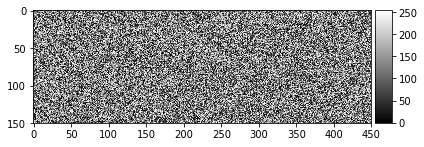

OUTPUT


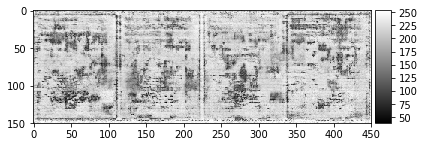

TARGET


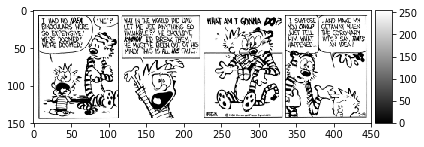

step  0 / 7367 d_loss:  0.033281296491622925 g_loss:  [48.85952, 0.48199648, 0.6598749]
step  1 / 7367 d_loss:  0.03445214033126831 g_loss:  [43.89069, 0.43176302, 0.7143867]
step  2 / 7367 d_loss:  0.03150254115462303 g_loss:  [48.61834, 0.47832298, 0.78604186]
step  3 / 7367 d_loss:  0.5884998440742493 g_loss:  [37.16679, 0.36362696, 0.80409575]
step  4 / 7367 d_loss:  0.04937698692083359 g_loss:  [45.02601, 0.44202927, 0.823081]
step  5 / 7367 d_loss:  0.044355232268571854 g_loss:  [40.00708, 0.3913283, 0.8742467]
step  6 / 7367 d_loss:  0.016866447404026985 g_loss:  [54.17272, 0.53253186, 0.91953534]
step  7 / 7367 d_loss:  0.0728907510638237 g_loss:  [40.98267, 0.40029746, 0.95292175]
step  8 / 7367 d_loss:  0.012281235307455063 g_loss:  [50.104927, 0.49113703, 0.9912256]
step  9 / 7367 d_loss:  0.0057418933138251305 g_loss:  [44.44907, 0.434359, 1.0131696]
step  10 / 7367 d_loss:  0.004854991566389799 g_loss:  [60.438255, 0.5940728, 1.0309768]
step  11 / 7367 d_loss:  0.000356506

step  93 / 7367 d_loss:  0.05471853166818619 g_loss:  [50.28583, 0.49366504, 0.919325]
step  94 / 7367 d_loss:  0.048523105680942535 g_loss:  [48.275116, 0.47268286, 1.0068302]
step  95 / 7367 d_loss:  0.038296546787023544 g_loss:  [59.06155, 0.5794967, 1.1118815]
step  96 / 7367 d_loss:  0.018377644941210747 g_loss:  [58.060562, 0.56858796, 1.2017686]
step  97 / 7367 d_loss:  0.00816069170832634 g_loss:  [64.93151, 0.63682234, 1.2492781]
step  98 / 7367 d_loss:  0.0033919350244104862 g_loss:  [51.23093, 0.4993859, 1.2923383]
step  99 / 7367 d_loss:  0.005840119440108538 g_loss:  [51.94182, 0.5063917, 1.3026464]
step  100 / 7367 d_loss:  0.07298457622528076 g_loss:  [45.412666, 0.44130042, 1.2826239]
step  101 / 7367 d_loss:  0.1113591343164444 g_loss:  [43.42067, 0.42201817, 1.2188549]
step  102 / 7367 d_loss:  0.0027842349372804165 g_loss:  [65.71515, 0.64527434, 1.1877116]
step  103 / 7367 d_loss:  0.009139934554696083 g_loss:  [50.72429, 0.49612495, 1.1117922]
step  104 / 7367 d_lo

step  185 / 7367 d_loss:  0.005152085795998573 g_loss:  [79.73158, 0.7820927, 1.5223123]
step  186 / 7367 d_loss:  8.9214117906522e-05 g_loss:  [57.81685, 0.5632119, 1.4956579]
step  187 / 7367 d_loss:  0.003442986635491252 g_loss:  [49.111862, 0.47696087, 1.4157755]
step  188 / 7367 d_loss:  0.01629803143441677 g_loss:  [47.1134, 0.45786193, 1.3272045]
step  189 / 7367 d_loss:  0.03382900729775429 g_loss:  [47.42384, 0.46198362, 1.2254798]
step  190 / 7367 d_loss:  0.043557509779930115 g_loss:  [54.61695, 0.5349594, 1.1210129]
step  191 / 7367 d_loss:  0.05042527616024017 g_loss:  [57.610382, 0.56579435, 1.0309489]
step  192 / 7367 d_loss:  0.054235655814409256 g_loss:  [53.009197, 0.5207738, 0.9318144]
step  193 / 7367 d_loss:  0.0447898730635643 g_loss:  [55.410522, 0.54585963, 0.8245588]
step  194 / 7367 d_loss:  0.021902622655034065 g_loss:  [51.918472, 0.5118563, 0.73284173]
step  195 / 7367 d_loss:  0.016921015456318855 g_loss:  [47.83972, 0.47198084, 0.6416353]
step  196 / 7367

step  277 / 7367 d_loss:  4.6556509914807975e-05 g_loss:  [49.778484, 0.4919516, 0.58332455]
step  278 / 7367 d_loss:  0.0031086376402527094 g_loss:  [55.720398, 0.5514774, 0.5726622]
step  279 / 7367 d_loss:  0.0018505235202610493 g_loss:  [63.57336, 0.63010603, 0.56275535]
step  280 / 7367 d_loss:  0.002116578631103039 g_loss:  [53.861065, 0.533092, 0.55186105]
step  281 / 7367 d_loss:  0.0004107801360078156 g_loss:  [51.167862, 0.50605065, 0.5627969]
step  282 / 7367 d_loss:  2.671138099685777e-05 g_loss:  [53.731133, 0.5315911, 0.5720227]
step  283 / 7367 d_loss:  0.002017306163907051 g_loss:  [49.12965, 0.48529625, 0.60002625]
step  284 / 7367 d_loss:  0.0028766468167304993 g_loss:  [51.346733, 0.50720584, 0.6261492]
step  285 / 7367 d_loss:  0.0016529607819393277 g_loss:  [83.79859, 0.8314598, 0.6526097]
step  286 / 7367 d_loss:  0.0604703463613987 g_loss:  [56.45081, 0.5580777, 0.64303964]
step  287 / 7367 d_loss:  0.00461514201015234 g_loss:  [46.541595, 0.45917735, 0.6238587]


step  368 / 7367 d_loss:  0.015617881901562214 g_loss:  [48.169945, 0.47387072, 0.78286994]
step  369 / 7367 d_loss:  0.008338069543242455 g_loss:  [47.485836, 0.46764594, 0.7212415]
step  370 / 7367 d_loss:  0.010552939027547836 g_loss:  [47.33363, 0.4664458, 0.6890495]
step  371 / 7367 d_loss:  0.00902668945491314 g_loss:  [53.390736, 0.5273525, 0.6554844]
step  372 / 7367 d_loss:  0.020879779011011124 g_loss:  [43.108425, 0.42501932, 0.60649216]
step  373 / 7367 d_loss:  0.005530542694032192 g_loss:  [54.50257, 0.5390969, 0.5928815]
step  374 / 7367 d_loss:  0.0016239683609455824 g_loss:  [51.53097, 0.50966173, 0.5647952]
step  375 / 7367 d_loss:  0.00846795178949833 g_loss:  [49.29054, 0.4875254, 0.5379978]
step  376 / 7367 d_loss:  0.012240789830684662 g_loss:  [48.22607, 0.47693208, 0.532863]
step  377 / 7367 d_loss:  0.0032587822061032057 g_loss:  [49.56459, 0.4903971, 0.5248809]
step  378 / 7367 d_loss:  0.00408257357776165 g_loss:  [45.41624, 0.44892108, 0.52413094]
step  379 

step  460 / 7367 d_loss:  0.019190490245819092 g_loss:  [57.75441, 0.5677933, 0.97508013]
step  461 / 7367 d_loss:  0.022626932710409164 g_loss:  [50.306717, 0.4938471, 0.92200935]
step  462 / 7367 d_loss:  0.0190480574965477 g_loss:  [49.930565, 0.49082667, 0.84789586]
step  463 / 7367 d_loss:  0.02592766284942627 g_loss:  [44.245167, 0.43451777, 0.79338944]
step  464 / 7367 d_loss:  0.021428916603326797 g_loss:  [48.10171, 0.47371042, 0.7306721]
step  465 / 7367 d_loss:  0.011675650253891945 g_loss:  [55.931557, 0.55274457, 0.6570992]
step  466 / 7367 d_loss:  0.23066003620624542 g_loss:  [40.35418, 0.39770606, 0.5835708]
step  467 / 7367 d_loss:  0.004462812095880508 g_loss:  [48.88569, 0.48376983, 0.50870323]
step  468 / 7367 d_loss:  0.007193686906248331 g_loss:  [72.39417, 0.71905303, 0.48886567]
step  469 / 7367 d_loss:  0.00619453564286232 g_loss:  [46.775867, 0.46317044, 0.45882505]
step  470 / 7367 d_loss:  0.012653018347918987 g_loss:  [46.747013, 0.46307942, 0.4390704]
step

step  551 / 7367 d_loss:  0.04535466060042381 g_loss:  [48.989166, 0.48482293, 0.50687593]
step  552 / 7367 d_loss:  0.04066617786884308 g_loss:  [53.163506, 0.52609736, 0.5537669]
step  553 / 7367 d_loss:  0.019791610538959503 g_loss:  [48.142307, 0.47526354, 0.615955]
step  554 / 7367 d_loss:  0.015607361681759357 g_loss:  [48.274555, 0.47592825, 0.6817324]
step  555 / 7367 d_loss:  0.014179764315485954 g_loss:  [52.817295, 0.5206934, 0.74795294]
step  556 / 7367 d_loss:  0.03066098876297474 g_loss:  [41.403343, 0.40602055, 0.80129004]
step  557 / 7367 d_loss:  0.01339942030608654 g_loss:  [51.66609, 0.5079464, 0.8714534]
step  558 / 7367 d_loss:  0.00794653594493866 g_loss:  [46.82897, 0.45889142, 0.9398313]
step  559 / 7367 d_loss:  0.006279546767473221 g_loss:  [53.653854, 0.5265498, 0.9988715]
step  560 / 7367 d_loss:  0.017017265781760216 g_loss:  [57.90463, 0.56854373, 1.0502542]
step  561 / 7367 d_loss:  0.004363602958619595 g_loss:  [46.309044, 0.45244, 1.0650461]
step  562 /

step  642 / 7367 d_loss:  0.006782821379601955 g_loss:  [58.24188, 0.57148093, 1.093785]
step  643 / 7367 d_loss:  0.008490735664963722 g_loss:  [48.807568, 0.47745946, 1.0616213]
step  644 / 7367 d_loss:  0.0055575016885995865 g_loss:  [49.853043, 0.48812568, 1.0404724]
step  645 / 7367 d_loss:  0.008763573132455349 g_loss:  [44.815826, 0.4382692, 0.9889056]
step  646 / 7367 d_loss:  0.0022764992900192738 g_loss:  [48.14005, 0.4718669, 0.9533583]
step  647 / 7367 d_loss:  0.017225492745637894 g_loss:  [41.517483, 0.40597275, 0.92020684]
step  648 / 7367 d_loss:  0.004192162770777941 g_loss:  [52.143322, 0.5122412, 0.91920537]
step  649 / 7367 d_loss:  0.9396463632583618 g_loss:  [35.978863, 0.35155588, 0.8232714]
step  650 / 7367 d_loss:  0.00040745630394667387 g_loss:  [46.951157, 0.46168986, 0.782169]
step  651 / 7367 d_loss:  0.04399541765451431 g_loss:  [40.29148, 0.3958205, 0.7094292]
step  652 / 7367 d_loss:  0.0010775963310152292 g_loss:  [54.752995, 0.5408646, 0.6665336]
step 

step  733 / 7367 d_loss:  0.002514661755412817 g_loss:  [51.160294, 0.4999104, 1.1692518]
step  734 / 7367 d_loss:  0.0023016654886305332 g_loss:  [53.792267, 0.52627224, 1.1650432]
step  735 / 7367 d_loss:  0.0023239997681230307 g_loss:  [53.437, 0.5227569, 1.1613125]
step  736 / 7367 d_loss:  0.002017770893871784 g_loss:  [45.230087, 0.44097733, 1.1323531]
step  737 / 7367 d_loss:  0.8075847029685974 g_loss:  [36.071545, 0.3501095, 1.0605972]
step  738 / 7367 d_loss:  0.00579330138862133 g_loss:  [75.35649, 0.7436482, 0.99167764]
step  739 / 7367 d_loss:  0.052681177854537964 g_loss:  [39.86483, 0.38920113, 0.9447161]
step  740 / 7367 d_loss:  0.00967869907617569 g_loss:  [48.478848, 0.47557813, 0.92103714]
step  741 / 7367 d_loss:  0.011508219875395298 g_loss:  [56.899395, 0.56023896, 0.87549937]
step  742 / 7367 d_loss:  0.03561917692422867 g_loss:  [41.23509, 0.40364754, 0.87033427]
step  743 / 7367 d_loss:  0.0035734649281948805 g_loss:  [54.32894, 0.5345514, 0.8738033]
step  744

step  825 / 7367 d_loss:  0.002854612423107028 g_loss:  [42.883842, 0.41726112, 1.1577308]
step  826 / 7367 d_loss:  0.00029611203353852034 g_loss:  [44.273323, 0.4309198, 1.1813436]
step  827 / 7367 d_loss:  0.002048203721642494 g_loss:  [67.97192, 0.6678512, 1.1868011]
step  828 / 7367 d_loss:  0.005521935876458883 g_loss:  [44.46625, 0.43285325, 1.1809272]
step  829 / 7367 d_loss:  0.3305470049381256 g_loss:  [39.073143, 0.37958357, 1.1147891]
step  830 / 7367 d_loss:  0.0016892125131562352 g_loss:  [54.39881, 0.5331648, 1.0823332]
step  831 / 7367 d_loss:  0.00036063732113689184 g_loss:  [55.957558, 0.5492876, 1.0287977]
step  832 / 7367 d_loss:  0.0006683248793706298 g_loss:  [47.994076, 0.46981326, 1.0127472]
step  833 / 7367 d_loss:  0.00018208588880952448 g_loss:  [50.162895, 0.49180114, 0.9827787]
step  834 / 7367 d_loss:  0.0004296627885196358 g_loss:  [52.50261, 0.51549774, 0.952834]
step  835 / 7367 d_loss:  0.00013398678856901824 g_loss:  [72.28761, 0.7136716, 0.92044926]


step  916 / 7367 d_loss:  0.0008702640770934522 g_loss:  [47.89353, 0.47041506, 0.85202664]
step  917 / 7367 d_loss:  0.0035763143096119165 g_loss:  [57.726707, 0.568718, 0.8549061]
step  918 / 7367 d_loss:  0.0019122508820146322 g_loss:  [49.430214, 0.48614126, 0.8160877]
step  919 / 7367 d_loss:  0.0016908422112464905 g_loss:  [57.322163, 0.56502277, 0.81988436]
step  920 / 7367 d_loss:  0.004961835220456123 g_loss:  [53.22977, 0.5240359, 0.82618505]
step  921 / 7367 d_loss:  0.005759746301919222 g_loss:  [49.44144, 0.48627633, 0.81380737]
step  922 / 7367 d_loss:  0.008244258351624012 g_loss:  [53.44277, 0.52599156, 0.843612]
step  923 / 7367 d_loss:  0.009999088011682034 g_loss:  [49.707714, 0.488507, 0.85701555]
step  924 / 7367 d_loss:  0.01029400248080492 g_loss:  [57.518597, 0.56653357, 0.86523986]
step  925 / 7367 d_loss:  0.010518478229641914 g_loss:  [48.390934, 0.47494644, 0.89629143]
step  926 / 7367 d_loss:  0.008875008672475815 g_loss:  [44.29649, 0.43366435, 0.93005484]

step  1007 / 7367 d_loss:  0.006613447330892086 g_loss:  [42.21711, 0.41259864, 0.9572437]
step  1008 / 7367 d_loss:  0.006115646567195654 g_loss:  [58.67117, 0.577096, 0.96156925]
step  1009 / 7367 d_loss:  0.004744645208120346 g_loss:  [43.70676, 0.42719173, 0.9875885]
step  1010 / 7367 d_loss:  0.0012162526836618781 g_loss:  [56.24364, 0.55216366, 1.0272752]
step  1011 / 7367 d_loss:  0.0017549782060086727 g_loss:  [52.935467, 0.51908886, 1.0265813]
step  1012 / 7367 d_loss:  0.00018682314839679748 g_loss:  [54.746536, 0.5371094, 1.0355989]
step  1013 / 7367 d_loss:  3.1301435228670016e-05 g_loss:  [61.21052, 0.6016646, 1.0440607]
step  1014 / 7367 d_loss:  0.0002874357160180807 g_loss:  [52.032417, 0.50987124, 1.0452938]
step  1015 / 7367 d_loss:  0.00028247383306734264 g_loss:  [53.56565, 0.5253268, 1.0329698]
step  1016 / 7367 d_loss:  0.0006312599289231002 g_loss:  [47.385506, 0.46366698, 1.0188075]
step  1017 / 7367 d_loss:  0.0030347269494086504 g_loss:  [45.34606, 0.44325337,

step  1097 / 7367 d_loss:  0.021534878760576248 g_loss:  [42.52637, 0.41709742, 0.81662595]
step  1098 / 7367 d_loss:  0.007921013049781322 g_loss:  [48.942585, 0.4804765, 0.89493674]
step  1099 / 7367 d_loss:  0.0033017813693732023 g_loss:  [48.782356, 0.47857124, 0.9252327]
step  1100 / 7367 d_loss:  0.0028949561528861523 g_loss:  [65.74946, 0.6477896, 0.970497]
step  1101 / 7367 d_loss:  0.00039112597005441785 g_loss:  [48.73269, 0.4772378, 1.0089095]
step  1102 / 7367 d_loss:  0.000847593997605145 g_loss:  [56.654118, 0.55620867, 1.0332502]
step  1103 / 7367 d_loss:  0.0040430231019854546 g_loss:  [51.883068, 0.50815964, 1.0671035]
step  1104 / 7367 d_loss:  0.002758971881121397 g_loss:  [54.375355, 0.5332273, 1.0526227]
step  1105 / 7367 d_loss:  0.005003860220313072 g_loss:  [73.025604, 0.71989304, 1.0363007]
step  1106 / 7367 d_loss:  0.0011574289528653026 g_loss:  [54.823437, 0.53815025, 1.0084109]
step  1107 / 7367 d_loss:  0.0035772554110735655 g_loss:  [42.05493, 0.4107732, 

step  1188 / 7367 d_loss:  0.00012316342326812446 g_loss:  [50.903557, 0.49930203, 0.97335297]
step  1189 / 7367 d_loss:  0.0011369310086593032 g_loss:  [51.434277, 0.50503695, 0.93058074]
step  1190 / 7367 d_loss:  0.00026765585062094033 g_loss:  [44.26789, 0.43356013, 0.9118779]
step  1191 / 7367 d_loss:  0.00010233886132482439 g_loss:  [48.388214, 0.475024, 0.88581055]
step  1192 / 7367 d_loss:  0.00017939909594133496 g_loss:  [44.61773, 0.43749958, 0.8677713]
step  1193 / 7367 d_loss:  0.0010955248726531863 g_loss:  [46.761166, 0.4590905, 0.8521148]
step  1194 / 7367 d_loss:  0.07720929384231567 g_loss:  [36.58895, 0.3576018, 0.8287728]
step  1195 / 7367 d_loss:  0.0009648678242228925 g_loss:  [44.08165, 0.4327091, 0.8107417]
step  1196 / 7367 d_loss:  0.0013429224491119385 g_loss:  [43.240643, 0.42422754, 0.81789]
step  1197 / 7367 d_loss:  0.0012761133257299662 g_loss:  [65.96984, 0.6515722, 0.81261766]
step  1198 / 7367 d_loss:  0.003196388017386198 g_loss:  [46.108166, 0.452847

step  1279 / 7367 d_loss:  0.0024897647090256214 g_loss:  [43.337402, 0.42578664, 0.7587401]
step  1280 / 7367 d_loss:  0.000823494978249073 g_loss:  [43.199085, 0.42436025, 0.76306224]
step  1281 / 7367 d_loss:  0.007689041085541248 g_loss:  [43.214462, 0.42448935, 0.76552653]
step  1282 / 7367 d_loss:  0.009207874536514282 g_loss:  [42.318302, 0.4153513, 0.7831724]
step  1283 / 7367 d_loss:  0.011813024058938026 g_loss:  [58.76674, 0.5798326, 0.7834781]
step  1284 / 7367 d_loss:  0.017350830137729645 g_loss:  [41.592453, 0.4079298, 0.7994731]
step  1285 / 7367 d_loss:  0.46901649236679077 g_loss:  [33.811306, 0.33040643, 0.7706628]
step  1286 / 7367 d_loss:  0.05402018502354622 g_loss:  [38.089607, 0.37342674, 0.7469327]
step  1287 / 7367 d_loss:  0.04731021821498871 g_loss:  [52.546303, 0.5178873, 0.75757056]
step  1288 / 7367 d_loss:  0.04836322367191315 g_loss:  [51.734844, 0.5093154, 0.8033079]
step  1289 / 7367 d_loss:  0.0472986213862896 g_loss:  [61.46973, 0.60644686, 0.825042

step  1370 / 7367 d_loss:  0.01990746706724167 g_loss:  [51.537834, 0.50402397, 1.1354378]
step  1371 / 7367 d_loss:  0.025855652987957 g_loss:  [55.92238, 0.548262, 1.0961804]
step  1372 / 7367 d_loss:  0.04412567988038063 g_loss:  [56.025707, 0.54983896, 1.0418115]
step  1373 / 7367 d_loss:  0.049094974994659424 g_loss:  [56.75678, 0.55807245, 0.9495356]
step  1374 / 7367 d_loss:  0.03845633938908577 g_loss:  [73.58275, 0.7272234, 0.86041284]
step  1375 / 7367 d_loss:  0.033046457916498184 g_loss:  [48.825893, 0.4807374, 0.75215375]
step  1376 / 7367 d_loss:  0.01957348920404911 g_loss:  [51.66021, 0.5100646, 0.65374845]
step  1377 / 7367 d_loss:  0.009860912337899208 g_loss:  [46.926003, 0.46347147, 0.5788541]
step  1378 / 7367 d_loss:  0.0027737505733966827 g_loss:  [54.142284, 0.5364565, 0.4966325]
step  1379 / 7367 d_loss:  0.0011695880675688386 g_loss:  [53.74798, 0.5330903, 0.43894973]
step  1380 / 7367 d_loss:  0.010606798343360424 g_loss:  [57.78333, 0.5738485, 0.39847893]
st

step  1460 / 7367 d_loss:  0.0019311921205371618 g_loss:  [52.428925, 0.51381135, 1.0477898]
step  1461 / 7367 d_loss:  0.00029885408002883196 g_loss:  [52.070908, 0.510194, 1.0515049]
step  1462 / 7367 d_loss:  0.0037821754813194275 g_loss:  [55.942886, 0.54876494, 1.0663894]
step  1463 / 7367 d_loss:  9.989286627387628e-05 g_loss:  [48.024452, 0.46972477, 1.0519754]
step  1464 / 7367 d_loss:  0.0007787421345710754 g_loss:  [55.50885, 0.544971, 1.01175]
step  1465 / 7367 d_loss:  0.0021612609270960093 g_loss:  [44.835964, 0.43858802, 0.97716266]
step  1466 / 7367 d_loss:  0.004730025306344032 g_loss:  [50.976498, 0.49994224, 0.98227334]
step  1467 / 7367 d_loss:  0.0044165183790028095 g_loss:  [50.71649, 0.49742743, 0.97374535]
step  1468 / 7367 d_loss:  0.007424592971801758 g_loss:  [56.26194, 0.5529611, 0.96582836]
step  1469 / 7367 d_loss:  0.011957083828747272 g_loss:  [48.517315, 0.4755558, 0.9617366]
step  1470 / 7367 d_loss:  0.017871882766485214 g_loss:  [42.97278, 0.420061, 0

step  1550 / 7367 d_loss:  0.005073809064924717 g_loss:  [47.943687, 0.47360384, 0.58330053]
step  1551 / 7367 d_loss:  0.0064680129289627075 g_loss:  [41.17872, 0.4059322, 0.58550024]
step  1552 / 7367 d_loss:  0.006708159577101469 g_loss:  [48.24667, 0.4765242, 0.59425026]
step  1553 / 7367 d_loss:  0.009935149922966957 g_loss:  [43.020367, 0.42381552, 0.63881314]
step  1554 / 7367 d_loss:  0.004636876285076141 g_loss:  [41.766464, 0.41091138, 0.67532563]
step  1555 / 7367 d_loss:  0.0013669459149241447 g_loss:  [46.358826, 0.45633185, 0.72563833]
step  1556 / 7367 d_loss:  0.020326051861047745 g_loss:  [60.048405, 0.59281135, 0.7672704]
step  1557 / 7367 d_loss:  0.0033855948131531477 g_loss:  [49.220142, 0.48415783, 0.8043587]
step  1558 / 7367 d_loss:  0.004634520970284939 g_loss:  [45.42599, 0.4458898, 0.8370095]
step  1559 / 7367 d_loss:  0.003844701685011387 g_loss:  [52.169952, 0.512988, 0.87115306]
step  1560 / 7367 d_loss:  0.004977482836693525 g_loss:  [51.050083, 0.5019874

step  1640 / 7367 d_loss:  0.03140140324831009 g_loss:  [54.14756, 0.5354006, 0.60749686]
step  1641 / 7367 d_loss:  0.02547026425600052 g_loss:  [44.793945, 0.4411619, 0.6777552]
step  1642 / 7367 d_loss:  0.03144603967666626 g_loss:  [55.14605, 0.5438858, 0.7574651]
step  1643 / 7367 d_loss:  0.024230457842350006 g_loss:  [64.6815, 0.63827556, 0.85394734]
step  1644 / 7367 d_loss:  0.009884661063551903 g_loss:  [67.02567, 0.66081804, 0.9438714]
step  1645 / 7367 d_loss:  0.016974488273262978 g_loss:  [54.1214, 0.53121597, 0.9998025]
step  1646 / 7367 d_loss:  0.006173920817673206 g_loss:  [47.29631, 0.46238422, 1.0578865]
step  1647 / 7367 d_loss:  0.006974423304200172 g_loss:  [43.34211, 0.42233682, 1.1084306]
step  1648 / 7367 d_loss:  0.0015839360421523452 g_loss:  [50.194332, 0.4903037, 1.163965]
step  1649 / 7367 d_loss:  0.0014219011645764112 g_loss:  [59.12601, 0.5792796, 1.1980501]
step  1650 / 7367 d_loss:  0.0005923613207414746 g_loss:  [58.83274, 0.57625586, 1.2071542]
ste

step  1731 / 7367 d_loss:  0.0015906270127743483 g_loss:  [46.08341, 0.45298836, 0.78457314]
step  1732 / 7367 d_loss:  0.010277029126882553 g_loss:  [48.311775, 0.47544777, 0.7669985]
step  1733 / 7367 d_loss:  0.03080075979232788 g_loss:  [43.64729, 0.4289548, 0.75180835]
step  1734 / 7367 d_loss:  0.027709143236279488 g_loss:  [56.096302, 0.55341035, 0.75526637]
step  1735 / 7367 d_loss:  0.029203001409769058 g_loss:  [47.617844, 0.4684518, 0.7726649]
step  1736 / 7367 d_loss:  0.02642672136425972 g_loss:  [49.552803, 0.48738855, 0.8139479]
step  1737 / 7367 d_loss:  0.025059279054403305 g_loss:  [50.114952, 0.49254283, 0.8606684]
step  1738 / 7367 d_loss:  0.015082694590091705 g_loss:  [63.074722, 0.6214768, 0.92704034]
step  1739 / 7367 d_loss:  0.007170823868364096 g_loss:  [48.74638, 0.47765216, 0.9811635]
step  1740 / 7367 d_loss:  0.005485030822455883 g_loss:  [48.44653, 0.47415218, 1.0313119]
step  1741 / 7367 d_loss:  0.00043225023546256125 g_loss:  [48.937687, 0.47874773, 1

step  1822 / 7367 d_loss:  0.0053090061992406845 g_loss:  [48.18773, 0.4734647, 0.841258]
step  1823 / 7367 d_loss:  0.009446971118450165 g_loss:  [48.646038, 0.47750092, 0.89594656]
step  1824 / 7367 d_loss:  0.006136278156191111 g_loss:  [46.220425, 0.45293495, 0.92692924]
step  1825 / 7367 d_loss:  0.501008927822113 g_loss:  [38.170315, 0.3726814, 0.90217394]
step  1826 / 7367 d_loss:  0.0086204269900918 g_loss:  [46.859665, 0.45950422, 0.90924424]
step  1827 / 7367 d_loss:  0.013933520764112473 g_loss:  [60.14124, 0.5923108, 0.91015935]
step  1828 / 7367 d_loss:  0.04794628918170929 g_loss:  [41.96115, 0.4106972, 0.89143527]
step  1829 / 7367 d_loss:  0.08673232048749924 g_loss:  [39.585743, 0.38703582, 0.8821592]
step  1830 / 7367 d_loss:  0.0361834317445755 g_loss:  [52.14242, 0.5122419, 0.91823125]
step  1831 / 7367 d_loss:  0.022886788472533226 g_loss:  [47.43857, 0.46504578, 0.93399125]
step  1832 / 7367 d_loss:  0.017613844946026802 g_loss:  [43.51576, 0.42531735, 0.98402315]

step  1912 / 7367 d_loss:  0.000648192479275167 g_loss:  [43.94401, 0.42926124, 1.0178872]
step  1913 / 7367 d_loss:  0.09705067425966263 g_loss:  [42.96297, 0.4197457, 0.9883987]
step  1914 / 7367 d_loss:  1.0111839771270752 g_loss:  [36.294308, 0.3536832, 0.925986]
step  1915 / 7367 d_loss:  0.009454887360334396 g_loss:  [57.30347, 0.56436586, 0.86688477]
step  1916 / 7367 d_loss:  0.1499997079372406 g_loss:  [38.115192, 0.37310567, 0.8046282]
step  1917 / 7367 d_loss:  0.015173247084021568 g_loss:  [59.050552, 0.5829522, 0.755334]
step  1918 / 7367 d_loss:  0.0006626531248912215 g_loss:  [47.054306, 0.46329802, 0.72450244]
step  1919 / 7367 d_loss:  0.04573383927345276 g_loss:  [46.39799, 0.45705965, 0.6920231]
step  1920 / 7367 d_loss:  0.0005579956923611462 g_loss:  [47.950466, 0.47260237, 0.69022685]
step  1921 / 7367 d_loss:  0.018120361492037773 g_loss:  [51.628517, 0.50949675, 0.6788388]
step  1922 / 7367 d_loss:  0.006101973354816437 g_loss:  [56.939377, 0.5625846, 0.680919]


step  2003 / 7367 d_loss:  0.010609864257276058 g_loss:  [61.514034, 0.60442674, 1.0713631]
step  2004 / 7367 d_loss:  0.005835559219121933 g_loss:  [47.77727, 0.46682802, 1.0944692]
step  2005 / 7367 d_loss:  0.012408092617988586 g_loss:  [44.44873, 0.43329796, 1.1189364]
step  2006 / 7367 d_loss:  0.00010518608178244904 g_loss:  [52.20563, 0.510581, 1.1475302]
step  2007 / 7367 d_loss:  0.003520323894917965 g_loss:  [47.542694, 0.46400484, 1.142209]
step  2008 / 7367 d_loss:  0.07590951025485992 g_loss:  [44.91149, 0.4377923, 1.1322634]
step  2009 / 7367 d_loss:  0.011842325329780579 g_loss:  [46.38392, 0.4528908, 1.0948384]
step  2010 / 7367 d_loss:  0.021732449531555176 g_loss:  [49.454693, 0.48390707, 1.0639824]
step  2011 / 7367 d_loss:  0.029151901602745056 g_loss:  [54.376614, 0.5334831, 1.0283033]
step  2012 / 7367 d_loss:  0.03478604927659035 g_loss:  [54.795494, 0.537994, 0.99609137]
step  2013 / 7367 d_loss:  0.03815952688455582 g_loss:  [42.639973, 0.41699526, 0.94044995]


step  2093 / 7367 d_loss:  0.00012770327157340944 g_loss:  [53.496292, 0.52604586, 0.89170325]
step  2094 / 7367 d_loss:  0.0013142668176442385 g_loss:  [41.470665, 0.40569502, 0.9011631]
step  2095 / 7367 d_loss:  0.007384051103144884 g_loss:  [89.58878, 0.88662463, 0.926326]
step  2096 / 7367 d_loss:  0.002110435627400875 g_loss:  [85.06074, 0.84154207, 0.90652966]
step  2097 / 7367 d_loss:  0.017121195793151855 g_loss:  [53.612743, 0.52703935, 0.90880907]
step  2098 / 7367 d_loss:  0.009046163409948349 g_loss:  [51.20231, 0.5029179, 0.91051793]
step  2099 / 7367 d_loss:  0.005216001532971859 g_loss:  [54.23025, 0.5331226, 0.9179908]
step  2100 / 7367 d_loss:  0.0042406837455928326 g_loss:  [54.32472, 0.5338802, 0.9367023]
step  2101 / 7367 d_loss:  0.004720397759228945 g_loss:  [49.181072, 0.48244748, 0.93632644]
step  2102 / 7367 d_loss:  0.005245022475719452 g_loss:  [60.61464, 0.5965276, 0.9618851]
step  2103 / 7367 d_loss:  0.0024944250471889973 g_loss:  [51.07434, 0.501033, 0.9

step  2183 / 7367 d_loss:  0.0009818279650062323 g_loss:  [64.78832, 0.6372857, 1.0597544]
step  2184 / 7367 d_loss:  0.0005174007383175194 g_loss:  [49.97477, 0.4896308, 1.0116917]
step  2185 / 7367 d_loss:  0.0016090292483568192 g_loss:  [58.0396, 0.5706699, 0.97261083]
step  2186 / 7367 d_loss:  0.005097148008644581 g_loss:  [45.36144, 0.44424978, 0.9364626]
step  2187 / 7367 d_loss:  0.0067424592562019825 g_loss:  [48.97776, 0.48055458, 0.9223031]
step  2188 / 7367 d_loss:  0.011721672490239143 g_loss:  [47.544815, 0.46619806, 0.9250091]
step  2189 / 7367 d_loss:  0.008594897575676441 g_loss:  [43.613052, 0.42700213, 0.91283923]
step  2190 / 7367 d_loss:  0.008001168258488178 g_loss:  [59.783543, 0.58867514, 0.9160254]
step  2191 / 7367 d_loss:  0.0038654368836432695 g_loss:  [56.281902, 0.55350524, 0.93137807]
step  2192 / 7367 d_loss:  0.007760613225400448 g_loss:  [58.348732, 0.57402813, 0.94592]
step  2193 / 7367 d_loss:  0.0034541741479188204 g_loss:  [59.18982, 0.58234054, 0.

step  2274 / 7367 d_loss:  0.00827417429536581 g_loss:  [45.72155, 0.44905788, 0.8157621]
step  2275 / 7367 d_loss:  0.0021904497407376766 g_loss:  [52.416298, 0.5156057, 0.8557277]
step  2276 / 7367 d_loss:  0.0018128876108676195 g_loss:  [52.93861, 0.52082783, 0.85582626]
step  2277 / 7367 d_loss:  0.007355567999184132 g_loss:  [39.281704, 0.3842239, 0.8593133]
step  2278 / 7367 d_loss:  0.0029176087118685246 g_loss:  [39.866592, 0.39008912, 0.857683]
step  2279 / 7367 d_loss:  0.0015283620450645685 g_loss:  [45.978165, 0.45117244, 0.8609195]
step  2280 / 7367 d_loss:  0.0004809199017472565 g_loss:  [46.827717, 0.45989102, 0.8386147]
step  2281 / 7367 d_loss:  0.0016284615267068148 g_loss:  [51.86827, 0.510264, 0.8418748]
step  2282 / 7367 d_loss:  0.006232640240341425 g_loss:  [51.84134, 0.5103429, 0.8070507]
step  2283 / 7367 d_loss:  0.004323598463088274 g_loss:  [52.179047, 0.5138162, 0.7974273]
step  2284 / 7367 d_loss:  0.0018133899429813027 g_loss:  [51.138157, 0.50354373, 0.7

step  2364 / 7367 d_loss:  0.0006892248638905585 g_loss:  [49.359776, 0.4844404, 0.91573733]
step  2365 / 7367 d_loss:  0.004996526520699263 g_loss:  [40.63457, 0.39724293, 0.91027963]
step  2366 / 7367 d_loss:  0.0015359004028141499 g_loss:  [48.067158, 0.4714399, 0.9231679]
step  2367 / 7367 d_loss:  0.0010349899530410767 g_loss:  [40.814587, 0.3989029, 0.92429894]
step  2368 / 7367 d_loss:  0.001562474761158228 g_loss:  [58.283268, 0.57342625, 0.9406419]
step  2369 / 7367 d_loss:  0.00022605550475418568 g_loss:  [49.187546, 0.48258692, 0.92885196]
step  2370 / 7367 d_loss:  0.0007511250441893935 g_loss:  [52.30188, 0.51374495, 0.9273836]
step  2371 / 7367 d_loss:  0.0009869164787232876 g_loss:  [53.6949, 0.52766365, 0.9285372]
step  2372 / 7367 d_loss:  0.0006415170500986278 g_loss:  [45.097263, 0.44160637, 0.9366271]
step  2373 / 7367 d_loss:  0.0008682738407514989 g_loss:  [62.05334, 0.61112285, 0.9410557]
step  2374 / 7367 d_loss:  0.0008989354828372598 g_loss:  [48.5734, 0.47633

step  2454 / 7367 d_loss:  0.0035824268124997616 g_loss:  [49.15952, 0.48207316, 0.95220166]
step  2455 / 7367 d_loss:  0.0030678692273795605 g_loss:  [41.428745, 0.40447956, 0.9807877]
step  2456 / 7367 d_loss:  0.005078270100057125 g_loss:  [40.034325, 0.39023334, 1.0109887]
step  2457 / 7367 d_loss:  0.00034997775219380856 g_loss:  [51.968567, 0.5093687, 1.0316982]
step  2458 / 7367 d_loss:  8.952346252044663e-05 g_loss:  [61.003887, 0.59950274, 1.0536112]
step  2459 / 7367 d_loss:  0.00668957456946373 g_loss:  [53.746082, 0.526755, 1.070583]
step  2460 / 7367 d_loss:  0.0011286258231848478 g_loss:  [41.427628, 0.40346208, 1.0814202]
step  2461 / 7367 d_loss:  0.0007651646155864 g_loss:  [48.50482, 0.47411874, 1.0929492]
step  2462 / 7367 d_loss:  0.004303084220737219 g_loss:  [42.292336, 0.4119297, 1.0993654]
step  2463 / 7367 d_loss:  0.0031646662391722202 g_loss:  [49.573635, 0.48487172, 1.0864643]
step  2464 / 7367 d_loss:  0.004498885944485664 g_loss:  [43.517868, 0.4244616, 1.

step  2545 / 7367 d_loss:  0.0010530567960813642 g_loss:  [55.213753, 0.5427191, 0.94184303]
step  2546 / 7367 d_loss:  0.0019491622224450111 g_loss:  [55.94819, 0.5500847, 0.93971807]
step  2547 / 7367 d_loss:  0.0019284812733530998 g_loss:  [46.087437, 0.4515196, 0.9354761]
step  2548 / 7367 d_loss:  0.001985845621675253 g_loss:  [45.935383, 0.44988155, 0.94722676]
step  2549 / 7367 d_loss:  0.0015069589717313647 g_loss:  [50.488018, 0.4953352, 0.95449746]
step  2550 / 7367 d_loss:  0.003619319526478648 g_loss:  [43.419025, 0.42451337, 0.9676912]
step  2551 / 7367 d_loss:  0.004175618290901184 g_loss:  [48.745117, 0.47762147, 0.98297006]
step  2552 / 7367 d_loss:  0.00032498614746145904 g_loss:  [46.169262, 0.45181584, 0.9876775]
step  2553 / 7367 d_loss:  0.0036098614800721407 g_loss:  [43.808254, 0.42803916, 1.0043355]
step  2554 / 7367 d_loss:  0.0011314190924167633 g_loss:  [51.812405, 0.5079222, 1.0201886]
step  2555 / 7367 d_loss:  0.0006920714513398707 g_loss:  [47.659195, 0.4

step  2634 / 7367 d_loss:  0.004467835649847984 g_loss:  [47.53129, 0.4666934, 0.8619451]
step  2635 / 7367 d_loss:  0.002848164876922965 g_loss:  [50.263103, 0.49398172, 0.8649325]
step  2636 / 7367 d_loss:  0.002648815978318453 g_loss:  [50.416916, 0.495275, 0.88941747]
step  2637 / 7367 d_loss:  0.0017525918083265424 g_loss:  [49.732227, 0.48813635, 0.91859204]
step  2638 / 7367 d_loss:  0.0011259205639362335 g_loss:  [50.603706, 0.49657622, 0.9460836]
step  2639 / 7367 d_loss:  0.0006538841407746077 g_loss:  [48.807022, 0.47833002, 0.9740219]
step  2640 / 7367 d_loss:  5.61720626137685e-05 g_loss:  [51.373684, 0.503577, 1.0159853]
step  2641 / 7367 d_loss:  0.0008010937017388642 g_loss:  [53.188953, 0.5216964, 1.019312]
step  2642 / 7367 d_loss:  0.0035637945402413607 g_loss:  [47.860825, 0.46815303, 1.0455195]
step  2643 / 7367 d_loss:  0.000378989934688434 g_loss:  [54.711124, 0.5365551, 1.0556138]
step  2644 / 7367 d_loss:  0.0014696010621264577 g_loss:  [50.63272, 0.49579293, 1

step  2724 / 7367 d_loss:  0.0011502349516376853 g_loss:  [50.54221, 0.49440774, 1.1014377]
step  2725 / 7367 d_loss:  0.0002880611573345959 g_loss:  [56.987602, 0.55903053, 1.0845509]
step  2726 / 7367 d_loss:  0.00033877702662721276 g_loss:  [43.295536, 0.42232293, 1.0632428]
step  2727 / 7367 d_loss:  0.0005618755822069943 g_loss:  [52.647705, 0.51594293, 1.0534132]
step  2728 / 7367 d_loss:  3.990282857557759e-05 g_loss:  [57.671997, 0.56634545, 1.0374508]
step  2729 / 7367 d_loss:  0.0005607146304100752 g_loss:  [44.78234, 0.43771112, 1.0112303]
step  2730 / 7367 d_loss:  0.0012646480463445187 g_loss:  [51.92103, 0.50916284, 1.0047468]
step  2731 / 7367 d_loss:  0.001882456592284143 g_loss:  [66.819954, 0.6581876, 1.0011882]
step  2732 / 7367 d_loss:  0.0023709565866738558 g_loss:  [42.869106, 0.4188008, 0.9890249]
step  2733 / 7367 d_loss:  0.004728319123387337 g_loss:  [54.733147, 0.53739274, 0.9938743]
step  2734 / 7367 d_loss:  0.0030139440204948187 g_loss:  [40.95628, 0.39944

step  2814 / 7367 d_loss:  0.0017841745866462588 g_loss:  [54.313713, 0.5317179, 1.1419234]
step  2815 / 7367 d_loss:  0.0024220591876655817 g_loss:  [52.678604, 0.51558, 1.1206046]
step  2816 / 7367 d_loss:  0.00248995004221797 g_loss:  [42.241486, 0.41142315, 1.0991726]
step  2817 / 7367 d_loss:  0.002912325318902731 g_loss:  [52.640755, 0.51582175, 1.0585791]
step  2818 / 7367 d_loss:  0.0007108966237865388 g_loss:  [59.626682, 0.5860115, 1.0255282]
step  2819 / 7367 d_loss:  0.0006934200646355748 g_loss:  [37.86603, 0.36869758, 0.9962734]
step  2820 / 7367 d_loss:  0.00030959220021031797 g_loss:  [42.129837, 0.4115506, 0.9747767]
step  2821 / 7367 d_loss:  0.0019418362062424421 g_loss:  [41.13548, 0.40175185, 0.9602932]
step  2822 / 7367 d_loss:  0.00016954925376921892 g_loss:  [44.939003, 0.4399875, 0.9402501]
step  2823 / 7367 d_loss:  0.00030152342515066266 g_loss:  [49.57652, 0.48646957, 0.9295634]
step  2824 / 7367 d_loss:  0.00038702631718479097 g_loss:  [36.852367, 0.3593498

step  2904 / 7367 d_loss:  0.00423802062869072 g_loss:  [47.45485, 0.4651628, 0.93856674]
step  2905 / 7367 d_loss:  0.0008735844166949391 g_loss:  [42.870964, 0.41948253, 0.9227101]
step  2906 / 7367 d_loss:  0.0015214674640446901 g_loss:  [49.877148, 0.4897135, 0.9057991]
step  2907 / 7367 d_loss:  0.0005071716150268912 g_loss:  [48.613285, 0.47730508, 0.88278]
step  2908 / 7367 d_loss:  0.0003139869077131152 g_loss:  [39.26469, 0.38396114, 0.86857677]
step  2909 / 7367 d_loss:  0.00033068747143261135 g_loss:  [54.797764, 0.5393813, 0.85963243]
step  2910 / 7367 d_loss:  2.3639402570552193e-05 g_loss:  [55.766518, 0.5490959, 0.8569259]
step  2911 / 7367 d_loss:  0.0007193088531494141 g_loss:  [53.735588, 0.5288769, 0.84789836]
step  2912 / 7367 d_loss:  0.00020967345335520804 g_loss:  [46.247078, 0.45405605, 0.8414724]
step  2913 / 7367 d_loss:  0.0027376834768801928 g_loss:  [43.523014, 0.426775, 0.8455131]
step  2914 / 7367 d_loss:  0.0018117786385118961 g_loss:  [39.279045, 0.3842

step  2994 / 7367 d_loss:  0.00557749904692173 g_loss:  [56.2522, 0.5532471, 0.92748964]
step  2995 / 7367 d_loss:  0.0076910569332540035 g_loss:  [53.753582, 0.52822953, 0.93063146]
step  2996 / 7367 d_loss:  0.010542543604969978 g_loss:  [54.568832, 0.5362797, 0.9408648]
step  2997 / 7367 d_loss:  0.012419287115335464 g_loss:  [45.082752, 0.44109508, 0.9732429]
step  2998 / 7367 d_loss:  0.01125604473054409 g_loss:  [55.165215, 0.5415039, 1.0148233]
step  2999 / 7367 d_loss:  0.008719762787222862 g_loss:  [49.28226, 0.4822972, 1.0525383]
step  3000 / 7367 d_loss:  0.006200352683663368 g_loss:  [55.48211, 0.54390055, 1.0920513]
step  3001 / 7367 d_loss:  0.0035522414837032557 g_loss:  [50.867878, 0.49728575, 1.1393002]
step  3002 / 7367 d_loss:  0.0018698509084060788 g_loss:  [44.601685, 0.43440595, 1.1610916]
step  3003 / 7367 d_loss:  0.0003444656322244555 g_loss:  [50.447662, 0.49260098, 1.187563]
step  3004 / 7367 d_loss:  0.00043275044299662113 g_loss:  [49.867542, 0.48682302, 1.

step  3084 / 7367 d_loss:  0.003983491100370884 g_loss:  [44.58696, 0.44100642, 0.48631483]
step  3085 / 7367 d_loss:  0.0011163457529619336 g_loss:  [59.930813, 0.5944404, 0.48677284]
step  3086 / 7367 d_loss:  0.003722735680639744 g_loss:  [53.23661, 0.52761364, 0.47524714]
step  3087 / 7367 d_loss:  0.0026713982224464417 g_loss:  [55.54406, 0.5505124, 0.4928216]
step  3088 / 7367 d_loss:  0.012382367625832558 g_loss:  [50.690804, 0.5019324, 0.49756643]
step  3089 / 7367 d_loss:  0.004969592206180096 g_loss:  [60.116287, 0.5961636, 0.49992985]
step  3090 / 7367 d_loss:  0.1502387821674347 g_loss:  [34.848473, 0.34373248, 0.47522447]
step  3091 / 7367 d_loss:  0.009288705885410309 g_loss:  [64.174614, 0.63710535, 0.4640817]
step  3092 / 7367 d_loss:  0.013436492532491684 g_loss:  [45.685776, 0.4521921, 0.46656257]
step  3093 / 7367 d_loss:  0.012968912720680237 g_loss:  [51.330475, 0.5084508, 0.48539236]
step  3094 / 7367 d_loss:  0.01606534793972969 g_loss:  [58.90883, 0.58390576, 0.

step  3174 / 7367 d_loss:  0.00224892096593976 g_loss:  [58.553238, 0.57495904, 1.057336]
step  3175 / 7367 d_loss:  0.001050444203428924 g_loss:  [65.48092, 0.6441581, 1.0651071]
step  3176 / 7367 d_loss:  0.0005476168589666486 g_loss:  [51.639904, 0.5058023, 1.0596764]
step  3177 / 7367 d_loss:  0.0006313493358902633 g_loss:  [51.532112, 0.5048853, 1.0435786]
step  3178 / 7367 d_loss:  0.0016092240111902356 g_loss:  [55.04785, 0.5401342, 1.0344298]
step  3179 / 7367 d_loss:  0.003814322641119361 g_loss:  [51.351887, 0.5032138, 1.030505]
step  3180 / 7367 d_loss:  0.005255873780697584 g_loss:  [52.754726, 0.5174194, 1.0127858]
step  3181 / 7367 d_loss:  0.004456053487956524 g_loss:  [59.89739, 0.58864945, 1.0324447]
step  3182 / 7367 d_loss:  0.006390097551047802 g_loss:  [49.11752, 0.48075035, 1.0424834]
step  3183 / 7367 d_loss:  0.0016395950224250555 g_loss:  [52.855648, 0.51769364, 1.0862842]
step  3184 / 7367 d_loss:  0.00039793807081878185 g_loss:  [53.587715, 0.5248686, 1.10085

step  3265 / 7367 d_loss:  0.001435567857697606 g_loss:  [42.813416, 0.4212687, 0.68654734]
step  3266 / 7367 d_loss:  0.0022623171098530293 g_loss:  [50.613632, 0.49912095, 0.7015394]
step  3267 / 7367 d_loss:  0.6406767964363098 g_loss:  [36.434593, 0.35786378, 0.64821607]
step  3268 / 7367 d_loss:  0.001351343235000968 g_loss:  [48.78679, 0.48159033, 0.62775266]
step  3269 / 7367 d_loss:  0.006251874379813671 g_loss:  [41.555077, 0.40946805, 0.60827255]
step  3270 / 7367 d_loss:  0.003585224272683263 g_loss:  [52.480793, 0.51836896, 0.6438977]
step  3271 / 7367 d_loss:  0.009351551532745361 g_loss:  [48.795948, 0.48141193, 0.65475416]
step  3272 / 7367 d_loss:  0.0029426629189401865 g_loss:  [56.19316, 0.5548995, 0.703207]
step  3273 / 7367 d_loss:  0.0020684460178017616 g_loss:  [47.185184, 0.4644121, 0.74397755]
step  3274 / 7367 d_loss:  0.003171927761286497 g_loss:  [49.829144, 0.4905611, 0.77303463]
step  3275 / 7367 d_loss:  0.0001749733928591013 g_loss:  [46.414574, 0.4560429

step  3356 / 7367 d_loss:  0.00034037799923680723 g_loss:  [57.124332, 0.56160337, 0.96399754]
step  3357 / 7367 d_loss:  0.0004701197030954063 g_loss:  [49.971275, 0.4905445, 0.9168257]
step  3358 / 7367 d_loss:  0.000882909691426903 g_loss:  [63.394768, 0.6249945, 0.89531827]
step  3359 / 7367 d_loss:  0.0016957365442067385 g_loss:  [62.958805, 0.6208596, 0.8728433]
step  3360 / 7367 d_loss:  0.002538577653467655 g_loss:  [53.66262, 0.5281675, 0.84587085]
step  3361 / 7367 d_loss:  0.2580412030220032 g_loss:  [39.01465, 0.38216877, 0.7977732]
step  3362 / 7367 d_loss:  0.0004913584562018514 g_loss:  [57.52229, 0.5674649, 0.77579856]
step  3363 / 7367 d_loss:  0.0022986019030213356 g_loss:  [50.93676, 0.50180095, 0.7566627]
step  3364 / 7367 d_loss:  0.0009366361773572862 g_loss:  [45.488068, 0.44741133, 0.7469311]
step  3365 / 7367 d_loss:  0.0002553235972300172 g_loss:  [49.911037, 0.49161747, 0.7492916]
step  3366 / 7367 d_loss:  0.003915031440556049 g_loss:  [42.368168, 0.41624385

step  3447 / 7367 d_loss:  0.01790918968617916 g_loss:  [48.86865, 0.48143375, 0.725274]
step  3448 / 7367 d_loss:  0.011841285042464733 g_loss:  [62.72136, 0.61958045, 0.76331466]
step  3449 / 7367 d_loss:  0.01122052501887083 g_loss:  [46.391747, 0.45605716, 0.7860281]
step  3450 / 7367 d_loss:  0.008017322048544884 g_loss:  [48.569977, 0.47734207, 0.83577126]
step  3451 / 7367 d_loss:  0.0023262272588908672 g_loss:  [51.961914, 0.51075965, 0.8859498]
step  3452 / 7367 d_loss:  0.0011317571625113487 g_loss:  [48.60609, 0.47674796, 0.9312942]
step  3453 / 7367 d_loss:  0.004720716737210751 g_loss:  [44.746326, 0.43797138, 0.9491867]
step  3454 / 7367 d_loss:  0.0032864001113921404 g_loss:  [59.314255, 0.5831407, 1.0001881]
step  3455 / 7367 d_loss:  0.0059477780014276505 g_loss:  [48.35284, 0.47343218, 1.0096215]
step  3456 / 7367 d_loss:  0.006823606789112091 g_loss:  [48.208046, 0.47214642, 0.99340624]
step  3457 / 7367 d_loss:  0.00843470636755228 g_loss:  [54.39373, 0.5340308, 0.9

step  3539 / 7367 d_loss:  0.002036043908447027 g_loss:  [45.953297, 0.45334476, 0.61882186]
step  3540 / 7367 d_loss:  0.005468043964356184 g_loss:  [54.508503, 0.53929365, 0.57914156]
step  3541 / 7367 d_loss:  0.01187889464199543 g_loss:  [58.9212, 0.5837035, 0.55084705]
step  3542 / 7367 d_loss:  0.008325050584971905 g_loss:  [46.04113, 0.45503768, 0.5373602]
step  3543 / 7367 d_loss:  0.16464099287986755 g_loss:  [38.722153, 0.38216054, 0.50610083]
step  3544 / 7367 d_loss:  0.0036562741734087467 g_loss:  [48.839325, 0.4835026, 0.4890679]
step  3545 / 7367 d_loss:  0.003954965155571699 g_loss:  [58.64107, 0.5816246, 0.47860727]
step  3546 / 7367 d_loss:  0.03389333188533783 g_loss:  [37.75878, 0.37286273, 0.47250816]
step  3547 / 7367 d_loss:  0.008046024478971958 g_loss:  [51.003506, 0.5052862, 0.47488365]
step  3548 / 7367 d_loss:  0.012389544397592545 g_loss:  [44.494095, 0.44029272, 0.4648236]
step  3549 / 7367 d_loss:  0.008106706663966179 g_loss:  [41.23005, 0.40747362, 0.48

step  3629 / 7367 d_loss:  0.028114983811974525 g_loss:  [51.544785, 0.5051863, 1.0261543]
step  3630 / 7367 d_loss:  0.02199372462928295 g_loss:  [75.6082, 0.744841, 1.1240981]
step  3631 / 7367 d_loss:  0.01793176867067814 g_loss:  [54.17243, 0.53007233, 1.1651949]
step  3632 / 7367 d_loss:  0.022320106625556946 g_loss:  [60.35237, 0.5915566, 1.1967089]
step  3633 / 7367 d_loss:  0.005222380626946688 g_loss:  [54.231102, 0.52989507, 1.2415947]
step  3634 / 7367 d_loss:  0.0014773528091609478 g_loss:  [51.858253, 0.5057195, 1.286303]
step  3635 / 7367 d_loss:  0.004716682247817516 g_loss:  [54.164978, 0.52844, 1.3209759]
step  3636 / 7367 d_loss:  0.02445003017783165 g_loss:  [48.35817, 0.47046846, 1.3113247]
step  3637 / 7367 d_loss:  0.006342027336359024 g_loss:  [49.278522, 0.47987258, 1.291264]
step  3638 / 7367 d_loss:  0.00039852852933108807 g_loss:  [51.015877, 0.49753994, 1.261884]
step  3639 / 7367 d_loss:  0.0005457459483295679 g_loss:  [56.42374, 0.55184263, 1.2394791]
step

step  3719 / 7367 d_loss:  0.0010468584951013327 g_loss:  [49.428753, 0.4797445, 1.4543048]
step  3720 / 7367 d_loss:  0.19777679443359375 g_loss:  [41.170567, 0.3978799, 1.3825771]
step  3721 / 7367 d_loss:  0.047982167452573776 g_loss:  [44.34418, 0.43036488, 1.3076923]
step  3722 / 7367 d_loss:  0.012574315071105957 g_loss:  [51.32448, 0.5008782, 1.2366564]
step  3723 / 7367 d_loss:  0.000426309066824615 g_loss:  [53.22301, 0.52021945, 1.2010665]
step  3724 / 7367 d_loss:  0.0021127837244421244 g_loss:  [59.139053, 0.5797189, 1.1671634]
step  3725 / 7367 d_loss:  0.0002064257423626259 g_loss:  [50.748116, 0.49624237, 1.1238772]
step  3726 / 7367 d_loss:  0.00018947970238514245 g_loss:  [50.699165, 0.49603304, 1.0958614]
step  3727 / 7367 d_loss:  0.010322388261556625 g_loss:  [53.13375, 0.5205855, 1.0752045]
step  3728 / 7367 d_loss:  0.0004572857287712395 g_loss:  [49.913376, 0.4886905, 1.0443252]
step  3729 / 7367 d_loss:  0.005909329745918512 g_loss:  [46.93682, 0.45933628, 1.003

step  3809 / 7367 d_loss:  0.014798017218708992 g_loss:  [53.285793, 0.52319646, 0.9661472]
step  3810 / 7367 d_loss:  0.013113240711390972 g_loss:  [51.549393, 0.5062992, 0.91947085]
step  3811 / 7367 d_loss:  0.9936464428901672 g_loss:  [36.810555, 0.3604882, 0.7617356]
step  3812 / 7367 d_loss:  0.006546527612954378 g_loss:  [50.38122, 0.49740377, 0.64084727]
step  3813 / 7367 d_loss:  0.04035095125436783 g_loss:  [40.982723, 0.40432593, 0.5501303]
step  3814 / 7367 d_loss:  0.0012961751781404018 g_loss:  [56.393364, 0.5590356, 0.48980358]
step  3815 / 7367 d_loss:  0.01033945195376873 g_loss:  [50.776344, 0.50324154, 0.4521891]
step  3816 / 7367 d_loss:  0.008342250250279903 g_loss:  [54.98564, 0.5454642, 0.43922052]
step  3817 / 7367 d_loss:  0.035959817469120026 g_loss:  [40.78629, 0.40355265, 0.4310232]
step  3818 / 7367 d_loss:  0.006423988379538059 g_loss:  [49.91319, 0.49470207, 0.4429813]
step  3819 / 7367 d_loss:  0.009256605058908463 g_loss:  [44.998287, 0.44524735, 0.4735

step  3900 / 7367 d_loss:  0.0035230079665780067 g_loss:  [48.546246, 0.4785518, 0.69106597]
step  3901 / 7367 d_loss:  0.0019270051270723343 g_loss:  [51.18467, 0.504301, 0.7545709]
step  3902 / 7367 d_loss:  0.0072771720588207245 g_loss:  [61.987797, 0.61191815, 0.79598147]
step  3903 / 7367 d_loss:  0.013679400086402893 g_loss:  [54.11183, 0.5331848, 0.793352]
step  3904 / 7367 d_loss:  0.008700153790414333 g_loss:  [46.42541, 0.45648694, 0.7767186]
step  3905 / 7367 d_loss:  0.01706014573574066 g_loss:  [50.23548, 0.49487025, 0.74845487]
step  3906 / 7367 d_loss:  0.04076486825942993 g_loss:  [54.921394, 0.5419747, 0.7239212]
step  3907 / 7367 d_loss:  0.04851609095931053 g_loss:  [60.945564, 0.6021035, 0.73521686]
step  3908 / 7367 d_loss:  0.06167634204030037 g_loss:  [44.86638, 0.44113573, 0.7528052]
step  3909 / 7367 d_loss:  0.05879242345690727 g_loss:  [56.614063, 0.55797243, 0.81682384]
step  3910 / 7367 d_loss:  0.04944812133908272 g_loss:  [46.896217, 0.46003178, 0.8930389

step  3991 / 7367 d_loss:  0.007402622140944004 g_loss:  [55.567467, 0.5430855, 1.258916]
step  3992 / 7367 d_loss:  0.0050064874812960625 g_loss:  [58.215065, 0.56922615, 1.2924498]
step  3993 / 7367 d_loss:  0.005054247099906206 g_loss:  [47.92014, 0.46616876, 1.3032645]
step  3994 / 7367 d_loss:  0.06900923699140549 g_loss:  [43.745388, 0.42434493, 1.310895]
step  3995 / 7367 d_loss:  0.003314860863611102 g_loss:  [59.289886, 0.57990974, 1.2989105]
step  3996 / 7367 d_loss:  0.0058437129482626915 g_loss:  [56.293186, 0.54992044, 1.3011445]
step  3997 / 7367 d_loss:  0.0023873986210674047 g_loss:  [50.59922, 0.4936158, 1.2376394]
step  3998 / 7367 d_loss:  0.11227017641067505 g_loss:  [44.956596, 0.4378625, 1.1703482]
step  3999 / 7367 d_loss:  0.048302821815013885 g_loss:  [46.546192, 0.45421103, 1.1250882]
step  4000 / 7367 d_loss:  0.012656162492930889 g_loss:  [47.064518, 0.45978767, 1.0857495]
step  4001 / 7367 d_loss:  0.01681489869952202 g_loss:  [47.66515, 0.46618757, 1.04639

step  4082 / 7367 d_loss:  0.0006328735034912825 g_loss:  [53.48461, 0.5253902, 0.9455896]
step  4083 / 7367 d_loss:  0.002878499450162053 g_loss:  [50.033203, 0.49115968, 0.91723806]
step  4084 / 7367 d_loss:  0.004415635485202074 g_loss:  [59.087124, 0.5816437, 0.92275375]
step  4085 / 7367 d_loss:  0.12000022828578949 g_loss:  [45.230732, 0.44366303, 0.8644279]
step  4086 / 7367 d_loss:  0.0015338105149567127 g_loss:  [62.78355, 0.6193095, 0.85260135]
step  4087 / 7367 d_loss:  0.009414367377758026 g_loss:  [49.564068, 0.48754475, 0.8095947]
step  4088 / 7367 d_loss:  0.054031241685152054 g_loss:  [44.21969, 0.43438345, 0.7813418]
step  4089 / 7367 d_loss:  0.004223325755447149 g_loss:  [61.232582, 0.6048496, 0.7476253]
step  4090 / 7367 d_loss:  0.0062619480304419994 g_loss:  [58.31439, 0.5759153, 0.7228621]
step  4091 / 7367 d_loss:  0.005917633417993784 g_loss:  [54.079838, 0.53387004, 0.6928328]
step  4092 / 7367 d_loss:  0.00903388112783432 g_loss:  [47.74791, 0.4708849, 0.6594

step  4172 / 7367 d_loss:  0.014730315655469894 g_loss:  [48.084335, 0.47590336, 0.49399996]
step  4173 / 7367 d_loss:  0.03531799092888832 g_loss:  [42.91604, 0.42388612, 0.5274258]
step  4174 / 7367 d_loss:  0.008489970117807388 g_loss:  [45.287933, 0.44737327, 0.5506067]
step  4175 / 7367 d_loss:  0.004939493257552385 g_loss:  [46.697586, 0.46093202, 0.6043873]
step  4176 / 7367 d_loss:  0.0030707528349012136 g_loss:  [46.97255, 0.4632311, 0.64944106]
step  4177 / 7367 d_loss:  0.003524512518197298 g_loss:  [53.14572, 0.52439374, 0.70634687]
step  4178 / 7367 d_loss:  0.0030185971409082413 g_loss:  [50.52578, 0.49771678, 0.7541006]
step  4179 / 7367 d_loss:  0.005837330128997564 g_loss:  [46.97648, 0.46175435, 0.8010447]
step  4180 / 7367 d_loss:  0.004131719004362822 g_loss:  [90.939095, 0.90080255, 0.85884047]
step  4181 / 7367 d_loss:  0.02928226627409458 g_loss:  [43.549606, 0.42689452, 0.86015445]
step  4182 / 7367 d_loss:  0.014995548874139786 g_loss:  [50.456303, 0.4957322, 0

step  4262 / 7367 d_loss:  0.005401783622801304 g_loss:  [52.487286, 0.51516956, 0.9703278]
step  4263 / 7367 d_loss:  0.28421446681022644 g_loss:  [41.95345, 0.4104096, 0.91248995]
step  4264 / 7367 d_loss:  0.012798503041267395 g_loss:  [59.671185, 0.58794045, 0.8771416]
step  4265 / 7367 d_loss:  0.004569483455270529 g_loss:  [53.272434, 0.52414906, 0.85752887]
step  4266 / 7367 d_loss:  0.004312356933951378 g_loss:  [55.591248, 0.5475469, 0.83655524]
step  4267 / 7367 d_loss:  0.004106156527996063 g_loss:  [82.973015, 0.8213522, 0.83780116]
step  4268 / 7367 d_loss:  0.00662105530500412 g_loss:  [49.8415, 0.4902853, 0.8129675]
step  4269 / 7367 d_loss:  0.003440136555582285 g_loss:  [47.832924, 0.47026312, 0.8066105]
step  4270 / 7367 d_loss:  8.330137643497437e-05 g_loss:  [62.35506, 0.6154698, 0.80807775]
step  4271 / 7367 d_loss:  0.00567999854683876 g_loss:  [62.263397, 0.61464775, 0.79862386]
step  4272 / 7367 d_loss:  0.0015326819848269224 g_loss:  [49.988453, 0.49173465, 0.8

step  4353 / 7367 d_loss:  0.0056169237941503525 g_loss:  [52.166374, 0.5128752, 0.87885326]
step  4354 / 7367 d_loss:  0.002020326443016529 g_loss:  [54.480583, 0.5354698, 0.93360627]
step  4355 / 7367 d_loss:  0.0020215401891618967 g_loss:  [51.737434, 0.5077979, 0.95764506]
step  4356 / 7367 d_loss:  0.0026115230284631252 g_loss:  [50.437412, 0.49454114, 0.9832988]
step  4357 / 7367 d_loss:  0.0023578389082103968 g_loss:  [55.473682, 0.54477096, 0.9965847]
step  4358 / 7367 d_loss:  0.00408382760360837 g_loss:  [57.46959, 0.5645496, 1.0146252]
step  4359 / 7367 d_loss:  0.00984866451472044 g_loss:  [46.241734, 0.45223743, 1.0179905]
step  4360 / 7367 d_loss:  0.010335927829146385 g_loss:  [48.240623, 0.4722478, 1.0158439]
step  4361 / 7367 d_loss:  0.007100046146661043 g_loss:  [55.687313, 0.5465941, 1.0279046]
step  4362 / 7367 d_loss:  0.013306177221238613 g_loss:  [48.39948, 0.47374514, 1.0249623]
step  4363 / 7367 d_loss:  0.010056070983409882 g_loss:  [63.762405, 0.6272161, 1.0

step  4444 / 7367 d_loss:  0.022725574672222137 g_loss:  [44.37749, 0.43528935, 0.8485559]
step  4445 / 7367 d_loss:  0.011405915953218937 g_loss:  [51.898384, 0.5105751, 0.84087443]
step  4446 / 7367 d_loss:  0.015785038471221924 g_loss:  [47.33396, 0.46500912, 0.8330479]
step  4447 / 7367 d_loss:  0.0066957613453269005 g_loss:  [56.800774, 0.5593981, 0.86096096]
step  4448 / 7367 d_loss:  0.028071630746126175 g_loss:  [44.352203, 0.4349565, 0.8565575]
step  4449 / 7367 d_loss:  0.005610322579741478 g_loss:  [53.785767, 0.52915573, 0.8701916]
step  4450 / 7367 d_loss:  0.0011949923355132341 g_loss:  [48.316456, 0.47437185, 0.87927306]
step  4451 / 7367 d_loss:  0.10767298936843872 g_loss:  [41.864616, 0.40979218, 0.88539773]
step  4452 / 7367 d_loss:  0.00355546991340816 g_loss:  [62.41865, 0.61523473, 0.8951796]
step  4453 / 7367 d_loss:  0.0094514861702919 g_loss:  [52.328583, 0.5144918, 0.87940407]
step  4454 / 7367 d_loss:  0.014014866203069687 g_loss:  [68.60795, 0.67730856, 0.87

step  4535 / 7367 d_loss:  0.013302149251103401 g_loss:  [55.578682, 0.54770994, 0.80768394]
step  4536 / 7367 d_loss:  0.012436180375516415 g_loss:  [56.24139, 0.5545078, 0.79061055]
step  4537 / 7367 d_loss:  0.014695117250084877 g_loss:  [45.81302, 0.45040452, 0.77256936]
step  4538 / 7367 d_loss:  0.012720510363578796 g_loss:  [58.843937, 0.58086365, 0.7575735]
step  4539 / 7367 d_loss:  0.013620080426335335 g_loss:  [52.618546, 0.51869905, 0.74864066]
step  4540 / 7367 d_loss:  0.00871114432811737 g_loss:  [43.461735, 0.4270644, 0.75529414]
step  4541 / 7367 d_loss:  0.008573455736041069 g_loss:  [51.105484, 0.50340056, 0.76542807]
step  4542 / 7367 d_loss:  0.10037661343812943 g_loss:  [39.96858, 0.39189938, 0.77864033]
step  4543 / 7367 d_loss:  0.008731122128665447 g_loss:  [52.17561, 0.51369536, 0.80607283]
step  4544 / 7367 d_loss:  0.004376616328954697 g_loss:  [51.678978, 0.5085763, 0.82135034]
step  4545 / 7367 d_loss:  0.015621394850313663 g_loss:  [59.639767, 0.5879414, 

step  4625 / 7367 d_loss:  0.004242994822561741 g_loss:  [47.63417, 0.46663755, 0.9704188]
step  4626 / 7367 d_loss:  0.00030238748877309263 g_loss:  [48.304836, 0.4732054, 0.9842998]
step  4627 / 7367 d_loss:  0.0013609498273581266 g_loss:  [70.87267, 0.6987097, 1.0017009]
step  4628 / 7367 d_loss:  0.008920948021113873 g_loss:  [45.59636, 0.44586083, 1.0102763]
step  4629 / 7367 d_loss:  0.021949060261249542 g_loss:  [43.451893, 0.42450574, 1.0013189]
step  4630 / 7367 d_loss:  0.0010794680565595627 g_loss:  [52.124207, 0.511194, 1.0048065]
step  4631 / 7367 d_loss:  0.004745967220515013 g_loss:  [52.574524, 0.5155745, 1.0170708]
step  4632 / 7367 d_loss:  0.001879050163552165 g_loss:  [79.69877, 0.78692293, 1.0064809]
step  4633 / 7367 d_loss:  1.47813081741333 g_loss:  [34.379524, 0.33457175, 0.92234844]
step  4634 / 7367 d_loss:  0.011600247584283352 g_loss:  [55.835453, 0.5496426, 0.8711909]
step  4635 / 7367 d_loss:  0.02043883129954338 g_loss:  [56.128723, 0.5530034, 0.8283843]

step  4716 / 7367 d_loss:  0.014532349072396755 g_loss:  [51.344707, 0.5051594, 0.8287696]
step  4717 / 7367 d_loss:  0.007881122641265392 g_loss:  [49.28268, 0.4846377, 0.81890756]
step  4718 / 7367 d_loss:  0.07568832486867905 g_loss:  [40.55234, 0.39752603, 0.7997394]
step  4719 / 7367 d_loss:  0.007608722895383835 g_loss:  [48.412743, 0.4761786, 0.79488236]
step  4720 / 7367 d_loss:  0.006879949010908604 g_loss:  [56.09965, 0.55304086, 0.7955679]
step  4721 / 7367 d_loss:  0.006688821129500866 g_loss:  [48.154064, 0.47339466, 0.81459785]
step  4722 / 7367 d_loss:  0.01084216684103012 g_loss:  [56.291084, 0.5546164, 0.8294466]
step  4723 / 7367 d_loss:  0.005811902694404125 g_loss:  [47.216835, 0.46354207, 0.86263055]
step  4724 / 7367 d_loss:  0.00874285213649273 g_loss:  [57.024952, 0.56124794, 0.9001576]
step  4725 / 7367 d_loss:  0.004272660706192255 g_loss:  [51.066116, 0.5013271, 0.9334057]
step  4726 / 7367 d_loss:  0.009089816361665726 g_loss:  [56.35974, 0.553792, 0.9805412

step  4806 / 7367 d_loss:  0.10724598169326782 g_loss:  [37.91382, 0.36756253, 1.1575663]
step  4807 / 7367 d_loss:  0.00011934343638131395 g_loss:  [45.97575, 0.44865444, 1.1103058]
step  4808 / 7367 d_loss:  0.00011192291276529431 g_loss:  [66.17295, 0.65100163, 1.0727863]
step  4809 / 7367 d_loss:  0.001974155195057392 g_loss:  [49.05286, 0.48009595, 1.0432667]
step  4810 / 7367 d_loss:  0.005461530294269323 g_loss:  [42.529774, 0.4152086, 1.0089104]
step  4811 / 7367 d_loss:  0.0025342493318021297 g_loss:  [56.091297, 0.55113184, 0.9781115]
step  4812 / 7367 d_loss:  0.0020611556246876717 g_loss:  [45.804985, 0.44847643, 0.957342]
step  4813 / 7367 d_loss:  0.0032683087047189474 g_loss:  [52.72762, 0.5179475, 0.9328682]
step  4814 / 7367 d_loss:  0.00011302295024506748 g_loss:  [62.565502, 0.61643624, 0.9218784]
step  4815 / 7367 d_loss:  0.0034286477603018284 g_loss:  [45.677197, 0.4476728, 0.90991664]
step  4816 / 7367 d_loss:  0.0072219492867589 g_loss:  [45.44518, 0.44536617, 0

step  4897 / 7367 d_loss:  1.4582629203796387 g_loss:  [31.883146, 0.31024268, 0.85887694]
step  4898 / 7367 d_loss:  0.008263248950242996 g_loss:  [49.694477, 0.4891461, 0.7798641]
step  4899 / 7367 d_loss:  0.014576409012079239 g_loss:  [51.864685, 0.51136416, 0.72826904]
step  4900 / 7367 d_loss:  0.019423773512244225 g_loss:  [51.67234, 0.5095794, 0.71439904]
step  4901 / 7367 d_loss:  0.014239903539419174 g_loss:  [51.86468, 0.51136386, 0.72829294]
step  4902 / 7367 d_loss:  0.01360577717423439 g_loss:  [53.06729, 0.52325344, 0.74194854]
step  4903 / 7367 d_loss:  0.00919621903449297 g_loss:  [54.61392, 0.538286, 0.785321]
step  4904 / 7367 d_loss:  0.007225779816508293 g_loss:  [56.668137, 0.5585714, 0.8109988]
step  4905 / 7367 d_loss:  0.003086889162659645 g_loss:  [41.495224, 0.40632865, 0.8623572]
step  4906 / 7367 d_loss:  0.0013817492872476578 g_loss:  [42.60148, 0.416945, 0.9069775]
step  4907 / 7367 d_loss:  0.0008214216795749962 g_loss:  [49.749577, 0.48812187, 0.9373882

step  4987 / 7367 d_loss:  0.1665729582309723 g_loss:  [36.434624, 0.35501248, 0.9333759]
step  4988 / 7367 d_loss:  0.0011781479697674513 g_loss:  [46.75542, 0.45818135, 0.9372861]
step  4989 / 7367 d_loss:  0.011306371539831161 g_loss:  [58.2157, 0.57282144, 0.9335542]
step  4990 / 7367 d_loss:  0.0012377776438370347 g_loss:  [48.296185, 0.473556, 0.9405816]
step  4991 / 7367 d_loss:  0.01597343012690544 g_loss:  [48.23542, 0.47299674, 0.9357448]
step  4992 / 7367 d_loss:  0.0045289103873074055 g_loss:  [47.730167, 0.467823, 0.9478686]
step  4993 / 7367 d_loss:  0.018446218222379684 g_loss:  [41.690975, 0.40728852, 0.96212304]
step  4994 / 7367 d_loss:  0.003099319990724325 g_loss:  [46.502895, 0.45535868, 0.9670269]
step  4995 / 7367 d_loss:  0.017830580472946167 g_loss:  [54.249447, 0.5326168, 0.987768]
step  4996 / 7367 d_loss:  0.0008649433730170131 g_loss:  [51.332336, 0.5034657, 0.9857651]
step  4997 / 7367 d_loss:  0.0006818134570494294 g_loss:  [48.592163, 0.476098, 0.982363]

step  5077 / 7367 d_loss:  0.0008155425311997533 g_loss:  [54.455704, 0.53556156, 0.89954793]
step  5078 / 7367 d_loss:  0.0025616688653826714 g_loss:  [48.91078, 0.47971794, 0.9389878]
step  5079 / 7367 d_loss:  0.0002732100838329643 g_loss:  [47.152267, 0.46188274, 0.9639926]
step  5080 / 7367 d_loss:  0.0010743914172053337 g_loss:  [48.745415, 0.47763526, 0.9818883]
step  5081 / 7367 d_loss:  0.0006330455653369427 g_loss:  [52.960953, 0.5196195, 0.9990022]
step  5082 / 7367 d_loss:  0.0005013574264012277 g_loss:  [56.31692, 0.5531098, 1.0059397]
step  5083 / 7367 d_loss:  0.002707769861444831 g_loss:  [46.73522, 0.4572839, 1.0068319]
step  5084 / 7367 d_loss:  0.0003198905324097723 g_loss:  [44.3593, 0.43366116, 0.993184]
step  5085 / 7367 d_loss:  0.005324902478605509 g_loss:  [43.339016, 0.42341974, 0.99703854]
step  5086 / 7367 d_loss:  0.001542947138659656 g_loss:  [55.597786, 0.5460428, 0.993506]
step  5087 / 7367 d_loss:  0.0006096091237850487 g_loss:  [46.637554, 0.45642737, 

step  5167 / 7367 d_loss:  0.0002640963648445904 g_loss:  [57.098606, 0.56098926, 0.9996799]
step  5168 / 7367 d_loss:  1.043859601020813 g_loss:  [31.909346, 0.31019762, 0.8895828]
step  5169 / 7367 d_loss:  0.0052232504822313786 g_loss:  [60.50464, 0.5967901, 0.8256314]
step  5170 / 7367 d_loss:  0.00811114814132452 g_loss:  [50.629875, 0.4985912, 0.7707528]
step  5171 / 7367 d_loss:  0.011470639146864414 g_loss:  [61.930954, 0.6118518, 0.7457751]
step  5172 / 7367 d_loss:  0.015731655061244965 g_loss:  [55.548275, 0.5482428, 0.7239935]
step  5173 / 7367 d_loss:  0.015664035454392433 g_loss:  [52.83436, 0.5210993, 0.72442514]
step  5174 / 7367 d_loss:  0.015066062100231647 g_loss:  [45.28685, 0.4454468, 0.7421737]
step  5175 / 7367 d_loss:  0.013295719400048256 g_loss:  [50.566635, 0.49806336, 0.7603001]
step  5176 / 7367 d_loss:  0.010656661354005337 g_loss:  [61.797516, 0.6101193, 0.78558576]
step  5177 / 7367 d_loss:  0.013097209855914116 g_loss:  [46.64106, 0.4581739, 0.82367086]

step  5258 / 7367 d_loss:  0.008303005248308182 g_loss:  [46.672783, 0.4596798, 0.7048019]
step  5259 / 7367 d_loss:  0.005894958972930908 g_loss:  [44.747604, 0.4401935, 0.7282525]
step  5260 / 7367 d_loss:  0.010214366018772125 g_loss:  [44.145794, 0.43397915, 0.7478799]
step  5261 / 7367 d_loss:  0.0019601976964622736 g_loss:  [42.79347, 0.42018893, 0.77457446]
step  5262 / 7367 d_loss:  0.0011741201160475612 g_loss:  [53.635662, 0.52835745, 0.79992]
step  5263 / 7367 d_loss:  0.0029544872231781483 g_loss:  [53.26763, 0.52446675, 0.82095784]
step  5264 / 7367 d_loss:  0.003259276272729039 g_loss:  [49.480354, 0.48626968, 0.85338515]
step  5265 / 7367 d_loss:  3.33320967911277e-05 g_loss:  [59.430714, 0.58559537, 0.8711759]
step  5266 / 7367 d_loss:  0.004156855400651693 g_loss:  [53.701527, 0.52818084, 0.88344157]
step  5267 / 7367 d_loss:  0.00027391291223466396 g_loss:  [52.131363, 0.5124115, 0.8902157]
step  5268 / 7367 d_loss:  5.3222287533571944e-05 g_loss:  [50.719357, 0.49827

step  5349 / 7367 d_loss:  0.0006541366456076503 g_loss:  [43.208683, 0.42187378, 1.0213068]
step  5350 / 7367 d_loss:  0.0002115285024046898 g_loss:  [42.57224, 0.4153177, 1.040467]
step  5351 / 7367 d_loss:  0.0002764124365057796 g_loss:  [44.28746, 0.43236023, 1.051436]
step  5352 / 7367 d_loss:  0.008160813711583614 g_loss:  [59.270344, 0.58208495, 1.061849]
step  5353 / 7367 d_loss:  0.00580855505540967 g_loss:  [50.4672, 0.49410626, 1.0565745]
step  5354 / 7367 d_loss:  0.0015689220745116472 g_loss:  [51.72594, 0.5066733, 1.0586118]
step  5355 / 7367 d_loss:  6.943472726561595e-06 g_loss:  [44.121174, 0.4306757, 1.0536053]
step  5356 / 7367 d_loss:  0.00019241611880715936 g_loss:  [47.411278, 0.46361482, 1.0497974]
step  5357 / 7367 d_loss:  0.0001431938580935821 g_loss:  [44.63838, 0.43585747, 1.0526308]
step  5358 / 7367 d_loss:  0.0031699237879365683 g_loss:  [60.856197, 0.5980993, 1.0462688]
step  5359 / 7367 d_loss:  0.001051690778695047 g_loss:  [38.99224, 0.37949353, 1.042

step  5439 / 7367 d_loss:  0.00351192569360137 g_loss:  [53.35875, 0.52454156, 0.9045926]
step  5440 / 7367 d_loss:  0.0012319469824433327 g_loss:  [44.40034, 0.43487945, 0.9123945]
step  5441 / 7367 d_loss:  0.0007730319630354643 g_loss:  [53.351418, 0.5242635, 0.925067]
step  5442 / 7367 d_loss:  1.3927441614214331e-05 g_loss:  [51.101994, 0.5017619, 0.9258004]
step  5443 / 7367 d_loss:  0.0015586338704451919 g_loss:  [48.899723, 0.47962812, 0.9369133]
step  5444 / 7367 d_loss:  0.0014732051640748978 g_loss:  [52.60573, 0.516648, 0.9409279]
step  5445 / 7367 d_loss:  0.0016425419598817825 g_loss:  [52.97941, 0.52041477, 0.9379327]
step  5446 / 7367 d_loss:  0.0009712918545119464 g_loss:  [48.207054, 0.4726459, 0.94246405]
step  5447 / 7367 d_loss:  0.0005407839198596776 g_loss:  [39.81078, 0.38873303, 0.93747836]
step  5448 / 7367 d_loss:  0.005129232537001371 g_loss:  [82.3769, 0.8143575, 0.94114983]
step  5449 / 7367 d_loss:  0.0010242057032883167 g_loss:  [44.714863, 0.4377641, 0.

step  5530 / 7367 d_loss:  0.0030456040985882282 g_loss:  [54.873318, 0.53901565, 0.9717533]
step  5531 / 7367 d_loss:  0.0012538586743175983 g_loss:  [45.374264, 0.44389677, 0.9845843]
step  5532 / 7367 d_loss:  0.00013105075049679726 g_loss:  [46.663372, 0.45665726, 0.9976452]
step  5533 / 7367 d_loss:  0.00020442316599655896 g_loss:  [50.018456, 0.49008554, 1.0099033]
step  5534 / 7367 d_loss:  0.000610045506618917 g_loss:  [47.604748, 0.4659422, 1.0105294]
step  5535 / 7367 d_loss:  0.000455282861366868 g_loss:  [56.097916, 0.55081904, 1.0160094]
step  5536 / 7367 d_loss:  1.632757812330965e-05 g_loss:  [55.547787, 0.54519325, 1.028463]
step  5537 / 7367 d_loss:  1.0604011549730785e-05 g_loss:  [56.819633, 0.5579235, 1.0272844]
step  5538 / 7367 d_loss:  0.007256937213242054 g_loss:  [41.76141, 0.4073709, 1.0243204]
step  5539 / 7367 d_loss:  0.0009282449609600008 g_loss:  [46.42507, 0.4540312, 1.0219555]
step  5540 / 7367 d_loss:  0.003323076758533716 g_loss:  [38.796406, 0.377699

step  5619 / 7367 d_loss:  0.0006296386709436774 g_loss:  [38.653843, 0.37664163, 0.98967963]
step  5620 / 7367 d_loss:  0.002173936925828457 g_loss:  [60.36983, 0.5938289, 0.98694026]
step  5621 / 7367 d_loss:  0.0005181928863748908 g_loss:  [56.091835, 0.55109894, 0.9819412]
step  5622 / 7367 d_loss:  0.0005194635596126318 g_loss:  [40.014503, 0.39055762, 0.95873845]
step  5623 / 7367 d_loss:  0.0007921623764559627 g_loss:  [53.145596, 0.5218971, 0.9558869]
step  5624 / 7367 d_loss:  0.00034708401653915644 g_loss:  [51.07882, 0.5013, 0.9488224]
step  5625 / 7367 d_loss:  8.8559536379762e-05 g_loss:  [42.96731, 0.42032894, 0.93441814]
step  5626 / 7367 d_loss:  0.000404896039981395 g_loss:  [42.161503, 0.4123289, 0.9286112]
step  5627 / 7367 d_loss:  0.0008924984140321612 g_loss:  [58.666363, 0.5773932, 0.92704415]
step  5628 / 7367 d_loss:  0.0011684473138302565 g_loss:  [56.7953, 0.5587014, 0.9251606]
step  5629 / 7367 d_loss:  0.0016871299594640732 g_loss:  [52.985657, 0.5206927, 0

step  5710 / 7367 d_loss:  0.002919738180935383 g_loss:  [47.246895, 0.46263233, 0.983663]
step  5711 / 7367 d_loss:  0.0026108110323548317 g_loss:  [54.25786, 0.53286034, 0.97182614]
step  5712 / 7367 d_loss:  0.00281205284409225 g_loss:  [49.43772, 0.48468697, 0.9690232]
step  5713 / 7367 d_loss:  0.0037470327224582434 g_loss:  [55.419178, 0.54459816, 0.9593605]
step  5714 / 7367 d_loss:  0.0045732371509075165 g_loss:  [63.2345, 0.62301934, 0.93256575]
step  5715 / 7367 d_loss:  0.0015763546107336879 g_loss:  [52.256073, 0.5135534, 0.9007353]
step  5716 / 7367 d_loss:  0.0007767518400214612 g_loss:  [54.506622, 0.53632444, 0.8741815]
step  5717 / 7367 d_loss:  0.010950620286166668 g_loss:  [42.24555, 0.4139543, 0.8501206]
step  5718 / 7367 d_loss:  0.00014654319966211915 g_loss:  [41.87724, 0.4105305, 0.82418853]
step  5719 / 7367 d_loss:  0.002770633203908801 g_loss:  [38.80091, 0.37986517, 0.8143927]
step  5720 / 7367 d_loss:  0.0013170801103115082 g_loss:  [57.36244, 0.56562704, 0

step  5800 / 7367 d_loss:  0.003257887437939644 g_loss:  [45.32217, 0.44312212, 1.0099596]
step  5801 / 7367 d_loss:  0.001726887421682477 g_loss:  [42.242653, 0.41194907, 1.0477448]
step  5802 / 7367 d_loss:  0.0005015171482227743 g_loss:  [43.7947, 0.42725533, 1.0691676]
step  5803 / 7367 d_loss:  0.0013398625887930393 g_loss:  [55.253597, 0.54152995, 1.1005994]
step  5804 / 7367 d_loss:  0.0011816194746643305 g_loss:  [51.666855, 0.505496, 1.1172523]
step  5805 / 7367 d_loss:  0.001334652304649353 g_loss:  [48.474277, 0.473214, 1.1528771]
step  5806 / 7367 d_loss:  0.0015491488156840205 g_loss:  [42.856354, 0.41689178, 1.167176]
step  5807 / 7367 d_loss:  0.0016887708334252238 g_loss:  [42.64832, 0.41471437, 1.1768842]
step  5808 / 7367 d_loss:  0.009239119477570057 g_loss:  [71.11921, 0.69954556, 1.1646532]
step  5809 / 7367 d_loss:  0.0018632535357028246 g_loss:  [42.473923, 0.41319433, 1.1544898]
step  5810 / 7367 d_loss:  0.001284769386984408 g_loss:  [50.78381, 0.49658242, 1.12

step  5890 / 7367 d_loss:  0.0005422549438662827 g_loss:  [50.563103, 0.49579316, 0.9837856]
step  5891 / 7367 d_loss:  0.0004400865000206977 g_loss:  [58.65365, 0.5769954, 0.9541093]
step  5892 / 7367 d_loss:  0.0029175381641834974 g_loss:  [52.043766, 0.51109225, 0.9345382]
step  5893 / 7367 d_loss:  0.0008400178048759699 g_loss:  [52.945076, 0.5203337, 0.9117063]
step  5894 / 7367 d_loss:  0.0013065170496702194 g_loss:  [46.00697, 0.45112985, 0.8939854]
step  5895 / 7367 d_loss:  0.001982504967600107 g_loss:  [50.521866, 0.4963163, 0.8902362]
step  5896 / 7367 d_loss:  0.0023821135982871056 g_loss:  [57.521286, 0.5662647, 0.89481604]
step  5897 / 7367 d_loss:  0.0034798546694219112 g_loss:  [47.830177, 0.4692257, 0.9076062]
step  5898 / 7367 d_loss:  0.0027836328372359276 g_loss:  [51.569473, 0.50653476, 0.9159973]
step  5899 / 7367 d_loss:  0.002332188654690981 g_loss:  [48.4623, 0.47520766, 0.9415327]
step  5900 / 7367 d_loss:  0.0012502198806032538 g_loss:  [59.92044, 0.5895994, 

step  5979 / 7367 d_loss:  0.0019911869894713163 g_loss:  [45.04291, 0.44010505, 1.0324062]
step  5980 / 7367 d_loss:  3.6279107007430866e-05 g_loss:  [48.064537, 0.47029978, 1.0345554]
step  5981 / 7367 d_loss:  0.0003008643689099699 g_loss:  [43.693764, 0.42651358, 1.0424057]
step  5982 / 7367 d_loss:  0.0005988959455862641 g_loss:  [41.495502, 0.40453604, 1.0418959]
step  5983 / 7367 d_loss:  0.0008020930108614266 g_loss:  [40.346733, 0.39290267, 1.0564642]
step  5984 / 7367 d_loss:  0.001169932191260159 g_loss:  [36.50522, 0.35463893, 1.0413231]
step  5985 / 7367 d_loss:  0.001964797032997012 g_loss:  [47.176655, 0.46137542, 1.039112]
step  5986 / 7367 d_loss:  0.0029774927534163 g_loss:  [58.61618, 0.57586205, 1.029974]
step  5987 / 7367 d_loss:  0.0025250690523535013 g_loss:  [48.242126, 0.4723074, 1.0113871]
step  5988 / 7367 d_loss:  0.0010838774032890797 g_loss:  [44.58982, 0.43611008, 0.978813]
step  5989 / 7367 d_loss:  0.0014209323562681675 g_loss:  [42.617077, 0.41656893, 

step  6069 / 7367 d_loss:  8.740838529774919e-05 g_loss:  [46.238968, 0.4530662, 0.9323476]
step  6070 / 7367 d_loss:  0.00215352070517838 g_loss:  [38.78029, 0.37851787, 0.92850274]
step  6071 / 7367 d_loss:  0.0006202394142746925 g_loss:  [45.31418, 0.44386435, 0.92774284]
step  6072 / 7367 d_loss:  0.0009582601487636566 g_loss:  [48.600174, 0.47671324, 0.92884696]
step  6073 / 7367 d_loss:  0.013861550018191338 g_loss:  [112.01905, 1.1109208, 0.9269706]
step  6074 / 7367 d_loss:  0.0019559552893042564 g_loss:  [45.35448, 0.44450524, 0.9039575]
step  6075 / 7367 d_loss:  0.007220529019832611 g_loss:  [37.79036, 0.368836, 0.90676236]
step  6076 / 7367 d_loss:  0.002912660362198949 g_loss:  [47.370697, 0.46453026, 0.91767114]
step  6077 / 7367 d_loss:  0.0028419671580195427 g_loss:  [44.92115, 0.43980902, 0.9402468]
step  6078 / 7367 d_loss:  0.004292118363082409 g_loss:  [40.66582, 0.39707795, 0.95802563]
step  6079 / 7367 d_loss:  0.0014746806118637323 g_loss:  [49.509506, 0.4850965,

step  6160 / 7367 d_loss:  9.570552720106207e-06 g_loss:  [53.052578, 0.51993275, 1.0593034]
step  6161 / 7367 d_loss:  0.0011320882476866245 g_loss:  [41.270504, 0.40194455, 1.0760504]
step  6162 / 7367 d_loss:  0.0011216554557904601 g_loss:  [40.03123, 0.3894081, 1.0904187]
step  6163 / 7367 d_loss:  0.001333647291176021 g_loss:  [42.32497, 0.41227406, 1.0975662]
step  6164 / 7367 d_loss:  0.004622491076588631 g_loss:  [45.56251, 0.4446855, 1.0939641]
step  6165 / 7367 d_loss:  0.0010904951486736536 g_loss:  [43.135265, 0.4206147, 1.073796]
step  6166 / 7367 d_loss:  0.003978306427598 g_loss:  [63.968666, 0.628993, 1.0693716]
step  6167 / 7367 d_loss:  0.0004373870906420052 g_loss:  [54.634777, 0.53598803, 1.0359726]
step  6168 / 7367 d_loss:  0.0023188197519630194 g_loss:  [50.234303, 0.49224654, 1.0096459]
step  6169 / 7367 d_loss:  0.00028635928174480796 g_loss:  [42.044273, 0.41050756, 0.9935182]
step  6170 / 7367 d_loss:  0.0003243063110858202 g_loss:  [52.076538, 0.5110672, 0.9

step  6250 / 7367 d_loss:  0.00202819611877203 g_loss:  [51.23049, 0.50180686, 1.0498037]
step  6251 / 7367 d_loss:  0.00013971766747999936 g_loss:  [55.035324, 0.54009116, 1.0262086]
step  6252 / 7367 d_loss:  0.00012380235421005636 g_loss:  [47.277275, 0.46261483, 1.0157918]
step  6253 / 7367 d_loss:  0.00022260866535361856 g_loss:  [38.409184, 0.37402603, 1.0065805]
step  6254 / 7367 d_loss:  6.731325993314385e-05 g_loss:  [53.734978, 0.5273482, 1.0001559]
step  6255 / 7367 d_loss:  0.002608321141451597 g_loss:  [77.17208, 0.7617867, 0.9934097]
step  6256 / 7367 d_loss:  0.0004450475098565221 g_loss:  [47.75387, 0.46774462, 0.97940433]
step  6257 / 7367 d_loss:  0.001030453946441412 g_loss:  [52.188305, 0.5120238, 0.98592275]
step  6258 / 7367 d_loss:  0.08532380312681198 g_loss:  [32.77192, 0.31838426, 0.9334908]
step  6259 / 7367 d_loss:  0.0019857878796756268 g_loss:  [43.281857, 0.4237968, 0.9021769]
step  6260 / 7367 d_loss:  0.0014861145755276084 g_loss:  [44.17602, 0.43296158

step  6340 / 7367 d_loss:  0.0008919492247514427 g_loss:  [47.773327, 0.46742657, 1.0306717]
step  6341 / 7367 d_loss:  0.0013605813728645444 g_loss:  [42.55146, 0.4150088, 1.0505805]
step  6342 / 7367 d_loss:  0.001983072143048048 g_loss:  [45.06405, 0.44003752, 1.0602969]
step  6343 / 7367 d_loss:  0.0005658550653606653 g_loss:  [47.035976, 0.45969254, 1.0667238]
step  6344 / 7367 d_loss:  1.9016512169400812e-06 g_loss:  [39.118954, 0.38037646, 1.0813079]
step  6345 / 7367 d_loss:  0.00041283597238361835 g_loss:  [51.088547, 0.50001264, 1.0872843]
step  6346 / 7367 d_loss:  0.00031189099536277354 g_loss:  [56.93739, 0.5584909, 1.0883019]
step  6347 / 7367 d_loss:  0.0005560258869081736 g_loss:  [56.747986, 0.5566325, 1.0847318]
step  6348 / 7367 d_loss:  0.0019850509706884623 g_loss:  [38.20039, 0.37132627, 1.0677639]
step  6349 / 7367 d_loss:  0.0003628300328273326 g_loss:  [49.188667, 0.48145464, 1.043201]
step  6350 / 7367 d_loss:  0.0002347327390452847 g_loss:  [55.734722, 0.5470

step  6429 / 7367 d_loss:  0.0017019854858517647 g_loss:  [46.929016, 0.45915195, 1.0138221]
step  6430 / 7367 d_loss:  0.0016748765483498573 g_loss:  [117.68722, 1.1664547, 1.0417496]
step  6431 / 7367 d_loss:  0.0017728001112118363 g_loss:  [42.321617, 0.41276056, 1.0455617]
step  6432 / 7367 d_loss:  0.00036304446985013783 g_loss:  [42.941902, 0.41872397, 1.0695055]
step  6433 / 7367 d_loss:  0.002692017937079072 g_loss:  [57.41912, 0.5634357, 1.0755544]
step  6434 / 7367 d_loss:  0.0022503528743982315 g_loss:  [45.981133, 0.44894484, 1.0866455]
step  6435 / 7367 d_loss:  0.00038569263415411115 g_loss:  [49.284847, 0.48186147, 1.0987005]
step  6436 / 7367 d_loss:  0.00017398002091795206 g_loss:  [53.96471, 0.5286162, 1.1030928]
step  6437 / 7367 d_loss:  3.3007290767272934e-05 g_loss:  [54.344257, 0.532387, 1.1055579]
step  6438 / 7367 d_loss:  0.00044822218478657305 g_loss:  [52.923897, 0.51804304, 1.1195897]
step  6439 / 7367 d_loss:  0.00041726569179445505 g_loss:  [42.481155, 0.

step  6519 / 7367 d_loss:  0.0024577276781201363 g_loss:  [53.396885, 0.5229292, 1.1039654]
step  6520 / 7367 d_loss:  0.0011209759395569563 g_loss:  [48.086433, 0.46925348, 1.1610861]
step  6521 / 7367 d_loss:  0.0016295550158247352 g_loss:  [46.62197, 0.45399103, 1.2228715]
step  6522 / 7367 d_loss:  0.0022284158039838076 g_loss:  [54.497784, 0.53229237, 1.2685455]
step  6523 / 7367 d_loss:  0.02682248130440712 g_loss:  [36.96648, 0.3572081, 1.2456692]
step  6524 / 7367 d_loss:  0.004308285657316446 g_loss:  [40.099407, 0.3887079, 1.2286161]
step  6525 / 7367 d_loss:  0.0037668223958462477 g_loss:  [47.06496, 0.45866382, 1.1985776]
step  6526 / 7367 d_loss:  0.0021766750141978264 g_loss:  [49.430046, 0.48289034, 1.1410123]
step  6527 / 7367 d_loss:  0.00154825986828655 g_loss:  [38.08556, 0.36985746, 1.0998144]
step  6528 / 7367 d_loss:  0.0005084163858555257 g_loss:  [46.832993, 0.45783347, 1.0496435]
step  6529 / 7367 d_loss:  0.0010261117713525891 g_loss:  [50.982864, 0.49969295, 

step  6609 / 7367 d_loss:  0.00035101635148748755 g_loss:  [45.665848, 0.44986743, 0.67910224]
step  6610 / 7367 d_loss:  0.00012885201431345195 g_loss:  [58.89251, 0.58239615, 0.65289307]
step  6611 / 7367 d_loss:  0.0011403548996895552 g_loss:  [53.01622, 0.52391297, 0.62492555]
step  6612 / 7367 d_loss:  0.0017397201154381037 g_loss:  [42.83437, 0.42228732, 0.6056372]
step  6613 / 7367 d_loss:  0.0019185548881068826 g_loss:  [54.573486, 0.5396518, 0.6083065]
step  6614 / 7367 d_loss:  0.004058553837239742 g_loss:  [41.455963, 0.4083071, 0.6252516]
step  6615 / 7367 d_loss:  0.0027356091886758804 g_loss:  [51.220444, 0.50570804, 0.6496382]
step  6616 / 7367 d_loss:  0.0028150170110166073 g_loss:  [36.8366, 0.3616496, 0.6716406]
step  6617 / 7367 d_loss:  0.001215960830450058 g_loss:  [77.34452, 0.7663256, 0.71195996]
step  6618 / 7367 d_loss:  0.0028841407038271427 g_loss:  [49.8107, 0.49056968, 0.7537323]
step  6619 / 7367 d_loss:  0.001194756361655891 g_loss:  [51.00571, 0.5020772,

step  6699 / 7367 d_loss:  0.0014627594500780106 g_loss:  [49.58345, 0.48550844, 1.0326068]
step  6700 / 7367 d_loss:  0.0012944649206474423 g_loss:  [55.334835, 0.5426419, 1.0706499]
step  6701 / 7367 d_loss:  0.001609712839126587 g_loss:  [51.022102, 0.499122, 1.1098995]
step  6702 / 7367 d_loss:  0.0010387158254161477 g_loss:  [43.343014, 0.42197278, 1.145735]
step  6703 / 7367 d_loss:  0.0013507596449926496 g_loss:  [50.956287, 0.49781308, 1.1749808]
step  6704 / 7367 d_loss:  0.0023338734172284603 g_loss:  [65.6549, 0.64478475, 1.1764213]
step  6705 / 7367 d_loss:  0.00012249534483999014 g_loss:  [51.197773, 0.5001919, 1.1785794]
step  6706 / 7367 d_loss:  0.0016096532344818115 g_loss:  [52.22591, 0.5105622, 1.1696931]
step  6707 / 7367 d_loss:  0.003410323755815625 g_loss:  [54.327568, 0.5317248, 1.1550875]
step  6708 / 7367 d_loss:  0.0029544285498559475 g_loss:  [54.457584, 0.53325206, 1.1323789]
step  6709 / 7367 d_loss:  0.005035633221268654 g_loss:  [71.37627, 0.70252305, 1.

step  6790 / 7367 d_loss:  0.004559005610644817 g_loss:  [49.190334, 0.48069727, 1.1206043]
step  6791 / 7367 d_loss:  0.06316685676574707 g_loss:  [43.81819, 0.42786697, 1.0314932]
step  6792 / 7367 d_loss:  0.0039025850128382444 g_loss:  [48.74921, 0.47796214, 0.9529956]
step  6793 / 7367 d_loss:  0.008794095367193222 g_loss:  [58.630726, 0.5775621, 0.8745145]
step  6794 / 7367 d_loss:  0.0059995632618665695 g_loss:  [53.239147, 0.5238792, 0.8512318]
step  6795 / 7367 d_loss:  0.009620106779038906 g_loss:  [43.745583, 0.4292521, 0.82037544]
step  6796 / 7367 d_loss:  0.006032106466591358 g_loss:  [48.806847, 0.48026976, 0.7798705]
step  6797 / 7367 d_loss:  0.005000624340027571 g_loss:  [51.162888, 0.50413024, 0.7498638]
step  6798 / 7367 d_loss:  0.006779010873287916 g_loss:  [48.6786, 0.47998872, 0.6797312]
step  6799 / 7367 d_loss:  0.12816216051578522 g_loss:  [39.2694, 0.386971, 0.5723037]
step  6800 / 7367 d_loss:  0.0132878003641963 g_loss:  [54.33573, 0.5385464, 0.48109427]
s

step  6880 / 7367 d_loss:  0.005902525968849659 g_loss:  [43.313736, 0.42440036, 0.8736994]
step  6881 / 7367 d_loss:  0.0009459818247705698 g_loss:  [52.597687, 0.5171489, 0.8827976]
step  6882 / 7367 d_loss:  0.002949715591967106 g_loss:  [43.154472, 0.42279932, 0.8745403]
step  6883 / 7367 d_loss:  0.007736138999462128 g_loss:  [42.78487, 0.41911703, 0.8731663]
step  6884 / 7367 d_loss:  0.0019327594200149179 g_loss:  [64.887024, 0.6403795, 0.84907806]
step  6885 / 7367 d_loss:  0.0016232088673859835 g_loss:  [55.22562, 0.5441796, 0.8076607]
step  6886 / 7367 d_loss:  0.00019397442520130426 g_loss:  [60.95299, 0.60179853, 0.77313703]
step  6887 / 7367 d_loss:  8.785838872427121e-05 g_loss:  [60.804195, 0.60063475, 0.74071854]
step  6888 / 7367 d_loss:  0.0029237603303045034 g_loss:  [50.853287, 0.50146174, 0.7071116]
step  6889 / 7367 d_loss:  0.0019362409366294742 g_loss:  [48.5557, 0.47879565, 0.6761308]
step  6890 / 7367 d_loss:  0.0017561600543558598 g_loss:  [42.682106, 0.42009

step  6971 / 7367 d_loss:  0.02438494749367237 g_loss:  [54.548244, 0.53153765, 1.3944783]
step  6972 / 7367 d_loss:  0.05031013488769531 g_loss:  [43.64028, 0.42293286, 1.346995]
step  6973 / 7367 d_loss:  0.02748887799680233 g_loss:  [49.61963, 0.48395675, 1.223955]
step  6974 / 7367 d_loss:  0.06660322844982147 g_loss:  [43.69144, 0.4264837, 1.0430726]
step  6975 / 7367 d_loss:  0.009580734185874462 g_loss:  [51.98226, 0.5107511, 0.9071485]
step  6976 / 7367 d_loss:  0.0012278605718165636 g_loss:  [49.53495, 0.48735717, 0.7992343]
step  6977 / 7367 d_loss:  0.00655183894559741 g_loss:  [52.61021, 0.5189002, 0.72019]
step  6978 / 7367 d_loss:  0.016503578051924706 g_loss:  [43.341278, 0.42667586, 0.6736924]
step  6979 / 7367 d_loss:  0.0240675900131464 g_loss:  [53.2734, 0.5260801, 0.6653936]
step  6980 / 7367 d_loss:  0.03359390050172806 g_loss:  [42.812897, 0.42111424, 0.7014713]
step  6981 / 7367 d_loss:  0.016161825507879257 g_loss:  [49.40312, 0.48615938, 0.7871765]
step  6982 /

step  7062 / 7367 d_loss:  0.08142516016960144 g_loss:  [39.38626, 0.38487968, 0.89829123]
step  7063 / 7367 d_loss:  0.0012463930761441588 g_loss:  [47.80845, 0.46918687, 0.8897643]
step  7064 / 7367 d_loss:  0.00014115465455688536 g_loss:  [56.572437, 0.55684644, 0.8877951]
step  7065 / 7367 d_loss:  0.0007324058678932488 g_loss:  [58.846703, 0.5797522, 0.87148297]
step  7066 / 7367 d_loss:  0.13443991541862488 g_loss:  [39.532265, 0.3871346, 0.8188035]
step  7067 / 7367 d_loss:  0.0011294434079900384 g_loss:  [68.62367, 0.6783337, 0.7903075]
step  7068 / 7367 d_loss:  0.008315757848322392 g_loss:  [56.058876, 0.5528945, 0.76942956]
step  7069 / 7367 d_loss:  0.00044177734525874257 g_loss:  [50.40253, 0.4965369, 0.74884015]
step  7070 / 7367 d_loss:  0.00035988420131616294 g_loss:  [50.73165, 0.49975324, 0.7563267]
step  7071 / 7367 d_loss:  0.007742655463516712 g_loss:  [47.84295, 0.4708106, 0.76188993]
step  7072 / 7367 d_loss:  0.0030448720790445805 g_loss:  [52.093185, 0.5128953,

step  7153 / 7367 d_loss:  0.006517199333757162 g_loss:  [57.840294, 0.56903857, 0.9364362]
step  7154 / 7367 d_loss:  0.0035088486038148403 g_loss:  [50.935444, 0.5000811, 0.92732894]
step  7155 / 7367 d_loss:  0.002688172273337841 g_loss:  [49.682976, 0.4876647, 0.9165032]
step  7156 / 7367 d_loss:  0.0005255828727968037 g_loss:  [46.439743, 0.45544365, 0.8953794]
step  7157 / 7367 d_loss:  0.00362203037366271 g_loss:  [47.899036, 0.46994796, 0.9042401]
step  7158 / 7367 d_loss:  0.001587667386047542 g_loss:  [54.764446, 0.53868014, 0.8964303]
step  7159 / 7367 d_loss:  0.021756883710622787 g_loss:  [46.177017, 0.45305124, 0.8718939]
step  7160 / 7367 d_loss:  0.00542483851313591 g_loss:  [55.99379, 0.5513604, 0.8577477]
step  7161 / 7367 d_loss:  0.0028882029000669718 g_loss:  [53.151394, 0.52310175, 0.8412212]
step  7162 / 7367 d_loss:  0.0027665430679917336 g_loss:  [59.876335, 0.59065765, 0.8105689]
step  7163 / 7367 d_loss:  0.0008756395545788109 g_loss:  [53.55042, 0.5275232, 0

step  7243 / 7367 d_loss:  0.012013120576739311 g_loss:  [56.060127, 0.5482623, 1.2338982]
step  7244 / 7367 d_loss:  1.5184367895126343 g_loss:  [39.042072, 0.38125005, 0.91706806]
step  7245 / 7367 d_loss:  0.00459821755066514 g_loss:  [50.223305, 0.4951698, 0.70632553]
step  7246 / 7367 d_loss:  0.08889564871788025 g_loss:  [135.11282, 1.3454854, 0.564288]
step  7247 / 7367 d_loss:  0.016122139990329742 g_loss:  [54.62675, 0.5416683, 0.45992258]
step  7248 / 7367 d_loss:  0.925932765007019 g_loss:  [40.07181, 0.3973698, 0.33483285]
step  7249 / 7367 d_loss:  0.06083671748638153 g_loss:  [55.371075, 0.5508875, 0.28232056]
step  7250 / 7367 d_loss:  0.06281138956546783 g_loss:  [43.931255, 0.43664807, 0.26644996]
step  7251 / 7367 d_loss:  0.05738673359155655 g_loss:  [48.816574, 0.48521632, 0.29494053]
step  7252 / 7367 d_loss:  0.03462968021631241 g_loss:  [45.115948, 0.44771135, 0.34481382]
step  7253 / 7367 d_loss:  0.0185769684612751 g_loss:  [52.448895, 0.5201767, 0.43122548]
st

step  7333 / 7367 d_loss:  1.8231687545776367 g_loss:  [35.687965, 0.34813768, 0.8741999]
step  7334 / 7367 d_loss:  0.048916373401880264 g_loss:  [46.398243, 0.45538482, 0.85976213]
step  7335 / 7367 d_loss:  0.03606948256492615 g_loss:  [48.800354, 0.47917646, 0.8827089]
step  7336 / 7367 d_loss:  0.007244980428367853 g_loss:  [60.122494, 0.5921772, 0.90477353]
step  7337 / 7367 d_loss:  0.0075053200125694275 g_loss:  [44.110527, 0.43192926, 0.9176033]
step  7338 / 7367 d_loss:  0.023596860468387604 g_loss:  [50.246613, 0.49324027, 0.92258406]
step  7339 / 7367 d_loss:  0.007084201090037823 g_loss:  [42.529274, 0.41590717, 0.93855673]
step  7340 / 7367 d_loss:  0.003152452874928713 g_loss:  [55.11227, 0.5415269, 0.95958024]
step  7341 / 7367 d_loss:  0.020491449162364006 g_loss:  [53.525593, 0.5256195, 0.9636415]
step  7342 / 7367 d_loss:  0.011499959044158459 g_loss:  [43.755844, 0.42786202, 0.96964073]
step  7343 / 7367 d_loss:  0.01706738770008087 g_loss:  [53.035362, 0.5207365, 0

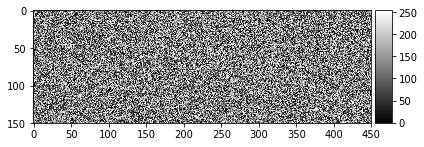

OUTPUT


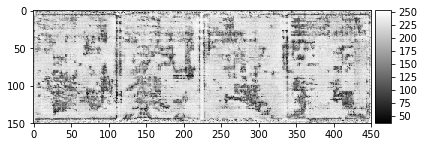

TARGET


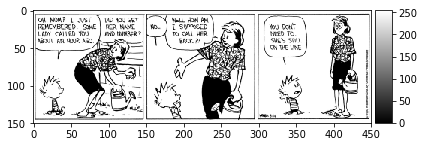

step  0 / 7367 d_loss:  0.0016479063779115677 g_loss:  [51.919655, 0.5110683, 0.8128282]
step  1 / 7367 d_loss:  0.001032858737744391 g_loss:  [47.684128, 0.4688724, 0.7968853]
step  2 / 7367 d_loss:  0.0028236950747668743 g_loss:  [46.54324, 0.4575676, 0.78648114]
step  3 / 7367 d_loss:  0.0013177928049117327 g_loss:  [45.875885, 0.45105118, 0.7707687]
step  4 / 7367 d_loss:  0.0009046365739777684 g_loss:  [51.507668, 0.5072418, 0.7834896]
step  5 / 7367 d_loss:  0.007448965683579445 g_loss:  [51.417805, 0.5062845, 0.78935593]
step  6 / 7367 d_loss:  0.002187405014410615 g_loss:  [44.855988, 0.44063985, 0.79200387]
step  7 / 7367 d_loss:  0.010193366557359695 g_loss:  [48.700184, 0.4788948, 0.81070447]
step  8 / 7367 d_loss:  0.008205851539969444 g_loss:  [46.412, 0.45593777, 0.8182219]
step  9 / 7367 d_loss:  0.008720066398382187 g_loss:  [48.963997, 0.48099902, 0.86409265]
step  10 / 7367 d_loss:  0.0050016106106340885 g_loss:  [53.07293, 0.52172965, 0.8999642]
step  11 / 7367 d_los

step  93 / 7367 d_loss:  0.0008925073780119419 g_loss:  [46.185127, 0.456148, 0.57032895]
step  94 / 7367 d_loss:  0.011062078177928925 g_loss:  [55.57241, 0.5499874, 0.5736722]
step  95 / 7367 d_loss:  0.0023948552552610636 g_loss:  [49.61077, 0.4901712, 0.593649]
step  96 / 7367 d_loss:  0.003115377388894558 g_loss:  [52.31743, 0.517066, 0.6108274]
step  97 / 7367 d_loss:  0.0062792617827653885 g_loss:  [59.129467, 0.5849382, 0.6356443]
step  98 / 7367 d_loss:  0.9846946001052856 g_loss:  [37.760345, 0.37159434, 0.6009118]
step  99 / 7367 d_loss:  0.014334131963551044 g_loss:  [52.195324, 0.51615506, 0.5798191]
step  100 / 7367 d_loss:  0.03204222396016121 g_loss:  [49.824837, 0.49257198, 0.56763816]
step  101 / 7367 d_loss:  0.02834317460656166 g_loss:  [76.84581, 0.7624663, 0.59918475]
step  102 / 7367 d_loss:  0.03196575120091438 g_loss:  [55.988213, 0.5532954, 0.65867436]
step  103 / 7367 d_loss:  0.029015418142080307 g_loss:  [49.168736, 0.48441863, 0.72687155]
step  104 / 7367 

step  184 / 7367 d_loss:  0.00210366933606565 g_loss:  [59.89961, 0.591362, 0.76340973]
step  185 / 7367 d_loss:  0.003701918525621295 g_loss:  [75.98162, 0.75205415, 0.7762035]
step  186 / 7367 d_loss:  0.0031267066951841116 g_loss:  [60.241398, 0.5944891, 0.7924894]
step  187 / 7367 d_loss:  0.0029270427767187357 g_loss:  [50.735607, 0.49937534, 0.7980736]
step  188 / 7367 d_loss:  0.0017243607435375452 g_loss:  [52.711884, 0.5189366, 0.8182271]
step  189 / 7367 d_loss:  0.004474865738302469 g_loss:  [52.804707, 0.5196936, 0.8353454]
step  190 / 7367 d_loss:  0.0011493258643895388 g_loss:  [55.490902, 0.54630387, 0.86051524]
step  191 / 7367 d_loss:  0.004099484067410231 g_loss:  [51.759254, 0.5089697, 0.86228096]
step  192 / 7367 d_loss:  0.0023195191752165556 g_loss:  [52.66041, 0.51770675, 0.8897354]
step  193 / 7367 d_loss:  0.0006207599653862417 g_loss:  [57.577724, 0.5665977, 0.9179553]
step  194 / 7367 d_loss:  0.0018516404088586569 g_loss:  [83.173805, 0.8223537, 0.9384307]
s

step  276 / 7367 d_loss:  0.0016772868111729622 g_loss:  [60.523052, 0.5982901, 0.6940426]
step  277 / 7367 d_loss:  0.007292962167412043 g_loss:  [41.67479, 0.40992728, 0.6820613]
step  278 / 7367 d_loss:  0.0001576815266162157 g_loss:  [53.989872, 0.5330926, 0.6806119]
step  279 / 7367 d_loss:  0.005778987891972065 g_loss:  [49.61646, 0.4892544, 0.69102144]
step  280 / 7367 d_loss:  0.007903088815510273 g_loss:  [60.7874, 0.60110915, 0.67648387]
step  281 / 7367 d_loss:  0.020820943638682365 g_loss:  [50.914185, 0.50227475, 0.6867111]
step  282 / 7367 d_loss:  0.0019721316639333963 g_loss:  [57.752594, 0.57052803, 0.6997914]
step  283 / 7367 d_loss:  0.005712926387786865 g_loss:  [52.403316, 0.5168318, 0.72013324]
step  284 / 7367 d_loss:  0.0042900037951767445 g_loss:  [51.263237, 0.5053122, 0.7320187]
step  285 / 7367 d_loss:  0.0038581874687224627 g_loss:  [44.35346, 0.4361658, 0.73687714]
step  286 / 7367 d_loss:  0.001413819845765829 g_loss:  [48.952682, 0.48203033, 0.749649]
st

step  367 / 7367 d_loss:  0.000973320216871798 g_loss:  [49.191048, 0.4836769, 0.823358]
step  368 / 7367 d_loss:  0.08457358181476593 g_loss:  [39.055832, 0.3825879, 0.7970435]
step  369 / 7367 d_loss:  0.0009453240199945867 g_loss:  [49.877163, 0.49095932, 0.78123116]
step  370 / 7367 d_loss:  0.0004944659885950387 g_loss:  [51.265167, 0.50492847, 0.77231985]
step  371 / 7367 d_loss:  0.001996248262003064 g_loss:  [42.430847, 0.41666898, 0.76394844]
step  372 / 7367 d_loss:  0.0023845366667956114 g_loss:  [45.587547, 0.44842726, 0.7448182]
step  373 / 7367 d_loss:  0.003230686066672206 g_loss:  [42.454403, 0.41696, 0.7584027]
step  374 / 7367 d_loss:  0.009963084012269974 g_loss:  [51.225094, 0.50466204, 0.75889105]
step  375 / 7367 d_loss:  0.00538281723856926 g_loss:  [46.834614, 0.46068335, 0.76627654]
step  376 / 7367 d_loss:  0.015945473685860634 g_loss:  [45.100323, 0.44316775, 0.78354573]
step  377 / 7367 d_loss:  0.0037864460609853268 g_loss:  [53.30836, 0.52516305, 0.7920575

step  458 / 7367 d_loss:  0.005188863258808851 g_loss:  [51.204144, 0.501451, 1.0590408]
step  459 / 7367 d_loss:  0.0029874746687710285 g_loss:  [53.617317, 0.52588224, 1.0290926]
step  460 / 7367 d_loss:  0.0018011056818068027 g_loss:  [47.57704, 0.46535674, 1.0413668]
step  461 / 7367 d_loss:  0.009335662238299847 g_loss:  [69.7704, 0.6875338, 1.017023]
step  462 / 7367 d_loss:  0.006025867536664009 g_loss:  [51.323074, 0.5034783, 0.9752454]
step  463 / 7367 d_loss:  0.023137226700782776 g_loss:  [45.071815, 0.44107953, 0.9638619]
step  464 / 7367 d_loss:  0.0026307161897420883 g_loss:  [52.968483, 0.5198982, 0.97866404]
step  465 / 7367 d_loss:  0.06560944020748138 g_loss:  [43.408524, 0.42465988, 0.94253373]
step  466 / 7367 d_loss:  0.003225024789571762 g_loss:  [52.48007, 0.5154088, 0.9391862]
step  467 / 7367 d_loss:  0.0012560478644445539 g_loss:  [53.75797, 0.5283213, 0.9258333]
step  468 / 7367 d_loss:  0.001498102443292737 g_loss:  [48.403847, 0.4750492, 0.8989262]
step  46

step  550 / 7367 d_loss:  0.031237246468663216 g_loss:  [51.23637, 0.5071831, 0.51806414]
step  551 / 7367 d_loss:  1.2571271657943726 g_loss:  [36.96567, 0.3648063, 0.48504227]
step  552 / 7367 d_loss:  0.04770933464169502 g_loss:  [61.965527, 0.6147118, 0.49434453]
step  553 / 7367 d_loss:  0.05684405192732811 g_loss:  [50.72183, 0.50217503, 0.50432503]
step  554 / 7367 d_loss:  0.0537540465593338 g_loss:  [52.383972, 0.51840544, 0.5434263]
step  555 / 7367 d_loss:  0.048377711325883865 g_loss:  [51.77049, 0.51167285, 0.603203]
step  556 / 7367 d_loss:  0.026711352169513702 g_loss:  [43.952724, 0.4329338, 0.659343]
step  557 / 7367 d_loss:  0.019755590707063675 g_loss:  [54.49734, 0.53755754, 0.7415897]
step  558 / 7367 d_loss:  0.007288506254553795 g_loss:  [42.80906, 0.4195825, 0.85081184]
step  559 / 7367 d_loss:  0.006908903364092112 g_loss:  [44.803627, 0.43897912, 0.9057163]
step  560 / 7367 d_loss:  0.0015512517420575023 g_loss:  [56.871952, 0.5591846, 0.95349]
step  561 / 736

step  641 / 7367 d_loss:  0.00821810495108366 g_loss:  [51.580894, 0.5073139, 0.84950405]
step  642 / 7367 d_loss:  0.020071718841791153 g_loss:  [44.842224, 0.4397595, 0.86627764]
step  643 / 7367 d_loss:  0.06344645470380783 g_loss:  [42.18318, 0.41311672, 0.87151116]
step  644 / 7367 d_loss:  0.622636079788208 g_loss:  [39.942238, 0.3911174, 0.830498]
step  645 / 7367 d_loss:  0.10352024435997009 g_loss:  [40.550247, 0.397625, 0.78774744]
step  646 / 7367 d_loss:  0.0029589615296572447 g_loss:  [53.760075, 0.5301236, 0.74771374]
step  647 / 7367 d_loss:  0.04618915542960167 g_loss:  [41.165165, 0.40447763, 0.71740216]
step  648 / 7367 d_loss:  0.0017377700423821807 g_loss:  [64.21452, 0.63532466, 0.6820548]
step  649 / 7367 d_loss:  0.006824214942753315 g_loss:  [50.677296, 0.50034297, 0.6429972]
step  650 / 7367 d_loss:  0.022266222164034843 g_loss:  [51.39174, 0.50772107, 0.6196314]
step  651 / 7367 d_loss:  0.01693953014910221 g_loss:  [44.43217, 0.43799993, 0.6321796]
step  652 

step  733 / 7367 d_loss:  0.008020993322134018 g_loss:  [43.925865, 0.43193722, 0.73214364]
step  734 / 7367 d_loss:  0.0033396719954907894 g_loss:  [57.912666, 0.57201445, 0.7112206]
step  735 / 7367 d_loss:  0.0045052324421703815 g_loss:  [58.468414, 0.5779234, 0.6760697]
step  736 / 7367 d_loss:  0.38193976879119873 g_loss:  [40.19274, 0.39595586, 0.5971551]
step  737 / 7367 d_loss:  0.010605640709400177 g_loss:  [51.90335, 0.5135575, 0.5476004]
step  738 / 7367 d_loss:  0.013826293870806694 g_loss:  [47.662453, 0.4713901, 0.5234409]
step  739 / 7367 d_loss:  0.011865378357470036 g_loss:  [50.20837, 0.4968587, 0.5225045]
step  740 / 7367 d_loss:  0.11633634567260742 g_loss:  [45.04328, 0.44531748, 0.5115375]
step  741 / 7367 d_loss:  0.012787126004695892 g_loss:  [47.845943, 0.47328946, 0.5169974]
step  742 / 7367 d_loss:  0.009649589657783508 g_loss:  [51.719006, 0.51182616, 0.5363888]
step  743 / 7367 d_loss:  0.008344038389623165 g_loss:  [49.87981, 0.4932037, 0.55943996]
step  7

step  824 / 7367 d_loss:  0.009433329105377197 g_loss:  [47.43522, 0.46396956, 1.038261]
step  825 / 7367 d_loss:  0.009274626150727272 g_loss:  [45.86225, 0.44868958, 0.9932923]
step  826 / 7367 d_loss:  0.031543608754873276 g_loss:  [43.21601, 0.42284572, 0.93143904]
step  827 / 7367 d_loss:  0.02879389561712742 g_loss:  [46.012177, 0.45130956, 0.88122153]
step  828 / 7367 d_loss:  0.0053029186092317104 g_loss:  [43.611538, 0.4277663, 0.83490855]
step  829 / 7367 d_loss:  0.0007521535153500736 g_loss:  [53.18905, 0.52379555, 0.8094931]
step  830 / 7367 d_loss:  0.005551998037844896 g_loss:  [49.766403, 0.48990342, 0.7760616]
step  831 / 7367 d_loss:  0.0015010146889835596 g_loss:  [55.21863, 0.54419917, 0.7987152]
step  832 / 7367 d_loss:  0.0010959466453641653 g_loss:  [54.511967, 0.53686863, 0.82510287]
step  833 / 7367 d_loss:  0.00043700746027752757 g_loss:  [54.84451, 0.5403176, 0.8127495]
step  834 / 7367 d_loss:  0.003994900267571211 g_loss:  [54.099937, 0.53277993, 0.82194376

step  916 / 7367 d_loss:  0.04321954399347305 g_loss:  [44.479603, 0.43507645, 0.9719582]
step  917 / 7367 d_loss:  0.024377381429076195 g_loss:  [59.104263, 0.5802997, 1.0742941]
step  918 / 7367 d_loss:  0.0514371395111084 g_loss:  [43.8061, 0.42707926, 1.0981712]
step  919 / 7367 d_loss:  0.025709103792905807 g_loss:  [60.035812, 0.5890499, 1.1308254]
step  920 / 7367 d_loss:  0.035444799810647964 g_loss:  [50.377632, 0.49205852, 1.1717807]
step  921 / 7367 d_loss:  0.022657684981822968 g_loss:  [52.955853, 0.5174046, 1.215388]
step  922 / 7367 d_loss:  0.031470999121665955 g_loss:  [45.128937, 0.4386481, 1.2641258]
step  923 / 7367 d_loss:  0.02695271372795105 g_loss:  [51.334637, 0.50018245, 1.3163911]
step  924 / 7367 d_loss:  0.006816533859819174 g_loss:  [73.9766, 0.72624886, 1.3517168]
step  925 / 7367 d_loss:  0.008943743072450161 g_loss:  [56.063538, 0.5467015, 1.3933859]
step  926 / 7367 d_loss:  0.0008863873081281781 g_loss:  [65.52431, 0.64112484, 1.4118229]
step  927 / 7

step  1008 / 7367 d_loss:  0.11543809622526169 g_loss:  [43.391754, 0.42511246, 0.88050884]
step  1009 / 7367 d_loss:  0.008834799751639366 g_loss:  [52.362083, 0.51478386, 0.8836965]
step  1010 / 7367 d_loss:  0.010753601789474487 g_loss:  [51.92726, 0.51033753, 0.8935082]
step  1011 / 7367 d_loss:  0.036698151379823685 g_loss:  [50.81388, 0.49909386, 0.90449333]
step  1012 / 7367 d_loss:  0.008193571120500565 g_loss:  [55.5836, 0.5465696, 0.9266405]
step  1013 / 7367 d_loss:  0.4217105209827423 g_loss:  [40.22441, 0.39334226, 0.8901847]
step  1014 / 7367 d_loss:  1.0052794218063354 g_loss:  [40.33297, 0.39561066, 0.7719032]
step  1015 / 7367 d_loss:  0.013403653167188168 g_loss:  [50.83497, 0.5012918, 0.7057861]
step  1016 / 7367 d_loss:  1.5925363302230835 g_loss:  [37.616714, 0.37015682, 0.60103285]
step  1017 / 7367 d_loss:  0.042001865804195404 g_loss:  [52.25756, 0.51701725, 0.55583555]
step  1018 / 7367 d_loss:  0.1044592335820198 g_loss:  [44.360054, 0.43839374, 0.5206793]
ste

step  1100 / 7367 d_loss:  0.02938365936279297 g_loss:  [44.093037, 0.42828578, 1.2644564]
step  1101 / 7367 d_loss:  0.0011452860198915005 g_loss:  [48.988415, 0.4778657, 1.2018486]
step  1102 / 7367 d_loss:  0.0006677287165075541 g_loss:  [46.206036, 0.45060262, 1.1457735]
step  1103 / 7367 d_loss:  0.003825756488367915 g_loss:  [52.56348, 0.5147158, 1.0919006]
step  1104 / 7367 d_loss:  6.157786992844194e-05 g_loss:  [46.759098, 0.45731544, 1.0275534]
step  1105 / 7367 d_loss:  0.00012073163816239685 g_loss:  [51.09651, 0.5010294, 0.993577]
step  1106 / 7367 d_loss:  0.00012502325989771634 g_loss:  [55.876484, 0.54916507, 0.9599759]
step  1107 / 7367 d_loss:  0.0031146546825766563 g_loss:  [42.003605, 0.41074282, 0.9293206]
step  1108 / 7367 d_loss:  0.1056194007396698 g_loss:  [40.82773, 0.39940968, 0.8867619]
step  1109 / 7367 d_loss:  0.0025851307436823845 g_loss:  [73.98494, 0.7312755, 0.85739034]
step  1110 / 7367 d_loss:  0.006538483314216137 g_loss:  [52.98486, 0.5214728, 0.8

step  1191 / 7367 d_loss:  0.0023758611641824245 g_loss:  [57.797344, 0.5690594, 0.8914059]
step  1192 / 7367 d_loss:  0.0013152000028640032 g_loss:  [52.869488, 0.52011853, 0.8576363]
step  1193 / 7367 d_loss:  0.0003033946850337088 g_loss:  [49.944916, 0.49098536, 0.8463792]
step  1194 / 7367 d_loss:  0.0024959640577435493 g_loss:  [48.352287, 0.4750996, 0.84232855]
step  1195 / 7367 d_loss:  0.0023338682949543 g_loss:  [46.368145, 0.45522702, 0.8454455]
step  1196 / 7367 d_loss:  0.0025722139980643988 g_loss:  [59.107925, 0.582505, 0.85742635]
step  1197 / 7367 d_loss:  0.18537895381450653 g_loss:  [41.007744, 0.40152538, 0.8552064]
step  1198 / 7367 d_loss:  0.006717282813042402 g_loss:  [47.994576, 0.47116697, 0.87788063]
step  1199 / 7367 d_loss:  0.009096997790038586 g_loss:  [55.623096, 0.5472456, 0.8985335]
step  1200 / 7367 d_loss:  0.009208460338413715 g_loss:  [52.289036, 0.5136703, 0.922006]
step  1201 / 7367 d_loss:  0.010916223749518394 g_loss:  [40.696415, 0.39747187, 0

step  1282 / 7367 d_loss:  0.006988077890127897 g_loss:  [45.536148, 0.44512016, 1.0241326]
step  1283 / 7367 d_loss:  0.0014150671195238829 g_loss:  [66.15969, 0.65127236, 1.0324564]
step  1284 / 7367 d_loss:  0.004495734814554453 g_loss:  [61.480457, 0.60453, 1.0274591]
step  1285 / 7367 d_loss:  0.0022600670345127583 g_loss:  [52.971043, 0.5196179, 1.0092498]
step  1286 / 7367 d_loss:  0.001526683452539146 g_loss:  [54.431965, 0.534349, 0.9970629]
step  1287 / 7367 d_loss:  0.002190812723711133 g_loss:  [50.865387, 0.4989327, 0.9721194]
step  1288 / 7367 d_loss:  0.0010107834823429585 g_loss:  [49.573784, 0.4861629, 0.9574942]
step  1289 / 7367 d_loss:  0.00022332803928293288 g_loss:  [48.806488, 0.47863808, 0.94267863]
step  1290 / 7367 d_loss:  0.0037789177149534225 g_loss:  [45.706665, 0.4479172, 0.91494787]
step  1291 / 7367 d_loss:  0.0018362211994826794 g_loss:  [51.403988, 0.5049425, 0.90974075]
step  1292 / 7367 d_loss:  0.0006286744610406458 g_loss:  [43.730537, 0.4284018, 

step  1372 / 7367 d_loss:  0.00021915930847171694 g_loss:  [48.055824, 0.4707442, 0.98140156]
step  1373 / 7367 d_loss:  0.00046748563181608915 g_loss:  [52.501053, 0.51518077, 0.9829743]
step  1374 / 7367 d_loss:  0.00024363012926187366 g_loss:  [56.491047, 0.55499476, 0.99156946]
step  1375 / 7367 d_loss:  0.0014302710769698024 g_loss:  [45.646774, 0.4464382, 1.0029576]
step  1376 / 7367 d_loss:  0.00471873115748167 g_loss:  [47.18, 0.4616419, 1.0158079]
step  1377 / 7367 d_loss:  0.0009383234428241849 g_loss:  [60.518177, 0.5949403, 1.0241477]
step  1378 / 7367 d_loss:  0.0012963229091838002 g_loss:  [51.519993, 0.50483847, 1.0361459]
step  1379 / 7367 d_loss:  0.0014703546185046434 g_loss:  [45.374855, 0.4434062, 1.034238]
step  1380 / 7367 d_loss:  0.0012866543838754296 g_loss:  [41.773773, 0.40746477, 1.0272938]
step  1381 / 7367 d_loss:  0.0008133763330988586 g_loss:  [45.54688, 0.44535816, 1.0110611]
step  1382 / 7367 d_loss:  0.0013543186942115426 g_loss:  [57.048496, 0.560609

step  1462 / 7367 d_loss:  0.004194953478872776 g_loss:  [67.31981, 0.6641603, 0.9037803]
step  1463 / 7367 d_loss:  0.003918105736374855 g_loss:  [48.414352, 0.47498882, 0.91547066]
step  1464 / 7367 d_loss:  0.004404490813612938 g_loss:  [39.387444, 0.38458437, 0.92900896]
step  1465 / 7367 d_loss:  0.004808140452951193 g_loss:  [48.363026, 0.47408247, 0.9547784]
step  1466 / 7367 d_loss:  0.00392952561378479 g_loss:  [59.10266, 0.58134735, 0.9679268]
step  1467 / 7367 d_loss:  0.0033991290256381035 g_loss:  [50.90693, 0.4991045, 0.99647856]
step  1468 / 7367 d_loss:  0.004487578757107258 g_loss:  [48.916092, 0.47895354, 1.020735]
step  1469 / 7367 d_loss:  0.002577756531536579 g_loss:  [43.79721, 0.4275334, 1.0438721]
step  1470 / 7367 d_loss:  0.0007399108144454658 g_loss:  [46.143684, 0.45066687, 1.0769963]
step  1471 / 7367 d_loss:  0.0029895768966525793 g_loss:  [43.558437, 0.42464706, 1.0937313]
step  1472 / 7367 d_loss:  0.011349821463227272 g_loss:  [107.44047, 1.0633037, 1.1

step  1553 / 7367 d_loss:  0.014556661248207092 g_loss:  [48.636646, 0.47860214, 0.7764308]
step  1554 / 7367 d_loss:  0.011154260486364365 g_loss:  [48.43434, 0.47653434, 0.7809059]
step  1555 / 7367 d_loss:  0.006835215725004673 g_loss:  [69.98694, 0.6919127, 0.79567033]
step  1556 / 7367 d_loss:  0.005328938364982605 g_loss:  [48.718166, 0.47896966, 0.82120144]
step  1557 / 7367 d_loss:  0.007601309567689896 g_loss:  [53.355164, 0.52502346, 0.85281914]
step  1558 / 7367 d_loss:  0.0026175042148679495 g_loss:  [50.260006, 0.49369335, 0.89067245]
step  1559 / 7367 d_loss:  0.0009882173035293818 g_loss:  [43.442627, 0.42513138, 0.929488]
step  1560 / 7367 d_loss:  0.0007157939253374934 g_loss:  [48.753574, 0.47811168, 0.94240725]
step  1561 / 7367 d_loss:  0.005858862306922674 g_loss:  [49.160183, 0.4819555, 0.9646351]
step  1562 / 7367 d_loss:  7.849815301597118e-05 g_loss:  [65.13035, 0.641634, 0.9669467]
step  1563 / 7367 d_loss:  0.01418290100991726 g_loss:  [45.594376, 0.44611552,

step  1644 / 7367 d_loss:  0.0031253420747816563 g_loss:  [52.868176, 0.520263, 0.84187466]
step  1645 / 7367 d_loss:  0.0031149708665907383 g_loss:  [43.97011, 0.43120047, 0.8500649]
step  1646 / 7367 d_loss:  0.006371826399117708 g_loss:  [53.58376, 0.52707887, 0.87587374]
step  1647 / 7367 d_loss:  0.0044257123954594135 g_loss:  [43.459564, 0.42549804, 0.9097598]
step  1648 / 7367 d_loss:  0.006894146092236042 g_loss:  [43.65142, 0.42698804, 0.952617]
step  1649 / 7367 d_loss:  0.00046839474816806614 g_loss:  [47.738434, 0.46749532, 0.9889037]
step  1650 / 7367 d_loss:  0.001149325747974217 g_loss:  [53.924984, 0.5290684, 1.0181417]
step  1651 / 7367 d_loss:  0.0003610390122048557 g_loss:  [60.599815, 0.59567213, 1.0326]
step  1652 / 7367 d_loss:  0.0022226213477551937 g_loss:  [49.594673, 0.48546898, 1.0477765]
step  1653 / 7367 d_loss:  0.002843373455107212 g_loss:  [60.54719, 0.5948992, 1.0572735]
step  1654 / 7367 d_loss:  0.0017243735492229462 g_loss:  [47.730064, 0.4668366, 1.

step  1733 / 7367 d_loss:  0.002656313357874751 g_loss:  [43.410706, 0.423923, 1.0184064]
step  1734 / 7367 d_loss:  0.0009070056257769465 g_loss:  [64.324036, 0.6330832, 1.0157115]
step  1735 / 7367 d_loss:  0.0007281668949872255 g_loss:  [43.25133, 0.42229348, 1.0219847]
step  1736 / 7367 d_loss:  0.003730952274054289 g_loss:  [51.88665, 0.50876236, 1.0104141]
step  1737 / 7367 d_loss:  2.5263398129027337e-05 g_loss:  [53.67141, 0.5266506, 1.0063472]
step  1738 / 7367 d_loss:  4.088547939318232e-06 g_loss:  [51.653652, 0.50665176, 0.98847497]
step  1739 / 7367 d_loss:  2.0372599465190433e-05 g_loss:  [42.81962, 0.41826338, 0.9932822]
step  1740 / 7367 d_loss:  7.115094194887206e-05 g_loss:  [51.747406, 0.5077035, 0.9770588]
step  1741 / 7367 d_loss:  4.012629688077141e-06 g_loss:  [49.660534, 0.4869294, 0.96759236]
step  1742 / 7367 d_loss:  0.0013607194414362311 g_loss:  [58.262455, 0.5729857, 0.9638811]
step  1743 / 7367 d_loss:  0.0013228729367256165 g_loss:  [58.18583, 0.57228196

step  1823 / 7367 d_loss:  0.00040478300070390105 g_loss:  [41.54925, 0.40489015, 1.060238]
step  1824 / 7367 d_loss:  0.0004122589307371527 g_loss:  [51.14986, 0.50107986, 1.0418739]
step  1825 / 7367 d_loss:  0.0005378799396567047 g_loss:  [49.098637, 0.4805709, 1.0415474]
step  1826 / 7367 d_loss:  0.0017728239763528109 g_loss:  [48.981724, 0.4794588, 1.0358447]
step  1827 / 7367 d_loss:  0.0010973394382745028 g_loss:  [60.148125, 0.59136134, 1.0119877]
step  1828 / 7367 d_loss:  0.0009656540933065116 g_loss:  [44.922504, 0.43924102, 0.9984028]
step  1829 / 7367 d_loss:  0.0001442610373487696 g_loss:  [50.949352, 0.49978772, 0.97058225]
step  1830 / 7367 d_loss:  0.000780225673224777 g_loss:  [47.663734, 0.46711507, 0.95222867]
step  1831 / 7367 d_loss:  0.10429814457893372 g_loss:  [36.111458, 0.35203865, 0.9075936]
step  1832 / 7367 d_loss:  0.003969746641814709 g_loss:  [49.83346, 0.48954642, 0.87881976]
step  1833 / 7367 d_loss:  0.0030814283527433872 g_loss:  [44.70987, 0.43848

step  1912 / 7367 d_loss:  0.0005733954021707177 g_loss:  [48.04737, 0.4715158, 0.89579153]
step  1913 / 7367 d_loss:  0.0005782771622762084 g_loss:  [52.16333, 0.5126499, 0.8983414]
step  1914 / 7367 d_loss:  0.001526017440482974 g_loss:  [46.314034, 0.4541482, 0.8992113]
step  1915 / 7367 d_loss:  0.005293949507176876 g_loss:  [40.517307, 0.39608097, 0.9092087]
step  1916 / 7367 d_loss:  0.0013604981359094381 g_loss:  [64.13802, 0.63212407, 0.9256148]
step  1917 / 7367 d_loss:  0.002154114656150341 g_loss:  [53.102467, 0.521677, 0.9347652]
step  1918 / 7367 d_loss:  0.0011383912060409784 g_loss:  [52.264668, 0.51323736, 0.9409347]
step  1919 / 7367 d_loss:  0.0006358825485222042 g_loss:  [49.217125, 0.48260388, 0.9567376]
step  1920 / 7367 d_loss:  0.0023723430931568146 g_loss:  [53.591545, 0.5262095, 0.97059447]
step  1921 / 7367 d_loss:  0.00018167188682127744 g_loss:  [49.232204, 0.48238066, 0.9941351]
step  1922 / 7367 d_loss:  0.00019301360589452088 g_loss:  [47.84151, 0.4683954

step  2002 / 7367 d_loss:  0.0013890103437006474 g_loss:  [48.730106, 0.478291, 0.9010059]
step  2003 / 7367 d_loss:  0.0007242818828672171 g_loss:  [45.37543, 0.44462773, 0.91265815]
step  2004 / 7367 d_loss:  0.0008463835110887885 g_loss:  [50.517746, 0.49592152, 0.92559415]
step  2005 / 7367 d_loss:  0.0005003908881917596 g_loss:  [46.564514, 0.45636088, 0.9284238]
step  2006 / 7367 d_loss:  0.0037834050599485636 g_loss:  [43.22016, 0.42276314, 0.943849]
step  2007 / 7367 d_loss:  0.0012985991779714823 g_loss:  [48.47767, 0.4754248, 0.9351886]
step  2008 / 7367 d_loss:  0.0025001741014420986 g_loss:  [47.55839, 0.46622208, 0.93618536]
step  2009 / 7367 d_loss:  0.0020679165609180927 g_loss:  [52.898235, 0.51989794, 0.90844524]
step  2010 / 7367 d_loss:  0.004833538085222244 g_loss:  [44.271667, 0.43361765, 0.9098991]
step  2011 / 7367 d_loss:  0.002679126337170601 g_loss:  [43.913345, 0.43035856, 0.8774907]
step  2012 / 7367 d_loss:  0.0016668230528011918 g_loss:  [46.101788, 0.4523

step  2093 / 7367 d_loss:  0.006644329521805048 g_loss:  [41.849087, 0.40770295, 1.0787925]
step  2094 / 7367 d_loss:  0.0012362799607217312 g_loss:  [44.636547, 0.43554875, 1.0816723]
step  2095 / 7367 d_loss:  0.004588179290294647 g_loss:  [46.049843, 0.44979435, 1.0704081]
step  2096 / 7367 d_loss:  0.002573154168203473 g_loss:  [42.979282, 0.41918877, 1.0604074]
step  2097 / 7367 d_loss:  0.0011799708008766174 g_loss:  [48.69866, 0.47662887, 1.0357727]
step  2098 / 7367 d_loss:  0.0005571625661104918 g_loss:  [49.194145, 0.4817163, 1.0225128]
step  2099 / 7367 d_loss:  0.0003833926166407764 g_loss:  [40.3945, 0.39392784, 1.0017171]
step  2100 / 7367 d_loss:  0.0026003392413258553 g_loss:  [53.84863, 0.5287014, 0.97848564]
step  2101 / 7367 d_loss:  0.0004073326999787241 g_loss:  [43.97779, 0.43013957, 0.96383435]
step  2102 / 7367 d_loss:  0.0008223041077144444 g_loss:  [41.620876, 0.40672407, 0.94847023]
step  2103 / 7367 d_loss:  0.0012486929772421718 g_loss:  [49.529865, 0.48597

step  2182 / 7367 d_loss:  0.0008963638683781028 g_loss:  [41.028736, 0.39975226, 1.0535091]
step  2183 / 7367 d_loss:  0.0011318966280668974 g_loss:  [48.39415, 0.47309253, 1.0848963]
step  2184 / 7367 d_loss:  0.0007294102106243372 g_loss:  [44.15567, 0.43049574, 1.1060942]
step  2185 / 7367 d_loss:  0.0011570019414648414 g_loss:  [48.178085, 0.47043848, 1.1342386]
step  2186 / 7367 d_loss:  0.0005877758376300335 g_loss:  [39.391605, 0.38217464, 1.17414]
step  2187 / 7367 d_loss:  0.00033754348987713456 g_loss:  [49.09501, 0.47925296, 1.1697135]
step  2188 / 7367 d_loss:  0.0025303002912551165 g_loss:  [51.734478, 0.5054982, 1.1846623]
step  2189 / 7367 d_loss:  0.0001646953314775601 g_loss:  [43.614544, 0.42438224, 1.1763178]
step  2190 / 7367 d_loss:  0.0035326844081282616 g_loss:  [63.80917, 0.6264103, 1.1681406]
step  2191 / 7367 d_loss:  0.00013181503163650632 g_loss:  [44.651222, 0.43505955, 1.1452659]
step  2192 / 7367 d_loss:  0.0005527285393327475 g_loss:  [53.884834, 0.5273

step  2272 / 7367 d_loss:  0.0002449204330332577 g_loss:  [56.380253, 0.55401623, 0.9786315]
step  2273 / 7367 d_loss:  7.688789628446102e-05 g_loss:  [47.40181, 0.46429136, 0.97266996]
step  2274 / 7367 d_loss:  0.00020916308858431876 g_loss:  [50.99705, 0.5002382, 0.97323155]
step  2275 / 7367 d_loss:  0.001600873889401555 g_loss:  [76.94177, 0.7596971, 0.97206366]
step  2276 / 7367 d_loss:  0.0011633113026618958 g_loss:  [46.325558, 0.45330787, 0.9947718]
step  2277 / 7367 d_loss:  0.00018403251306153834 g_loss:  [60.37961, 0.59374875, 1.0047327]
step  2278 / 7367 d_loss:  0.0004851127159781754 g_loss:  [47.095074, 0.46076724, 1.0183496]
step  2279 / 7367 d_loss:  0.0004729685024358332 g_loss:  [40.89199, 0.3987531, 1.0166806]
step  2280 / 7367 d_loss:  0.005604268051683903 g_loss:  [46.047977, 0.45041364, 1.0066129]
step  2281 / 7367 d_loss:  0.001523332204669714 g_loss:  [56.83146, 0.55842537, 0.9889202]
step  2282 / 7367 d_loss:  0.004305749665945768 g_loss:  [40.297234, 0.393235

step  2362 / 7367 d_loss:  0.0008309948607347906 g_loss:  [50.32598, 0.492651, 1.0608828]
step  2363 / 7367 d_loss:  0.003369432408362627 g_loss:  [35.66681, 0.3461998, 1.046831]
step  2364 / 7367 d_loss:  0.002293732250109315 g_loss:  [34.73259, 0.33700258, 1.0323346]
step  2365 / 7367 d_loss:  0.0013740635477006435 g_loss:  [51.574738, 0.5056353, 1.0112028]
step  2366 / 7367 d_loss:  0.002307301387190819 g_loss:  [43.640392, 0.42646292, 0.99409825]
step  2367 / 7367 d_loss:  0.00012314657215029 g_loss:  [46.529037, 0.4555364, 0.97539926]
step  2368 / 7367 d_loss:  0.0009234223398379982 g_loss:  [50.851574, 0.49899143, 0.95242906]
step  2369 / 7367 d_loss:  0.0013012969866394997 g_loss:  [40.20201, 0.39255637, 0.9463749]
step  2370 / 7367 d_loss:  7.96643435023725e-05 g_loss:  [54.31954, 0.53374964, 0.9445722]
step  2371 / 7367 d_loss:  0.0004768333747051656 g_loss:  [47.616776, 0.46691546, 0.9252295]
step  2372 / 7367 d_loss:  0.003449029289186001 g_loss:  [46.477757, 0.4554645, 0.93

step  2452 / 7367 d_loss:  0.0003640208160504699 g_loss:  [50.76489, 0.49731365, 1.0335245]
step  2453 / 7367 d_loss:  0.0001971153833437711 g_loss:  [50.774593, 0.49743888, 1.0307044]
step  2454 / 7367 d_loss:  0.0013335818657651544 g_loss:  [51.797825, 0.5077359, 1.0242347]
step  2455 / 7367 d_loss:  3.735093559953384e-05 g_loss:  [49.275303, 0.48266858, 1.0084475]
step  2456 / 7367 d_loss:  0.0006026451592333615 g_loss:  [56.756847, 0.55748427, 1.0084195]
step  2457 / 7367 d_loss:  0.0005292115383781493 g_loss:  [53.13288, 0.52133197, 0.9996817]
step  2458 / 7367 d_loss:  0.002365745371207595 g_loss:  [39.994167, 0.38978565, 1.0156022]
step  2459 / 7367 d_loss:  0.0006927172071300447 g_loss:  [44.592712, 0.4355408, 1.0386311]
step  2460 / 7367 d_loss:  2.5446448489674367e-05 g_loss:  [47.04652, 0.45985207, 1.0613153]
step  2461 / 7367 d_loss:  0.00511509831994772 g_loss:  [47.919697, 0.4682156, 1.0981363]
step  2462 / 7367 d_loss:  0.0001153274643002078 g_loss:  [47.9828, 0.4688757,

step  2542 / 7367 d_loss:  3.9793365431251004e-05 g_loss:  [71.18656, 0.70264405, 0.92215866]
step  2543 / 7367 d_loss:  0.0013883839128538966 g_loss:  [45.853283, 0.4494617, 0.9071134]
step  2544 / 7367 d_loss:  0.0033311243169009686 g_loss:  [40.27436, 0.39367238, 0.9071226]
step  2545 / 7367 d_loss:  0.0005976139800623059 g_loss:  [48.130802, 0.4722154, 0.9092596]
step  2546 / 7367 d_loss:  0.0026053250767290592 g_loss:  [40.23584, 0.39339387, 0.8964538]
step  2547 / 7367 d_loss:  0.00017939072859007865 g_loss:  [47.925934, 0.47029433, 0.8964977]
step  2548 / 7367 d_loss:  0.014292022213339806 g_loss:  [34.330906, 0.33450198, 0.88070613]
step  2549 / 7367 d_loss:  0.0003760780964512378 g_loss:  [49.87812, 0.4901411, 0.86400855]
step  2550 / 7367 d_loss:  0.000515426101628691 g_loss:  [51.698654, 0.5083671, 0.86194193]
step  2551 / 7367 d_loss:  0.0008048375020734966 g_loss:  [53.478428, 0.52626085, 0.8523438]
step  2552 / 7367 d_loss:  0.0031323274597525597 g_loss:  [43.674408, 0.42

step  2631 / 7367 d_loss:  0.02313063107430935 g_loss:  [32.632206, 0.31703264, 0.9289424]
step  2632 / 7367 d_loss:  3.499456215649843e-05 g_loss:  [63.150986, 0.62242967, 0.90802056]
step  2633 / 7367 d_loss:  0.0005582211306318641 g_loss:  [47.792404, 0.4690408, 0.8883233]
step  2634 / 7367 d_loss:  0.00033827853621914983 g_loss:  [42.61799, 0.41739783, 0.8782032]
step  2635 / 7367 d_loss:  0.0028843474574387074 g_loss:  [48.2239, 0.4734772, 0.87617934]
step  2636 / 7367 d_loss:  0.003364646341651678 g_loss:  [43.468243, 0.4259493, 0.873314]
step  2637 / 7367 d_loss:  0.00036094049573875964 g_loss:  [44.160942, 0.4327452, 0.8864243]
step  2638 / 7367 d_loss:  0.0016916225431486964 g_loss:  [44.20295, 0.43303385, 0.8995619]
step  2639 / 7367 d_loss:  0.00048461195547133684 g_loss:  [51.261875, 0.5032785, 0.93402475]
step  2640 / 7367 d_loss:  0.0006014269310981035 g_loss:  [33.959915, 0.33011654, 0.94826007]
step  2641 / 7367 d_loss:  0.00019733088265638798 g_loss:  [54.77503, 0.5381

step  2721 / 7367 d_loss:  0.0004476920294109732 g_loss:  [62.024437, 0.609362, 1.0882397]
step  2722 / 7367 d_loss:  0.0010921979555860162 g_loss:  [46.466858, 0.45385617, 1.0812434]
step  2723 / 7367 d_loss:  1.8377664673607796e-05 g_loss:  [49.25261, 0.48180217, 1.0723907]
step  2724 / 7367 d_loss:  0.00028151838341727853 g_loss:  [50.588818, 0.495157, 1.0731152]
step  2725 / 7367 d_loss:  7.386108336504549e-05 g_loss:  [48.914536, 0.4785401, 1.0605274]
step  2726 / 7367 d_loss:  0.0004445152299012989 g_loss:  [45.764786, 0.4471303, 1.0517567]
step  2727 / 7367 d_loss:  0.0007731340592727065 g_loss:  [40.33046, 0.39283136, 1.0473257]
step  2728 / 7367 d_loss:  0.0006290437304414809 g_loss:  [39.99102, 0.38945457, 1.0455647]
step  2729 / 7367 d_loss:  0.0024295211769640446 g_loss:  [47.88481, 0.46843442, 1.0413707]
step  2730 / 7367 d_loss:  0.0012701208470389247 g_loss:  [50.02697, 0.49004027, 1.0229427]
step  2731 / 7367 d_loss:  0.0067580328322947025 g_loss:  [46.143585, 0.4513762

step  2811 / 7367 d_loss:  0.0014640328008681536 g_loss:  [44.982903, 0.44017035, 0.96586514]
step  2812 / 7367 d_loss:  0.003444286994636059 g_loss:  [48.11588, 0.4712814, 0.9877398]
step  2813 / 7367 d_loss:  0.0027299111243337393 g_loss:  [46.098984, 0.45084596, 1.0143889]
step  2814 / 7367 d_loss:  0.0012664585374295712 g_loss:  [39.90315, 0.3886532, 1.0378289]
step  2815 / 7367 d_loss:  3.278870281064883e-05 g_loss:  [49.870186, 0.48803443, 1.0667428]
step  2816 / 7367 d_loss:  0.0003023647586815059 g_loss:  [57.042065, 0.5595795, 1.0841156]
step  2817 / 7367 d_loss:  0.0004819883033633232 g_loss:  [50.671158, 0.49567962, 1.1031965]
step  2818 / 7367 d_loss:  0.0007241685525514185 g_loss:  [62.263695, 0.6116182, 1.1018709]
step  2819 / 7367 d_loss:  0.002037505619227886 g_loss:  [56.780396, 0.5569758, 1.082819]
step  2820 / 7367 d_loss:  0.0001209402980748564 g_loss:  [45.181652, 0.44120803, 1.0608479]
step  2821 / 7367 d_loss:  0.0014138430124148726 g_loss:  [53.22607, 0.521756, 

step  2900 / 7367 d_loss:  0.005354203283786774 g_loss:  [44.41355, 0.43549553, 0.8639965]
step  2901 / 7367 d_loss:  0.005583764985203743 g_loss:  [50.395145, 0.49495742, 0.89940214]
step  2902 / 7367 d_loss:  0.0041078440845012665 g_loss:  [47.942154, 0.47021654, 0.92049813]
step  2903 / 7367 d_loss:  0.0025767141487449408 g_loss:  [48.068256, 0.47103384, 0.96487004]
step  2904 / 7367 d_loss:  0.0028957920148968697 g_loss:  [38.92213, 0.3791068, 1.0114502]
step  2905 / 7367 d_loss:  0.0022957967594265938 g_loss:  [65.94225, 0.6488208, 1.0601715]
step  2906 / 7367 d_loss:  0.0008876290521584451 g_loss:  [46.6342, 0.45532322, 1.1018777]
step  2907 / 7367 d_loss:  0.00028932394343428314 g_loss:  [49.350067, 0.48207927, 1.1421379]
step  2908 / 7367 d_loss:  0.00045703916111961007 g_loss:  [55.21331, 0.54030263, 1.1830478]
step  2909 / 7367 d_loss:  0.0004620856198016554 g_loss:  [42.566856, 0.4136364, 1.203216]
step  2910 / 7367 d_loss:  0.0009119994938373566 g_loss:  [44.249264, 0.43031

step  2989 / 7367 d_loss:  0.00560908205807209 g_loss:  [59.471436, 0.5844772, 1.023715]
step  2990 / 7367 d_loss:  0.0005201460444368422 g_loss:  [37.129807, 0.36126545, 1.0032625]
step  2991 / 7367 d_loss:  0.00037283622077666223 g_loss:  [49.437935, 0.48455507, 0.98242867]
step  2992 / 7367 d_loss:  0.0005584432510659099 g_loss:  [41.161278, 0.4017401, 0.9872668]
step  2993 / 7367 d_loss:  0.00020563021826092154 g_loss:  [49.027306, 0.48028946, 0.9983614]
step  2994 / 7367 d_loss:  0.00011625864135567099 g_loss:  [39.080967, 0.38073114, 1.0078543]
step  2995 / 7367 d_loss:  0.0005220857565291226 g_loss:  [58.980656, 0.57960904, 1.0197537]
step  2996 / 7367 d_loss:  0.0002796078915707767 g_loss:  [47.699764, 0.4667177, 1.0279943]
step  2997 / 7367 d_loss:  0.22759948670864105 g_loss:  [32.244743, 0.31310457, 0.9342849]
step  2998 / 7367 d_loss:  0.0004411557165440172 g_loss:  [42.29534, 0.4142434, 0.87100184]
step  2999 / 7367 d_loss:  0.001986183924600482 g_loss:  [47.52897, 0.46703

step  3079 / 7367 d_loss:  5.1852810429409146e-05 g_loss:  [46.22168, 0.45289963, 0.93171644]
step  3080 / 7367 d_loss:  0.00015539921878371388 g_loss:  [44.814186, 0.43890363, 0.9238248]
step  3081 / 7367 d_loss:  0.00035116885555908084 g_loss:  [48.836502, 0.4791104, 0.92546606]
step  3082 / 7367 d_loss:  0.0002721423516049981 g_loss:  [51.473515, 0.50552505, 0.9210085]
step  3083 / 7367 d_loss:  0.00042290997225791216 g_loss:  [45.18866, 0.44283223, 0.9054356]
step  3084 / 7367 d_loss:  0.0027456406969577074 g_loss:  [52.516766, 0.5162621, 0.8905518]
step  3085 / 7367 d_loss:  8.710389374755323e-05 g_loss:  [43.87146, 0.4300125, 0.8702088]
step  3086 / 7367 d_loss:  0.0016063470393419266 g_loss:  [42.850346, 0.42002565, 0.8477827]
step  3087 / 7367 d_loss:  5.282498932501767e-06 g_loss:  [46.09595, 0.45266932, 0.8290173]
step  3088 / 7367 d_loss:  4.732525485451333e-05 g_loss:  [48.296505, 0.4748505, 0.81145364]
step  3089 / 7367 d_loss:  0.0002793217427097261 g_loss:  [49.20858, 0.

step  3169 / 7367 d_loss:  0.0010812400141730905 g_loss:  [44.264946, 0.43242803, 1.0221447]
step  3170 / 7367 d_loss:  0.0017011140007525682 g_loss:  [50.441353, 0.49445358, 0.99599427]
step  3171 / 7367 d_loss:  0.0018993767444044352 g_loss:  [47.776768, 0.46794155, 0.98261136]
step  3172 / 7367 d_loss:  0.005667398683726788 g_loss:  [52.26962, 0.51269406, 1.0002141]
step  3173 / 7367 d_loss:  0.008090159855782986 g_loss:  [44.57181, 0.43578166, 0.9936465]
step  3174 / 7367 d_loss:  0.0071575827896595 g_loss:  [54.56263, 0.53518295, 1.0443343]
step  3175 / 7367 d_loss:  0.00493290601298213 g_loss:  [51.73457, 0.5062727, 1.1073018]
step  3176 / 7367 d_loss:  0.029101537540555 g_loss:  [37.2018, 0.3605273, 1.1490693]
step  3177 / 7367 d_loss:  0.002827931195497513 g_loss:  [54.192894, 0.5297355, 1.2193453]
step  3178 / 7367 d_loss:  0.00307288346812129 g_loss:  [44.87591, 0.4359121, 1.2847041]
step  3179 / 7367 d_loss:  0.0001612975465832278 g_loss:  [76.864494, 0.7552137, 1.3431275]
s

step  3259 / 7367 d_loss:  0.002282415982335806 g_loss:  [48.68413, 0.47919592, 0.7645393]
step  3260 / 7367 d_loss:  9.789029718376696e-05 g_loss:  [42.7179, 0.41883597, 0.83430064]
step  3261 / 7367 d_loss:  0.00029482028912752867 g_loss:  [48.178947, 0.4729345, 0.88549274]
step  3262 / 7367 d_loss:  0.0018562013283371925 g_loss:  [64.17264, 0.6327016, 0.9024822]
step  3263 / 7367 d_loss:  0.002457844791933894 g_loss:  [61.12758, 0.60187256, 0.9403221]
step  3264 / 7367 d_loss:  0.005039408337324858 g_loss:  [61.964405, 0.6097078, 0.9936295]
step  3265 / 7367 d_loss:  0.00048674867139197886 g_loss:  [52.415333, 0.5138683, 1.028508]
step  3266 / 7367 d_loss:  0.00098699820227921 g_loss:  [46.94901, 0.45901906, 1.0471042]
step  3267 / 7367 d_loss:  0.008893822319805622 g_loss:  [41.211372, 0.40185422, 1.0259509]
step  3268 / 7367 d_loss:  0.005124255083501339 g_loss:  [40.320942, 0.3929407, 1.0268717]
step  3269 / 7367 d_loss:  0.007576547097414732 g_loss:  [43.489933, 0.42466933, 1.02

step  3349 / 7367 d_loss:  0.0010911596473306417 g_loss:  [66.23641, 0.6508646, 1.1499575]
step  3350 / 7367 d_loss:  0.0020678893197327852 g_loss:  [54.15176, 0.5302627, 1.125489]
step  3351 / 7367 d_loss:  0.0037766469176858664 g_loss:  [54.834644, 0.5370733, 1.1273102]
step  3352 / 7367 d_loss:  0.0039057759568095207 g_loss:  [53.107895, 0.51951945, 1.1559496]
step  3353 / 7367 d_loss:  0.0029885368421673775 g_loss:  [52.377327, 0.512122, 1.1651305]
step  3354 / 7367 d_loss:  0.0009040477452799678 g_loss:  [57.34516, 0.5616377, 1.1813943]
step  3355 / 7367 d_loss:  0.002465559635311365 g_loss:  [54.322613, 0.5314603, 1.1765863]
step  3356 / 7367 d_loss:  0.012934846803545952 g_loss:  [50.75671, 0.49611413, 1.1452994]
step  3357 / 7367 d_loss:  0.01268713641911745 g_loss:  [56.88355, 0.55833775, 1.0497727]
step  3358 / 7367 d_loss:  0.02623830735683441 g_loss:  [47.41198, 0.4646409, 0.94788957]
step  3359 / 7367 d_loss:  0.02134043350815773 g_loss:  [52.83403, 0.52015775, 0.81825507]

step  3440 / 7367 d_loss:  0.012224698439240456 g_loss:  [51.84228, 0.50486845, 1.3554387]
step  3441 / 7367 d_loss:  0.03399302065372467 g_loss:  [42.70701, 0.41390225, 1.316782]
step  3442 / 7367 d_loss:  0.015110107138752937 g_loss:  [51.58127, 0.5033295, 1.2483168]
step  3443 / 7367 d_loss:  0.012391779571771622 g_loss:  [52.268097, 0.5107438, 1.1937182]
step  3444 / 7367 d_loss:  0.023909198120236397 g_loss:  [45.42951, 0.442959, 1.1336049]
step  3445 / 7367 d_loss:  0.011548973619937897 g_loss:  [47.076477, 0.45991218, 1.0852593]
step  3446 / 7367 d_loss:  0.008483698591589928 g_loss:  [50.582672, 0.49517262, 1.0654107]
step  3447 / 7367 d_loss:  0.009509935975074768 g_loss:  [47.26869, 0.46225616, 1.0430709]
step  3448 / 7367 d_loss:  0.042828042060136795 g_loss:  [44.6641, 0.43672234, 0.9918677]
step  3449 / 7367 d_loss:  0.0005659821326844394 g_loss:  [52.82165, 0.5187096, 0.95068955]
step  3450 / 7367 d_loss:  0.000673153146635741 g_loss:  [51.54051, 0.50651085, 0.88942397]
s

step  3531 / 7367 d_loss:  0.0005884557613171637 g_loss:  [49.55466, 0.48373938, 1.1807199]
step  3532 / 7367 d_loss:  0.00013832096010446548 g_loss:  [52.068546, 0.50845045, 1.2235019]
step  3533 / 7367 d_loss:  0.03930419310927391 g_loss:  [42.910538, 0.4169088, 1.2196568]
step  3534 / 7367 d_loss:  0.00047835070290602744 g_loss:  [50.06016, 0.4882853, 1.2316332]
step  3535 / 7367 d_loss:  0.00030792702455073595 g_loss:  [74.11456, 0.7291491, 1.1996548]
step  3536 / 7367 d_loss:  0.002002417342737317 g_loss:  [50.640152, 0.4948104, 1.1591111]
step  3537 / 7367 d_loss:  0.0007122069364413619 g_loss:  [53.06698, 0.5199679, 1.070188]
step  3538 / 7367 d_loss:  0.00011355106835253537 g_loss:  [55.67805, 0.5467274, 1.0053083]
step  3539 / 7367 d_loss:  0.00019223416165914387 g_loss:  [50.126694, 0.49175277, 0.9514158]
step  3540 / 7367 d_loss:  0.0001082241942640394 g_loss:  [48.619232, 0.4770048, 0.9187494]
step  3541 / 7367 d_loss:  0.15238584578037262 g_loss:  [40.89177, 0.4003623, 0.8

step  3621 / 7367 d_loss:  0.003076753579080105 g_loss:  [50.845158, 0.50026995, 0.8181594]
step  3622 / 7367 d_loss:  0.004797958303242922 g_loss:  [77.49715, 0.767145, 0.78264487]
step  3623 / 7367 d_loss:  0.013267546892166138 g_loss:  [59.35761, 0.586169, 0.74070686]
step  3624 / 7367 d_loss:  0.007019126787781715 g_loss:  [47.930992, 0.47224447, 0.70654714]
step  3625 / 7367 d_loss:  0.00042149837827309966 g_loss:  [50.202194, 0.49543062, 0.6591323]
step  3626 / 7367 d_loss:  0.0018232048023492098 g_loss:  [47.1716, 0.465479, 0.6237029]
step  3627 / 7367 d_loss:  0.0037798373959958553 g_loss:  [45.888332, 0.4526639, 0.6219452]
step  3628 / 7367 d_loss:  0.007127507124096155 g_loss:  [47.49379, 0.4687037, 0.62342066]
step  3629 / 7367 d_loss:  0.009409211575984955 g_loss:  [43.059177, 0.4243174, 0.62743866]
step  3630 / 7367 d_loss:  0.014550796709954739 g_loss:  [61.250843, 0.6061155, 0.6392896]
step  3631 / 7367 d_loss:  0.01563091389834881 g_loss:  [49.0831, 0.484289, 0.6542034]

step  3712 / 7367 d_loss:  0.000768412253819406 g_loss:  [55.164753, 0.5402619, 1.1385603]
step  3713 / 7367 d_loss:  0.0001374122075503692 g_loss:  [64.72024, 0.6361633, 1.1039122]
step  3714 / 7367 d_loss:  0.003064811695367098 g_loss:  [50.787243, 0.49706122, 1.0811187]
step  3715 / 7367 d_loss:  0.02315828949213028 g_loss:  [46.194035, 0.4512395, 1.070084]
step  3716 / 7367 d_loss:  0.0057613118551671505 g_loss:  [47.8343, 0.46788186, 1.0461164]
step  3717 / 7367 d_loss:  0.0074718063697218895 g_loss:  [48.808327, 0.47791418, 1.016906]
step  3718 / 7367 d_loss:  0.051512304693460464 g_loss:  [48.756947, 0.4777098, 0.9859643]
step  3719 / 7367 d_loss:  0.012061589397490025 g_loss:  [59.304813, 0.5834565, 0.9591642]
step  3720 / 7367 d_loss:  0.009514720179140568 g_loss:  [57.55325, 0.5664058, 0.9126685]
step  3721 / 7367 d_loss:  0.007444040384143591 g_loss:  [52.521984, 0.51652783, 0.8692]
step  3722 / 7367 d_loss:  0.03033558465540409 g_loss:  [46.62813, 0.45815253, 0.8128785]
ste

step  3803 / 7367 d_loss:  0.04374498873949051 g_loss:  [41.389236, 0.40229115, 1.1601201]
step  3804 / 7367 d_loss:  0.018180212005972862 g_loss:  [43.094612, 0.41930908, 1.1637024]
step  3805 / 7367 d_loss:  0.7556847929954529 g_loss:  [36.791275, 0.35729167, 1.0621088]
step  3806 / 7367 d_loss:  1.3879011869430542 g_loss:  [35.034515, 0.34125277, 0.90923697]
step  3807 / 7367 d_loss:  0.024167973548173904 g_loss:  [46.958897, 0.46138722, 0.82017356]
step  3808 / 7367 d_loss:  0.026352642104029655 g_loss:  [53.847294, 0.5308045, 0.7668409]
step  3809 / 7367 d_loss:  0.063170425593853 g_loss:  [42.015675, 0.41295525, 0.7201489]
step  3810 / 7367 d_loss:  0.026933111250400543 g_loss:  [58.825085, 0.58117115, 0.70796925]
step  3811 / 7367 d_loss:  0.019753187894821167 g_loss:  [53.7291, 0.5300118, 0.72791964]
step  3812 / 7367 d_loss:  0.006185703445225954 g_loss:  [41.16357, 0.40396506, 0.76706326]
step  3813 / 7367 d_loss:  0.010918417014181614 g_loss:  [49.645752, 0.4883621, 0.809540

step  3893 / 7367 d_loss:  0.012338949367403984 g_loss:  [43.843433, 0.42880532, 0.96290255]
step  3894 / 7367 d_loss:  0.009078770875930786 g_loss:  [56.49665, 0.555578, 0.9388496]
step  3895 / 7367 d_loss:  0.012410781346261501 g_loss:  [64.0603, 0.6313838, 0.92192554]
step  3896 / 7367 d_loss:  0.012357478030025959 g_loss:  [53.325584, 0.52423924, 0.9016617]
step  3897 / 7367 d_loss:  0.01683630608022213 g_loss:  [55.226147, 0.5433132, 0.8948262]
step  3898 / 7367 d_loss:  0.023497577756643295 g_loss:  [53.267265, 0.523566, 0.9106622]
step  3899 / 7367 d_loss:  0.009705275297164917 g_loss:  [54.423946, 0.5347679, 0.9471563]
step  3900 / 7367 d_loss:  0.005679088179022074 g_loss:  [53.040436, 0.52035797, 1.00464]
step  3901 / 7367 d_loss:  0.011637909337878227 g_loss:  [46.06613, 0.45015517, 1.0506145]
step  3902 / 7367 d_loss:  0.00017032276082318276 g_loss:  [58.06213, 0.5695353, 1.1085975]
step  3903 / 7367 d_loss:  0.012847832404077053 g_loss:  [46.206303, 0.45092615, 1.1136857]


step  3983 / 7367 d_loss:  0.0021285079419612885 g_loss:  [55.829197, 0.5507665, 0.75254273]
step  3984 / 7367 d_loss:  0.0026769700925797224 g_loss:  [49.865368, 0.4912761, 0.7377587]
step  3985 / 7367 d_loss:  0.0012034967076033354 g_loss:  [60.167904, 0.59427905, 0.73999846]
step  3986 / 7367 d_loss:  0.0014225500635802746 g_loss:  [57.129974, 0.5640771, 0.7222673]
step  3987 / 7367 d_loss:  0.0073205227963626385 g_loss:  [50.168526, 0.49460533, 0.70799243]
step  3988 / 7367 d_loss:  0.001346271252259612 g_loss:  [50.604485, 0.4990095, 0.70353776]
step  3989 / 7367 d_loss:  0.0005550412461161613 g_loss:  [47.421024, 0.4671129, 0.7097344]
step  3990 / 7367 d_loss:  0.006406682543456554 g_loss:  [54.480686, 0.53752977, 0.72770923]
step  3991 / 7367 d_loss:  0.07049544155597687 g_loss:  [40.965275, 0.40236884, 0.72838944]
step  3992 / 7367 d_loss:  0.0030872495844960213 g_loss:  [51.898647, 0.511654, 0.7332448]
step  3993 / 7367 d_loss:  0.006902593187987804 g_loss:  [45.16711, 0.44425

step  4073 / 7367 d_loss:  0.0024105284828692675 g_loss:  [59.60545, 0.5868098, 0.9244677]
step  4074 / 7367 d_loss:  0.003904603188857436 g_loss:  [56.385876, 0.55447197, 0.9386774]
step  4075 / 7367 d_loss:  0.013502003625035286 g_loss:  [51.69373, 0.5074461, 0.94911814]
step  4076 / 7367 d_loss:  0.01916993036866188 g_loss:  [47.529995, 0.46556085, 0.97391224]
step  4077 / 7367 d_loss:  0.015191808342933655 g_loss:  [51.282703, 0.50287086, 0.9956164]
step  4078 / 7367 d_loss:  0.009153341874480247 g_loss:  [50.38464, 0.4933382, 1.0508207]
step  4079 / 7367 d_loss:  0.010704487562179565 g_loss:  [55.66974, 0.5456806, 1.1016792]
step  4080 / 7367 d_loss:  0.004976710770279169 g_loss:  [62.779804, 0.6159937, 1.180437]
step  4081 / 7367 d_loss:  0.003934328909963369 g_loss:  [53.331814, 0.520969, 1.2349182]
step  4082 / 7367 d_loss:  0.005654133390635252 g_loss:  [56.3331, 0.5504549, 1.2876086]
step  4083 / 7367 d_loss:  0.0044036125764250755 g_loss:  [55.2431, 0.5393758, 1.3055229]
ste

step  4163 / 7367 d_loss:  0.08946745842695236 g_loss:  [42.032204, 0.41024652, 1.0075539]
step  4164 / 7367 d_loss:  0.002179577015340328 g_loss:  [86.720436, 0.85745, 0.97543633]
step  4165 / 7367 d_loss:  0.5807249546051025 g_loss:  [38.390186, 0.37546116, 0.8440699]
step  4166 / 7367 d_loss:  0.009412764571607113 g_loss:  [42.88922, 0.4212399, 0.7652273]
step  4167 / 7367 d_loss:  0.004853882361203432 g_loss:  [58.335903, 0.5762185, 0.71405244]
step  4168 / 7367 d_loss:  0.0030886840540915728 g_loss:  [56.242886, 0.55567145, 0.6757405]
step  4169 / 7367 d_loss:  0.0032158298417925835 g_loss:  [46.52329, 0.45879698, 0.64358807]
step  4170 / 7367 d_loss:  0.014573687687516212 g_loss:  [47.74562, 0.47107783, 0.63783664]
step  4171 / 7367 d_loss:  0.008522985503077507 g_loss:  [44.893406, 0.44248027, 0.64537865]
step  4172 / 7367 d_loss:  0.006546761374920607 g_loss:  [56.05645, 0.55394, 0.662447]
step  4173 / 7367 d_loss:  0.008708328008651733 g_loss:  [52.935307, 0.5224055, 0.694754]

step  4255 / 7367 d_loss:  0.38579314947128296 g_loss:  [36.812138, 0.35927024, 0.88511103]
step  4256 / 7367 d_loss:  0.0007867095991969109 g_loss:  [47.3338, 0.46498916, 0.8348858]
step  4257 / 7367 d_loss:  0.0024830291513353586 g_loss:  [45.388382, 0.44581482, 0.80690163]
step  4258 / 7367 d_loss:  0.0007209080504253507 g_loss:  [48.65665, 0.4786232, 0.79432917]
step  4259 / 7367 d_loss:  0.0020435231272131205 g_loss:  [70.38169, 0.69576615, 0.8050786]
step  4260 / 7367 d_loss:  0.004683519713580608 g_loss:  [44.659615, 0.43837944, 0.82166886]
step  4261 / 7367 d_loss:  0.005956570152193308 g_loss:  [55.78587, 0.5493, 0.8558693]
step  4262 / 7367 d_loss:  0.0009666202822700143 g_loss:  [44.21145, 0.43331048, 0.8804002]
step  4263 / 7367 d_loss:  0.0025070335250347853 g_loss:  [50.548946, 0.49637258, 0.9116895]
step  4264 / 7367 d_loss:  0.001333840424194932 g_loss:  [62.617184, 0.6170391, 0.9132763]
step  4265 / 7367 d_loss:  0.000912745832465589 g_loss:  [53.58952, 0.52691364, 0.8

step  4346 / 7367 d_loss:  0.01691652648150921 g_loss:  [53.24187, 0.5224648, 0.99538785]
step  4347 / 7367 d_loss:  0.005510151386260986 g_loss:  [65.87718, 0.64838076, 1.0391059]
step  4348 / 7367 d_loss:  0.0028840680606663227 g_loss:  [40.985374, 0.39907202, 1.0781715]
step  4349 / 7367 d_loss:  0.000467710749944672 g_loss:  [43.617287, 0.42469573, 1.1477114]
step  4350 / 7367 d_loss:  0.001421125140041113 g_loss:  [58.551514, 0.57369435, 1.1820778]
step  4351 / 7367 d_loss:  0.0006104189669713378 g_loss:  [57.59843, 0.56391436, 1.2069936]
step  4352 / 7367 d_loss:  0.0001444810623070225 g_loss:  [56.063934, 0.5484465, 1.2192866]
step  4353 / 7367 d_loss:  0.0003272545582149178 g_loss:  [53.82037, 0.5259352, 1.2268522]
step  4354 / 7367 d_loss:  0.000551700359210372 g_loss:  [57.569336, 0.5634527, 1.2240622]
step  4355 / 7367 d_loss:  0.0003779410326387733 g_loss:  [51.432762, 0.5023526, 1.1975003]
step  4356 / 7367 d_loss:  0.0030688922852277756 g_loss:  [50.920464, 0.4974536, 1.1

step  4437 / 7367 d_loss:  0.006858320441097021 g_loss:  [46.249035, 0.45161006, 1.088027]
step  4438 / 7367 d_loss:  0.009079096838831902 g_loss:  [42.414757, 0.41346285, 1.0684729]
step  4439 / 7367 d_loss:  0.0007913517183624208 g_loss:  [49.110535, 0.48055157, 1.0553762]
step  4440 / 7367 d_loss:  0.0006371876806952059 g_loss:  [53.783264, 0.52727395, 1.055869]
step  4441 / 7367 d_loss:  0.006859262008219957 g_loss:  [45.233013, 0.44179374, 1.0536376]
step  4442 / 7367 d_loss:  0.00018537140567786992 g_loss:  [47.189354, 0.4613503, 1.0543269]
step  4443 / 7367 d_loss:  0.004450100474059582 g_loss:  [42.98474, 0.4192102, 1.0637225]
step  4444 / 7367 d_loss:  0.0001070464204531163 g_loss:  [59.255444, 0.5818129, 1.0741506]
step  4445 / 7367 d_loss:  0.0007370201055891812 g_loss:  [52.87969, 0.5181062, 1.0690639]
step  4446 / 7367 d_loss:  0.0008013477199710906 g_loss:  [48.695274, 0.47607473, 1.0878032]
step  4447 / 7367 d_loss:  0.0008862924296408892 g_loss:  [47.526146, 0.4647122, 

step  4527 / 7367 d_loss:  0.005828376859426498 g_loss:  [54.619556, 0.5359109, 1.0284637]
step  4528 / 7367 d_loss:  0.007877735421061516 g_loss:  [56.51453, 0.5548384, 1.0306889]
step  4529 / 7367 d_loss:  0.006923271808773279 g_loss:  [55.990807, 0.5494161, 1.0491955]
step  4530 / 7367 d_loss:  0.009736340492963791 g_loss:  [61.67022, 0.6062351, 1.0467103]
step  4531 / 7367 d_loss:  0.015231972560286522 g_loss:  [42.00832, 0.40969703, 1.0386171]
step  4532 / 7367 d_loss:  0.014167663641273975 g_loss:  [78.45063, 0.7741445, 1.0361898]
step  4533 / 7367 d_loss:  0.30768439173698425 g_loss:  [37.303665, 0.36315784, 0.9878794]
step  4534 / 7367 d_loss:  0.008253991603851318 g_loss:  [49.740818, 0.4878706, 0.953757]
step  4535 / 7367 d_loss:  0.009044211357831955 g_loss:  [49.3576, 0.48422015, 0.9355858]
step  4536 / 7367 d_loss:  0.008434826508164406 g_loss:  [46.201675, 0.4527056, 0.93111867]
step  4537 / 7367 d_loss:  0.028220921754837036 g_loss:  [38.962795, 0.38029572, 0.93322366]
s

step  4618 / 7367 d_loss:  0.018246261402964592 g_loss:  [48.913216, 0.47859874, 1.053341]
step  4619 / 7367 d_loss:  0.01245055440813303 g_loss:  [49.046017, 0.479492, 1.0968173]
step  4620 / 7367 d_loss:  0.009185805916786194 g_loss:  [50.25372, 0.49102432, 1.1512865]
step  4621 / 7367 d_loss:  0.0036473646759986877 g_loss:  [45.892826, 0.4469721, 1.1956161]
step  4622 / 7367 d_loss:  0.0007196305086836219 g_loss:  [42.640747, 0.41414577, 1.2261709]
step  4623 / 7367 d_loss:  0.0076676020398736 g_loss:  [46.357388, 0.45101637, 1.2557518]
step  4624 / 7367 d_loss:  0.0014291228726506233 g_loss:  [50.095623, 0.48820198, 1.2754244]
step  4625 / 7367 d_loss:  0.002815685234963894 g_loss:  [56.341297, 0.55072534, 1.2687638]
step  4626 / 7367 d_loss:  0.007030006498098373 g_loss:  [43.904785, 0.42650923, 1.2538623]
step  4627 / 7367 d_loss:  0.0052174776792526245 g_loss:  [51.539757, 0.5031845, 1.2213069]
step  4628 / 7367 d_loss:  0.005871615372598171 g_loss:  [49.6276, 0.48436323, 1.1912

step  4709 / 7367 d_loss:  0.0010916830506175756 g_loss:  [58.412624, 0.5730964, 1.1029836]
step  4710 / 7367 d_loss:  0.0029334474820643663 g_loss:  [62.771133, 0.6170133, 1.0698045]
step  4711 / 7367 d_loss:  1.9927962057408877e-05 g_loss:  [52.683456, 0.51644385, 1.0390697]
step  4712 / 7367 d_loss:  0.003842830890789628 g_loss:  [50.203194, 0.49211216, 0.99197894]
step  4713 / 7367 d_loss:  0.005882265046238899 g_loss:  [44.36552, 0.4340389, 0.9616269]
step  4714 / 7367 d_loss:  0.001849575201049447 g_loss:  [51.824474, 0.5089633, 0.92814463]
step  4715 / 7367 d_loss:  0.002008590381592512 g_loss:  [51.366024, 0.5043887, 0.92715436]
step  4716 / 7367 d_loss:  0.0027526600752025843 g_loss:  [43.819164, 0.42899475, 0.9196884]
step  4717 / 7367 d_loss:  0.00400081742554903 g_loss:  [46.604294, 0.4569766, 0.9066365]
step  4718 / 7367 d_loss:  0.0028263924177736044 g_loss:  [52.297207, 0.5138567, 0.9115364]
step  4719 / 7367 d_loss:  0.002206995617598295 g_loss:  [59.177845, 0.5826206, 

step  4799 / 7367 d_loss:  0.0013736486434936523 g_loss:  [47.72626, 0.4683825, 0.8880135]
step  4800 / 7367 d_loss:  0.003378115128725767 g_loss:  [49.745777, 0.48865557, 0.8802233]
step  4801 / 7367 d_loss:  0.0022241142578423023 g_loss:  [45.131165, 0.44246596, 0.88456786]
step  4802 / 7367 d_loss:  0.0030948598869144917 g_loss:  [44.876484, 0.43995085, 0.8813978]
step  4803 / 7367 d_loss:  0.002760140225291252 g_loss:  [57.654243, 0.5675397, 0.90027624]
step  4804 / 7367 d_loss:  0.0016446295194327831 g_loss:  [51.957577, 0.51040566, 0.917011]
step  4805 / 7367 d_loss:  0.003314215922728181 g_loss:  [48.947613, 0.48005584, 0.94202954]
step  4806 / 7367 d_loss:  0.003271291498094797 g_loss:  [46.49114, 0.45526278, 0.9648597]
step  4807 / 7367 d_loss:  0.003429236588999629 g_loss:  [44.96121, 0.43985736, 0.9754719]
step  4808 / 7367 d_loss:  0.002215555403381586 g_loss:  [51.632137, 0.5063221, 0.9999263]
step  4809 / 7367 d_loss:  0.002423823345452547 g_loss:  [51.049103, 0.5002829, 

step  4889 / 7367 d_loss:  0.0072633144445717335 g_loss:  [49.865242, 0.48935556, 0.92968744]
step  4890 / 7367 d_loss:  0.004752315580844879 g_loss:  [44.81986, 0.43885213, 0.9346451]
step  4891 / 7367 d_loss:  0.003914788831025362 g_loss:  [49.187145, 0.48225436, 0.96170765]
step  4892 / 7367 d_loss:  0.0037682726979255676 g_loss:  [46.298065, 0.4532371, 0.9743558]
step  4893 / 7367 d_loss:  0.0022316554095596075 g_loss:  [49.510284, 0.4853904, 0.97124404]
step  4894 / 7367 d_loss:  0.003280727658420801 g_loss:  [45.774326, 0.44791332, 0.9829938]
step  4895 / 7367 d_loss:  0.0009050823282450438 g_loss:  [60.514572, 0.59527487, 0.98708546]
step  4896 / 7367 d_loss:  0.00454401969909668 g_loss:  [42.317387, 0.41330722, 0.9866629]
step  4897 / 7367 d_loss:  0.0005704102804884315 g_loss:  [59.838852, 0.58847713, 0.9911366]
step  4898 / 7367 d_loss:  0.002605235669761896 g_loss:  [63.34604, 0.62353945, 0.99209553]
step  4899 / 7367 d_loss:  6.252696039155126e-05 g_loss:  [54.154167, 0.531

step  4980 / 7367 d_loss:  0.0028994120657444 g_loss:  [57.91623, 0.5707429, 0.8419399]
step  4981 / 7367 d_loss:  0.030230818316340446 g_loss:  [41.363297, 0.40575302, 0.78799427]
step  4982 / 7367 d_loss:  0.007024528458714485 g_loss:  [44.60385, 0.4387063, 0.7332201]
step  4983 / 7367 d_loss:  0.00372836971655488 g_loss:  [49.67701, 0.4898026, 0.69674903]
step  4984 / 7367 d_loss:  0.006451279390603304 g_loss:  [49.096416, 0.48412687, 0.6837306]
step  4985 / 7367 d_loss:  0.06470993161201477 g_loss:  [39.44565, 0.38787863, 0.65778863]
step  4986 / 7367 d_loss:  0.010422177612781525 g_loss:  [51.79798, 0.51148444, 0.6495359]
step  4987 / 7367 d_loss:  0.0033812348265200853 g_loss:  [52.107277, 0.51440924, 0.6663523]
step  4988 / 7367 d_loss:  0.001185949775390327 g_loss:  [49.818855, 0.4913155, 0.6873058]
step  4989 / 7367 d_loss:  0.007501681800931692 g_loss:  [53.610104, 0.52880424, 0.7296805]
step  4990 / 7367 d_loss:  0.007256840821355581 g_loss:  [54.992195, 0.5423273, 0.7594662

step  5070 / 7367 d_loss:  0.00018485583132132888 g_loss:  [47.30753, 0.4628769, 1.0198414]
step  5071 / 7367 d_loss:  0.0007050613057799637 g_loss:  [52.333614, 0.51355046, 0.9785684]
step  5072 / 7367 d_loss:  0.018939737230539322 g_loss:  [42.578796, 0.41629213, 0.9495852]
step  5073 / 7367 d_loss:  0.00032056678901426494 g_loss:  [48.200676, 0.47275397, 0.92527866]
step  5074 / 7367 d_loss:  0.0029787844978272915 g_loss:  [55.020687, 0.54099953, 0.92073405]
step  5075 / 7367 d_loss:  0.001768656075000763 g_loss:  [56.04978, 0.5514058, 0.9092014]
step  5076 / 7367 d_loss:  0.002287504030391574 g_loss:  [55.95939, 0.5508551, 0.8738802]
step  5077 / 7367 d_loss:  0.0022032936103641987 g_loss:  [50.45624, 0.4962438, 0.83185893]
step  5078 / 7367 d_loss:  0.0006938131991773844 g_loss:  [52.806553, 0.5200967, 0.7968834]
step  5079 / 7367 d_loss:  0.0016589483711868525 g_loss:  [48.124027, 0.47354686, 0.7693417]
step  5080 / 7367 d_loss:  0.0022444012574851513 g_loss:  [60.63801, 0.598663

step  5160 / 7367 d_loss:  0.0034115351736545563 g_loss:  [46.92201, 0.46015334, 0.9066746]
step  5161 / 7367 d_loss:  0.0013580049853771925 g_loss:  [53.220726, 0.52282745, 0.9379812]
step  5162 / 7367 d_loss:  0.026213129982352257 g_loss:  [44.921417, 0.43993008, 0.92840946]
step  5163 / 7367 d_loss:  0.014500186778604984 g_loss:  [43.941807, 0.4299765, 0.9441548]
step  5164 / 7367 d_loss:  0.002709914930164814 g_loss:  [47.26556, 0.46326056, 0.9395041]
step  5165 / 7367 d_loss:  0.2180841714143753 g_loss:  [40.99821, 0.40104637, 0.89357525]
step  5166 / 7367 d_loss:  0.008098683319985867 g_loss:  [51.001476, 0.50140244, 0.8612324]
step  5167 / 7367 d_loss:  0.014319449663162231 g_loss:  [51.670097, 0.508461, 0.8239956]
step  5168 / 7367 d_loss:  0.014681059867143631 g_loss:  [50.470783, 0.49655244, 0.8155419]
step  5169 / 7367 d_loss:  0.014896311797201633 g_loss:  [53.124336, 0.52300507, 0.8238311]
step  5170 / 7367 d_loss:  0.013415326364338398 g_loss:  [53.550217, 0.5268095, 0.86

step  5250 / 7367 d_loss:  0.012611757032573223 g_loss:  [48.276985, 0.47669795, 0.60718936]
step  5251 / 7367 d_loss:  0.01459290087223053 g_loss:  [62.59376, 0.6194904, 0.6447212]
step  5252 / 7367 d_loss:  0.006344025023281574 g_loss:  [51.155926, 0.5045647, 0.69945663]
step  5253 / 7367 d_loss:  0.00780986063182354 g_loss:  [49.759975, 0.49015388, 0.7445876]
step  5254 / 7367 d_loss:  0.11676482856273651 g_loss:  [42.260075, 0.41506314, 0.75376165]
step  5255 / 7367 d_loss:  0.009357340633869171 g_loss:  [51.09459, 0.50329435, 0.765156]
step  5256 / 7367 d_loss:  0.00905519537627697 g_loss:  [48.16303, 0.4737728, 0.7857473]
step  5257 / 7367 d_loss:  0.014163393527269363 g_loss:  [58.28793, 0.57479876, 0.8080504]
step  5258 / 7367 d_loss:  0.014682460576295853 g_loss:  [54.82216, 0.5397075, 0.8514082]
step  5259 / 7367 d_loss:  0.014416173100471497 g_loss:  [50.170555, 0.49281266, 0.88928896]
step  5260 / 7367 d_loss:  0.013582872226834297 g_loss:  [54.74195, 0.53814876, 0.9270728]

step  5342 / 7367 d_loss:  0.03538890555500984 g_loss:  [45.680252, 0.44907585, 0.7726653]
step  5343 / 7367 d_loss:  0.019293205812573433 g_loss:  [45.411148, 0.44596592, 0.8145544]
step  5344 / 7367 d_loss:  0.012232045643031597 g_loss:  [48.43187, 0.4757997, 0.8518972]
step  5345 / 7367 d_loss:  0.020746856927871704 g_loss:  [51.03159, 0.50126874, 0.90471727]
step  5346 / 7367 d_loss:  0.160635307431221 g_loss:  [41.09075, 0.4016368, 0.9270723]
step  5347 / 7367 d_loss:  0.005069985054433346 g_loss:  [55.642303, 0.54692644, 0.9496614]
step  5348 / 7367 d_loss:  0.003255844581872225 g_loss:  [62.541615, 0.6155299, 0.9886236]
step  5349 / 7367 d_loss:  0.0008940672851167619 g_loss:  [63.202858, 0.6220813, 0.99472743]
step  5350 / 7367 d_loss:  0.0012251375010237098 g_loss:  [54.446926, 0.53456, 0.99092644]
step  5351 / 7367 d_loss:  0.013563314452767372 g_loss:  [44.82539, 0.43872747, 0.95264256]
step  5352 / 7367 d_loss:  0.005362990777939558 g_loss:  [47.438763, 0.46512407, 0.926356

step  5433 / 7367 d_loss:  0.0014320516493171453 g_loss:  [45.29208, 0.44291446, 1.0006338]
step  5434 / 7367 d_loss:  3.4931348636746407e-05 g_loss:  [46.639965, 0.45640385, 0.99957997]
step  5435 / 7367 d_loss:  0.00661499286070466 g_loss:  [56.86561, 0.5586482, 1.000786]
step  5436 / 7367 d_loss:  0.002645907923579216 g_loss:  [54.45337, 0.5346313, 0.99023926]
step  5437 / 7367 d_loss:  0.008069304749369621 g_loss:  [50.67471, 0.4970012, 0.9745895]
step  5438 / 7367 d_loss:  0.003079835092648864 g_loss:  [58.778927, 0.5780743, 0.97150207]
step  5439 / 7367 d_loss:  0.0031356681138277054 g_loss:  [43.991425, 0.4304047, 0.95095366]
step  5440 / 7367 d_loss:  0.006295736879110336 g_loss:  [46.691425, 0.4574906, 0.9423673]
step  5441 / 7367 d_loss:  0.010247220285236835 g_loss:  [60.930416, 0.5998895, 0.9414638]
step  5442 / 7367 d_loss:  0.008996015414595604 g_loss:  [47.129265, 0.46183917, 0.94534725]
step  5443 / 7367 d_loss:  0.006210407707840204 g_loss:  [64.970085, 0.64001334, 0.9

step  5523 / 7367 d_loss:  0.002460514660924673 g_loss:  [56.380245, 0.554645, 0.915745]
step  5524 / 7367 d_loss:  0.0026571527123451233 g_loss:  [51.31293, 0.5040257, 0.910363]
step  5525 / 7367 d_loss:  0.007652023807168007 g_loss:  [44.992878, 0.44078657, 0.9142244]
step  5526 / 7367 d_loss:  0.0008404644904658198 g_loss:  [50.336845, 0.49429074, 0.9077726]
step  5527 / 7367 d_loss:  0.4824719727039337 g_loss:  [36.176594, 0.35337737, 0.83885586]
step  5528 / 7367 d_loss:  0.005450577009469271 g_loss:  [50.31122, 0.49507275, 0.8039428]
step  5529 / 7367 d_loss:  0.005665116477757692 g_loss:  [51.586838, 0.5080919, 0.77764344]
step  5530 / 7367 d_loss:  0.009037681855261326 g_loss:  [54.154305, 0.5339005, 0.7642555]
step  5531 / 7367 d_loss:  0.003219923470169306 g_loss:  [63.202778, 0.6245119, 0.7515881]
step  5532 / 7367 d_loss:  0.006282277870923281 g_loss:  [50.437435, 0.49686673, 0.7507644]
step  5533 / 7367 d_loss:  0.004919523373246193 g_loss:  [41.489304, 0.4072981, 0.759496

step  5614 / 7367 d_loss:  0.5076294541358948 g_loss:  [35.02208, 0.3418176, 0.8403188]
step  5615 / 7367 d_loss:  0.0050849830731749535 g_loss:  [47.600082, 0.4681777, 0.7823086]
step  5616 / 7367 d_loss:  0.007295167539268732 g_loss:  [60.377865, 0.5962189, 0.7559783]
step  5617 / 7367 d_loss:  0.00993837509304285 g_loss:  [56.1945, 0.5545391, 0.7405928]
step  5618 / 7367 d_loss:  0.01231350563466549 g_loss:  [64.2911, 0.6355235, 0.73874754]
step  5619 / 7367 d_loss:  0.013346491381525993 g_loss:  [48.149204, 0.47397158, 0.7520474]
step  5620 / 7367 d_loss:  0.011198368854820728 g_loss:  [51.77923, 0.5101224, 0.7669883]
step  5621 / 7367 d_loss:  0.009771810844540596 g_loss:  [42.493046, 0.4169579, 0.79725164]
step  5622 / 7367 d_loss:  0.006734957452863455 g_loss:  [57.024887, 0.56190276, 0.83460826]
step  5623 / 7367 d_loss:  0.004662149120122194 g_loss:  [53.45635, 0.5258963, 0.8667187]
step  5624 / 7367 d_loss:  0.005824517924338579 g_loss:  [41.379044, 0.40474826, 0.90421605]
st

step  5705 / 7367 d_loss:  0.00037202038220129907 g_loss:  [50.30826, 0.4929337, 1.014893]
step  5706 / 7367 d_loss:  0.0009271492017433047 g_loss:  [56.5099, 0.5550138, 1.0085223]
step  5707 / 7367 d_loss:  0.0002319921914022416 g_loss:  [61.131466, 0.60130316, 1.0011464]
step  5708 / 7367 d_loss:  0.00024899415438994765 g_loss:  [54.105656, 0.5310692, 0.9987325]
step  5709 / 7367 d_loss:  0.00036161893513053656 g_loss:  [74.53176, 0.7354634, 0.98541796]
step  5710 / 7367 d_loss:  0.02613653428852558 g_loss:  [43.687508, 0.4273379, 0.9537153]
step  5711 / 7367 d_loss:  0.0025822692550718784 g_loss:  [47.952034, 0.47014043, 0.9379915]
step  5712 / 7367 d_loss:  0.0012266188859939575 g_loss:  [46.38892, 0.45463932, 0.9249865]
step  5713 / 7367 d_loss:  0.005006657913327217 g_loss:  [45.166206, 0.44247425, 0.9187799]
step  5714 / 7367 d_loss:  0.00034940626937896013 g_loss:  [44.827827, 0.43913293, 0.9145364]
step  5715 / 7367 d_loss:  0.002055472694337368 g_loss:  [56.901134, 0.559886, 

step  5795 / 7367 d_loss:  0.006657520309090614 g_loss:  [52.197136, 0.5140152, 0.79561514]
step  5796 / 7367 d_loss:  0.0040595331229269505 g_loss:  [63.99789, 0.63183945, 0.81394553]
step  5797 / 7367 d_loss:  0.0022097118198871613 g_loss:  [53.114464, 0.5229877, 0.8156928]
step  5798 / 7367 d_loss:  0.0016064534429460764 g_loss:  [55.9338, 0.5511294, 0.8208586]
step  5799 / 7367 d_loss:  0.003814326599240303 g_loss:  [64.1756, 0.63354397, 0.8212046]
step  5800 / 7367 d_loss:  0.0014533899957314134 g_loss:  [58.149693, 0.5731271, 0.8369815]
step  5801 / 7367 d_loss:  0.5993493795394897 g_loss:  [36.810295, 0.36016354, 0.7939427]
step  5802 / 7367 d_loss:  0.007656773552298546 g_loss:  [50.044838, 0.49273112, 0.7717263]
step  5803 / 7367 d_loss:  0.004030447918921709 g_loss:  [53.403442, 0.52643204, 0.7602371]
step  5804 / 7367 d_loss:  0.004280546214431524 g_loss:  [47.344795, 0.46593177, 0.7516157]
step  5805 / 7367 d_loss:  0.005699495319277048 g_loss:  [57.50752, 0.5676022, 0.7472

step  5886 / 7367 d_loss:  0.00830108392983675 g_loss:  [49.352776, 0.48574764, 0.77801037]
step  5887 / 7367 d_loss:  0.06146446615457535 g_loss:  [37.888836, 0.37124, 0.7648339]
step  5888 / 7367 d_loss:  0.008092492818832397 g_loss:  [43.413734, 0.42660767, 0.75296676]
step  5889 / 7367 d_loss:  0.008437925018370152 g_loss:  [44.14841, 0.4339092, 0.757489]
step  5890 / 7367 d_loss:  0.015604892745614052 g_loss:  [55.172295, 0.54399824, 0.77246875]
step  5891 / 7367 d_loss:  0.008350900374352932 g_loss:  [54.11638, 0.5332751, 0.7888647]
step  5892 / 7367 d_loss:  0.004680223297327757 g_loss:  [42.898598, 0.42081767, 0.8168282]
step  5893 / 7367 d_loss:  0.005184335634112358 g_loss:  [40.777916, 0.39924774, 0.8531416]
step  5894 / 7367 d_loss:  0.0007278704433701932 g_loss:  [60.380047, 0.5949698, 0.8830656]
step  5895 / 7367 d_loss:  0.0005342169315554202 g_loss:  [45.185455, 0.44255954, 0.9295003]
step  5896 / 7367 d_loss:  0.00045877121738158166 g_loss:  [49.316864, 0.4836112, 0.95

step  5977 / 7367 d_loss:  0.027886850759387016 g_loss:  [72.264755, 0.71545833, 0.71892494]
step  5978 / 7367 d_loss:  0.021113427355885506 g_loss:  [52.81982, 0.52061456, 0.75836474]
step  5979 / 7367 d_loss:  0.012963966466486454 g_loss:  [54.7389, 0.53910935, 0.82796305]
step  5980 / 7367 d_loss:  0.007611011620610952 g_loss:  [55.276085, 0.5439806, 0.87802446]
step  5981 / 7367 d_loss:  0.004013787489384413 g_loss:  [59.166557, 0.58224815, 0.9417402]
step  5982 / 7367 d_loss:  0.0027054408565163612 g_loss:  [47.627872, 0.46640387, 0.98748535]
step  5983 / 7367 d_loss:  0.0006559271132573485 g_loss:  [48.83451, 0.47809845, 1.0246671]
step  5984 / 7367 d_loss:  0.0029193793889135122 g_loss:  [53.49993, 0.5244432, 1.0556108]
step  5985 / 7367 d_loss:  0.0009176398161798716 g_loss:  [48.997536, 0.47936875, 1.0606632]
step  5986 / 7367 d_loss:  0.00032288770307786763 g_loss:  [49.39037, 0.48331097, 1.0592742]
step  5987 / 7367 d_loss:  0.0005383947864174843 g_loss:  [65.73501, 0.646822

step  6068 / 7367 d_loss:  0.015516584739089012 g_loss:  [50.041664, 0.49276227, 0.76543796]
step  6069 / 7367 d_loss:  0.03434339538216591 g_loss:  [45.9016, 0.45095462, 0.80613726]
step  6070 / 7367 d_loss:  0.0069211916998028755 g_loss:  [48.434135, 0.47559464, 0.87467134]
step  6071 / 7367 d_loss:  0.004209637641906738 g_loss:  [52.888676, 0.5196259, 0.9260849]
step  6072 / 7367 d_loss:  0.02653666026890278 g_loss:  [43.120243, 0.42147872, 0.97237104]
step  6073 / 7367 d_loss:  0.0002909109171014279 g_loss:  [55.470745, 0.5444132, 1.0294234]
step  6074 / 7367 d_loss:  0.01134663075208664 g_loss:  [45.47146, 0.44440782, 1.0306761]
step  6075 / 7367 d_loss:  0.05142366141080856 g_loss:  [43.911613, 0.42880416, 1.0311978]
step  6076 / 7367 d_loss:  0.0006913491524755955 g_loss:  [59.130524, 0.5812725, 1.0032784]
step  6077 / 7367 d_loss:  0.00022200524108484387 g_loss:  [71.500496, 0.7052009, 0.9804076]
step  6078 / 7367 d_loss:  0.00012880154827143997 g_loss:  [46.536835, 0.45585254,

step  6158 / 7367 d_loss:  0.017319027334451675 g_loss:  [61.773586, 0.606606, 1.1129874]
step  6159 / 7367 d_loss:  0.015022528357803822 g_loss:  [48.598408, 0.4744382, 1.1545894]
step  6160 / 7367 d_loss:  0.009569821879267693 g_loss:  [51.735332, 0.50562614, 1.1727197]
step  6161 / 7367 d_loss:  0.0066875871270895 g_loss:  [47.704292, 0.46528748, 1.1755443]
step  6162 / 7367 d_loss:  0.004115236923098564 g_loss:  [56.699272, 0.5550114, 1.1981302]
step  6163 / 7367 d_loss:  0.00855066254734993 g_loss:  [56.233425, 0.5502581, 1.2076147]
step  6164 / 7367 d_loss:  0.0015813568606972694 g_loss:  [52.51072, 0.5129185, 1.2188739]
step  6165 / 7367 d_loss:  0.00022535960306413472 g_loss:  [55.47679, 0.5423858, 1.2382069]
step  6166 / 7367 d_loss:  0.0007918259361758828 g_loss:  [52.50048, 0.51261884, 1.2385985]
step  6167 / 7367 d_loss:  0.013556074351072311 g_loss:  [56.382725, 0.5514499, 1.2377352]
step  6168 / 7367 d_loss:  0.008954446762800217 g_loss:  [58.18013, 0.5698235, 1.1977804]


step  6250 / 7367 d_loss:  0.027512846514582634 g_loss:  [46.010223, 0.4531585, 0.6943731]
step  6251 / 7367 d_loss:  0.024093490093946457 g_loss:  [49.847992, 0.49130568, 0.71742314]
step  6252 / 7367 d_loss:  0.014998698607087135 g_loss:  [49.350178, 0.48600012, 0.75016236]
step  6253 / 7367 d_loss:  0.04711572453379631 g_loss:  [41.91544, 0.4113347, 0.7819693]
step  6254 / 7367 d_loss:  0.00868153851479292 g_loss:  [48.626617, 0.4779628, 0.8303392]
step  6255 / 7367 d_loss:  0.02074323780834675 g_loss:  [48.35703, 0.47484165, 0.8728619]
step  6256 / 7367 d_loss:  0.018570631742477417 g_loss:  [54.588127, 0.53650165, 0.93795997]
step  6257 / 7367 d_loss:  0.0003177744220010936 g_loss:  [52.708588, 0.5173214, 0.9764488]
step  6258 / 7367 d_loss:  0.0038598785176873207 g_loss:  [50.966633, 0.49964675, 1.0019555]
step  6259 / 7367 d_loss:  0.024978796020150185 g_loss:  [53.85818, 0.52846783, 1.0113968]
step  6260 / 7367 d_loss:  0.003032775828614831 g_loss:  [46.23846, 0.45238507, 0.999

step  6341 / 7367 d_loss:  0.09576360136270523 g_loss:  [38.604958, 0.37806123, 0.79883564]
step  6342 / 7367 d_loss:  0.030626021325588226 g_loss:  [51.979187, 0.5121125, 0.7679368]
step  6343 / 7367 d_loss:  0.016470424830913544 g_loss:  [48.608402, 0.47847158, 0.76124513]
step  6344 / 7367 d_loss:  0.018119504675269127 g_loss:  [72.87394, 0.7210814, 0.76579887]
step  6345 / 7367 d_loss:  0.02035582810640335 g_loss:  [47.2006, 0.46435267, 0.76533]
step  6346 / 7367 d_loss:  0.021459033712744713 g_loss:  [45.366547, 0.44567662, 0.7988846]
step  6347 / 7367 d_loss:  0.023822352290153503 g_loss:  [57.284206, 0.564472, 0.8370043]
step  6348 / 7367 d_loss:  0.021426117047667503 g_loss:  [43.195347, 0.4231922, 0.87612474]
step  6349 / 7367 d_loss:  0.003926172852516174 g_loss:  [57.843563, 0.5693192, 0.9116444]
step  6350 / 7367 d_loss:  0.01376357302069664 g_loss:  [51.944397, 0.50987154, 0.9572396]
step  6351 / 7367 d_loss:  0.000565682421438396 g_loss:  [51.461643, 0.5047417, 0.9874684]

step  6431 / 7367 d_loss:  0.006994188297539949 g_loss:  [48.96438, 0.479237, 1.0406789]
step  6432 / 7367 d_loss:  0.00592057453468442 g_loss:  [49.812687, 0.48801932, 1.0107528]
step  6433 / 7367 d_loss:  0.002514709485694766 g_loss:  [52.38389, 0.5140586, 0.9780259]
step  6434 / 7367 d_loss:  0.005570908077061176 g_loss:  [68.17323, 0.6723179, 0.9414457]
step  6435 / 7367 d_loss:  0.004893506411463022 g_loss:  [58.195385, 0.57281953, 0.91343206]
step  6436 / 7367 d_loss:  0.007655080407857895 g_loss:  [65.29445, 0.64388436, 0.9060122]
step  6437 / 7367 d_loss:  0.010880344547331333 g_loss:  [46.18044, 0.4528851, 0.89192796]
step  6438 / 7367 d_loss:  0.026236413046717644 g_loss:  [42.08823, 0.41197735, 0.89049584]
step  6439 / 7367 d_loss:  0.015173407271504402 g_loss:  [46.98245, 0.46066818, 0.9156306]
step  6440 / 7367 d_loss:  0.01258909236639738 g_loss:  [50.36839, 0.49429318, 0.9390712]
step  6441 / 7367 d_loss:  0.6894392371177673 g_loss:  [38.866333, 0.37962684, 0.90364677]
s

step  6522 / 7367 d_loss:  0.6234163045883179 g_loss:  [37.119797, 0.36105683, 1.0141126]
step  6523 / 7367 d_loss:  0.015835512429475784 g_loss:  [53.125153, 0.5212762, 0.9975343]
step  6524 / 7367 d_loss:  0.00026902774698100984 g_loss:  [51.581688, 0.5060957, 0.9721175]
step  6525 / 7367 d_loss:  0.000376691110432148 g_loss:  [56.690292, 0.55727416, 0.9628741]
step  6526 / 7367 d_loss:  0.022783726453781128 g_loss:  [54.4017, 0.5344077, 0.9609285]
step  6527 / 7367 d_loss:  0.004471360705792904 g_loss:  [49.665306, 0.48708937, 0.95637053]
step  6528 / 7367 d_loss:  0.003953272942453623 g_loss:  [53.47342, 0.52520704, 0.9527132]
step  6529 / 7367 d_loss:  0.009305810555815697 g_loss:  [53.57711, 0.52620035, 0.95707303]
step  6530 / 7367 d_loss:  0.014897358603775501 g_loss:  [52.865223, 0.5190328, 0.961946]
step  6531 / 7367 d_loss:  0.010272921994328499 g_loss:  [49.439392, 0.48478425, 0.96096635]
step  6532 / 7367 d_loss:  0.006995288655161858 g_loss:  [57.018635, 0.5606689, 0.9517

step  6613 / 7367 d_loss:  0.005941017996519804 g_loss:  [49.300938, 0.48149484, 1.1514566]
step  6614 / 7367 d_loss:  0.00630846805870533 g_loss:  [57.229668, 0.5609624, 1.1334323]
step  6615 / 7367 d_loss:  0.16605201363563538 g_loss:  [38.709152, 0.3763938, 1.0697705]
step  6616 / 7367 d_loss:  0.002607298083603382 g_loss:  [44.23407, 0.4321741, 1.0166615]
step  6617 / 7367 d_loss:  0.0030984096229076385 g_loss:  [40.571815, 0.39608103, 0.96370906]
step  6618 / 7367 d_loss:  0.0006826811004430056 g_loss:  [51.52905, 0.50590163, 0.9388846]
step  6619 / 7367 d_loss:  0.00032616418320685625 g_loss:  [51.67199, 0.5074309, 0.92889667]
step  6620 / 7367 d_loss:  0.003760907333344221 g_loss:  [52.63181, 0.5170094, 0.9308684]
step  6621 / 7367 d_loss:  0.0025493463035672903 g_loss:  [47.46921, 0.46527198, 0.9420139]
step  6622 / 7367 d_loss:  0.00014352044672705233 g_loss:  [56.317707, 0.5536978, 0.94792557]
step  6623 / 7367 d_loss:  0.0007720361463725567 g_loss:  [46.97254, 0.46035013, 0.

step  6704 / 7367 d_loss:  0.00022879110474605113 g_loss:  [53.37646, 0.524188, 0.9576659]
step  6705 / 7367 d_loss:  0.0005948144244030118 g_loss:  [69.6925, 0.6873855, 0.95395]
step  6706 / 7367 d_loss:  0.0008609697688370943 g_loss:  [49.346226, 0.483995, 0.9467276]
step  6707 / 7367 d_loss:  0.0007222611457109451 g_loss:  [51.77245, 0.5083175, 0.9407008]
step  6708 / 7367 d_loss:  0.002661654958501458 g_loss:  [53.974552, 0.5302626, 0.94829285]
step  6709 / 7367 d_loss:  0.0008582650334574282 g_loss:  [52.292103, 0.5134332, 0.9487815]
step  6710 / 7367 d_loss:  0.0007418447057716548 g_loss:  [46.022774, 0.45066053, 0.956721]
step  6711 / 7367 d_loss:  0.0005618744762614369 g_loss:  [43.57326, 0.42607176, 0.9660851]
step  6712 / 7367 d_loss:  0.0012716189958155155 g_loss:  [44.495293, 0.43509126, 0.98616695]
step  6713 / 7367 d_loss:  0.0019723528530448675 g_loss:  [49.396423, 0.48389646, 1.0067773]
step  6714 / 7367 d_loss:  8.816142508294433e-05 g_loss:  [42.92938, 0.419121, 1.017

step  6795 / 7367 d_loss:  0.0038787086959928274 g_loss:  [51.379276, 0.50405246, 0.9740288]
step  6796 / 7367 d_loss:  0.004983346909284592 g_loss:  [47.841305, 0.46858296, 0.9830083]
step  6797 / 7367 d_loss:  0.004898814018815756 g_loss:  [51.33522, 0.5034372, 0.99149543]
step  6798 / 7367 d_loss:  0.0042017195373773575 g_loss:  [47.87115, 0.46849617, 1.021533]
step  6799 / 7367 d_loss:  0.0030232348944991827 g_loss:  [54.586475, 0.5351924, 1.0672365]
step  6800 / 7367 d_loss:  0.01109359785914421 g_loss:  [41.965717, 0.40871668, 1.094052]
step  6801 / 7367 d_loss:  0.005000084172934294 g_loss:  [63.35064, 0.62223554, 1.1270864]
step  6802 / 7367 d_loss:  0.00048163975588977337 g_loss:  [44.31283, 0.43175876, 1.1369551]
step  6803 / 7367 d_loss:  0.0018602806376293302 g_loss:  [49.411137, 0.48238468, 1.1726671]
step  6804 / 7367 d_loss:  2.5649944291217253e-05 g_loss:  [55.43261, 0.5425901, 1.1736014]
step  6805 / 7367 d_loss:  0.3575610816478729 g_loss:  [37.284092, 0.36142427, 1.1

step  6886 / 7367 d_loss:  0.01602434739470482 g_loss:  [54.908363, 0.5393466, 0.9737065]
step  6887 / 7367 d_loss:  0.011042504571378231 g_loss:  [52.209362, 0.511938, 1.0155652]
step  6888 / 7367 d_loss:  0.004747185856103897 g_loss:  [49.500072, 0.48425582, 1.0744901]
step  6889 / 7367 d_loss:  0.0013575259363278747 g_loss:  [53.685184, 0.5256882, 1.1163665]
step  6890 / 7367 d_loss:  0.0016060195630416274 g_loss:  [47.200386, 0.4603635, 1.1640347]
step  6891 / 7367 d_loss:  0.0005787751288153231 g_loss:  [45.61915, 0.4443988, 1.1792682]
step  6892 / 7367 d_loss:  0.004194175358861685 g_loss:  [50.416985, 0.49222755, 1.1942276]
step  6893 / 7367 d_loss:  0.08900884538888931 g_loss:  [39.143635, 0.37979153, 1.1644818]
step  6894 / 7367 d_loss:  0.009912872686982155 g_loss:  [53.7031, 0.52574486, 1.1286119]
step  6895 / 7367 d_loss:  0.003402791451662779 g_loss:  [48.054752, 0.46957493, 1.0972595]
step  6896 / 7367 d_loss:  0.0028725534211844206 g_loss:  [47.897263, 0.46836215, 1.0610

step  6976 / 7367 d_loss:  0.0019504931988194585 g_loss:  [50.023914, 0.48916134, 1.1077803]
step  6977 / 7367 d_loss:  0.001288647181354463 g_loss:  [44.56699, 0.43445116, 1.1218717]
step  6978 / 7367 d_loss:  0.0012684483081102371 g_loss:  [49.96051, 0.48822117, 1.1383919]
step  6979 / 7367 d_loss:  0.03127441182732582 g_loss:  [38.388393, 0.372344, 1.1539941]
step  6980 / 7367 d_loss:  0.0028030481189489365 g_loss:  [59.47162, 0.58306205, 1.1654128]
step  6981 / 7367 d_loss:  6.950947863515466e-05 g_loss:  [50.929207, 0.49780995, 1.1482141]
step  6982 / 7367 d_loss:  0.003154279198497534 g_loss:  [80.40806, 0.7926212, 1.1459376]
step  6983 / 7367 d_loss:  0.001547471503727138 g_loss:  [52.933674, 0.5180225, 1.1314287]
step  6984 / 7367 d_loss:  0.0016582601238042116 g_loss:  [80.003815, 0.7890078, 1.1030384]
step  6985 / 7367 d_loss:  0.00193635537289083 g_loss:  [47.92888, 0.46847326, 1.0815529]
step  6986 / 7367 d_loss:  0.006301244720816612 g_loss:  [47.465508, 0.4640467, 1.06084

step  7066 / 7367 d_loss:  0.00020700035383924842 g_loss:  [57.11458, 0.5626088, 0.8536977]
step  7067 / 7367 d_loss:  0.0032033436000347137 g_loss:  [50.390564, 0.49553663, 0.8369018]
step  7068 / 7367 d_loss:  0.008185035549104214 g_loss:  [41.075768, 0.40258843, 0.8169243]
step  7069 / 7367 d_loss:  0.0002694111899472773 g_loss:  [55.24564, 0.544428, 0.80284274]
step  7070 / 7367 d_loss:  0.0013011374976485968 g_loss:  [46.952576, 0.46161523, 0.79105324]
step  7071 / 7367 d_loss:  0.0015436590183526278 g_loss:  [52.979908, 0.5219124, 0.7886704]
step  7072 / 7367 d_loss:  0.0022593424655497074 g_loss:  [56.806858, 0.56019956, 0.78690493]
step  7073 / 7367 d_loss:  0.0029628698248416185 g_loss:  [52.7912, 0.51995915, 0.79528445]
step  7074 / 7367 d_loss:  0.005554703529924154 g_loss:  [42.115032, 0.41320074, 0.7949612]
step  7075 / 7367 d_loss:  0.011199763044714928 g_loss:  [45.763023, 0.44968078, 0.79494655]
step  7076 / 7367 d_loss:  0.006484869867563248 g_loss:  [48.11485, 0.47303

step  7156 / 7367 d_loss:  0.001487378729507327 g_loss:  [46.475414, 0.45483872, 0.9915412]
step  7157 / 7367 d_loss:  0.0004948430578224361 g_loss:  [46.45945, 0.45405233, 1.0542194]
step  7158 / 7367 d_loss:  0.000837167608551681 g_loss:  [58.81962, 0.57707816, 1.1118015]
step  7159 / 7367 d_loss:  0.005673052277415991 g_loss:  [52.10028, 0.50988716, 1.1115627]
step  7160 / 7367 d_loss:  0.004259600769728422 g_loss:  [56.80907, 0.5568081, 1.1282588]
step  7161 / 7367 d_loss:  0.01097868662327528 g_loss:  [43.659695, 0.42545354, 1.1143421]
step  7162 / 7367 d_loss:  0.0005736061139032245 g_loss:  [55.55582, 0.54460645, 1.0951761]
step  7163 / 7367 d_loss:  2.5540926456451416 g_loss:  [35.82506, 0.34901625, 0.92343545]
step  7164 / 7367 d_loss:  0.002965472638607025 g_loss:  [46.946598, 0.46116897, 0.8297007]
step  7165 / 7367 d_loss:  0.01840885728597641 g_loss:  [55.125664, 0.543666, 0.75906247]
step  7166 / 7367 d_loss:  0.011091331951320171 g_loss:  [55.25734, 0.54538345, 0.7189929

step  7247 / 7367 d_loss:  0.011872229166328907 g_loss:  [51.964638, 0.51073873, 0.8907647]
step  7248 / 7367 d_loss:  0.014607438817620277 g_loss:  [41.38862, 0.40488192, 0.90042317]
step  7249 / 7367 d_loss:  0.01934145949780941 g_loss:  [49.506855, 0.48602355, 0.90449935]
step  7250 / 7367 d_loss:  0.017298363149166107 g_loss:  [55.359924, 0.5442557, 0.93435603]
step  7251 / 7367 d_loss:  0.022166937589645386 g_loss:  [49.498775, 0.48532787, 0.9659878]
step  7252 / 7367 d_loss:  0.015974758192896843 g_loss:  [52.809093, 0.51817113, 0.99198097]
step  7253 / 7367 d_loss:  0.016547473147511482 g_loss:  [47.037086, 0.46013066, 1.0240192]
step  7254 / 7367 d_loss:  0.02833664044737816 g_loss:  [43.82338, 0.427662, 1.0571821]
step  7255 / 7367 d_loss:  0.016225703060626984 g_loss:  [43.01009, 0.4190494, 1.1051483]
step  7256 / 7367 d_loss:  0.007786029949784279 g_loss:  [46.802616, 0.45648697, 1.1539203]
step  7257 / 7367 d_loss:  0.0011264212662354112 g_loss:  [50.32118, 0.49134606, 1.18

step  7338 / 7367 d_loss:  0.0021390465553849936 g_loss:  [53.57195, 0.5292949, 0.6424597]
step  7339 / 7367 d_loss:  0.010421798564493656 g_loss:  [51.471878, 0.5085147, 0.620409]
step  7340 / 7367 d_loss:  0.009087836369872093 g_loss:  [53.746147, 0.53146285, 0.5998607]
step  7341 / 7367 d_loss:  0.00555499829351902 g_loss:  [45.395954, 0.44803616, 0.59233814]
step  7342 / 7367 d_loss:  0.005074126645922661 g_loss:  [73.480995, 0.7289306, 0.58793926]
step  7343 / 7367 d_loss:  0.042399682104587555 g_loss:  [52.000507, 0.51397026, 0.60348034]
step  7344 / 7367 d_loss:  0.011763207614421844 g_loss:  [51.45247, 0.5083649, 0.6159801]
step  7345 / 7367 d_loss:  0.005037713795900345 g_loss:  [47.889633, 0.4721878, 0.67085415]
step  7346 / 7367 d_loss:  0.10729257017374039 g_loss:  [42.19957, 0.4151798, 0.6815918]
step  7347 / 7367 d_loss:  0.003082334529608488 g_loss:  [44.00638, 0.4328475, 0.7216279]
step  7348 / 7367 d_loss:  0.0012608917895704508 g_loss:  [59.601864, 0.5883603, 0.765836

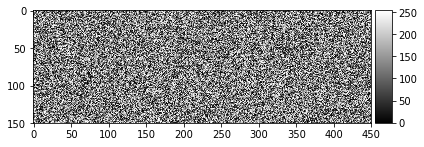

OUTPUT


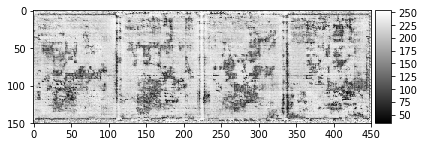

TARGET


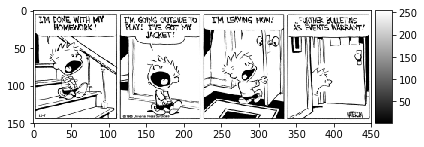

step  0 / 7367 d_loss:  0.06152541935443878 g_loss:  [42.077564, 0.4144152, 0.63604224]
step  1 / 7367 d_loss:  0.036489956080913544 g_loss:  [51.90664, 0.5125883, 0.6478065]
step  2 / 7367 d_loss:  0.03145350143313408 g_loss:  [58.677944, 0.579975, 0.6804412]
step  3 / 7367 d_loss:  0.03173547238111496 g_loss:  [63.067062, 0.62343204, 0.7238583]
step  4 / 7367 d_loss:  0.02463972009718418 g_loss:  [52.959866, 0.52182555, 0.77730834]
step  5 / 7367 d_loss:  0.01769416779279709 g_loss:  [49.819065, 0.48971945, 0.84712]
step  6 / 7367 d_loss:  0.011415788903832436 g_loss:  [51.55101, 0.5062398, 0.927034]
step  7 / 7367 d_loss:  0.010414298623800278 g_loss:  [52.433052, 0.51447326, 0.98572534]
step  8 / 7367 d_loss:  0.01043422520160675 g_loss:  [50.13065, 0.49094966, 1.0356839]
step  9 / 7367 d_loss:  0.009049707092344761 g_loss:  [53.3435, 0.5225276, 1.0907419]
step  10 / 7367 d_loss:  1.7371338605880737 g_loss:  [37.218304, 0.36255017, 0.96328825]
step  11 / 7367 d_loss:  0.01876442320

step  93 / 7367 d_loss:  0.00749439001083374 g_loss:  [53.33221, 0.5248788, 0.844331]
step  94 / 7367 d_loss:  0.0054634129628539085 g_loss:  [60.22114, 0.5936195, 0.8591869]
step  95 / 7367 d_loss:  0.003075425745919347 g_loss:  [47.44757, 0.46570054, 0.8775164]
step  96 / 7367 d_loss:  0.009535412304103374 g_loss:  [48.33675, 0.47436205, 0.90054715]
step  97 / 7367 d_loss:  0.002766185440123081 g_loss:  [47.880547, 0.46967414, 0.91313213]
step  98 / 7367 d_loss:  0.0026996887754648924 g_loss:  [45.35775, 0.44420376, 0.9373745]
step  99 / 7367 d_loss:  0.027418436482548714 g_loss:  [41.726395, 0.40799335, 0.9270603]
step  100 / 7367 d_loss:  0.006115484982728958 g_loss:  [55.167126, 0.5423891, 0.9282138]
step  101 / 7367 d_loss:  0.0028312827926129103 g_loss:  [48.062164, 0.47125104, 0.93706244]
step  102 / 7367 d_loss:  0.001532139489427209 g_loss:  [53.53406, 0.52573174, 0.9608861]
step  103 / 7367 d_loss:  0.002075445605441928 g_loss:  [57.977894, 0.57005507, 0.9723842]
step  104 /

step  185 / 7367 d_loss:  0.04668319225311279 g_loss:  [84.06834, 0.83439505, 0.628829]
step  186 / 7367 d_loss:  0.0390247143805027 g_loss:  [52.849037, 0.52133524, 0.715511]
step  187 / 7367 d_loss:  0.5271952152252197 g_loss:  [38.758972, 0.38018036, 0.7409345]
step  188 / 7367 d_loss:  0.023953549563884735 g_loss:  [52.614834, 0.5183464, 0.7801913]
step  189 / 7367 d_loss:  0.02639184519648552 g_loss:  [47.74537, 0.4693183, 0.8135391]
step  190 / 7367 d_loss:  0.014177843928337097 g_loss:  [47.80394, 0.4693893, 0.8650098]
step  191 / 7367 d_loss:  0.013277893885970116 g_loss:  [53.028362, 0.52093047, 0.9353152]
step  192 / 7367 d_loss:  0.005364696495234966 g_loss:  [51.347637, 0.503489, 0.99873704]
step  193 / 7367 d_loss:  0.0012371600605547428 g_loss:  [52.858494, 0.51783437, 1.0750569]
step  194 / 7367 d_loss:  0.15324978530406952 g_loss:  [39.382397, 0.38300228, 1.0821688]
step  195 / 7367 d_loss:  0.003252113237977028 g_loss:  [48.640774, 0.47548792, 1.0919833]
step  196 / 73

step  276 / 7367 d_loss:  0.0032351347617805004 g_loss:  [53.853165, 0.5288301, 0.970154]
step  277 / 7367 d_loss:  0.0020275029819458723 g_loss:  [55.475853, 0.5448801, 0.98784137]
step  278 / 7367 d_loss:  0.0026637734845280647 g_loss:  [51.70686, 0.507089, 0.99795794]
step  279 / 7367 d_loss:  0.0018999833846464753 g_loss:  [78.80847, 0.77805084, 1.0033865]
step  280 / 7367 d_loss:  0.0036871558986604214 g_loss:  [50.738934, 0.4971173, 1.0272027]
step  281 / 7367 d_loss:  0.00563827296718955 g_loss:  [50.58214, 0.4954927, 1.0328702]
step  282 / 7367 d_loss:  0.10985606908798218 g_loss:  [42.684948, 0.4165898, 1.0259657]
step  283 / 7367 d_loss:  0.006596451625227928 g_loss:  [59.77645, 0.5875026, 1.0261929]
step  284 / 7367 d_loss:  0.020071057602763176 g_loss:  [46.455383, 0.45430097, 1.0252864]
step  285 / 7367 d_loss:  0.0019830872770398855 g_loss:  [55.012856, 0.5398976, 1.0230949]
step  286 / 7367 d_loss:  0.0009510361705906689 g_loss:  [50.447395, 0.4943281, 1.014583]
step  28

step  367 / 7367 d_loss:  0.022288070991635323 g_loss:  [55.45143, 0.54762757, 0.68867517]
step  368 / 7367 d_loss:  0.01659267768263817 g_loss:  [51.91393, 0.5121639, 0.697542]
step  369 / 7367 d_loss:  0.014605500735342503 g_loss:  [55.287, 0.5456752, 0.7194798]
step  370 / 7367 d_loss:  0.0073300995863974094 g_loss:  [60.79784, 0.6005462, 0.7432212]
step  371 / 7367 d_loss:  0.02066650241613388 g_loss:  [44.16082, 0.43380678, 0.78014404]
step  372 / 7367 d_loss:  0.016642708331346512 g_loss:  [43.7657, 0.4295471, 0.81098956]
step  373 / 7367 d_loss:  0.009194774553179741 g_loss:  [65.63795, 0.6480031, 0.83764243]
step  374 / 7367 d_loss:  0.0003480766899883747 g_loss:  [51.009014, 0.5013421, 0.8747998]
step  375 / 7367 d_loss:  0.0011860058875754476 g_loss:  [59.37385, 0.58465624, 0.90822995]
step  376 / 7367 d_loss:  0.003986679017543793 g_loss:  [57.912304, 0.56986, 0.9263057]
step  377 / 7367 d_loss:  0.0014713458949699998 g_loss:  [54.71921, 0.5379803, 0.9211793]
step  378 / 736

step  459 / 7367 d_loss:  0.007814096286892891 g_loss:  [69.46003, 0.68662995, 0.797035]
step  460 / 7367 d_loss:  0.00605202279984951 g_loss:  [56.032486, 0.5525677, 0.7757144]
step  461 / 7367 d_loss:  0.0023532514460384846 g_loss:  [51.695843, 0.5095534, 0.74050415]
step  462 / 7367 d_loss:  0.0020527420565485954 g_loss:  [55.107136, 0.54382944, 0.72419333]
step  463 / 7367 d_loss:  0.0037075355648994446 g_loss:  [45.740845, 0.45042965, 0.6978813]
step  464 / 7367 d_loss:  0.00016485423839185387 g_loss:  [55.513012, 0.54820275, 0.69273907]
step  465 / 7367 d_loss:  0.0006352312630042434 g_loss:  [43.216667, 0.42532927, 0.68373895]
step  466 / 7367 d_loss:  0.001108920550905168 g_loss:  [52.259083, 0.51572984, 0.6861015]
step  467 / 7367 d_loss:  0.00750985462218523 g_loss:  [47.282898, 0.46582994, 0.69990665]
step  468 / 7367 d_loss:  0.016003070399165154 g_loss:  [48.900494, 0.48169363, 0.7311331]
step  469 / 7367 d_loss:  7.849755638744682e-05 g_loss:  [51.11232, 0.5035293, 0.7593

step  551 / 7367 d_loss:  0.021912477910518646 g_loss:  [42.786236, 0.42368513, 0.41772267]
step  552 / 7367 d_loss:  0.022931089624762535 g_loss:  [46.972748, 0.46563005, 0.40974504]
step  553 / 7367 d_loss:  0.01584446057677269 g_loss:  [51.52587, 0.51101977, 0.42389432]
step  554 / 7367 d_loss:  0.0202074833214283 g_loss:  [52.01053, 0.51553565, 0.45696294]
step  555 / 7367 d_loss:  0.010500945150852203 g_loss:  [53.93347, 0.5343147, 0.5020042]
step  556 / 7367 d_loss:  0.0038110511377453804 g_loss:  [58.01324, 0.574674, 0.5458402]
step  557 / 7367 d_loss:  0.0018507560016587377 g_loss:  [69.834656, 0.69226354, 0.60830086]
step  558 / 7367 d_loss:  0.016085529699921608 g_loss:  [52.51332, 0.5186104, 0.6522779]
step  559 / 7367 d_loss:  0.00931340828537941 g_loss:  [51.11526, 0.5041192, 0.703337]
step  560 / 7367 d_loss:  0.04682960361242294 g_loss:  [40.315063, 0.39584532, 0.7305307]
step  561 / 7367 d_loss:  0.0008375761099159718 g_loss:  [43.302612, 0.4252811, 0.7744999]
step  562

step  643 / 7367 d_loss:  0.004661428742110729 g_loss:  [44.957993, 0.44202378, 0.75561595]
step  644 / 7367 d_loss:  0.008014645427465439 g_loss:  [40.48541, 0.39738342, 0.74706686]
step  645 / 7367 d_loss:  0.016566969454288483 g_loss:  [52.87661, 0.52125937, 0.7506697]
step  646 / 7367 d_loss:  0.01326828170567751 g_loss:  [52.839878, 0.5207543, 0.76444894]
step  647 / 7367 d_loss:  0.008131236769258976 g_loss:  [41.855133, 0.41073588, 0.7815449]
step  648 / 7367 d_loss:  0.00989759061485529 g_loss:  [47.159683, 0.46368578, 0.79110426]
step  649 / 7367 d_loss:  0.012412957847118378 g_loss:  [43.942406, 0.43144092, 0.7983143]
step  650 / 7367 d_loss:  0.012864148244261742 g_loss:  [44.15231, 0.4334477, 0.80754215]
step  651 / 7367 d_loss:  0.01046893559396267 g_loss:  [58.63272, 0.57809615, 0.8231046]
step  652 / 7367 d_loss:  0.013085028156638145 g_loss:  [42.473373, 0.41632476, 0.84089816]
step  653 / 7367 d_loss:  0.008393332362174988 g_loss:  [49.903812, 0.49051383, 0.8524288]
st

step  734 / 7367 d_loss:  0.004071144852787256 g_loss:  [51.769184, 0.5099096, 0.7782289]
step  735 / 7367 d_loss:  0.006324216723442078 g_loss:  [47.532936, 0.46734, 0.7989364]
step  736 / 7367 d_loss:  0.003930507227778435 g_loss:  [52.900772, 0.5209051, 0.8102661]
step  737 / 7367 d_loss:  0.0009042586898431182 g_loss:  [59.198196, 0.583658, 0.83239603]
step  738 / 7367 d_loss:  0.007415800355374813 g_loss:  [42.312977, 0.41481268, 0.83170706]
step  739 / 7367 d_loss:  0.1527577042579651 g_loss:  [40.395786, 0.3959588, 0.79990244]
step  740 / 7367 d_loss:  0.0024429401382803917 g_loss:  [56.324154, 0.55523944, 0.80020887]
step  741 / 7367 d_loss:  0.0011337797623127699 g_loss:  [51.04031, 0.5023831, 0.8019966]
step  742 / 7367 d_loss:  0.003034543711692095 g_loss:  [51.603203, 0.5080636, 0.79684234]
step  743 / 7367 d_loss:  0.0018724346300587058 g_loss:  [46.357613, 0.45552242, 0.8053713]
step  744 / 7367 d_loss:  0.7632028460502625 g_loss:  [37.99933, 0.37259024, 0.740304]
step  7

step  825 / 7367 d_loss:  0.001507611246779561 g_loss:  [65.00957, 0.6413674, 0.8728345]
step  826 / 7367 d_loss:  0.011895784176886082 g_loss:  [45.873352, 0.44999403, 0.8739514]
step  827 / 7367 d_loss:  0.008170351386070251 g_loss:  [77.26463, 0.76385665, 0.8789654]
step  828 / 7367 d_loss:  0.012813346460461617 g_loss:  [50.09468, 0.49229914, 0.86476445]
step  829 / 7367 d_loss:  0.016153009608387947 g_loss:  [50.224686, 0.4935352, 0.8711664]
step  830 / 7367 d_loss:  0.016465280205011368 g_loss:  [46.76237, 0.45879495, 0.88287896]
step  831 / 7367 d_loss:  0.014654903672635555 g_loss:  [54.517487, 0.53594524, 0.9229631]
step  832 / 7367 d_loss:  0.013514033518731594 g_loss:  [51.908783, 0.50951076, 0.9577078]
step  833 / 7367 d_loss:  0.026477033272385597 g_loss:  [51.777412, 0.50773764, 1.0036454]
step  834 / 7367 d_loss:  0.009655988775193691 g_loss:  [50.44998, 0.4937883, 1.0711509]
step  835 / 7367 d_loss:  0.005278225522488356 g_loss:  [58.4668, 0.5734008, 1.1267214]
step  83

step  917 / 7367 d_loss:  0.007411766331642866 g_loss:  [52.641647, 0.51568395, 1.0732518]
step  918 / 7367 d_loss:  0.0005496781668625772 g_loss:  [44.756683, 0.43652105, 1.1045747]
step  919 / 7367 d_loss:  0.00027814650093205273 g_loss:  [50.65659, 0.4953148, 1.1251112]
step  920 / 7367 d_loss:  0.03690667077898979 g_loss:  [41.711685, 0.40572962, 1.1387198]
step  921 / 7367 d_loss:  0.0013809107476845384 g_loss:  [53.074734, 0.5192417, 1.1505669]
step  922 / 7367 d_loss:  0.005125743802636862 g_loss:  [47.094048, 0.45948976, 1.1450748]
step  923 / 7367 d_loss:  0.003355849301442504 g_loss:  [59.053535, 0.5793131, 1.1222283]
step  924 / 7367 d_loss:  0.0003504454216454178 g_loss:  [58.529217, 0.574524, 1.0768169]
step  925 / 7367 d_loss:  0.0011180145666003227 g_loss:  [59.036694, 0.58010614, 1.0260794]
step  926 / 7367 d_loss:  0.003787077497690916 g_loss:  [44.772793, 0.43797794, 0.9750001]
step  927 / 7367 d_loss:  0.003033916000276804 g_loss:  [53.37479, 0.5242216, 0.9526293]
st

step  1009 / 7367 d_loss:  0.02213520184159279 g_loss:  [44.415825, 0.43292958, 1.1228689]
step  1010 / 7367 d_loss:  0.011614950373768806 g_loss:  [52.90092, 0.5179873, 1.1021893]
step  1011 / 7367 d_loss:  0.007133695762604475 g_loss:  [41.682446, 0.4056448, 1.1179667]
step  1012 / 7367 d_loss:  0.0038524456322193146 g_loss:  [54.443478, 0.5331035, 1.1331257]
step  1013 / 7367 d_loss:  0.003490967908874154 g_loss:  [45.986362, 0.44837466, 1.1488957]
step  1014 / 7367 d_loss:  0.004654815420508385 g_loss:  [48.229893, 0.4706635, 1.1635437]
step  1015 / 7367 d_loss:  0.0007102360250428319 g_loss:  [50.831783, 0.49669987, 1.1617953]
step  1016 / 7367 d_loss:  0.002201286843046546 g_loss:  [45.071598, 0.4391698, 1.1546171]
step  1017 / 7367 d_loss:  0.0013109311694279313 g_loss:  [44.757248, 0.43617365, 1.1398833]
step  1018 / 7367 d_loss:  0.0010916988831013441 g_loss:  [42.101475, 0.40947017, 1.1544564]
step  1019 / 7367 d_loss:  0.0010586611460894346 g_loss:  [55.203297, 0.54067564, 1

step  1100 / 7367 d_loss:  0.006976334843784571 g_loss:  [52.74404, 0.5167351, 1.0705339]
step  1101 / 7367 d_loss:  0.0033346214331686497 g_loss:  [49.607502, 0.4857418, 1.03332]
step  1102 / 7367 d_loss:  0.00221867673099041 g_loss:  [50.052326, 0.49072528, 0.97979707]
step  1103 / 7367 d_loss:  0.0008423948893323541 g_loss:  [48.656193, 0.4771481, 0.9413846]
step  1104 / 7367 d_loss:  3.648080019047484e-05 g_loss:  [49.26545, 0.48358682, 0.90677]
step  1105 / 7367 d_loss:  0.0012080420274287462 g_loss:  [50.997986, 0.5012021, 0.8777783]
step  1106 / 7367 d_loss:  0.01158326305449009 g_loss:  [44.668842, 0.4380827, 0.86057216]
step  1107 / 7367 d_loss:  0.0017449080478399992 g_loss:  [50.68562, 0.49824467, 0.8611541]
step  1108 / 7367 d_loss:  0.001215847092680633 g_loss:  [41.529873, 0.40651447, 0.8784272]
step  1109 / 7367 d_loss:  0.001733490382321179 g_loss:  [46.406475, 0.45524693, 0.8817844]
step  1110 / 7367 d_loss:  0.0004963610554113984 g_loss:  [48.612335, 0.47720048, 0.892

step  1190 / 7367 d_loss:  0.0005847680731676519 g_loss:  [48.229973, 0.47196957, 1.0330175]
step  1191 / 7367 d_loss:  0.010822756215929985 g_loss:  [67.81373, 0.66787976, 1.0257498]
step  1192 / 7367 d_loss:  0.0003182607179041952 g_loss:  [64.09646, 0.6307482, 1.0216376]
step  1193 / 7367 d_loss:  0.0067908912897109985 g_loss:  [61.024975, 0.60009205, 1.0157694]
step  1194 / 7367 d_loss:  0.005564198829233646 g_loss:  [42.35003, 0.41346958, 1.003072]
step  1195 / 7367 d_loss:  0.004122327081859112 g_loss:  [41.56752, 0.40564856, 1.0026623]
step  1196 / 7367 d_loss:  0.00045677219168283045 g_loss:  [44.313908, 0.43309724, 1.0041829]
step  1197 / 7367 d_loss:  0.0006328822928480804 g_loss:  [53.951733, 0.5294731, 1.004423]
step  1198 / 7367 d_loss:  0.050345439463853836 g_loss:  [38.2188, 0.37245625, 0.97317415]
step  1199 / 7367 d_loss:  0.0007987972348928452 g_loss:  [42.26592, 0.41312906, 0.9530132]
step  1200 / 7367 d_loss:  0.001596112851984799 g_loss:  [48.97144, 0.48030373, 0.9

step  1281 / 7367 d_loss:  0.01832384616136551 g_loss:  [40.972237, 0.40024754, 0.94748366]
step  1282 / 7367 d_loss:  0.0053742569871246815 g_loss:  [49.570732, 0.4860743, 0.9633044]
step  1283 / 7367 d_loss:  0.008859247900545597 g_loss:  [69.818596, 0.6884376, 0.9748348]
step  1284 / 7367 d_loss:  0.002879742067307234 g_loss:  [46.574944, 0.45582244, 0.9927002]
step  1285 / 7367 d_loss:  0.0004912535077892244 g_loss:  [59.01448, 0.57999134, 1.0153463]
step  1286 / 7367 d_loss:  2.652778675837908e-05 g_loss:  [50.17848, 0.49169478, 1.0089995]
step  1287 / 7367 d_loss:  0.00013190646131988615 g_loss:  [53.231533, 0.5220714, 1.024391]
step  1288 / 7367 d_loss:  0.008123263716697693 g_loss:  [69.65195, 0.68629074, 1.0228754]
step  1289 / 7367 d_loss:  0.16123907268047333 g_loss:  [39.110485, 0.3814299, 0.96749574]
step  1290 / 7367 d_loss:  0.0027551252860575914 g_loss:  [51.610416, 0.5068279, 0.92762935]
step  1291 / 7367 d_loss:  0.0008457457879558206 g_loss:  [53.732162, 0.5283873, 0

step  1371 / 7367 d_loss:  0.001763527630828321 g_loss:  [53.035824, 0.52216786, 0.8190366]
step  1372 / 7367 d_loss:  0.0035864547826349735 g_loss:  [57.772247, 0.5696567, 0.8065752]
step  1373 / 7367 d_loss:  0.015381213277578354 g_loss:  [39.79732, 0.39007118, 0.79020387]
step  1374 / 7367 d_loss:  0.005997583270072937 g_loss:  [48.969994, 0.48187003, 0.782991]
step  1375 / 7367 d_loss:  0.02743438445031643 g_loss:  [40.99507, 0.40210378, 0.7846951]
step  1376 / 7367 d_loss:  0.002578397048637271 g_loss:  [49.355247, 0.48563907, 0.7913403]
step  1377 / 7367 d_loss:  0.0019988534040749073 g_loss:  [50.0232, 0.49210382, 0.8128199]
step  1378 / 7367 d_loss:  0.0020096213556826115 g_loss:  [66.279526, 0.6542837, 0.85115916]
step  1379 / 7367 d_loss:  0.0016479132464155555 g_loss:  [50.750336, 0.4985868, 0.89165634]
step  1380 / 7367 d_loss:  0.00031426138593815267 g_loss:  [52.97821, 0.52038926, 0.9392841]
step  1381 / 7367 d_loss:  0.00021306858980096877 g_loss:  [43.049942, 0.42078322

step  1461 / 7367 d_loss:  0.004937225021421909 g_loss:  [53.43218, 0.5252912, 0.9030588]
step  1462 / 7367 d_loss:  0.004610687028616667 g_loss:  [56.34459, 0.55472094, 0.8724954]
step  1463 / 7367 d_loss:  0.004478592425584793 g_loss:  [50.4486, 0.49606672, 0.8419297]
step  1464 / 7367 d_loss:  0.0004519235226325691 g_loss:  [63.276634, 0.6246398, 0.8126545]
step  1465 / 7367 d_loss:  6.360146653605625e-05 g_loss:  [51.27381, 0.50492954, 0.7808562]
step  1466 / 7367 d_loss:  0.0004468487168196589 g_loss:  [59.207714, 0.5843148, 0.77623355]
step  1467 / 7367 d_loss:  0.0006553882849402726 g_loss:  [51.058994, 0.50286144, 0.77284956]
step  1468 / 7367 d_loss:  0.0016908957622945309 g_loss:  [48.33642, 0.47555983, 0.7804354]
step  1469 / 7367 d_loss:  0.0031886026263237 g_loss:  [46.05248, 0.45252436, 0.80003965]
step  1470 / 7367 d_loss:  0.00016157036588992923 g_loss:  [56.02981, 0.55223477, 0.806335]
step  1471 / 7367 d_loss:  0.0013349083019420505 g_loss:  [52.67076, 0.5184765, 0.82

step  1552 / 7367 d_loss:  0.002190959407016635 g_loss:  [49.749504, 0.48650128, 1.0993754]
step  1553 / 7367 d_loss:  0.0030127940699458122 g_loss:  [54.46256, 0.5334165, 1.1209083]
step  1554 / 7367 d_loss:  0.0006772192427888513 g_loss:  [51.481453, 0.5035382, 1.127631]
step  1555 / 7367 d_loss:  0.0010645691072568297 g_loss:  [39.26759, 0.38123876, 1.1437157]
step  1556 / 7367 d_loss:  0.004710636101663113 g_loss:  [51.27877, 0.50123686, 1.155087]
step  1557 / 7367 d_loss:  6.033257886883803e-05 g_loss:  [48.968452, 0.4780159, 1.1668613]
step  1558 / 7367 d_loss:  0.0012703315587714314 g_loss:  [41.45822, 0.40273547, 1.184675]
step  1559 / 7367 d_loss:  0.012547478079795837 g_loss:  [40.162075, 0.38959235, 1.2028389]
step  1560 / 7367 d_loss:  0.000955982890445739 g_loss:  [49.60319, 0.48388448, 1.2147435]
step  1561 / 7367 d_loss:  0.0026059055235236883 g_loss:  [52.67432, 0.5143506, 1.2392619]
step  1562 / 7367 d_loss:  0.00466632517054677 g_loss:  [55.321808, 0.54080325, 1.24148

step  1642 / 7367 d_loss:  0.0018418199615553021 g_loss:  [48.75689, 0.47792947, 0.9639431]
step  1643 / 7367 d_loss:  0.0020211944356560707 g_loss:  [46.411503, 0.45462534, 0.9489707]
step  1644 / 7367 d_loss:  0.0038189543411135674 g_loss:  [46.747395, 0.45794213, 0.95318127]
step  1645 / 7367 d_loss:  0.0038869399577379227 g_loss:  [46.217907, 0.45263976, 0.95393103]
step  1646 / 7367 d_loss:  0.005153287202119827 g_loss:  [41.047165, 0.40084723, 0.9624395]
step  1647 / 7367 d_loss:  0.004461992532014847 g_loss:  [43.853256, 0.4288417, 0.9690838]
step  1648 / 7367 d_loss:  0.0025889098178595304 g_loss:  [54.65139, 0.5367124, 0.9801499]
step  1649 / 7367 d_loss:  0.020246367901563644 g_loss:  [40.690056, 0.39705402, 0.98465425]
step  1650 / 7367 d_loss:  0.0015150109538808465 g_loss:  [50.98235, 0.4997074, 1.0116066]
step  1651 / 7367 d_loss:  0.0016952576115727425 g_loss:  [45.229282, 0.44178414, 1.0508674]
step  1652 / 7367 d_loss:  0.02686183527112007 g_loss:  [38.774197, 0.376962

step  1733 / 7367 d_loss:  0.0014243146870285273 g_loss:  [51.677082, 0.5058693, 1.0901484]
step  1734 / 7367 d_loss:  0.0010089725255966187 g_loss:  [57.7043, 0.5662869, 1.075607]
step  1735 / 7367 d_loss:  0.00020981021225452423 g_loss:  [47.40481, 0.4636202, 1.0427943]
step  1736 / 7367 d_loss:  0.002497929148375988 g_loss:  [52.94674, 0.5192012, 1.0266182]
step  1737 / 7367 d_loss:  0.0008436365751549602 g_loss:  [51.152332, 0.50154716, 0.9976158]
step  1738 / 7367 d_loss:  0.003585625207051635 g_loss:  [43.94033, 0.42977813, 0.9625154]
step  1739 / 7367 d_loss:  0.0007657145033590496 g_loss:  [54.03932, 0.5308954, 0.9497807]
step  1740 / 7367 d_loss:  0.0007290932117030025 g_loss:  [52.865856, 0.51941353, 0.9245038]
step  1741 / 7367 d_loss:  0.0029545417055487633 g_loss:  [39.95872, 0.39039212, 0.9195111]
step  1742 / 7367 d_loss:  0.0019025685032829642 g_loss:  [53.505325, 0.5258962, 0.9157062]
step  1743 / 7367 d_loss:  0.0006820553680881858 g_loss:  [48.5184, 0.47607368, 0.911

step  1823 / 7367 d_loss:  0.0019881753250956535 g_loss:  [55.36984, 0.54399914, 0.96992457]
step  1824 / 7367 d_loss:  0.00031430486706085503 g_loss:  [51.41069, 0.5045749, 0.9532006]
step  1825 / 7367 d_loss:  0.0015865812310948968 g_loss:  [55.1122, 0.5417366, 0.9385417]
step  1826 / 7367 d_loss:  0.0001959501241799444 g_loss:  [52.749004, 0.5181433, 0.9346735]
step  1827 / 7367 d_loss:  4.925815301248804e-05 g_loss:  [45.97067, 0.45035174, 0.935494]
step  1828 / 7367 d_loss:  9.413624866283499e-06 g_loss:  [43.901333, 0.42957437, 0.943897]
step  1829 / 7367 d_loss:  0.0004265576717443764 g_loss:  [41.68677, 0.40733945, 0.9528271]
step  1830 / 7367 d_loss:  0.0009109735256060958 g_loss:  [49.578377, 0.48625815, 0.95256186]
step  1831 / 7367 d_loss:  0.0017778791952878237 g_loss:  [60.907246, 0.5995302, 0.9542218]
step  1832 / 7367 d_loss:  0.0021447346080094576 g_loss:  [47.721836, 0.467636, 0.95823705]
step  1833 / 7367 d_loss:  0.004105421714484692 g_loss:  [50.13946, 0.49195468, 

step  1913 / 7367 d_loss:  0.004780708812177181 g_loss:  [50.655987, 0.4957223, 1.0837587]
step  1914 / 7367 d_loss:  0.0006218939670361578 g_loss:  [39.674385, 0.3862586, 1.0485224]
step  1915 / 7367 d_loss:  0.17857980728149414 g_loss:  [34.048615, 0.33089098, 0.9595128]
step  1916 / 7367 d_loss:  0.0018438029801473022 g_loss:  [46.93452, 0.46059015, 0.8755018]
step  1917 / 7367 d_loss:  0.007953360676765442 g_loss:  [43.733013, 0.42915198, 0.8178132]
step  1918 / 7367 d_loss:  0.006006889510899782 g_loss:  [51.136818, 0.50345474, 0.7913444]
step  1919 / 7367 d_loss:  0.006563208065927029 g_loss:  [42.99937, 0.42209604, 0.78976387]
step  1920 / 7367 d_loss:  0.007056624162942171 g_loss:  [48.21959, 0.4743322, 0.7863698]
step  1921 / 7367 d_loss:  0.7191237211227417 g_loss:  [32.987072, 0.32281673, 0.7053976]
step  1922 / 7367 d_loss:  0.014750921167433262 g_loss:  [44.96455, 0.44291604, 0.67294514]
step  1923 / 7367 d_loss:  0.011330081149935722 g_loss:  [46.09161, 0.45428047, 0.6635

step  2004 / 7367 d_loss:  0.0018046076875180006 g_loss:  [50.40158, 0.49468774, 0.932809]
step  2005 / 7367 d_loss:  0.000858448853250593 g_loss:  [45.630463, 0.44703147, 0.9273148]
step  2006 / 7367 d_loss:  0.00040512983105145395 g_loss:  [51.69817, 0.50762546, 0.93562394]
step  2007 / 7367 d_loss:  0.00011017260112566873 g_loss:  [48.15937, 0.4722508, 0.934291]
step  2008 / 7367 d_loss:  0.0024895169772207737 g_loss:  [41.115826, 0.40173814, 0.9420122]
step  2009 / 7367 d_loss:  0.000726636266335845 g_loss:  [42.7711, 0.41820917, 0.950183]
step  2010 / 7367 d_loss:  0.006165634375065565 g_loss:  [59.86336, 0.5891125, 0.9521106]
step  2011 / 7367 d_loss:  0.0006638912600465119 g_loss:  [54.411583, 0.5348325, 0.92833644]
step  2012 / 7367 d_loss:  0.00010391310206614435 g_loss:  [38.835857, 0.3792321, 0.9126454]
step  2013 / 7367 d_loss:  0.0007038586772978306 g_loss:  [55.288597, 0.5439477, 0.8938302]
step  2014 / 7367 d_loss:  0.0008684162166900933 g_loss:  [59.708706, 0.58826154, 

step  2095 / 7367 d_loss:  0.0033173232804983854 g_loss:  [41.878536, 0.40795168, 1.0833673]
step  2096 / 7367 d_loss:  0.0025639997329562902 g_loss:  [55.174606, 0.54128796, 1.0458125]
step  2097 / 7367 d_loss:  0.00100553291849792 g_loss:  [47.904022, 0.46922657, 0.98136437]
step  2098 / 7367 d_loss:  0.0009671354782767594 g_loss:  [44.286476, 0.4334363, 0.9428438]
step  2099 / 7367 d_loss:  0.00013714707165490836 g_loss:  [45.288994, 0.44374976, 0.9140158]
step  2100 / 7367 d_loss:  0.00011745574011001736 g_loss:  [58.548153, 0.57653624, 0.8945274]
step  2101 / 7367 d_loss:  0.0005392868188209832 g_loss:  [54.915295, 0.54041344, 0.8739525]
step  2102 / 7367 d_loss:  0.0015569577226415277 g_loss:  [66.15925, 0.6531299, 0.8462611]
step  2103 / 7367 d_loss:  0.001807370106689632 g_loss:  [54.714622, 0.5388419, 0.8304336]
step  2104 / 7367 d_loss:  0.0021440587006509304 g_loss:  [47.917503, 0.47081354, 0.83614564]
step  2105 / 7367 d_loss:  0.00855020061135292 g_loss:  [61.165936, 0.603

step  2184 / 7367 d_loss:  0.004800721071660519 g_loss:  [48.84791, 0.48008844, 0.8390686]
step  2185 / 7367 d_loss:  0.004732897039502859 g_loss:  [54.52023, 0.53636867, 0.88336134]
step  2186 / 7367 d_loss:  0.0029598139226436615 g_loss:  [48.079224, 0.47133207, 0.9460137]
step  2187 / 7367 d_loss:  0.000964574865065515 g_loss:  [48.94279, 0.47930086, 1.0127058]
step  2188 / 7367 d_loss:  0.0015361078549176455 g_loss:  [38.51711, 0.37475994, 1.0411162]
step  2189 / 7367 d_loss:  0.0004206556477583945 g_loss:  [48.697086, 0.4765056, 1.0465251]
step  2190 / 7367 d_loss:  0.0015202556969597936 g_loss:  [55.34189, 0.54273224, 1.0686626]
step  2191 / 7367 d_loss:  6.912696699146181e-05 g_loss:  [49.601078, 0.48511177, 1.0898998]
step  2192 / 7367 d_loss:  0.00029204669408500195 g_loss:  [59.415504, 0.5833374, 1.0817621]
step  2193 / 7367 d_loss:  0.004061441402882338 g_loss:  [52.93011, 0.51867384, 1.0627276]
step  2194 / 7367 d_loss:  0.00639117369428277 g_loss:  [56.628338, 0.5560168, 1

step  2274 / 7367 d_loss:  0.0027758926153182983 g_loss:  [45.83294, 0.44857356, 0.9755814]
step  2275 / 7367 d_loss:  0.0027805031277239323 g_loss:  [53.061993, 0.5213264, 0.9293534]
step  2276 / 7367 d_loss:  0.0006280181696638465 g_loss:  [48.507362, 0.47619388, 0.88797504]
step  2277 / 7367 d_loss:  0.0007929970161058009 g_loss:  [47.031273, 0.46181625, 0.84964585]
step  2278 / 7367 d_loss:  2.277320709254127e-05 g_loss:  [54.68201, 0.5386559, 0.81642085]
step  2279 / 7367 d_loss:  0.000667547108605504 g_loss:  [49.146114, 0.48356488, 0.7896265]
step  2280 / 7367 d_loss:  0.0013065036619082093 g_loss:  [47.476616, 0.46696088, 0.7805287]
step  2281 / 7367 d_loss:  0.002111910842359066 g_loss:  [52.69522, 0.5193587, 0.7593498]
step  2282 / 7367 d_loss:  0.0029703781474381685 g_loss:  [46.089317, 0.45321447, 0.76787114]
step  2283 / 7367 d_loss:  0.003312187036499381 g_loss:  [52.807426, 0.5201768, 0.78974575]
step  2284 / 7367 d_loss:  0.0029032938182353973 g_loss:  [44.18048, 0.4335

step  2365 / 7367 d_loss:  0.0007976572960615158 g_loss:  [48.54239, 0.4757825, 0.9641375]
step  2366 / 7367 d_loss:  0.003391662146896124 g_loss:  [47.847874, 0.469199, 0.92797464]
step  2367 / 7367 d_loss:  0.011015179567039013 g_loss:  [45.116318, 0.4421563, 0.9006897]
step  2368 / 7367 d_loss:  0.1485898792743683 g_loss:  [38.524815, 0.37675545, 0.84926856]
step  2369 / 7367 d_loss:  0.005067335907369852 g_loss:  [51.833633, 0.5101401, 0.81962156]
step  2370 / 7367 d_loss:  0.005830688402056694 g_loss:  [61.60978, 0.6079945, 0.8103313]
step  2371 / 7367 d_loss:  0.004551442340016365 g_loss:  [56.969387, 0.561532, 0.8161842]
step  2372 / 7367 d_loss:  0.002278311410918832 g_loss:  [55.023556, 0.5417581, 0.8477447]
step  2373 / 7367 d_loss:  0.00188672193326056 g_loss:  [54.29973, 0.53425115, 0.87461597]
step  2374 / 7367 d_loss:  0.0024064346216619015 g_loss:  [49.525726, 0.48602802, 0.92292255]
step  2375 / 7367 d_loss:  0.008822470903396606 g_loss:  [46.609985, 0.45651555, 0.95842

step  2455 / 7367 d_loss:  0.0037169908173382282 g_loss:  [48.593563, 0.4794821, 0.64535105]
step  2456 / 7367 d_loss:  0.006070621311664581 g_loss:  [60.351486, 0.59702677, 0.64881253]
step  2457 / 7367 d_loss:  0.005396954249590635 g_loss:  [49.10096, 0.48423404, 0.67755675]
step  2458 / 7367 d_loss:  0.003527474356815219 g_loss:  [44.678623, 0.43965006, 0.71361774]
step  2459 / 7367 d_loss:  0.0020194235257804394 g_loss:  [50.658318, 0.49901488, 0.7568268]
step  2460 / 7367 d_loss:  0.002248866483569145 g_loss:  [58.890564, 0.5808545, 0.80511415]
step  2461 / 7367 d_loss:  0.0010361536405980587 g_loss:  [57.049225, 0.5619731, 0.8519119]
step  2462 / 7367 d_loss:  0.0030209573451429605 g_loss:  [55.041912, 0.54153955, 0.8879584]
step  2463 / 7367 d_loss:  0.005643146578222513 g_loss:  [60.443188, 0.5951244, 0.9307458]
step  2464 / 7367 d_loss:  0.008114414289593697 g_loss:  [65.29632, 0.6436586, 0.9304577]
step  2465 / 7367 d_loss:  1.1639056205749512 g_loss:  [37.9045, 0.37125424, 0

step  2545 / 7367 d_loss:  0.0011432850733399391 g_loss:  [50.232964, 0.4920022, 1.0327448]
step  2546 / 7367 d_loss:  1.3984005451202393 g_loss:  [37.679752, 0.36803073, 0.8766802]
step  2547 / 7367 d_loss:  0.0025303345173597336 g_loss:  [64.40006, 0.6362493, 0.7751325]
step  2548 / 7367 d_loss:  0.0001448756520403549 g_loss:  [47.819286, 0.47119945, 0.6993391]
step  2549 / 7367 d_loss:  0.0011528640752658248 g_loss:  [47.130493, 0.46480873, 0.64962053]
step  2550 / 7367 d_loss:  0.0052524758502841 g_loss:  [52.134804, 0.51530856, 0.60394496]
step  2551 / 7367 d_loss:  0.008354071527719498 g_loss:  [46.928547, 0.4636186, 0.5666852]
step  2552 / 7367 d_loss:  0.007715624291449785 g_loss:  [60.44195, 0.5988082, 0.5611295]
step  2553 / 7367 d_loss:  0.008571990765631199 g_loss:  [59.367313, 0.58823377, 0.54393923]
step  2554 / 7367 d_loss:  0.012800410389900208 g_loss:  [55.772213, 0.55222666, 0.54954696]
step  2555 / 7367 d_loss:  0.005597732495516539 g_loss:  [51.062214, 0.504744, 0.5

step  2636 / 7367 d_loss:  0.003147559240460396 g_loss:  [47.73619, 0.4700153, 0.7346617]
step  2637 / 7367 d_loss:  0.0032845723908394575 g_loss:  [54.053352, 0.5333829, 0.7150668]
step  2638 / 7367 d_loss:  0.0006055296398699284 g_loss:  [47.544136, 0.46837848, 0.70628864]
step  2639 / 7367 d_loss:  0.09526879340410233 g_loss:  [40.586998, 0.39905173, 0.6818253]
step  2640 / 7367 d_loss:  0.001886388286948204 g_loss:  [50.420166, 0.49751237, 0.66893154]
step  2641 / 7367 d_loss:  0.00014887868019286543 g_loss:  [43.195118, 0.42533398, 0.6617201]
step  2642 / 7367 d_loss:  0.00011615252878982574 g_loss:  [43.895546, 0.43221337, 0.6742108]
step  2643 / 7367 d_loss:  0.007171314209699631 g_loss:  [51.950726, 0.51252127, 0.698596]
step  2644 / 7367 d_loss:  0.003289965447038412 g_loss:  [55.58656, 0.54853857, 0.7327052]
step  2645 / 7367 d_loss:  0.00534068513661623 g_loss:  [55.87166, 0.5509652, 0.77513754]
step  2646 / 7367 d_loss:  0.015437843278050423 g_loss:  [55.227646, 0.54423916,

step  2727 / 7367 d_loss:  0.006350860930979252 g_loss:  [53.60282, 0.5261783, 0.98499393]
step  2728 / 7367 d_loss:  0.010880595073103905 g_loss:  [49.926468, 0.48963436, 0.9630317]
step  2729 / 7367 d_loss:  0.0077511705458164215 g_loss:  [55.240566, 0.54268605, 0.9719635]
step  2730 / 7367 d_loss:  0.014649340882897377 g_loss:  [51.00793, 0.5002856, 0.97936654]
step  2731 / 7367 d_loss:  0.0047919354401528835 g_loss:  [58.673786, 0.57682633, 0.99115396]
step  2732 / 7367 d_loss:  0.0052617681212723255 g_loss:  [58.11973, 0.5711148, 1.0082552]
step  2733 / 7367 d_loss:  0.027993977069854736 g_loss:  [47.722103, 0.46700314, 1.0217901]
step  2734 / 7367 d_loss:  0.0040040407329797745 g_loss:  [66.73158, 0.6569607, 1.0355062]
step  2735 / 7367 d_loss:  0.0025670919567346573 g_loss:  [59.49247, 0.5841895, 1.0735208]
step  2736 / 7367 d_loss:  0.030193062499165535 g_loss:  [45.91131, 0.44816837, 1.0944699]
step  2737 / 7367 d_loss:  0.0007154489867389202 g_loss:  [48.882893, 0.47768128, 1

step  2818 / 7367 d_loss:  0.004020423628389835 g_loss:  [56.49045, 0.55359954, 1.1304957]
step  2819 / 7367 d_loss:  0.012076112441718578 g_loss:  [43.501003, 0.423577, 1.1433038]
step  2820 / 7367 d_loss:  0.004616895690560341 g_loss:  [52.612938, 0.51466006, 1.1469321]
step  2821 / 7367 d_loss:  0.005731324199587107 g_loss:  [47.76391, 0.46617797, 1.1461111]
step  2822 / 7367 d_loss:  0.008908606134355068 g_loss:  [45.56157, 0.44401518, 1.1600543]
step  2823 / 7367 d_loss:  0.0034210842568427324 g_loss:  [50.50245, 0.49324363, 1.1780835]
step  2824 / 7367 d_loss:  0.002834925428032875 g_loss:  [50.730453, 0.4954353, 1.1869226]
step  2825 / 7367 d_loss:  0.004196472931653261 g_loss:  [61.06756, 0.5986966, 1.1978996]
step  2826 / 7367 d_loss:  0.042705096304416656 g_loss:  [41.242176, 0.4005592, 1.1862562]
step  2827 / 7367 d_loss:  0.04099602997303009 g_loss:  [45.502403, 0.4434551, 1.1568952]
step  2828 / 7367 d_loss:  0.00837632641196251 g_loss:  [51.834427, 0.50698256, 1.1361681]


step  2908 / 7367 d_loss:  0.003218937199562788 g_loss:  [45.961853, 0.44931847, 1.0300059]
step  2909 / 7367 d_loss:  0.0025133579038083553 g_loss:  [50.73213, 0.49734184, 0.9979433]
step  2910 / 7367 d_loss:  0.0010268506594002247 g_loss:  [50.852737, 0.49869642, 0.98309815]
step  2911 / 7367 d_loss:  0.0010012243874371052 g_loss:  [66.69737, 0.6572539, 0.9719807]
step  2912 / 7367 d_loss:  0.000616414297837764 g_loss:  [48.989086, 0.48051614, 0.93747455]
step  2913 / 7367 d_loss:  0.0006873851525597274 g_loss:  [50.703453, 0.49777523, 0.92592955]
step  2914 / 7367 d_loss:  0.0004950977745465934 g_loss:  [59.251774, 0.5832791, 0.92386615]
step  2915 / 7367 d_loss:  0.0014303746866062284 g_loss:  [76.38988, 0.75470054, 0.9198245]
step  2916 / 7367 d_loss:  2.162209987640381 g_loss:  [34.500004, 0.3369313, 0.80687165]
step  2917 / 7367 d_loss:  0.0036304572131484747 g_loss:  [48.44104, 0.4770581, 0.7352305]
step  2918 / 7367 d_loss:  0.004772656597197056 g_loss:  [55.77657, 0.5508533, 

step  2998 / 7367 d_loss:  0.0044869473204016685 g_loss:  [48.62668, 0.4754515, 1.081529]
step  2999 / 7367 d_loss:  0.004103351384401321 g_loss:  [55.936726, 0.5484368, 1.0930442]
step  3000 / 7367 d_loss:  8.018337393878028e-05 g_loss:  [50.19428, 0.49099734, 1.0945432]
step  3001 / 7367 d_loss:  0.01110956259071827 g_loss:  [49.36848, 0.4829245, 1.0760313]
step  3002 / 7367 d_loss:  7.568707223981619e-05 g_loss:  [58.42015, 0.5736985, 1.0502987]
step  3003 / 7367 d_loss:  0.0059316204860806465 g_loss:  [104.45402, 1.0342115, 1.0328676]
step  3004 / 7367 d_loss:  0.0002873025950975716 g_loss:  [55.1247, 0.5411369, 1.0110053]
step  3005 / 7367 d_loss:  0.21377404034137726 g_loss:  [41.106216, 0.4014733, 0.95888364]
step  3006 / 7367 d_loss:  0.002594479825347662 g_loss:  [49.65289, 0.4871966, 0.9332332]
step  3007 / 7367 d_loss:  0.039375729858875275 g_loss:  [42.608402, 0.41737106, 0.8712955]
step  3008 / 7367 d_loss:  0.0008194107213057578 g_loss:  [48.650066, 0.47820324, 0.8297421]

step  3088 / 7367 d_loss:  0.002309727016836405 g_loss:  [46.087315, 0.45016962, 1.0703503]
step  3089 / 7367 d_loss:  0.019621295854449272 g_loss:  [41.546684, 0.40467685, 1.0789989]
step  3090 / 7367 d_loss:  0.001974912825971842 g_loss:  [77.36924, 0.762927, 1.0765394]
step  3091 / 7367 d_loss:  0.005449878051877022 g_loss:  [48.66844, 0.4759504, 1.0734028]
step  3092 / 7367 d_loss:  0.0029401241336017847 g_loss:  [51.39462, 0.5031265, 1.0819684]
step  3093 / 7367 d_loss:  0.002195885870605707 g_loss:  [48.908897, 0.47819674, 1.0892221]
step  3094 / 7367 d_loss:  0.0019436359871178865 g_loss:  [51.753757, 0.50641936, 1.1118219]
step  3095 / 7367 d_loss:  0.0012208400294184685 g_loss:  [51.07083, 0.4997528, 1.0955492]
step  3096 / 7367 d_loss:  0.008262036368250847 g_loss:  [43.036167, 0.41977137, 1.0590298]
step  3097 / 7367 d_loss:  0.00027878934633918107 g_loss:  [45.612206, 0.4457307, 1.0391392]
step  3098 / 7367 d_loss:  0.0003978495951741934 g_loss:  [52.8625, 0.51833946, 1.028

step  3178 / 7367 d_loss:  0.0003619133494794369 g_loss:  [49.778046, 0.48658332, 1.1197144]
step  3179 / 7367 d_loss:  0.00036555013502947986 g_loss:  [50.897163, 0.49764606, 1.1325573]
step  3180 / 7367 d_loss:  0.005495366640388966 g_loss:  [57.010292, 0.55883586, 1.1267035]
step  3181 / 7367 d_loss:  0.0015525869093835354 g_loss:  [50.779694, 0.4966832, 1.1113737]
step  3182 / 7367 d_loss:  0.0019009346142411232 g_loss:  [46.060703, 0.44950688, 1.1100171]
step  3183 / 7367 d_loss:  0.0012282752431929111 g_loss:  [40.146175, 0.3904736, 1.0988163]
step  3184 / 7367 d_loss:  0.00021086173364892602 g_loss:  [50.03967, 0.4894148, 1.098188]
step  3185 / 7367 d_loss:  0.006953036412596703 g_loss:  [40.794456, 0.3969651, 1.0979475]
step  3186 / 7367 d_loss:  0.0033802809193730354 g_loss:  [65.19631, 0.6411411, 1.0822008]
step  3187 / 7367 d_loss:  0.0012358012609183788 g_loss:  [44.381264, 0.43328014, 1.0532497]
step  3188 / 7367 d_loss:  0.0008831593440845609 g_loss:  [50.94166, 0.4992194

step  3268 / 7367 d_loss:  1.3947521438240074e-05 g_loss:  [50.46844, 0.49485, 0.9834393]
step  3269 / 7367 d_loss:  9.33174742385745e-05 g_loss:  [49.587994, 0.48601285, 0.9867096]
step  3270 / 7367 d_loss:  0.002559106331318617 g_loss:  [48.33919, 0.47345996, 0.9931944]
step  3271 / 7367 d_loss:  8.948811591835693e-05 g_loss:  [43.842113, 0.42840898, 1.0012184]
step  3272 / 7367 d_loss:  0.0006280404631979764 g_loss:  [47.480522, 0.4647659, 1.0039346]
step  3273 / 7367 d_loss:  0.0003708352451212704 g_loss:  [46.42431, 0.4541488, 1.009428]
step  3274 / 7367 d_loss:  0.0005761660868301988 g_loss:  [45.764137, 0.44749555, 1.0145828]
step  3275 / 7367 d_loss:  2.588950883364305e-05 g_loss:  [50.94392, 0.49926308, 1.017614]
step  3276 / 7367 d_loss:  0.004494907800108194 g_loss:  [39.756336, 0.38737112, 1.019222]
step  3277 / 7367 d_loss:  0.0022964722011238337 g_loss:  [55.247322, 0.5422471, 1.022609]
step  3278 / 7367 d_loss:  4.196904774289578e-05 g_loss:  [51.32317, 0.50298727, 1.024

step  3359 / 7367 d_loss:  0.0017050688620656729 g_loss:  [50.81554, 0.49757302, 1.0582379]
step  3360 / 7367 d_loss:  0.002054936019703746 g_loss:  [60.843224, 0.5977179, 1.0714325]
step  3361 / 7367 d_loss:  0.0007855992298573256 g_loss:  [46.483868, 0.45409307, 1.0745605]
step  3362 / 7367 d_loss:  2.336854231543839e-05 g_loss:  [50.020695, 0.4892593, 1.094766]
step  3363 / 7367 d_loss:  0.0027628380339592695 g_loss:  [45.9899, 0.44901845, 1.0880558]
step  3364 / 7367 d_loss:  0.0017334927106276155 g_loss:  [50.50343, 0.4941996, 1.0834701]
step  3365 / 7367 d_loss:  0.0020055174827575684 g_loss:  [54.320076, 0.53240854, 1.0792218]
step  3366 / 7367 d_loss:  0.00020444035180844367 g_loss:  [52.17959, 0.5110461, 1.0749787]
step  3367 / 7367 d_loss:  0.0025447681546211243 g_loss:  [60.85352, 0.5979634, 1.0571772]
step  3368 / 7367 d_loss:  0.004180107265710831 g_loss:  [53.68263, 0.5263723, 1.0453995]
step  3369 / 7367 d_loss:  0.002372520277276635 g_loss:  [49.965458, 0.48931453, 1.03

step  3449 / 7367 d_loss:  0.0005556870019063354 g_loss:  [41.434208, 0.40416053, 1.0181524]
step  3450 / 7367 d_loss:  0.00024280145589727908 g_loss:  [50.87915, 0.49850693, 1.0284568]
step  3451 / 7367 d_loss:  0.00010249532351735979 g_loss:  [47.07137, 0.46030098, 1.04127]
step  3452 / 7367 d_loss:  0.0015514399856328964 g_loss:  [43.450535, 0.4241967, 1.030865]
step  3453 / 7367 d_loss:  0.004046166781336069 g_loss:  [63.09031, 0.62068224, 1.0220873]
step  3454 / 7367 d_loss:  0.00046156905591487885 g_loss:  [51.809887, 0.5080315, 1.0067352]
step  3455 / 7367 d_loss:  0.00040931146941147745 g_loss:  [54.562023, 0.5356872, 0.99329954]
step  3456 / 7367 d_loss:  0.0045279511250555515 g_loss:  [45.76129, 0.447737, 0.9875896]
step  3457 / 7367 d_loss:  0.0009460243745706975 g_loss:  [56.281757, 0.5529711, 0.98464763]
step  3458 / 7367 d_loss:  0.0005547031760215759 g_loss:  [48.23791, 0.4725537, 0.9825418]
step  3459 / 7367 d_loss:  0.0004757496644742787 g_loss:  [52.035915, 0.5106727,

step  3538 / 7367 d_loss:  0.005555971059948206 g_loss:  [47.86792, 0.46905643, 0.9622767]
step  3539 / 7367 d_loss:  2.105728071910562e-06 g_loss:  [53.182133, 0.52246124, 0.936008]
step  3540 / 7367 d_loss:  0.0030082494486123323 g_loss:  [43.14374, 0.42230162, 0.9135768]
step  3541 / 7367 d_loss:  0.0013440013863146305 g_loss:  [56.511658, 0.5560043, 0.9112263]
step  3542 / 7367 d_loss:  0.001613000174984336 g_loss:  [40.55619, 0.39625865, 0.93032545]
step  3543 / 7367 d_loss:  0.00034929465618915856 g_loss:  [47.39805, 0.46444944, 0.9531064]
step  3544 / 7367 d_loss:  0.0008814348257146776 g_loss:  [46.029335, 0.45056716, 0.9726186]
step  3545 / 7367 d_loss:  0.0008443663828074932 g_loss:  [59.240543, 0.58251023, 0.9895229]
step  3546 / 7367 d_loss:  2.626180685183499e-05 g_loss:  [58.58193, 0.5758747, 0.9944597]
step  3547 / 7367 d_loss:  3.8176785892574117e-05 g_loss:  [48.471382, 0.47479567, 0.99181414]
step  3548 / 7367 d_loss:  0.013424225151538849 g_loss:  [41.77689, 0.407957

step  3627 / 7367 d_loss:  0.00021465145982801914 g_loss:  [50.871944, 0.49897256, 0.974691]
step  3628 / 7367 d_loss:  0.0003991941921412945 g_loss:  [43.609165, 0.4263812, 0.9710449]
step  3629 / 7367 d_loss:  0.005478338338434696 g_loss:  [38.93554, 0.37970337, 0.965201]
step  3630 / 7367 d_loss:  0.0017957969103008509 g_loss:  [51.28583, 0.5031453, 0.97130334]
step  3631 / 7367 d_loss:  0.005064613651484251 g_loss:  [39.943924, 0.38964683, 0.97923917]
step  3632 / 7367 d_loss:  0.0005711886915378273 g_loss:  [46.335747, 0.45350954, 0.9847941]
step  3633 / 7367 d_loss:  0.00015199290646705776 g_loss:  [49.762524, 0.4876067, 1.0018524]
step  3634 / 7367 d_loss:  5.2618914196500555e-05 g_loss:  [63.033875, 0.6202898, 1.0048954]
step  3635 / 7367 d_loss:  0.0021364777348935604 g_loss:  [45.94341, 0.44935143, 1.008267]
step  3636 / 7367 d_loss:  0.00010200061660725623 g_loss:  [44.76355, 0.4376608, 0.9974678]
step  3637 / 7367 d_loss:  0.014088261872529984 g_loss:  [77.297615, 0.7630583

step  3717 / 7367 d_loss:  0.005961909424513578 g_loss:  [38.24014, 0.37286118, 0.9540214]
step  3718 / 7367 d_loss:  0.0023241692688316107 g_loss:  [39.832794, 0.38901064, 0.93173105]
step  3719 / 7367 d_loss:  0.006281577982008457 g_loss:  [53.793995, 0.5286571, 0.92828923]
step  3720 / 7367 d_loss:  0.0006803713040426373 g_loss:  [47.51007, 0.4657129, 0.9387834]
step  3721 / 7367 d_loss:  0.0020502812694758177 g_loss:  [49.01511, 0.48060644, 0.9544684]
step  3722 / 7367 d_loss:  0.0013357952702790499 g_loss:  [54.12141, 0.53163916, 0.9574932]
step  3723 / 7367 d_loss:  0.0013113591121509671 g_loss:  [54.125805, 0.53153175, 0.97262895]
step  3724 / 7367 d_loss:  0.0013824126217514277 g_loss:  [62.57931, 0.6160054, 0.97877204]
step  3725 / 7367 d_loss:  0.0015564850764349103 g_loss:  [64.58137, 0.63589436, 0.9919338]
step  3726 / 7367 d_loss:  0.002364556537941098 g_loss:  [46.8436, 0.45830736, 1.0128661]
step  3727 / 7367 d_loss:  0.0014030035817995667 g_loss:  [44.193607, 0.43144056

step  3807 / 7367 d_loss:  0.0011188816279172897 g_loss:  [53.40213, 0.5243267, 0.9694644]
step  3808 / 7367 d_loss:  0.000844205787871033 g_loss:  [59.603603, 0.58637595, 0.96600777]
step  3809 / 7367 d_loss:  0.018633631989359856 g_loss:  [36.77133, 0.35803682, 0.9676508]
step  3810 / 7367 d_loss:  0.000874168355949223 g_loss:  [50.559223, 0.49583328, 0.9758963]
step  3811 / 7367 d_loss:  0.0031815478578209877 g_loss:  [52.53355, 0.5155902, 0.97453105]
step  3812 / 7367 d_loss:  0.0026339557953178883 g_loss:  [46.74863, 0.4578437, 0.9642605]
step  3813 / 7367 d_loss:  0.002037555444985628 g_loss:  [39.820545, 0.38851723, 0.96882284]
step  3814 / 7367 d_loss:  0.005612852983176708 g_loss:  [43.442215, 0.42454135, 0.98807836]
step  3815 / 7367 d_loss:  0.000416529830545187 g_loss:  [45.46583, 0.44443387, 1.022447]
step  3816 / 7367 d_loss:  0.001231711939908564 g_loss:  [47.005806, 0.45936882, 1.0689229]
step  3817 / 7367 d_loss:  0.0003440986038185656 g_loss:  [53.997307, 0.5289866, 1

step  3896 / 7367 d_loss:  0.12539410591125488 g_loss:  [33.62982, 0.32675985, 0.9538387]
step  3897 / 7367 d_loss:  0.0005707550444640219 g_loss:  [42.10324, 0.41185242, 0.91799974]
step  3898 / 7367 d_loss:  0.0015055862022563815 g_loss:  [41.534412, 0.40633124, 0.90128577]
step  3899 / 7367 d_loss:  0.00143438542727381 g_loss:  [48.1022, 0.47210932, 0.89126825]
step  3900 / 7367 d_loss:  0.001510303234681487 g_loss:  [75.41568, 0.74523044, 0.8926391]
step  3901 / 7367 d_loss:  0.001352488761767745 g_loss:  [39.615746, 0.38716412, 0.89933574]
step  3902 / 7367 d_loss:  0.00289777759462595 g_loss:  [49.880188, 0.48968795, 0.9113921]
step  3903 / 7367 d_loss:  0.0017367551336064935 g_loss:  [45.264225, 0.44336787, 0.9274356]
step  3904 / 7367 d_loss:  0.0005977372638881207 g_loss:  [41.18514, 0.4022614, 0.95899945]
step  3905 / 7367 d_loss:  0.0028965026140213013 g_loss:  [47.958744, 0.4697241, 0.98633635]
step  3906 / 7367 d_loss:  0.00012922831228934228 g_loss:  [52.66491, 0.5165424,

step  3987 / 7367 d_loss:  0.0008277596207335591 g_loss:  [42.32427, 0.4133407, 0.9901982]
step  3988 / 7367 d_loss:  0.00079262291546911 g_loss:  [45.053406, 0.44077426, 0.9759779]
step  3989 / 7367 d_loss:  0.0010944013483822346 g_loss:  [47.281887, 0.46321654, 0.9602304]
step  3990 / 7367 d_loss:  0.002606023568660021 g_loss:  [66.42266, 0.6547124, 0.95142275]
step  3991 / 7367 d_loss:  0.0006934278062544763 g_loss:  [53.533657, 0.5260954, 0.9241182]
step  3992 / 7367 d_loss:  0.0015158948954194784 g_loss:  [61.685734, 0.60797524, 0.88821083]
step  3993 / 7367 d_loss:  0.0006023572641424835 g_loss:  [44.484123, 0.4362099, 0.86313486]
step  3994 / 7367 d_loss:  0.014177261851727962 g_loss:  [36.28609, 0.35447338, 0.83875346]
step  3995 / 7367 d_loss:  0.00656898831948638 g_loss:  [56.22681, 0.5539701, 0.82980037]
step  3996 / 7367 d_loss:  0.005406356416642666 g_loss:  [48.15602, 0.47312456, 0.84356135]
step  3997 / 7367 d_loss:  0.00855058804154396 g_loss:  [37.03766, 0.36155328, 0.

step  4077 / 7367 d_loss:  0.004841797053813934 g_loss:  [49.905457, 0.4904261, 0.8628458]
step  4078 / 7367 d_loss:  0.004004974849522114 g_loss:  [49.602917, 0.48752025, 0.850892]
step  4079 / 7367 d_loss:  0.00309497001580894 g_loss:  [52.624508, 0.5174847, 0.8760355]
step  4080 / 7367 d_loss:  0.0019050174159929156 g_loss:  [56.08463, 0.5517603, 0.9085951]
step  4081 / 7367 d_loss:  0.0026035814080387354 g_loss:  [46.560356, 0.45634854, 0.92550135]
step  4082 / 7367 d_loss:  0.0006574901635758579 g_loss:  [53.46214, 0.52507484, 0.95465374]
step  4083 / 7367 d_loss:  0.0006812347564846277 g_loss:  [41.61501, 0.40661305, 0.9537053]
step  4084 / 7367 d_loss:  0.003254914190620184 g_loss:  [48.164646, 0.47233588, 0.9310552]
step  4085 / 7367 d_loss:  0.0009030680521391332 g_loss:  [43.852585, 0.42923972, 0.9286111]
step  4086 / 7367 d_loss:  0.0002866408904083073 g_loss:  [43.3132, 0.42390534, 0.9226692]
step  4087 / 7367 d_loss:  0.004195874091237783 g_loss:  [54.719906, 0.53789794, 0

step  4168 / 7367 d_loss:  0.0008381199440918863 g_loss:  [48.028183, 0.4711383, 0.9143508]
step  4169 / 7367 d_loss:  0.00020397931803017855 g_loss:  [47.543434, 0.46643883, 0.8995501]
step  4170 / 7367 d_loss:  0.0011455584317445755 g_loss:  [45.298668, 0.44408515, 0.8901535]
step  4171 / 7367 d_loss:  0.007018739357590675 g_loss:  [45.89204, 0.4501784, 0.8742006]
step  4172 / 7367 d_loss:  0.005644898395985365 g_loss:  [53.601543, 0.52750367, 0.8511763]
step  4173 / 7367 d_loss:  0.000559546984732151 g_loss:  [55.885696, 0.5505032, 0.83537644]
step  4174 / 7367 d_loss:  0.005420710891485214 g_loss:  [46.516125, 0.457031, 0.8130209]
step  4175 / 7367 d_loss:  0.00014407110575120896 g_loss:  [65.64673, 0.64842683, 0.8040497]
step  4176 / 7367 d_loss:  0.00027928006602451205 g_loss:  [50.494934, 0.4971569, 0.7792416]
step  4177 / 7367 d_loss:  0.00035023625241592526 g_loss:  [51.34415, 0.5057735, 0.766805]
step  4178 / 7367 d_loss:  0.0011895232601091266 g_loss:  [47.115124, 0.4635457,

step  4258 / 7367 d_loss:  0.00042537422268651426 g_loss:  [62.65661, 0.6176095, 0.89565927]
step  4259 / 7367 d_loss:  0.040231190621852875 g_loss:  [46.548573, 0.45665562, 0.883011]
step  4260 / 7367 d_loss:  0.004309495911002159 g_loss:  [70.71715, 0.69834006, 0.8831429]
step  4261 / 7367 d_loss:  0.0013736062683165073 g_loss:  [51.258423, 0.5041275, 0.8456727]
step  4262 / 7367 d_loss:  0.005773437209427357 g_loss:  [62.04078, 0.6122454, 0.81624305]
step  4263 / 7367 d_loss:  0.008240011520683765 g_loss:  [54.009968, 0.5320565, 0.80431736]
step  4264 / 7367 d_loss:  0.006152764428406954 g_loss:  [52.584827, 0.5173305, 0.85177505]
step  4265 / 7367 d_loss:  0.0021938139107078314 g_loss:  [54.42744, 0.53509355, 0.918088]
step  4266 / 7367 d_loss:  0.0008507554302923381 g_loss:  [61.710342, 0.6074747, 0.9628773]
step  4267 / 7367 d_loss:  0.0011737042805179954 g_loss:  [56.416534, 0.5546154, 0.9549987]
step  4268 / 7367 d_loss:  0.0005375781329348683 g_loss:  [52.67636, 0.51769716, 0.

step  4349 / 7367 d_loss:  0.010590310208499432 g_loss:  [53.030064, 0.52328616, 0.7014477]
step  4350 / 7367 d_loss:  0.027241574600338936 g_loss:  [55.17005, 0.54467916, 0.7021324]
step  4351 / 7367 d_loss:  0.028194287791848183 g_loss:  [51.24155, 0.505364, 0.7051504]
step  4352 / 7367 d_loss:  0.028509927913546562 g_loss:  [55.75105, 0.55069274, 0.68177384]
step  4353 / 7367 d_loss:  0.04121699929237366 g_loss:  [61.094322, 0.6042509, 0.6692301]
step  4354 / 7367 d_loss:  0.0499078668653965 g_loss:  [41.673405, 0.4103948, 0.6339271]
step  4355 / 7367 d_loss:  0.01807725988328457 g_loss:  [47.027267, 0.46432316, 0.59494996]
step  4356 / 7367 d_loss:  0.012519878335297108 g_loss:  [48.956547, 0.48395807, 0.56074095]
step  4357 / 7367 d_loss:  0.005034965462982655 g_loss:  [43.542015, 0.43023032, 0.5189818]
step  4358 / 7367 d_loss:  0.010609064251184464 g_loss:  [46.911903, 0.46415678, 0.49622613]
step  4359 / 7367 d_loss:  0.006498876493424177 g_loss:  [63.410942, 0.6293027, 0.48067

step  4439 / 7367 d_loss:  0.009483815170824528 g_loss:  [51.30137, 0.50606704, 0.6946643]
step  4440 / 7367 d_loss:  0.00590770598500967 g_loss:  [57.150898, 0.5648049, 0.6704057]
step  4441 / 7367 d_loss:  0.0019168239086866379 g_loss:  [55.153862, 0.54504895, 0.6489686]
step  4442 / 7367 d_loss:  0.0019812402315437794 g_loss:  [55.543777, 0.5490199, 0.6417901]
step  4443 / 7367 d_loss:  0.0013854774879291654 g_loss:  [46.953827, 0.46321812, 0.6320142]
step  4444 / 7367 d_loss:  0.00499042309820652 g_loss:  [41.75441, 0.41108137, 0.6462696]
step  4445 / 7367 d_loss:  0.0043409597128629684 g_loss:  [51.331738, 0.5064957, 0.68216884]
step  4446 / 7367 d_loss:  0.008862359449267387 g_loss:  [52.095234, 0.51372534, 0.72269714]
step  4447 / 7367 d_loss:  0.020257821306586266 g_loss:  [53.493835, 0.5275301, 0.7408282]
step  4448 / 7367 d_loss:  0.005666052922606468 g_loss:  [49.467613, 0.48719397, 0.74821514]
step  4449 / 7367 d_loss:  0.022469181567430496 g_loss:  [50.648544, 0.4988029, 0

step  4529 / 7367 d_loss:  0.011609005741775036 g_loss:  [46.101856, 0.4528015, 0.82170504]
step  4530 / 7367 d_loss:  0.008139250800013542 g_loss:  [47.89232, 0.47080627, 0.8116906]
step  4531 / 7367 d_loss:  0.014955049380660057 g_loss:  [63.88134, 0.63053596, 0.8277432]
step  4532 / 7367 d_loss:  0.01307697594165802 g_loss:  [53.36317, 0.52496016, 0.8671517]
step  4533 / 7367 d_loss:  0.2859305739402771 g_loss:  [40.375053, 0.3950622, 0.8688328]
step  4534 / 7367 d_loss:  0.014838820323348045 g_loss:  [50.38736, 0.49494693, 0.8926666]
step  4535 / 7367 d_loss:  0.011129084974527359 g_loss:  [46.98011, 0.4606248, 0.91762924]
step  4536 / 7367 d_loss:  0.0069810254499316216 g_loss:  [57.02522, 0.56106204, 0.919013]
step  4537 / 7367 d_loss:  0.006433433853089809 g_loss:  [59.61718, 0.5870488, 0.91229784]
step  4538 / 7367 d_loss:  0.0067563788034021854 g_loss:  [52.7715, 0.5189281, 0.87868875]
step  4539 / 7367 d_loss:  0.0019950284622609615 g_loss:  [57.797012, 0.56914407, 0.8826081]

step  4619 / 7367 d_loss:  0.0169542096555233 g_loss:  [55.749966, 0.54490024, 1.2599413]
step  4620 / 7367 d_loss:  0.00433860020712018 g_loss:  [52.5874, 0.51256925, 1.3304764]
step  4621 / 7367 d_loss:  0.005178903229534626 g_loss:  [79.694725, 0.78303885, 1.3908403]
step  4622 / 7367 d_loss:  0.004129530396312475 g_loss:  [53.596447, 0.52235496, 1.3609511]
step  4623 / 7367 d_loss:  0.1586979180574417 g_loss:  [42.898613, 0.41618156, 1.2804585]
step  4624 / 7367 d_loss:  0.00834529660642147 g_loss:  [62.845917, 0.61645085, 1.2008313]
step  4625 / 7367 d_loss:  0.016838055104017258 g_loss:  [53.48688, 0.5236647, 1.1204102]
step  4626 / 7367 d_loss:  0.018869489431381226 g_loss:  [56.11314, 0.5506672, 1.046419]
step  4627 / 7367 d_loss:  0.029249904677271843 g_loss:  [51.695335, 0.5070582, 0.9895141]
step  4628 / 7367 d_loss:  0.0133944321423769 g_loss:  [56.529034, 0.55601054, 0.92797905]
step  4629 / 7367 d_loss:  0.011925776489078999 g_loss:  [53.22142, 0.5234514, 0.87628335]
step

step  4710 / 7367 d_loss:  0.0013121641241014004 g_loss:  [64.98491, 0.64289606, 0.6953038]
step  4711 / 7367 d_loss:  0.0028128838166594505 g_loss:  [49.414043, 0.48727986, 0.6860562]
step  4712 / 7367 d_loss:  0.008634108118712902 g_loss:  [55.908382, 0.5521837, 0.69001293]
step  4713 / 7367 d_loss:  0.010890406556427479 g_loss:  [55.45007, 0.54769176, 0.680892]
step  4714 / 7367 d_loss:  0.017042450606822968 g_loss:  [49.095486, 0.48411673, 0.68380994]
step  4715 / 7367 d_loss:  0.01968885213136673 g_loss:  [45.82439, 0.45119566, 0.7048246]
step  4716 / 7367 d_loss:  0.0388919934630394 g_loss:  [43.46512, 0.42744392, 0.7207252]
step  4717 / 7367 d_loss:  0.007397251669317484 g_loss:  [47.30498, 0.46536782, 0.7682002]
step  4718 / 7367 d_loss:  1.1395279169082642 g_loss:  [37.155655, 0.36396438, 0.7592159]
step  4719 / 7367 d_loss:  0.0016385818598791957 g_loss:  [51.691757, 0.5089036, 0.80139565]
step  4720 / 7367 d_loss:  0.0031351379584521055 g_loss:  [52.2026, 0.5135026, 0.852341

step  4801 / 7367 d_loss:  0.024529894813895226 g_loss:  [41.743763, 0.41033044, 0.7107195]
step  4802 / 7367 d_loss:  0.005356255453079939 g_loss:  [57.047367, 0.5631003, 0.73734057]
step  4803 / 7367 d_loss:  0.0023045470006763935 g_loss:  [57.108753, 0.56359226, 0.74952525]
step  4804 / 7367 d_loss:  0.007221907377243042 g_loss:  [45.850964, 0.45097727, 0.7532405]
step  4805 / 7367 d_loss:  0.0027725701220333576 g_loss:  [57.86778, 0.57110524, 0.75725526]
step  4806 / 7367 d_loss:  0.008608385920524597 g_loss:  [49.88954, 0.49162194, 0.72735]
step  4807 / 7367 d_loss:  0.0016990025760605931 g_loss:  [58.372986, 0.57679814, 0.69317275]
step  4808 / 7367 d_loss:  0.001412239158526063 g_loss:  [42.05523, 0.41376296, 0.6789326]
step  4809 / 7367 d_loss:  0.0035132167395204306 g_loss:  [49.222126, 0.48555133, 0.6669929]
step  4810 / 7367 d_loss:  0.005870443768799305 g_loss:  [59.2743, 0.5860556, 0.6687429]
step  4811 / 7367 d_loss:  0.011587117798626423 g_loss:  [49.003128, 0.48326683, 

step  4892 / 7367 d_loss:  0.006097172386944294 g_loss:  [50.21998, 0.49278796, 0.94118255]
step  4893 / 7367 d_loss:  0.004141068086028099 g_loss:  [46.25477, 0.45308653, 0.9461155]
step  4894 / 7367 d_loss:  0.003903235774487257 g_loss:  [76.471115, 0.7551815, 0.95296615]
step  4895 / 7367 d_loss:  0.006837966851890087 g_loss:  [56.56489, 0.55631065, 0.933826]
step  4896 / 7367 d_loss:  0.003458733670413494 g_loss:  [55.930477, 0.5499597, 0.9345063]
step  4897 / 7367 d_loss:  0.001535741612315178 g_loss:  [52.91109, 0.519567, 0.9543871]
step  4898 / 7367 d_loss:  0.005247054155915976 g_loss:  [50.797234, 0.49825728, 0.9715033]
step  4899 / 7367 d_loss:  0.00035547208972275257 g_loss:  [48.689342, 0.47712374, 0.97697103]
step  4900 / 7367 d_loss:  0.04472031816840172 g_loss:  [42.11834, 0.41145033, 0.9733079]
step  4901 / 7367 d_loss:  4.81236565974541e-05 g_loss:  [75.75015, 0.74774987, 0.9751665]
step  4902 / 7367 d_loss:  0.002135354559868574 g_loss:  [61.587418, 0.6062673, 0.96068

step  4982 / 7367 d_loss:  0.0035777688026428223 g_loss:  [54.793247, 0.53918374, 0.8748737]
step  4983 / 7367 d_loss:  0.0004743296594824642 g_loss:  [48.209053, 0.4735268, 0.85637325]
step  4984 / 7367 d_loss:  0.004001323599368334 g_loss:  [48.030277, 0.471556, 0.87467545]
step  4985 / 7367 d_loss:  0.004627450369298458 g_loss:  [42.191196, 0.41321903, 0.8692928]
step  4986 / 7367 d_loss:  0.000814530998468399 g_loss:  [52.719067, 0.51831067, 0.88800204]
step  4987 / 7367 d_loss:  0.0008554613450542092 g_loss:  [48.38287, 0.4748334, 0.8995267]
step  4988 / 7367 d_loss:  0.0005204520421102643 g_loss:  [57.362865, 0.56439686, 0.92317843]
step  4989 / 7367 d_loss:  0.006657097488641739 g_loss:  [51.388275, 0.50464934, 0.9233389]
step  4990 / 7367 d_loss:  0.000778869551140815 g_loss:  [49.37073, 0.48440683, 0.93004954]
step  4991 / 7367 d_loss:  0.0008992406073957682 g_loss:  [49.51219, 0.48569572, 0.94262123]
step  4992 / 7367 d_loss:  0.0006366746383719146 g_loss:  [58.348362, 0.5737

step  5073 / 7367 d_loss:  0.0081509780138731 g_loss:  [46.50823, 0.45745394, 0.7628349]
step  5074 / 7367 d_loss:  0.004854928236454725 g_loss:  [55.440113, 0.5463257, 0.8075432]
step  5075 / 7367 d_loss:  0.005906401667743921 g_loss:  [54.746437, 0.5390699, 0.83944863]
step  5076 / 7367 d_loss:  0.010594012215733528 g_loss:  [49.571266, 0.48708224, 0.8630408]
step  5077 / 7367 d_loss:  0.006353639531880617 g_loss:  [50.543102, 0.49664432, 0.87866825]
step  5078 / 7367 d_loss:  0.0058149853721261024 g_loss:  [48.126965, 0.47218797, 0.9081698]
step  5079 / 7367 d_loss:  0.008050372824072838 g_loss:  [42.79122, 0.41861007, 0.93021476]
step  5080 / 7367 d_loss:  0.006825905293226242 g_loss:  [44.658066, 0.43694767, 0.9632987]
step  5081 / 7367 d_loss:  0.005892642308026552 g_loss:  [52.885677, 0.5189655, 0.9891285]
step  5082 / 7367 d_loss:  0.004079167731106281 g_loss:  [57.45288, 0.5645133, 1.0015496]
step  5083 / 7367 d_loss:  0.0045314971357584 g_loss:  [53.264282, 0.52250165, 1.0141

step  5164 / 7367 d_loss:  0.0531131848692894 g_loss:  [39.366528, 0.3853769, 0.8288369]
step  5165 / 7367 d_loss:  0.0014902753755450249 g_loss:  [57.56744, 0.5673605, 0.83138496]
step  5166 / 7367 d_loss:  0.001541757257655263 g_loss:  [56.50252, 0.55655, 0.8475177]
step  5167 / 7367 d_loss:  0.0030863541178405285 g_loss:  [46.009106, 0.4516441, 0.8446969]
step  5168 / 7367 d_loss:  0.002055986551567912 g_loss:  [47.297062, 0.46439567, 0.85749596]
step  5169 / 7367 d_loss:  0.0019951758440583944 g_loss:  [59.511982, 0.5865, 0.8619837]
step  5170 / 7367 d_loss:  0.0031075477600097656 g_loss:  [64.52078, 0.6364458, 0.87620354]
step  5171 / 7367 d_loss:  0.003226681612432003 g_loss:  [50.95279, 0.50081307, 0.87148213]
step  5172 / 7367 d_loss:  0.05573830008506775 g_loss:  [36.88057, 0.36027548, 0.85302424]
step  5173 / 7367 d_loss:  0.009306371212005615 g_loss:  [44.54304, 0.43710393, 0.83265096]
step  5174 / 7367 d_loss:  0.012410924769937992 g_loss:  [55.673504, 0.5486706, 0.80644745

step  5254 / 7367 d_loss:  0.0047790417447686195 g_loss:  [53.6103, 0.52579856, 1.0304428]
step  5255 / 7367 d_loss:  0.005468815099447966 g_loss:  [47.79929, 0.4672444, 1.0748525]
step  5256 / 7367 d_loss:  0.001473182113841176 g_loss:  [49.713238, 0.48597044, 1.1161954]
step  5257 / 7367 d_loss:  0.002107243984937668 g_loss:  [55.60582, 0.5446421, 1.1416091]
step  5258 / 7367 d_loss:  0.0056031737476587296 g_loss:  [51.836613, 0.5067307, 1.1635447]
step  5259 / 7367 d_loss:  0.00013571095769293606 g_loss:  [49.8608, 0.48678517, 1.1822839]
step  5260 / 7367 d_loss:  1.4364204616867937e-05 g_loss:  [52.601475, 0.51429987, 1.1714885]
step  5261 / 7367 d_loss:  0.00016890227561816573 g_loss:  [49.6377, 0.484875, 1.1501989]
step  5262 / 7367 d_loss:  0.005424943286925554 g_loss:  [52.428474, 0.51292306, 1.1361701]
step  5263 / 7367 d_loss:  0.00206633098423481 g_loss:  [56.930138, 0.55818635, 1.1115036]
step  5264 / 7367 d_loss:  0.009422549046576023 g_loss:  [58.799427, 0.5771093, 1.0885

step  5345 / 7367 d_loss:  0.0006955140852369368 g_loss:  [52.305347, 0.51271075, 1.0342708]
step  5346 / 7367 d_loss:  0.0011481049004942179 g_loss:  [42.20025, 0.4120611, 0.9941417]
step  5347 / 7367 d_loss:  0.0005026907892897725 g_loss:  [50.846504, 0.49884376, 0.96212715]
step  5348 / 7367 d_loss:  0.0031047677621245384 g_loss:  [49.893673, 0.48965955, 0.9277188]
step  5349 / 7367 d_loss:  0.013828122988343239 g_loss:  [47.19104, 0.46283433, 0.9076093]
step  5350 / 7367 d_loss:  0.0015239677159115672 g_loss:  [51.333706, 0.50435525, 0.8981813]
step  5351 / 7367 d_loss:  0.0019155127229169011 g_loss:  [49.125565, 0.48246938, 0.8786279]
step  5352 / 7367 d_loss:  0.008006740361452103 g_loss:  [57.814964, 0.5694069, 0.8742695]
step  5353 / 7367 d_loss:  0.0015121514443308115 g_loss:  [51.452393, 0.505787, 0.8736912]
step  5354 / 7367 d_loss:  0.0019406776409596205 g_loss:  [46.838165, 0.45968965, 0.86920244]
step  5355 / 7367 d_loss:  0.0012810634216293693 g_loss:  [46.903027, 0.4602

step  5436 / 7367 d_loss:  0.0008091232157312334 g_loss:  [53.72626, 0.52602035, 1.1242267]
step  5437 / 7367 d_loss:  0.0009505354100838304 g_loss:  [57.007637, 0.5586119, 1.1464415]
step  5438 / 7367 d_loss:  0.00271037919446826 g_loss:  [49.090813, 0.4792054, 1.1702714]
step  5439 / 7367 d_loss:  0.0015840984415262938 g_loss:  [47.54986, 0.463799, 1.1699616]
step  5440 / 7367 d_loss:  0.0027297334745526314 g_loss:  [46.73866, 0.45566037, 1.1726245]
step  5441 / 7367 d_loss:  0.015471961349248886 g_loss:  [41.635124, 0.4045942, 1.1757025]
step  5442 / 7367 d_loss:  0.003278672229498625 g_loss:  [63.331577, 0.6216552, 1.1660535]
step  5443 / 7367 d_loss:  0.0008524548611603677 g_loss:  [47.599884, 0.46465757, 1.1341256]
step  5444 / 7367 d_loss:  0.0001662479480728507 g_loss:  [49.62305, 0.48527268, 1.0957848]
step  5445 / 7367 d_loss:  0.0002803427632898092 g_loss:  [48.68169, 0.47615093, 1.0665972]
step  5446 / 7367 d_loss:  0.0247478224337101 g_loss:  [41.515297, 0.40489143, 1.0261

step  5526 / 7367 d_loss:  0.003371146507561207 g_loss:  [52.593906, 0.5168797, 0.9059382]
step  5527 / 7367 d_loss:  0.004370272159576416 g_loss:  [41.94696, 0.41002876, 0.94408494]
step  5528 / 7367 d_loss:  0.0017113175708800554 g_loss:  [54.761066, 0.5378584, 0.975223]
step  5529 / 7367 d_loss:  0.011392867192626 g_loss:  [40.840363, 0.39846998, 0.99336153]
step  5530 / 7367 d_loss:  0.0001283543388126418 g_loss:  [52.24577, 0.5122001, 1.0257566]
step  5531 / 7367 d_loss:  0.0018590334802865982 g_loss:  [50.810062, 0.49746463, 1.0635976]
step  5532 / 7367 d_loss:  0.003232132876291871 g_loss:  [55.497726, 0.54397184, 1.1005456]
step  5533 / 7367 d_loss:  0.002166337799280882 g_loss:  [48.70209, 0.47653294, 1.0487965]
step  5534 / 7367 d_loss:  0.0005872769979760051 g_loss:  [54.086555, 0.53091246, 0.99530655]
step  5535 / 7367 d_loss:  0.00351120182313025 g_loss:  [50.871605, 0.49897164, 0.9744402]
step  5536 / 7367 d_loss:  0.0035429380368441343 g_loss:  [52.186543, 0.5121563, 0.9

step  5616 / 7367 d_loss:  0.00024427095195278525 g_loss:  [50.746655, 0.49924728, 0.82192594]
step  5617 / 7367 d_loss:  0.0010484043741598725 g_loss:  [57.618526, 0.5683744, 0.7810857]
step  5618 / 7367 d_loss:  0.004933062940835953 g_loss:  [40.5266, 0.3979759, 0.7290132]
step  5619 / 7367 d_loss:  0.0015722017269581556 g_loss:  [50.64936, 0.4993244, 0.71691966]
step  5620 / 7367 d_loss:  0.0018717799102887511 g_loss:  [46.27225, 0.45544723, 0.7275266]
step  5621 / 7367 d_loss:  0.0001811873516999185 g_loss:  [60.996902, 0.60262173, 0.73472923]
step  5622 / 7367 d_loss:  0.0016792678507044911 g_loss:  [57.184258, 0.56440854, 0.7434047]
step  5623 / 7367 d_loss:  0.00026018539210781455 g_loss:  [54.6133, 0.53864014, 0.749285]
step  5624 / 7367 d_loss:  0.006587108131498098 g_loss:  [51.083485, 0.5031175, 0.7717352]
step  5625 / 7367 d_loss:  0.0032835695892572403 g_loss:  [52.533646, 0.51738864, 0.79477966]
step  5626 / 7367 d_loss:  0.0046248845756053925 g_loss:  [45.179443, 0.44377

step  5707 / 7367 d_loss:  0.002275019185617566 g_loss:  [50.31789, 0.49285445, 1.0324455]
step  5708 / 7367 d_loss:  0.005811312701553106 g_loss:  [57.91103, 0.5685265, 1.0583785]
step  5709 / 7367 d_loss:  0.002772877924144268 g_loss:  [52.751163, 0.5167849, 1.0726744]
step  5710 / 7367 d_loss:  0.003370885504409671 g_loss:  [47.895412, 0.46832356, 1.0630584]
step  5711 / 7367 d_loss:  0.01578567363321781 g_loss:  [48.327324, 0.4732593, 1.0013919]
step  5712 / 7367 d_loss:  0.21062545478343964 g_loss:  [44.22046, 0.43311134, 0.9093249]
step  5713 / 7367 d_loss:  0.021341703832149506 g_loss:  [51.521534, 0.50644547, 0.87698686]
step  5714 / 7367 d_loss:  0.02484804205596447 g_loss:  [52.951355, 0.5207223, 0.87912554]
step  5715 / 7367 d_loss:  0.016065040603280067 g_loss:  [49.684967, 0.48762673, 0.92229575]
step  5716 / 7367 d_loss:  0.020030461251735687 g_loss:  [46.093178, 0.4510729, 0.9858913]
step  5717 / 7367 d_loss:  0.004872695542871952 g_loss:  [50.845673, 0.49779975, 1.06569

step  5798 / 7367 d_loss:  0.012626316398382187 g_loss:  [66.85877, 0.6635476, 0.5040153]
step  5799 / 7367 d_loss:  0.014883209019899368 g_loss:  [46.099438, 0.45566761, 0.5326781]
step  5800 / 7367 d_loss:  0.024886665865778923 g_loss:  [41.49449, 0.40932685, 0.5618052]
step  5801 / 7367 d_loss:  0.007309732027351856 g_loss:  [52.721794, 0.52123183, 0.5986099]
step  5802 / 7367 d_loss:  0.01198868453502655 g_loss:  [43.908104, 0.43266362, 0.6417443]
step  5803 / 7367 d_loss:  0.07142006605863571 g_loss:  [41.965324, 0.4129711, 0.6682121]
step  5804 / 7367 d_loss:  0.005744568537920713 g_loss:  [43.813484, 0.43108055, 0.7054281]
step  5805 / 7367 d_loss:  0.022120025008916855 g_loss:  [43.018044, 0.42260376, 0.75766873]
step  5806 / 7367 d_loss:  0.0013590366579592228 g_loss:  [57.077023, 0.56259257, 0.817765]
step  5807 / 7367 d_loss:  0.0030767503194510937 g_loss:  [49.057056, 0.48196453, 0.86060494]
step  5808 / 7367 d_loss:  0.004040596075356007 g_loss:  [57.0119, 0.5613872, 0.873

step  5888 / 7367 d_loss:  0.023968083783984184 g_loss:  [49.02265, 0.48313725, 0.7089267]
step  5889 / 7367 d_loss:  0.015101075172424316 g_loss:  [57.482742, 0.5666616, 0.81658137]
step  5890 / 7367 d_loss:  0.004258899483829737 g_loss:  [52.47323, 0.515428, 0.93042886]
step  5891 / 7367 d_loss:  0.004556600004434586 g_loss:  [43.655624, 0.42633653, 1.0219743]
step  5892 / 7367 d_loss:  0.0021192673593759537 g_loss:  [57.120907, 0.5602654, 1.0943642]
step  5893 / 7367 d_loss:  0.0028827933128923178 g_loss:  [63.15421, 0.619948, 1.1594038]
step  5894 / 7367 d_loss:  0.0009891235968098044 g_loss:  [50.21153, 0.49008426, 1.203102]
step  5895 / 7367 d_loss:  0.0030650384724140167 g_loss:  [51.678463, 0.5045871, 1.2197523]
step  5896 / 7367 d_loss:  0.0013491781428456306 g_loss:  [73.357864, 0.7212221, 1.2356544]
step  5897 / 7367 d_loss:  0.005040545016527176 g_loss:  [51.164574, 0.49931112, 1.2334639]
step  5898 / 7367 d_loss:  0.00601569889113307 g_loss:  [48.18457, 0.46963984, 1.22058

step  5979 / 7367 d_loss:  0.010454544797539711 g_loss:  [46.52329, 0.45408174, 1.115115]
step  5980 / 7367 d_loss:  0.0043341671116650105 g_loss:  [49.479145, 0.48329732, 1.1494123]
step  5981 / 7367 d_loss:  0.013942155987024307 g_loss:  [48.315685, 0.4716685, 1.1488358]
step  5982 / 7367 d_loss:  0.008871490135788918 g_loss:  [55.225204, 0.54103667, 1.1215351]
step  5983 / 7367 d_loss:  0.005319572053849697 g_loss:  [45.77449, 0.4466217, 1.1123184]
step  5984 / 7367 d_loss:  0.006137708202004433 g_loss:  [57.969826, 0.56871396, 1.0984309]
step  5985 / 7367 d_loss:  0.012574153952300549 g_loss:  [54.349663, 0.532563, 1.0933642]
step  5986 / 7367 d_loss:  0.006512029096484184 g_loss:  [53.02746, 0.5196335, 1.0641096]
step  5987 / 7367 d_loss:  0.001835784874856472 g_loss:  [56.35898, 0.55314076, 1.0449018]
step  5988 / 7367 d_loss:  0.0059826369397342205 g_loss:  [44.493893, 0.43478137, 1.0157533]
step  5989 / 7367 d_loss:  6.6825427893491e-06 g_loss:  [60.892776, 0.5989518, 0.9975986

step  6069 / 7367 d_loss:  0.050132811069488525 g_loss:  [44.998978, 0.44135624, 0.86335236]
step  6070 / 7367 d_loss:  0.04054688662290573 g_loss:  [45.252087, 0.44336087, 0.9160009]
step  6071 / 7367 d_loss:  0.019529076293110847 g_loss:  [68.302605, 0.673303, 0.97230756]
step  6072 / 7367 d_loss:  0.015276708640158176 g_loss:  [51.289593, 0.50270045, 1.019545]
step  6073 / 7367 d_loss:  0.010804629884660244 g_loss:  [66.53269, 0.6543851, 1.0941868]
step  6074 / 7367 d_loss:  0.008279436267912388 g_loss:  [55.529385, 0.5435185, 1.1775371]
step  6075 / 7367 d_loss:  0.013432501815259457 g_loss:  [57.80341, 0.5653639, 1.2670196]
step  6076 / 7367 d_loss:  0.00852928962558508 g_loss:  [46.945015, 0.45608163, 1.3368537]
step  6077 / 7367 d_loss:  0.000531438214238733 g_loss:  [50.506752, 0.49106917, 1.3998356]
step  6078 / 7367 d_loss:  0.027779702097177505 g_loss:  [45.533104, 0.44102448, 1.4306583]
step  6079 / 7367 d_loss:  0.012158337980508804 g_loss:  [49.959827, 0.48548785, 1.41104

KeyboardInterrupt: 

In [58]:
test_gan(g_input, g_output, d_input, d_output, first_category_only=True)

more layrs?


### Parameterized Generation

#### Concatenating a one-hot vector

In [53]:
# NOTE: this only works under the assumption that the input image dimension is larger in pixels than the number of categories
# TODO: this just replaces the first strip rn, but I'm not fixing it rn cause that would require messing with the shape
def concat_with_one_hot(img, latent_category):
    one_hot_vector = np.zeros(img.shape[1])
    one_hot_vector[latent_category] = 1
    img[0] = one_hot_vector # TODO: should it matter which is first or along which dimension?  investigate
    return img
    

In [54]:
g_input = Input(shape=(150, 450, 1))
layer = Conv2DTranspose(8, 4, strides=1, padding='same')(g_input)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
for _ in range(10):
    layer = Conv2DTranspose(8, 4, strides=1, padding='same')(layer)
    layer = BatchNormalization(momentum=.9)(layer)
    layer = PReLU()(layer)
layer = Conv2DTranspose(1, 4, strides=1, padding='same')(layer)
g_output = Activation('sigmoid')(layer)

In [55]:
test_gan(g_input, g_output, d_input, d_output, first_category_only=True, input_method=concat_with_one_hot)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 150, 450, 1)       0         
_________________________________________________________________
generator (Model)            (None, 150, 450, 1)       5950937   
_________________________________________________________________
discriminator (Model)        (None, 1)                 132065    
Total params: 5,951,001
Trainable params: 5,950,761
Non-trainable params: 240
_________________________________________________________________
epoch None progress report:


c:\users\his eminence\appdata\local\programs\python\python36\lib\site-packages\keras\engine\training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


ValueError: could not broadcast input array from shape (150) into shape (150,450)